In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np
from numpy import array
import pandas as pd
import cv2
from glob import glob
import PIL
import time
from tqdm import tqdm
import os
import seaborn as sns

2024-02-28 14:58:52.039791: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-28 14:58:52.040984: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-28 14:58:52.059003: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-28 14:58:52.059018: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-28 14:58:52.059526: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
image_path = "../chest-xrays-indiana-university/images/images_normalized/"
# search for files that .png format
images = glob(image_path + "*.png")
len(images)

7470

In [3]:
import re
# Read in the projections data (contains frontal and lateral images of the chest)
projections = pd.read_csv('../chest-xrays-indiana-university/indiana_projections.csv')

# Read in the reports data (impressions, findings, etc)
reports = pd.read_csv('../chest-xrays-indiana-university/indiana_reports.csv')

# Merge the projections and reports data on the UID column
df = pd.merge(projections, reports, on='uid')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7466 entries, 0 to 7465
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   uid         7466 non-null   int64 
 1   filename    7466 non-null   object
 2   projection  7466 non-null   object
 3   MeSH        7466 non-null   object
 4   Problems    7466 non-null   object
 5   image       7466 non-null   object
 6   indication  7307 non-null   object
 7   comparison  5206 non-null   object
 8   findings    6469 non-null   object
 9   impression  7414 non-null   object
dtypes: int64(1), object(9)
memory usage: 583.4+ KB


In [4]:
def create_image_path(x):
    x = '../chest-xrays-indiana-university/images/images_normalized/'+ x
    return x

df.drop(columns=["uid","MeSH","Problems","image","projection"], inplace=True)
df = df.dropna(subset=['findings'])
df['image_path'] = df['filename'].apply(lambda x : create_image_path(x)) # making the paths absolute
df.head(5)

,filename,indication,comparison,findings,impression,image_path
0,1_IM-0001-4001.dcm.png,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.,../chest-xrays-indiana-university/images/image...
1,1_IM-0001-3001.dcm.png,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.,../chest-xrays-indiana-university/images/image...
2,2_IM-0652-1001.dcm.png,Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.,../chest-xrays-indiana-university/images/image...
3,2_IM-0652-2001.dcm.png,Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.,../chest-xrays-indiana-university/images/image...
6,4_IM-2050-1001.dcm.png,XXXX-year-old XXXX with XXXX.,None available,There are diffuse bilateral interstitial and a...,1. Bullous emphysema and interstitial fibrosis...,../chest-xrays-indiana-university/images/image...


'The cardiac silhouette and mediastinum size are within normal limits. There is no pulmonary edema. There is no focal consolidation. There are no XXXX of a pleural effusion. There is no evidence of pneumothorax.'

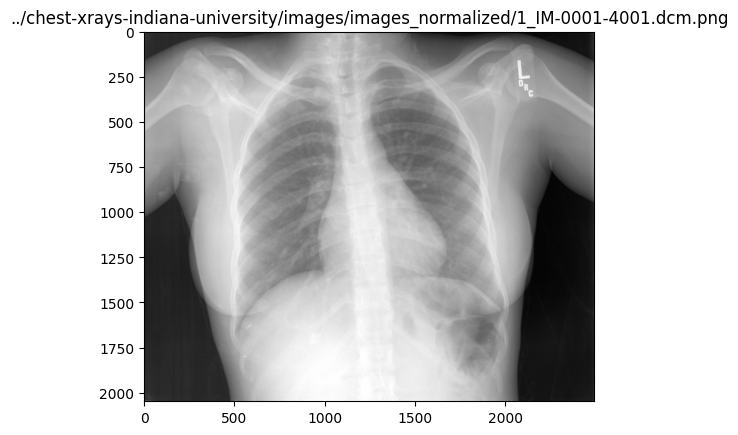

In [5]:
img = cv2.imread(df['image_path'].loc[0])
plt.imshow(img)
plt.title(df['image_path'].loc[0])
df['findings'].loc[0]

In [6]:
images = {}
findings = {}

# a = '../chest-xrays-indiana-university/images/images_normalized/1_IM-0001-4001.dcm.png'
# a = a.split('.')
# a = a[2].split('-')
# a.pop(len(a)-1)
# a = ('-'.join(e for e in a))
# a = '.' + a
# print(a)

for img, d in df[['image_path', 'findings']].values:
    x = img.split('.')
    x = x[2].split('-')
    x.pop(len(x)-1)
    x = ('-'.join(e for e in x))
    x = '..' + x
    if x not in images.keys():
        images[x] = 1
        findings[x] = d
    else:
        images[x] += 1
        findings[x] = d

print(images['../chest-xrays-indiana-university/images/images_normalized/1_IM-0001'], 'images refer to these findings ->', findings['../chest-xrays-indiana-university/images/images_normalized/1_IM-0001'])

2 images refer to these findings -> The cardiac silhouette and mediastinum size are within normal limits. There is no pulmonary edema. There is no focal consolidation. There are no XXXX of a pleural effusion. There is no evidence of pneumothorax.


3350


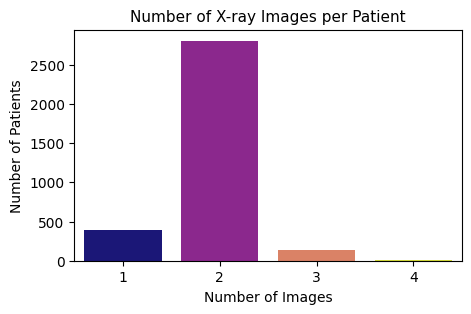

In [7]:
print(len(images))

image_counts = list(images.values())

# Create a DataFrame from image counts for better handling with Seaborn
data_for_plot = pd.DataFrame({'Image Counts': image_counts})
plt.figure(figsize=(5, 3))  # Set the figure size for better visualization
ax = sns.countplot(x='Image Counts', hue='Image Counts', data=data_for_plot, palette='plasma', dodge=False)
ax.legend_.remove()  

plt.title('Number of X-ray Images per Patient', fontsize=11)
plt.xlabel('Number of Images', fontsize=10)
plt.ylabel('Number of Patients', fontsize=10)

plt.show()

# the dataset mainly consists of two X-ray images per patient
# thus,single-image cases will be duplicated to ensure two images for every patient.

In [8]:
from sklearn.model_selection import train_test_split

def train_test_split(data):
    img = list(data.keys())
    train_split_index = int(len(img) * 0.8)
    test_split_index = train_split_index + int(len(img) * 0.1)

    # Split the data
    train_data = img[:train_split_index]
    test_data = img[train_split_index:test_split_index]
    val_data = img[test_split_index:]

    return train_data, test_data, val_data

train_data, test_data, val_data = train_test_split(images)

In [9]:
from collections import defaultdict 

def combining_images_per_person(data):    
    img_per_person = defaultdict(list)                          
    for person_id in data:
        for img in df['image_path'].values:
            if person_id in img:
                img_per_person[person_id].append(img)
            else:
                continue
    return img_per_person

train_data = combining_images_per_person(train_data)
test_data = combining_images_per_person(test_data)
val_data = combining_images_per_person(val_data)

In [10]:
import itertools

def final_data(image_per_person, findings):
    # Initialize lists to hold the new dataset's information
    person_id, img_1, img_2, caption = [], [], [], []
    
    # Iterate through each person and their associated images
    for pid, imgs in image_per_person.items():
        # Handle the case where there's only one image for the person
        if len(imgs) == 1:
            person_id.append(pid)
            img_1.append(imgs[0])
            img_2.append(imgs[0])
            caption.append(findings[pid])
        else:
            # For multiple images, create all unique combinations of two images
            for num, (img1, img2) in enumerate(itertools.combinations(imgs, 2)): 
                person_id.append(f"{pid}_{num}")
                img_1.append(img1)
                img_2.append(img2)
                caption.append(findings[pid])
              
    
    # Create a DataFrame from the lists
    data = pd.DataFrame({
        'person_id': person_id,
        'img_1': img_1,
        'img_2': img_2,
        'findings': caption
    })
    
    return data

In [11]:
train_data = final_data(train_data, findings)
test_data = final_data(test_data, findings)
val_data = final_data(val_data, findings)

train_data.head(5)

,person_id,img_1,img_2,findings
0,../chest-xrays-indiana-university/images/image...,../chest-xrays-indiana-university/images/image...,../chest-xrays-indiana-university/images/image...,The cardiac silhouette and mediastinum size ar...
1,../chest-xrays-indiana-university/images/image...,../chest-xrays-indiana-university/images/image...,../chest-xrays-indiana-university/images/image...,Borderline cardiomegaly. Midline sternotomy XX...
2,../chest-xrays-indiana-university/images/image...,../chest-xrays-indiana-university/images/image...,../chest-xrays-indiana-university/images/image...,There are diffuse bilateral interstitial and a...
3,../chest-xrays-indiana-university/images/image...,../chest-xrays-indiana-university/images/image...,../chest-xrays-indiana-university/images/image...,The cardiomediastinal silhouette and pulmonary...
4,../chest-xrays-indiana-university/images/image...,../chest-xrays-indiana-university/images/image...,../chest-xrays-indiana-university/images/image...,Heart size and mediastinal contour are within ...


In [12]:
def lowercase(text):
    new_text = []
    for line in text:
        new_text.append(line.lower())
    return new_text

def remove_punctuations(text):
    punctuations = '''!()-[]{};:'"\,<>/?@#$%^&*~''' # full stop is not removed
    new_text = []
    for line in text:
        for char in line:
            if char in punctuations: 
                line = line.replace(char, "")
        new_text.append(' '.join(e for e in line.split()))
    return new_text

def cleaning(text):
    text = lowercase(text)
    text = remove_punctuations(text)
    return text

In [13]:
train_data['findings'] = cleaning(train_data['findings'])
test_data['findings'] = cleaning(test_data['findings'])
val_data['findings'] = cleaning(val_data['findings'])

train_data

,person_id,img_1,img_2,findings
0,../chest-xrays-indiana-university/images/image...,../chest-xrays-indiana-university/images/image...,../chest-xrays-indiana-university/images/image...,the cardiac silhouette and mediastinum size ar...
1,../chest-xrays-indiana-university/images/image...,../chest-xrays-indiana-university/images/image...,../chest-xrays-indiana-university/images/image...,borderline cardiomegaly. midline sternotomy xx...
2,../chest-xrays-indiana-university/images/image...,../chest-xrays-indiana-university/images/image...,../chest-xrays-indiana-university/images/image...,there are diffuse bilateral interstitial and a...
3,../chest-xrays-indiana-university/images/image...,../chest-xrays-indiana-university/images/image...,../chest-xrays-indiana-university/images/image...,the cardiomediastinal silhouette and pulmonary...
4,../chest-xrays-indiana-university/images/image...,../chest-xrays-indiana-university/images/image...,../chest-xrays-indiana-university/images/image...,heart size and mediastinal contour are within ...
...,...,...,...,...
2931,../chest-xrays-indiana-university/images/image...,../chest-xrays-indiana-university/images/image...,../chest-xrays-indiana-university/images/image...,both lungs are clear and expanded. heart and m...
2932,../chest-xrays-indiana-university/images/image...,../chest-xrays-indiana-university/images/image...,../chest-xrays-indiana-university/images/image...,the lungs are clear. the cardiomediastinal sil...
2933,../chest-xrays-indiana-university/images/image...,../chest-xrays-indiana-university/images/image...,../chest-xrays-indiana-university/images/image...,lung volumes are low. no focal infiltrates. he...
2934,../chest-xrays-indiana-university/images/image...,../chest-xrays-indiana-university/images/image...,../chest-xrays-indiana-university/images/image...,normal heart size and mediastinal contours. no...


In [14]:
def add_start_end_token(x):
    return 'startseq' + ' ' + x + ' ' + 'endseq'

train_data['findings'] = train_data['findings'].apply(lambda x : add_start_end_token(x))
test_data['findings'] = test_data['findings'].apply(lambda x : add_start_end_token(x))
val_data['findings'] = val_data['findings'].apply(lambda x : add_start_end_token(x))

In [15]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, GlobalAveragePooling2D
from keras.layers import Flatten, Concatenate, Dropout, BatchNormalization
from keras.regularizers import l2
from keras import backend as K
from keras.applications.densenet import DenseNet121
from keras.applications.densenet import preprocess_input
import numpy as np
import pickle
import os
from tqdm import tqdm

def chexnet(input_shape=(224,224,3), weights_path=None):
    densenet = DenseNet121(weights=None, include_top=False, input_shape=input_shape, pooling="avg")
    
    X = densenet.output
    
    predictions = Dense(14, activation='sigmoid',name="predictions")(X)
    model = Model(inputs=densenet.input, outputs=predictions)
    
    if weights_path is not None:
        densenet.load_weights(weights_path, by_name=True)
        
    model = Model(inputs = model.input, outputs = model.layers[-2].output)

    return model

chexnet_model = chexnet(input_shape=(224,224,3), weights_path='../chexnet-weights/brucechou1983_CheXNet_Keras_0.3.0_weights.h5')

2024-02-28 14:58:55.004849: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2024-02-28 14:58:55.004865: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: csbui
2024-02-28 14:58:55.004868: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: csbui
2024-02-28 14:58:55.004936: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 535.161.7
2024-02-28 14:58:55.004944: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 535.154.5
2024-02-28 14:58:55.004946: E external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:244] kernel version 535.154.5 does not match DSO version 535.161.7 -- cannot find working devices in this configuration


In [16]:
chexnet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']    

 conv4_block11_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block11_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block11_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block11_1_relu[0][0]']   
                                                                                                  
 conv4_block11_concat (Concaten  (None, 14, 14, 608)  0          ['conv4_block10_concat[0][0]',   
 ate)                                                             'conv4_block11_2_conv[0][0]']   
                                                                                                  
 conv4_block12_0_bn (BatchNorma  (None, 14, 14, 608)  2432       ['conv4_block11_concat[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv4_block16_0_bn (BatchNorma  (None, 14, 14, 736)  2944       ['conv4_block15_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block16_0_relu (Activati  (None, 14, 14, 736)  0          ['conv4_block16_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_1_conv (Conv2D)  (None, 14, 14, 128)  94208       ['conv4_block16_0_relu[0][0]']   
                                                                                                  
 conv4_block16_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block16_1_conv[0][0]']   
 lization)

 conv4_block20_1_conv (Conv2D)  (None, 14, 14, 128)  110592      ['conv4_block20_0_relu[0][0]']   
                                                                                                  
 conv4_block20_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block20_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block20_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block20_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block20_1_relu[0][0]']   
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block24_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block24_1_relu[0][0]']   
                                                                                                  
 conv4_block24_concat (Concaten  (None, 14, 14, 1024  0          ['conv4_block23_concat[0][0]',   
 ate)                           )                                 'conv4_block24_2_conv[0][0]']   
                                                                                                  
 pool4_bn (BatchNormalization)  (None, 14, 14, 1024  4096        ['conv4_block24_concat[0][0]']   
                                )                                                                 
                                                                                                  
 pool4_relu (Activation)        (None, 14, 14, 1024  0           ['pool4_bn[0][0]']               
          

                                                                                                  
 conv5_block4_1_relu (Activatio  (None, 7, 7, 128)   0           ['conv5_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block4_2_conv (Conv2D)   (None, 7, 7, 32)     36864       ['conv5_block4_1_relu[0][0]']    
                                                                                                  
 conv5_block4_concat (Concatena  (None, 7, 7, 640)   0           ['conv5_block3_concat[0][0]',    
 te)                                                              'conv5_block4_2_conv[0][0]']    
                                                                                                  
 conv5_block5_0_bn (BatchNormal  (None, 7, 7, 640)   2560        ['conv5_block4_concat[0][0]']    
 ization) 

 te)                                                              'conv5_block8_2_conv[0][0]']    
                                                                                                  
 conv5_block9_0_bn (BatchNormal  (None, 7, 7, 768)   3072        ['conv5_block8_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block9_0_relu (Activatio  (None, 7, 7, 768)   0           ['conv5_block9_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block9_1_conv (Conv2D)   (None, 7, 7, 128)    98304       ['conv5_block9_0_relu[0][0]']    
                                                                                                  
 conv5_blo

                                                                                                  
 conv5_block13_1_conv (Conv2D)  (None, 7, 7, 128)    114688      ['conv5_block13_0_relu[0][0]']   
                                                                                                  
 conv5_block13_1_bn (BatchNorma  (None, 7, 7, 128)   512         ['conv5_block13_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block13_1_relu (Activati  (None, 7, 7, 128)   0           ['conv5_block13_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block13_2_conv (Conv2D)  (None, 7, 7, 32)     36864       ['conv5_block13_1_relu[0][0]']   
          

In [17]:
from tensorflow.keras.utils import load_img, img_to_array

def preprocess_image(img_path):
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return preprocess_input(img_array_expanded_dims)

chexnet_features = {}
for key, img1, img2, finding in tqdm(train_data.values):
    img1 = preprocess_image(img1)
    img1_features = chexnet_model.predict(img1)    
    img2 = preprocess_image(img2)
    img2_features = chexnet_model.predict(img2)
    input_ = np.concatenate((img1_features, img2_features), axis=1)
    chexnet_features[key] = input_
    
for key, img1, img2, finding in tqdm(test_data.values):
    img1 = preprocess_image(img1)
    img1_features = chexnet_model.predict(img1)    
    img2 = preprocess_image(img2)
    img2_features = chexnet_model.predict(img2)
    input_ = np.concatenate((img1_features, img2_features), axis=1)
    chexnet_features[key] = input_

for key, img1, img2, finding in tqdm(val_data.values):
    img1 = preprocess_image(img1)
    img1_features = chexnet_model.predict(img1)    
    img2 = preprocess_image(img2)
    img2_features = chexnet_model.predict(img2)
    input_ = np.concatenate((img1_features, img2_features), axis=1)
    chexnet_features[key] = input_
    
# Save the image features as a pickle file
with open("chexnet_features.pkl", "wb") as f:
    pickle.dump(chexnet_features, f)

  0%|                                                                                          | 0/2936 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


  0%|                                                                                  | 1/2936 [00:00<45:16,  1.08it/s]

1/1 [==============================] - 0s 40ms/step


  0%|                                                                                  | 2/2936 [00:01<23:42,  2.06it/s]

1/1 [==============================] - 0s 37ms/step


  0%|                                                                                  | 3/2936 [00:01<17:18,  2.82it/s]

1/1 [==============================] - 0s 39ms/step


  0%|                                                                                  | 4/2936 [00:01<14:02,  3.48it/s]

1/1 [==============================] - 0s 40ms/step


  0%|▏                                                                                 | 5/2936 [00:01<12:07,  4.03it/s]

1/1 [==============================] - 0s 46ms/step


  0%|▏                                                                                 | 6/2936 [00:01<10:48,  4.52it/s]

1/1 [==============================] - 0s 40ms/step


  0%|▏                                                                                 | 7/2936 [00:02<09:56,  4.91it/s]

1/1 [==============================] - 0s 37ms/step


  0%|▏                                                                                 | 8/2936 [00:02<09:14,  5.28it/s]

1/1 [==============================] - 0s 37ms/step


  0%|▎                                                                                 | 9/2936 [00:02<09:13,  5.29it/s]

1/1 [==============================] - 0s 36ms/step


  0%|▎                                                                                | 10/2936 [00:02<08:53,  5.49it/s]

1/1 [==============================] - 0s 40ms/step


  0%|▎                                                                                | 11/2936 [00:02<08:54,  5.47it/s]

1/1 [==============================] - 0s 37ms/step


  0%|▎                                                                                | 12/2936 [00:02<08:45,  5.56it/s]

1/1 [==============================] - 0s 41ms/step


  0%|▎                                                                                | 13/2936 [00:03<08:36,  5.66it/s]

1/1 [==============================] - 0s 37ms/step


  0%|▍                                                                                | 14/2936 [00:03<08:30,  5.73it/s]

1/1 [==============================] - 0s 39ms/step


  1%|▍                                                                                | 15/2936 [00:03<08:40,  5.61it/s]

1/1 [==============================] - 0s 37ms/step


  1%|▍                                                                                | 16/2936 [00:03<08:29,  5.73it/s]

1/1 [==============================] - 0s 39ms/step


  1%|▍                                                                                | 17/2936 [00:03<08:32,  5.70it/s]

1/1 [==============================] - 0s 41ms/step


  1%|▍                                                                                | 18/2936 [00:03<08:40,  5.61it/s]

1/1 [==============================] - 0s 37ms/step


  1%|▌                                                                                | 19/2936 [00:04<08:49,  5.50it/s]

1/1 [==============================] - 0s 40ms/step


  1%|▌                                                                                | 20/2936 [00:04<08:32,  5.69it/s]

1/1 [==============================] - 0s 36ms/step


  1%|▌                                                                                | 21/2936 [00:04<08:41,  5.59it/s]

1/1 [==============================] - 0s 36ms/step


  1%|▌                                                                                | 22/2936 [00:04<08:24,  5.78it/s]

1/1 [==============================] - 0s 42ms/step


  1%|▋                                                                                | 23/2936 [00:04<08:35,  5.65it/s]

1/1 [==============================] - 0s 37ms/step


  1%|▋                                                                                | 24/2936 [00:04<08:32,  5.68it/s]

1/1 [==============================] - 0s 41ms/step


  1%|▋                                                                                | 25/2936 [00:05<08:25,  5.76it/s]

1/1 [==============================] - 0s 37ms/step


  1%|▋                                                                                | 26/2936 [00:05<08:23,  5.78it/s]

1/1 [==============================] - 0s 37ms/step


  1%|▋                                                                                | 27/2936 [00:05<08:21,  5.80it/s]

1/1 [==============================] - 0s 37ms/step


  1%|▊                                                                                | 28/2936 [00:05<08:20,  5.81it/s]

1/1 [==============================] - 0s 37ms/step


  1%|▊                                                                                | 29/2936 [00:05<08:22,  5.79it/s]

1/1 [==============================] - 0s 37ms/step


  1%|▊                                                                                | 30/2936 [00:06<08:26,  5.74it/s]

1/1 [==============================] - 0s 37ms/step


  1%|▊                                                                                | 31/2936 [00:06<08:25,  5.75it/s]

1/1 [==============================] - 0s 37ms/step


  1%|▉                                                                                | 32/2936 [00:06<08:25,  5.75it/s]

1/1 [==============================] - 0s 39ms/step


  1%|▉                                                                                | 33/2936 [00:06<08:50,  5.47it/s]

1/1 [==============================] - 0s 37ms/step


  1%|▉                                                                                | 34/2936 [00:06<08:39,  5.59it/s]

1/1 [==============================] - 0s 45ms/step


  1%|▉                                                                                | 35/2936 [00:06<08:31,  5.67it/s]

1/1 [==============================] - 0s 36ms/step


  1%|▉                                                                                | 36/2936 [00:07<08:17,  5.83it/s]

1/1 [==============================] - 0s 37ms/step


  1%|█                                                                                | 37/2936 [00:07<08:11,  5.90it/s]

1/1 [==============================] - 0s 37ms/step


  1%|█                                                                                | 38/2936 [00:07<08:04,  5.98it/s]

1/1 [==============================] - 0s 36ms/step


  1%|█                                                                                | 39/2936 [00:07<07:57,  6.07it/s]

1/1 [==============================] - 0s 38ms/step


  1%|█                                                                                | 40/2936 [00:07<08:03,  5.99it/s]

1/1 [==============================] - 0s 37ms/step


  1%|█▏                                                                               | 41/2936 [00:07<07:56,  6.08it/s]

1/1 [==============================] - 0s 36ms/step


  1%|█▏                                                                               | 42/2936 [00:08<08:04,  5.97it/s]

1/1 [==============================] - 0s 37ms/step


  1%|█▏                                                                               | 43/2936 [00:08<08:07,  5.93it/s]

1/1 [==============================] - 0s 37ms/step


  1%|█▏                                                                               | 44/2936 [00:08<08:08,  5.92it/s]

1/1 [==============================] - 0s 36ms/step


  2%|█▏                                                                               | 45/2936 [00:08<08:10,  5.90it/s]

1/1 [==============================] - 0s 50ms/step


  2%|█▎                                                                               | 46/2936 [00:08<08:17,  5.81it/s]

1/1 [==============================] - 0s 36ms/step


  2%|█▎                                                                               | 47/2936 [00:08<08:20,  5.78it/s]

1/1 [==============================] - 0s 37ms/step


  2%|█▎                                                                               | 48/2936 [00:09<08:05,  5.95it/s]

1/1 [==============================] - 0s 37ms/step


  2%|█▎                                                                               | 49/2936 [00:09<08:11,  5.87it/s]

1/1 [==============================] - 0s 37ms/step


  2%|█▍                                                                               | 50/2936 [00:09<08:13,  5.84it/s]

1/1 [==============================] - 0s 36ms/step


  2%|█▍                                                                               | 51/2936 [00:09<08:13,  5.85it/s]

1/1 [==============================] - 0s 37ms/step


  2%|█▍                                                                               | 52/2936 [00:09<08:12,  5.86it/s]

1/1 [==============================] - 0s 37ms/step


  2%|█▍                                                                               | 53/2936 [00:09<08:13,  5.84it/s]

1/1 [==============================] - 0s 37ms/step


  2%|█▍                                                                               | 54/2936 [00:10<08:07,  5.92it/s]

1/1 [==============================] - 0s 37ms/step


  2%|█▌                                                                               | 55/2936 [00:10<08:00,  6.00it/s]

1/1 [==============================] - 0s 38ms/step


  2%|█▌                                                                               | 56/2936 [00:10<08:08,  5.90it/s]

1/1 [==============================] - 0s 37ms/step


  2%|█▌                                                                               | 57/2936 [00:10<08:07,  5.91it/s]

1/1 [==============================] - 0s 38ms/step


  2%|█▌                                                                               | 58/2936 [00:10<08:10,  5.87it/s]

1/1 [==============================] - 0s 37ms/step


  2%|█▋                                                                               | 59/2936 [00:10<08:12,  5.84it/s]

1/1 [==============================] - 0s 37ms/step


  2%|█▋                                                                               | 60/2936 [00:11<08:07,  5.89it/s]

1/1 [==============================] - 0s 37ms/step


  2%|█▋                                                                               | 61/2936 [00:11<08:02,  5.95it/s]

1/1 [==============================] - 0s 38ms/step


  2%|█▋                                                                               | 62/2936 [00:11<08:00,  5.98it/s]

1/1 [==============================] - 0s 37ms/step


  2%|█▋                                                                               | 63/2936 [00:11<07:57,  6.02it/s]

1/1 [==============================] - 0s 37ms/step


  2%|█▊                                                                               | 64/2936 [00:11<07:51,  6.10it/s]

1/1 [==============================] - 0s 36ms/step


  2%|█▊                                                                               | 65/2936 [00:11<07:59,  5.98it/s]

1/1 [==============================] - 0s 36ms/step


  2%|█▊                                                                               | 66/2936 [00:12<07:53,  6.06it/s]

1/1 [==============================] - 0s 37ms/step


  2%|█▊                                                                               | 67/2936 [00:12<07:56,  6.03it/s]

1/1 [==============================] - 0s 37ms/step


  2%|█▉                                                                               | 68/2936 [00:12<07:47,  6.13it/s]

1/1 [==============================] - 0s 38ms/step


  2%|█▉                                                                               | 69/2936 [00:12<07:55,  6.03it/s]

1/1 [==============================] - 0s 37ms/step


  2%|█▉                                                                               | 70/2936 [00:12<07:48,  6.11it/s]

1/1 [==============================] - 0s 36ms/step


  2%|█▉                                                                               | 71/2936 [00:12<07:41,  6.21it/s]

1/1 [==============================] - 0s 38ms/step


  2%|█▉                                                                               | 72/2936 [00:13<07:50,  6.09it/s]

1/1 [==============================] - 0s 37ms/step


  2%|██                                                                               | 73/2936 [00:13<07:56,  6.01it/s]

1/1 [==============================] - 0s 37ms/step


  3%|██                                                                               | 74/2936 [00:13<08:14,  5.79it/s]

1/1 [==============================] - 0s 37ms/step


  3%|██                                                                               | 75/2936 [00:13<07:59,  5.97it/s]

1/1 [==============================] - 0s 38ms/step


  3%|██                                                                               | 76/2936 [00:13<07:55,  6.02it/s]

1/1 [==============================] - 0s 38ms/step


  3%|██                                                                               | 77/2936 [00:13<07:58,  5.98it/s]

1/1 [==============================] - 0s 39ms/step


  3%|██▏                                                                              | 78/2936 [00:14<07:55,  6.01it/s]

1/1 [==============================] - 0s 36ms/step


  3%|██▏                                                                              | 79/2936 [00:14<08:02,  5.92it/s]

1/1 [==============================] - 0s 37ms/step


  3%|██▏                                                                              | 80/2936 [00:14<08:04,  5.89it/s]

1/1 [==============================] - 0s 38ms/step


  3%|██▏                                                                              | 81/2936 [00:14<08:08,  5.85it/s]

1/1 [==============================] - 0s 36ms/step


  3%|██▎                                                                              | 82/2936 [00:14<08:07,  5.86it/s]

1/1 [==============================] - 0s 38ms/step


  3%|██▎                                                                              | 83/2936 [00:14<07:56,  5.99it/s]

1/1 [==============================] - 0s 37ms/step


  3%|██▎                                                                              | 84/2936 [00:15<08:04,  5.89it/s]

1/1 [==============================] - 0s 37ms/step


  3%|██▎                                                                              | 85/2936 [00:15<07:56,  5.98it/s]

1/1 [==============================] - 0s 37ms/step


  3%|██▎                                                                              | 86/2936 [00:15<07:56,  5.98it/s]

1/1 [==============================] - 0s 37ms/step


  3%|██▍                                                                              | 87/2936 [00:15<08:01,  5.92it/s]

1/1 [==============================] - 0s 37ms/step


  3%|██▍                                                                              | 88/2936 [00:15<08:07,  5.84it/s]

1/1 [==============================] - 0s 37ms/step


  3%|██▍                                                                              | 89/2936 [00:15<07:58,  5.95it/s]

1/1 [==============================] - 0s 38ms/step


  3%|██▍                                                                              | 90/2936 [00:16<08:01,  5.91it/s]

1/1 [==============================] - 0s 37ms/step


  3%|██▌                                                                              | 91/2936 [00:16<08:03,  5.88it/s]

1/1 [==============================] - 0s 37ms/step


  3%|██▌                                                                              | 92/2936 [00:16<08:00,  5.92it/s]

1/1 [==============================] - 0s 37ms/step


  3%|██▌                                                                              | 93/2936 [00:16<07:59,  5.92it/s]

1/1 [==============================] - 0s 37ms/step


  3%|██▌                                                                              | 94/2936 [00:16<08:00,  5.91it/s]

1/1 [==============================] - 0s 37ms/step


  3%|██▌                                                                              | 95/2936 [00:16<07:59,  5.93it/s]

1/1 [==============================] - 0s 36ms/step


  3%|██▋                                                                              | 96/2936 [00:17<07:48,  6.06it/s]

1/1 [==============================] - 0s 37ms/step


  3%|██▋                                                                              | 97/2936 [00:17<07:55,  5.98it/s]

1/1 [==============================] - 0s 37ms/step


  3%|██▋                                                                              | 98/2936 [00:17<07:59,  5.91it/s]

1/1 [==============================] - 0s 38ms/step


  3%|██▋                                                                              | 99/2936 [00:17<08:05,  5.84it/s]

1/1 [==============================] - 0s 38ms/step


  3%|██▋                                                                             | 100/2936 [00:17<08:13,  5.75it/s]

1/1 [==============================] - 0s 37ms/step


  3%|██▊                                                                             | 101/2936 [00:18<08:09,  5.79it/s]

1/1 [==============================] - 0s 38ms/step


  3%|██▊                                                                             | 102/2936 [00:18<08:08,  5.80it/s]

1/1 [==============================] - 0s 37ms/step


  4%|██▊                                                                             | 103/2936 [00:18<08:00,  5.90it/s]

1/1 [==============================] - 0s 37ms/step


  4%|██▊                                                                             | 104/2936 [00:18<07:52,  5.99it/s]

1/1 [==============================] - 0s 37ms/step


  4%|██▊                                                                             | 105/2936 [00:18<07:58,  5.92it/s]

1/1 [==============================] - 0s 44ms/step


  4%|██▉                                                                             | 106/2936 [00:18<08:07,  5.80it/s]

1/1 [==============================] - 0s 36ms/step


  4%|██▉                                                                             | 107/2936 [00:19<08:08,  5.79it/s]

1/1 [==============================] - 0s 38ms/step


  4%|██▉                                                                             | 108/2936 [00:19<07:57,  5.92it/s]

1/1 [==============================] - 0s 38ms/step


  4%|██▉                                                                             | 109/2936 [00:19<07:51,  6.00it/s]

1/1 [==============================] - 0s 37ms/step


  4%|██▉                                                                             | 110/2936 [00:19<07:54,  5.96it/s]

1/1 [==============================] - 0s 37ms/step


  4%|███                                                                             | 111/2936 [00:19<07:48,  6.03it/s]

1/1 [==============================] - 0s 38ms/step


  4%|███                                                                             | 112/2936 [00:19<07:45,  6.06it/s]

1/1 [==============================] - 0s 37ms/step


  4%|███                                                                             | 113/2936 [00:20<07:40,  6.13it/s]

1/1 [==============================] - 0s 37ms/step


  4%|███                                                                             | 114/2936 [00:20<07:38,  6.15it/s]

1/1 [==============================] - 0s 37ms/step


  4%|███▏                                                                            | 115/2936 [00:20<07:40,  6.12it/s]

1/1 [==============================] - 0s 37ms/step


  4%|███▏                                                                            | 116/2936 [00:20<07:38,  6.14it/s]

1/1 [==============================] - 0s 37ms/step


  4%|███▏                                                                            | 117/2936 [00:20<07:48,  6.02it/s]

1/1 [==============================] - 0s 38ms/step


  4%|███▏                                                                            | 118/2936 [00:20<07:56,  5.91it/s]

1/1 [==============================] - 0s 38ms/step


  4%|███▏                                                                            | 119/2936 [00:21<07:47,  6.02it/s]

1/1 [==============================] - 0s 37ms/step


  4%|███▎                                                                            | 120/2936 [00:21<07:52,  5.97it/s]

1/1 [==============================] - 0s 37ms/step


  4%|███▎                                                                            | 121/2936 [00:21<07:46,  6.04it/s]

1/1 [==============================] - 0s 40ms/step


  4%|███▎                                                                            | 122/2936 [00:21<07:41,  6.10it/s]

1/1 [==============================] - 0s 37ms/step


  4%|███▎                                                                            | 123/2936 [00:21<07:53,  5.94it/s]

1/1 [==============================] - 0s 37ms/step


  4%|███▍                                                                            | 124/2936 [00:21<07:50,  5.97it/s]

1/1 [==============================] - 0s 37ms/step


  4%|███▍                                                                            | 125/2936 [00:22<07:48,  6.00it/s]

1/1 [==============================] - 0s 37ms/step


  4%|███▍                                                                            | 126/2936 [00:22<07:48,  5.99it/s]

1/1 [==============================] - 0s 38ms/step


  4%|███▍                                                                            | 127/2936 [00:22<07:49,  5.98it/s]

1/1 [==============================] - 0s 38ms/step


  4%|███▍                                                                            | 128/2936 [00:22<07:52,  5.94it/s]

1/1 [==============================] - 0s 37ms/step


  4%|███▌                                                                            | 129/2936 [00:22<07:43,  6.06it/s]

1/1 [==============================] - 0s 37ms/step


  4%|███▌                                                                            | 130/2936 [00:22<07:46,  6.01it/s]

1/1 [==============================] - 0s 42ms/step


  4%|███▌                                                                            | 131/2936 [00:23<07:56,  5.89it/s]

1/1 [==============================] - 0s 38ms/step


  4%|███▌                                                                            | 132/2936 [00:23<08:00,  5.84it/s]

1/1 [==============================] - 0s 36ms/step


  5%|███▌                                                                            | 133/2936 [00:23<08:01,  5.82it/s]

1/1 [==============================] - 0s 37ms/step


  5%|███▋                                                                            | 134/2936 [00:23<07:53,  5.91it/s]

1/1 [==============================] - 0s 37ms/step


  5%|███▋                                                                            | 135/2936 [00:23<07:57,  5.87it/s]

1/1 [==============================] - 0s 40ms/step


  5%|███▋                                                                            | 136/2936 [00:23<08:00,  5.82it/s]

1/1 [==============================] - 0s 36ms/step


  5%|███▋                                                                            | 137/2936 [00:24<07:53,  5.92it/s]

1/1 [==============================] - 0s 37ms/step


  5%|███▊                                                                            | 138/2936 [00:24<07:54,  5.90it/s]

1/1 [==============================] - 0s 38ms/step


  5%|███▊                                                                            | 139/2936 [00:24<07:59,  5.84it/s]

1/1 [==============================] - 0s 38ms/step


  5%|███▊                                                                            | 140/2936 [00:24<07:54,  5.89it/s]

1/1 [==============================] - 0s 37ms/step


  5%|███▊                                                                            | 141/2936 [00:24<07:55,  5.88it/s]

1/1 [==============================] - 0s 43ms/step


  5%|███▊                                                                            | 142/2936 [00:24<08:10,  5.70it/s]

1/1 [==============================] - 0s 37ms/step


  5%|███▉                                                                            | 143/2936 [00:25<08:10,  5.70it/s]

1/1 [==============================] - 0s 37ms/step


  5%|███▉                                                                            | 144/2936 [00:25<08:10,  5.69it/s]

1/1 [==============================] - 0s 37ms/step


  5%|███▉                                                                            | 145/2936 [00:25<07:59,  5.82it/s]

1/1 [==============================] - 0s 38ms/step


  5%|███▉                                                                            | 146/2936 [00:25<07:59,  5.82it/s]

1/1 [==============================] - 0s 38ms/step


  5%|████                                                                            | 147/2936 [00:25<07:51,  5.92it/s]

1/1 [==============================] - 0s 38ms/step


  5%|████                                                                            | 148/2936 [00:26<09:02,  5.14it/s]

1/1 [==============================] - 0s 38ms/step


  5%|████                                                                            | 149/2936 [00:26<08:46,  5.29it/s]

1/1 [==============================] - 0s 80ms/step


  5%|████                                                                            | 150/2936 [00:26<09:15,  5.01it/s]

1/1 [==============================] - 0s 37ms/step


  5%|████                                                                            | 151/2936 [00:26<09:12,  5.04it/s]

1/1 [==============================] - 0s 37ms/step


  5%|████▏                                                                           | 152/2936 [00:26<08:51,  5.24it/s]

1/1 [==============================] - 0s 38ms/step


  5%|████▏                                                                           | 153/2936 [00:26<08:34,  5.41it/s]

1/1 [==============================] - 0s 37ms/step


  5%|████▏                                                                           | 154/2936 [00:27<08:30,  5.44it/s]

1/1 [==============================] - 0s 40ms/step


  5%|████▏                                                                           | 155/2936 [00:27<08:16,  5.60it/s]

1/1 [==============================] - 0s 37ms/step


  5%|████▎                                                                           | 156/2936 [00:27<08:05,  5.72it/s]

1/1 [==============================] - 0s 38ms/step


  5%|████▎                                                                           | 157/2936 [00:27<07:59,  5.79it/s]

1/1 [==============================] - 0s 37ms/step


  5%|████▎                                                                           | 158/2936 [00:27<08:02,  5.76it/s]

1/1 [==============================] - 0s 36ms/step


  5%|████▎                                                                           | 159/2936 [00:27<08:01,  5.77it/s]

1/1 [==============================] - 0s 37ms/step


  5%|████▎                                                                           | 160/2936 [00:28<07:59,  5.78it/s]

1/1 [==============================] - 0s 37ms/step


  5%|████▍                                                                           | 161/2936 [00:28<07:50,  5.89it/s]

1/1 [==============================] - 0s 37ms/step


  6%|████▍                                                                           | 162/2936 [00:28<07:47,  5.94it/s]

1/1 [==============================] - 0s 36ms/step


  6%|████▍                                                                           | 163/2936 [00:28<07:52,  5.87it/s]

1/1 [==============================] - 0s 37ms/step


  6%|████▍                                                                           | 164/2936 [00:28<07:55,  5.83it/s]

1/1 [==============================] - 0s 38ms/step


  6%|████▍                                                                           | 165/2936 [00:29<07:52,  5.87it/s]

1/1 [==============================] - 0s 38ms/step


  6%|████▌                                                                           | 166/2936 [00:29<07:55,  5.82it/s]

1/1 [==============================] - 0s 38ms/step


  6%|████▌                                                                           | 167/2936 [00:29<07:56,  5.81it/s]

1/1 [==============================] - 0s 37ms/step


  6%|████▌                                                                           | 168/2936 [00:29<07:54,  5.84it/s]

1/1 [==============================] - 0s 37ms/step


  6%|████▌                                                                           | 169/2936 [00:29<07:44,  5.96it/s]

1/1 [==============================] - 0s 38ms/step


  6%|████▋                                                                           | 170/2936 [00:29<07:37,  6.05it/s]

1/1 [==============================] - 0s 37ms/step


  6%|████▋                                                                           | 171/2936 [00:30<07:48,  5.90it/s]

1/1 [==============================] - 0s 39ms/step


  6%|████▋                                                                           | 172/2936 [00:30<07:51,  5.86it/s]

1/1 [==============================] - 0s 37ms/step


  6%|████▋                                                                           | 173/2936 [00:30<07:43,  5.96it/s]

1/1 [==============================] - 0s 36ms/step


  6%|████▋                                                                           | 174/2936 [00:30<07:41,  5.98it/s]

1/1 [==============================] - 0s 37ms/step


  6%|████▊                                                                           | 175/2936 [00:30<07:45,  5.93it/s]

1/1 [==============================] - 0s 37ms/step


  6%|████▊                                                                           | 176/2936 [00:30<07:46,  5.92it/s]

1/1 [==============================] - 0s 37ms/step


  6%|████▊                                                                           | 177/2936 [00:31<07:37,  6.03it/s]

1/1 [==============================] - 0s 37ms/step


  6%|████▊                                                                           | 178/2936 [00:31<07:42,  5.96it/s]

1/1 [==============================] - 0s 37ms/step


  6%|████▉                                                                           | 179/2936 [00:31<07:36,  6.04it/s]

1/1 [==============================] - 0s 38ms/step


  6%|████▉                                                                           | 180/2936 [00:31<07:35,  6.05it/s]

1/1 [==============================] - 0s 37ms/step


  6%|████▉                                                                           | 181/2936 [00:31<07:36,  6.03it/s]

1/1 [==============================] - 0s 38ms/step


  6%|████▉                                                                           | 182/2936 [00:31<07:30,  6.12it/s]

1/1 [==============================] - 0s 37ms/step


  6%|████▉                                                                           | 183/2936 [00:32<07:34,  6.06it/s]

1/1 [==============================] - 0s 37ms/step


  6%|█████                                                                           | 184/2936 [00:32<07:29,  6.12it/s]

1/1 [==============================] - 0s 37ms/step


  6%|█████                                                                           | 185/2936 [00:32<07:34,  6.06it/s]

1/1 [==============================] - 0s 38ms/step


  6%|█████                                                                           | 186/2936 [00:32<07:41,  5.96it/s]

1/1 [==============================] - 0s 43ms/step


  6%|█████                                                                           | 187/2936 [00:32<07:53,  5.80it/s]

1/1 [==============================] - 0s 38ms/step


  6%|█████                                                                           | 188/2936 [00:32<07:54,  5.79it/s]

1/1 [==============================] - 0s 37ms/step


  6%|█████▏                                                                          | 189/2936 [00:33<07:45,  5.90it/s]

1/1 [==============================] - 0s 37ms/step


  6%|█████▏                                                                          | 190/2936 [00:33<07:44,  5.91it/s]

1/1 [==============================] - 0s 38ms/step


  7%|█████▏                                                                          | 191/2936 [00:33<07:39,  5.97it/s]

1/1 [==============================] - 0s 38ms/step


  7%|█████▏                                                                          | 192/2936 [00:33<07:34,  6.04it/s]

1/1 [==============================] - 0s 37ms/step


  7%|█████▎                                                                          | 193/2936 [00:33<07:29,  6.10it/s]

1/1 [==============================] - 0s 36ms/step


  7%|█████▎                                                                          | 194/2936 [00:33<07:37,  5.99it/s]

1/1 [==============================] - 0s 37ms/step


  7%|█████▎                                                                          | 195/2936 [00:34<07:45,  5.89it/s]

1/1 [==============================] - 0s 37ms/step


  7%|█████▎                                                                          | 196/2936 [00:34<07:48,  5.85it/s]

1/1 [==============================] - 0s 36ms/step


  7%|█████▎                                                                          | 197/2936 [00:34<07:48,  5.85it/s]

1/1 [==============================] - 0s 38ms/step


  7%|█████▍                                                                          | 198/2936 [00:34<07:48,  5.84it/s]

1/1 [==============================] - 0s 38ms/step


  7%|█████▍                                                                          | 199/2936 [00:34<07:47,  5.86it/s]

1/1 [==============================] - 0s 40ms/step


  7%|█████▍                                                                          | 200/2936 [00:34<07:53,  5.78it/s]

1/1 [==============================] - 0s 37ms/step


  7%|█████▍                                                                          | 201/2936 [00:35<07:55,  5.75it/s]

1/1 [==============================] - 0s 38ms/step


  7%|█████▌                                                                          | 202/2936 [00:35<07:46,  5.86it/s]

1/1 [==============================] - 0s 36ms/step


  7%|█████▌                                                                          | 203/2936 [00:35<07:41,  5.92it/s]

1/1 [==============================] - 0s 37ms/step


  7%|█████▌                                                                          | 204/2936 [00:35<07:59,  5.70it/s]

1/1 [==============================] - 0s 38ms/step


  7%|█████▌                                                                          | 205/2936 [00:35<07:53,  5.77it/s]

1/1 [==============================] - 0s 37ms/step


  7%|█████▌                                                                          | 206/2936 [00:35<07:47,  5.84it/s]

1/1 [==============================] - 0s 37ms/step


  7%|█████▋                                                                          | 207/2936 [00:36<07:47,  5.84it/s]

1/1 [==============================] - 0s 37ms/step


  7%|█████▋                                                                          | 208/2936 [00:36<07:46,  5.85it/s]

1/1 [==============================] - 0s 38ms/step


  7%|█████▋                                                                          | 209/2936 [00:36<07:51,  5.79it/s]

1/1 [==============================] - 0s 38ms/step


  7%|█████▋                                                                          | 210/2936 [00:36<07:50,  5.79it/s]

1/1 [==============================] - 0s 37ms/step


  7%|█████▋                                                                          | 211/2936 [00:36<07:44,  5.86it/s]

1/1 [==============================] - 0s 36ms/step


  7%|█████▊                                                                          | 212/2936 [00:36<07:48,  5.82it/s]

1/1 [==============================] - 0s 38ms/step


  7%|█████▊                                                                          | 213/2936 [00:37<07:44,  5.86it/s]

1/1 [==============================] - 0s 37ms/step


  7%|█████▊                                                                          | 214/2936 [00:37<07:44,  5.86it/s]

1/1 [==============================] - 0s 37ms/step


  7%|█████▊                                                                          | 215/2936 [00:37<07:35,  5.97it/s]

1/1 [==============================] - 0s 37ms/step


  7%|█████▉                                                                          | 216/2936 [00:37<07:27,  6.08it/s]

1/1 [==============================] - 0s 38ms/step


  7%|█████▉                                                                          | 217/2936 [00:37<07:25,  6.11it/s]

1/1 [==============================] - 0s 38ms/step


  7%|█████▉                                                                          | 218/2936 [00:37<07:21,  6.15it/s]

1/1 [==============================] - 0s 37ms/step


  7%|█████▉                                                                          | 219/2936 [00:38<07:17,  6.21it/s]

1/1 [==============================] - 0s 38ms/step


  7%|█████▉                                                                          | 220/2936 [00:38<07:26,  6.09it/s]

1/1 [==============================] - 0s 37ms/step


  8%|██████                                                                          | 221/2936 [00:38<07:23,  6.12it/s]

1/1 [==============================] - 0s 38ms/step


  8%|██████                                                                          | 222/2936 [00:38<07:34,  5.97it/s]

1/1 [==============================] - 0s 37ms/step


  8%|██████                                                                          | 223/2936 [00:38<07:37,  5.93it/s]

1/1 [==============================] - 0s 38ms/step


  8%|██████                                                                          | 224/2936 [00:38<07:42,  5.86it/s]

1/1 [==============================] - 0s 38ms/step


  8%|██████▏                                                                         | 225/2936 [00:39<07:45,  5.82it/s]

1/1 [==============================] - 0s 38ms/step


  8%|██████▏                                                                         | 226/2936 [00:39<07:58,  5.66it/s]

1/1 [==============================] - 0s 37ms/step


  8%|██████▏                                                                         | 227/2936 [00:39<07:55,  5.70it/s]

1/1 [==============================] - 0s 38ms/step


  8%|██████▏                                                                         | 228/2936 [00:39<07:54,  5.71it/s]

1/1 [==============================] - 0s 38ms/step


  8%|██████▏                                                                         | 229/2936 [00:39<07:50,  5.75it/s]

1/1 [==============================] - 0s 37ms/step


  8%|██████▎                                                                         | 230/2936 [00:40<07:49,  5.77it/s]

1/1 [==============================] - 0s 37ms/step


  8%|██████▎                                                                         | 231/2936 [00:40<07:38,  5.89it/s]

1/1 [==============================] - 0s 37ms/step


  8%|██████▎                                                                         | 232/2936 [00:40<07:30,  6.01it/s]

1/1 [==============================] - 0s 37ms/step


  8%|██████▎                                                                         | 233/2936 [00:40<07:34,  5.95it/s]

1/1 [==============================] - 0s 38ms/step


  8%|██████▍                                                                         | 234/2936 [00:40<07:29,  6.02it/s]

1/1 [==============================] - 0s 37ms/step


  8%|██████▍                                                                         | 235/2936 [00:40<07:36,  5.92it/s]

1/1 [==============================] - 0s 37ms/step


  8%|██████▍                                                                         | 236/2936 [00:41<07:40,  5.86it/s]

1/1 [==============================] - 0s 38ms/step


  8%|██████▍                                                                         | 237/2936 [00:41<07:55,  5.68it/s]

1/1 [==============================] - 0s 37ms/step


  8%|██████▍                                                                         | 238/2936 [00:41<07:40,  5.86it/s]

1/1 [==============================] - 0s 38ms/step


  8%|██████▌                                                                         | 239/2936 [00:41<07:51,  5.72it/s]

1/1 [==============================] - 0s 38ms/step


  8%|██████▌                                                                         | 240/2936 [00:41<07:53,  5.69it/s]

1/1 [==============================] - 0s 37ms/step


  8%|██████▌                                                                         | 241/2936 [00:41<07:50,  5.73it/s]

1/1 [==============================] - 0s 37ms/step


  8%|██████▌                                                                         | 242/2936 [00:42<07:48,  5.75it/s]

1/1 [==============================] - 0s 37ms/step


  8%|██████▌                                                                         | 243/2936 [00:42<07:46,  5.78it/s]

1/1 [==============================] - 0s 37ms/step


  8%|██████▋                                                                         | 244/2936 [00:42<07:48,  5.74it/s]

1/1 [==============================] - 0s 39ms/step


  8%|██████▋                                                                         | 245/2936 [00:42<07:42,  5.82it/s]

1/1 [==============================] - 0s 37ms/step


  8%|██████▋                                                                         | 246/2936 [00:42<07:45,  5.78it/s]

1/1 [==============================] - 0s 37ms/step


  8%|██████▋                                                                         | 247/2936 [00:42<07:47,  5.75it/s]

1/1 [==============================] - 0s 37ms/step


  8%|██████▊                                                                         | 248/2936 [00:43<07:45,  5.77it/s]

1/1 [==============================] - 0s 42ms/step


  8%|██████▊                                                                         | 249/2936 [00:43<07:49,  5.72it/s]

1/1 [==============================] - 0s 38ms/step


  9%|██████▊                                                                         | 250/2936 [00:43<07:45,  5.77it/s]

1/1 [==============================] - 0s 37ms/step


  9%|██████▊                                                                         | 251/2936 [00:43<07:44,  5.78it/s]

1/1 [==============================] - 0s 38ms/step


  9%|██████▊                                                                         | 252/2936 [00:43<07:58,  5.61it/s]

1/1 [==============================] - 0s 38ms/step


  9%|██████▉                                                                         | 253/2936 [00:43<07:48,  5.73it/s]

1/1 [==============================] - 0s 37ms/step


  9%|██████▉                                                                         | 254/2936 [00:44<08:04,  5.54it/s]

1/1 [==============================] - 0s 36ms/step


  9%|██████▉                                                                         | 255/2936 [00:44<07:46,  5.75it/s]

1/1 [==============================] - 0s 37ms/step


  9%|██████▉                                                                         | 256/2936 [00:44<07:36,  5.87it/s]

1/1 [==============================] - 0s 37ms/step


  9%|███████                                                                         | 257/2936 [00:44<07:36,  5.87it/s]

1/1 [==============================] - 0s 37ms/step


  9%|███████                                                                         | 258/2936 [00:44<07:28,  5.97it/s]

1/1 [==============================] - 0s 37ms/step


  9%|███████                                                                         | 259/2936 [00:44<07:33,  5.91it/s]

1/1 [==============================] - 0s 39ms/step


  9%|███████                                                                         | 260/2936 [00:45<07:29,  5.96it/s]

1/1 [==============================] - 0s 37ms/step


  9%|███████                                                                         | 261/2936 [00:45<07:33,  5.90it/s]

1/1 [==============================] - 0s 37ms/step


  9%|███████▏                                                                        | 262/2936 [00:45<07:38,  5.84it/s]

1/1 [==============================] - 0s 37ms/step


  9%|███████▏                                                                        | 263/2936 [00:45<07:37,  5.84it/s]

1/1 [==============================] - 0s 37ms/step


  9%|███████▏                                                                        | 264/2936 [00:45<07:27,  5.97it/s]

1/1 [==============================] - 0s 37ms/step


  9%|███████▏                                                                        | 265/2936 [00:46<07:30,  5.93it/s]

1/1 [==============================] - 0s 37ms/step


  9%|███████▏                                                                        | 266/2936 [00:46<07:33,  5.89it/s]

1/1 [==============================] - 0s 38ms/step


  9%|███████▎                                                                        | 267/2936 [00:46<07:39,  5.81it/s]

1/1 [==============================] - 0s 36ms/step


  9%|███████▎                                                                        | 268/2936 [00:46<07:39,  5.80it/s]

1/1 [==============================] - 0s 37ms/step


  9%|███████▎                                                                        | 269/2936 [00:46<07:36,  5.84it/s]

1/1 [==============================] - 0s 41ms/step


  9%|███████▎                                                                        | 270/2936 [00:46<07:43,  5.75it/s]

1/1 [==============================] - 0s 37ms/step


  9%|███████▍                                                                        | 271/2936 [00:47<07:48,  5.68it/s]

1/1 [==============================] - 0s 38ms/step


  9%|███████▍                                                                        | 272/2936 [00:47<07:53,  5.63it/s]

1/1 [==============================] - 0s 37ms/step


  9%|███████▍                                                                        | 273/2936 [00:47<07:42,  5.75it/s]

1/1 [==============================] - 0s 36ms/step


  9%|███████▍                                                                        | 274/2936 [00:47<07:41,  5.77it/s]

1/1 [==============================] - 0s 37ms/step


  9%|███████▍                                                                        | 275/2936 [00:47<07:35,  5.84it/s]

1/1 [==============================] - 0s 39ms/step


  9%|███████▌                                                                        | 276/2936 [00:47<07:43,  5.74it/s]

1/1 [==============================] - 0s 37ms/step


  9%|███████▌                                                                        | 277/2936 [00:48<07:40,  5.77it/s]

1/1 [==============================] - 0s 37ms/step


  9%|███████▌                                                                        | 278/2936 [00:48<07:33,  5.86it/s]

1/1 [==============================] - 0s 37ms/step


 10%|███████▌                                                                        | 279/2936 [00:48<07:32,  5.87it/s]

1/1 [==============================] - 0s 37ms/step


 10%|███████▋                                                                        | 280/2936 [00:48<07:25,  5.96it/s]

1/1 [==============================] - 0s 38ms/step


 10%|███████▋                                                                        | 281/2936 [00:48<07:24,  5.97it/s]

1/1 [==============================] - 0s 37ms/step


 10%|███████▋                                                                        | 282/2936 [00:48<07:28,  5.91it/s]

1/1 [==============================] - 0s 37ms/step


 10%|███████▋                                                                        | 283/2936 [00:49<07:29,  5.90it/s]

1/1 [==============================] - 0s 38ms/step


 10%|███████▋                                                                        | 284/2936 [00:49<07:28,  5.91it/s]

1/1 [==============================] - 0s 37ms/step


 10%|███████▊                                                                        | 285/2936 [00:49<07:24,  5.97it/s]

1/1 [==============================] - 0s 36ms/step


 10%|███████▊                                                                        | 286/2936 [00:49<07:21,  6.00it/s]

1/1 [==============================] - 0s 37ms/step


 10%|███████▊                                                                        | 287/2936 [00:49<07:14,  6.09it/s]

1/1 [==============================] - 0s 36ms/step


 10%|███████▊                                                                        | 288/2936 [00:49<07:09,  6.17it/s]

1/1 [==============================] - 0s 38ms/step


 10%|███████▊                                                                        | 289/2936 [00:50<07:11,  6.14it/s]

1/1 [==============================] - 0s 37ms/step


 10%|███████▉                                                                        | 290/2936 [00:50<07:12,  6.12it/s]

1/1 [==============================] - 0s 37ms/step


 10%|███████▉                                                                        | 291/2936 [00:50<07:20,  6.00it/s]

1/1 [==============================] - 0s 38ms/step


 10%|███████▉                                                                        | 292/2936 [00:50<07:23,  5.96it/s]

1/1 [==============================] - 0s 37ms/step


 10%|███████▉                                                                        | 293/2936 [00:50<07:21,  5.98it/s]

1/1 [==============================] - 0s 38ms/step


 10%|████████                                                                        | 294/2936 [00:50<07:13,  6.09it/s]

1/1 [==============================] - 0s 37ms/step


 10%|████████                                                                        | 295/2936 [00:51<07:10,  6.13it/s]

1/1 [==============================] - 0s 37ms/step


 10%|████████                                                                        | 296/2936 [00:51<07:10,  6.13it/s]

1/1 [==============================] - 0s 36ms/step


 10%|████████                                                                        | 297/2936 [00:51<07:16,  6.04it/s]

1/1 [==============================] - 0s 37ms/step


 10%|████████                                                                        | 298/2936 [00:51<07:11,  6.11it/s]

1/1 [==============================] - 0s 36ms/step


 10%|████████▏                                                                       | 299/2936 [00:51<07:16,  6.04it/s]

1/1 [==============================] - 0s 38ms/step


 10%|████████▏                                                                       | 300/2936 [00:51<07:22,  5.95it/s]

1/1 [==============================] - 0s 38ms/step


 10%|████████▏                                                                       | 301/2936 [00:52<07:15,  6.04it/s]

1/1 [==============================] - 0s 37ms/step


 10%|████████▏                                                                       | 302/2936 [00:52<07:20,  5.98it/s]

1/1 [==============================] - 0s 36ms/step


 10%|████████▎                                                                       | 303/2936 [00:52<07:13,  6.08it/s]

1/1 [==============================] - 0s 37ms/step


 10%|████████▎                                                                       | 304/2936 [00:52<07:20,  5.98it/s]

1/1 [==============================] - 0s 37ms/step


 10%|████████▎                                                                       | 305/2936 [00:52<07:20,  5.97it/s]

1/1 [==============================] - 0s 37ms/step


 10%|████████▎                                                                       | 306/2936 [00:52<07:31,  5.82it/s]

1/1 [==============================] - 0s 38ms/step


 10%|████████▎                                                                       | 307/2936 [00:53<07:27,  5.87it/s]

1/1 [==============================] - 0s 38ms/step


 10%|████████▍                                                                       | 308/2936 [00:53<07:28,  5.86it/s]

1/1 [==============================] - 0s 38ms/step


 11%|████████▍                                                                       | 309/2936 [00:53<07:32,  5.81it/s]

1/1 [==============================] - 0s 37ms/step


 11%|████████▍                                                                       | 310/2936 [00:53<07:32,  5.80it/s]

1/1 [==============================] - 0s 36ms/step


 11%|████████▍                                                                       | 311/2936 [00:53<07:29,  5.84it/s]

1/1 [==============================] - 0s 37ms/step


 11%|████████▌                                                                       | 312/2936 [00:53<07:23,  5.92it/s]

1/1 [==============================] - 0s 37ms/step


 11%|████████▌                                                                       | 313/2936 [00:54<07:17,  5.99it/s]

1/1 [==============================] - 0s 37ms/step


 11%|████████▌                                                                       | 314/2936 [00:54<07:19,  5.96it/s]

1/1 [==============================] - 0s 37ms/step


 11%|████████▌                                                                       | 315/2936 [00:54<07:24,  5.90it/s]

1/1 [==============================] - 0s 36ms/step


 11%|████████▌                                                                       | 316/2936 [00:54<07:25,  5.88it/s]

1/1 [==============================] - 0s 36ms/step


 11%|████████▋                                                                       | 317/2936 [00:54<07:15,  6.02it/s]

1/1 [==============================] - 0s 39ms/step


 11%|████████▋                                                                       | 318/2936 [00:54<07:13,  6.04it/s]

1/1 [==============================] - 0s 38ms/step


 11%|████████▋                                                                       | 319/2936 [00:55<07:10,  6.08it/s]

1/1 [==============================] - 0s 36ms/step


 11%|████████▋                                                                       | 320/2936 [00:55<07:11,  6.06it/s]

1/1 [==============================] - 0s 37ms/step


 11%|████████▋                                                                       | 321/2936 [00:55<07:12,  6.04it/s]

1/1 [==============================] - 0s 37ms/step


 11%|████████▊                                                                       | 322/2936 [00:55<07:18,  5.96it/s]

1/1 [==============================] - 0s 37ms/step


 11%|████████▊                                                                       | 323/2936 [00:55<07:13,  6.02it/s]

1/1 [==============================] - 0s 37ms/step


 11%|████████▊                                                                       | 324/2936 [00:55<07:16,  5.99it/s]

1/1 [==============================] - 0s 37ms/step


 11%|████████▊                                                                       | 325/2936 [00:56<07:26,  5.84it/s]

1/1 [==============================] - 0s 37ms/step


 11%|████████▉                                                                       | 326/2936 [00:56<07:26,  5.85it/s]

1/1 [==============================] - 0s 37ms/step


 11%|████████▉                                                                       | 327/2936 [00:56<07:28,  5.82it/s]

1/1 [==============================] - 0s 47ms/step


 11%|████████▉                                                                       | 328/2936 [00:56<07:29,  5.81it/s]

1/1 [==============================] - 0s 38ms/step


 11%|████████▉                                                                       | 329/2936 [00:56<07:44,  5.61it/s]

1/1 [==============================] - 0s 37ms/step


 11%|████████▉                                                                       | 330/2936 [00:57<07:39,  5.67it/s]

1/1 [==============================] - 0s 38ms/step


 11%|█████████                                                                       | 331/2936 [00:57<07:38,  5.68it/s]

1/1 [==============================] - 0s 37ms/step


 11%|█████████                                                                       | 332/2936 [00:57<07:30,  5.78it/s]

1/1 [==============================] - 0s 37ms/step


 11%|█████████                                                                       | 333/2936 [00:57<07:23,  5.87it/s]

1/1 [==============================] - 0s 37ms/step


 11%|█████████                                                                       | 334/2936 [00:57<07:24,  5.86it/s]

1/1 [==============================] - 0s 37ms/step


 11%|█████████▏                                                                      | 335/2936 [00:57<07:16,  5.96it/s]

1/1 [==============================] - 0s 37ms/step


 11%|█████████▏                                                                      | 336/2936 [00:58<07:22,  5.87it/s]

1/1 [==============================] - 0s 37ms/step


 11%|█████████▏                                                                      | 337/2936 [00:58<07:22,  5.87it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█████████▏                                                                      | 338/2936 [00:58<07:18,  5.93it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█████████▏                                                                      | 339/2936 [00:58<07:13,  5.99it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█████████▎                                                                      | 340/2936 [00:58<07:10,  6.04it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█████████▎                                                                      | 341/2936 [00:58<07:18,  5.92it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█████████▎                                                                      | 342/2936 [00:59<07:20,  5.88it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█████████▎                                                                      | 343/2936 [00:59<07:23,  5.85it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█████████▎                                                                      | 344/2936 [00:59<07:26,  5.81it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█████████▍                                                                      | 345/2936 [00:59<07:19,  5.90it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█████████▍                                                                      | 346/2936 [00:59<07:24,  5.83it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█████████▍                                                                      | 347/2936 [00:59<07:18,  5.90it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█████████▍                                                                      | 348/2936 [01:00<07:15,  5.94it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█████████▌                                                                      | 349/2936 [01:00<07:13,  5.97it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█████████▌                                                                      | 350/2936 [01:00<07:16,  5.93it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█████████▌                                                                      | 351/2936 [01:00<07:18,  5.89it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█████████▌                                                                      | 352/2936 [01:00<07:13,  5.95it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█████████▌                                                                      | 353/2936 [01:00<07:10,  5.99it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█████████▋                                                                      | 354/2936 [01:01<07:15,  5.93it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█████████▋                                                                      | 355/2936 [01:01<07:19,  5.87it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█████████▋                                                                      | 356/2936 [01:01<07:22,  5.83it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█████████▋                                                                      | 357/2936 [01:01<07:22,  5.83it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█████████▊                                                                      | 358/2936 [01:01<07:19,  5.86it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█████████▊                                                                      | 359/2936 [01:01<07:19,  5.86it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█████████▊                                                                      | 360/2936 [01:02<07:21,  5.84it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█████████▊                                                                      | 361/2936 [01:02<07:20,  5.84it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█████████▊                                                                      | 362/2936 [01:02<07:12,  5.95it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█████████▉                                                                      | 363/2936 [01:02<07:04,  6.06it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█████████▉                                                                      | 364/2936 [01:02<07:11,  5.96it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█████████▉                                                                      | 365/2936 [01:02<07:05,  6.04it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█████████▉                                                                      | 366/2936 [01:03<07:08,  6.00it/s]

1/1 [==============================] - 0s 37ms/step


 12%|██████████                                                                      | 367/2936 [01:03<07:02,  6.07it/s]

1/1 [==============================] - 0s 37ms/step


 13%|██████████                                                                      | 368/2936 [01:03<07:03,  6.06it/s]

1/1 [==============================] - 0s 37ms/step


 13%|██████████                                                                      | 369/2936 [01:03<07:09,  5.97it/s]

1/1 [==============================] - 0s 37ms/step


 13%|██████████                                                                      | 370/2936 [01:03<07:04,  6.04it/s]

1/1 [==============================] - 0s 37ms/step


 13%|██████████                                                                      | 371/2936 [01:03<07:07,  6.00it/s]

1/1 [==============================] - 0s 37ms/step


 13%|██████████▏                                                                     | 372/2936 [01:04<07:00,  6.09it/s]

1/1 [==============================] - 0s 36ms/step


 13%|██████████▏                                                                     | 373/2936 [01:04<07:01,  6.08it/s]

1/1 [==============================] - 0s 37ms/step


 13%|██████████▏                                                                     | 374/2936 [01:04<07:10,  5.96it/s]

1/1 [==============================] - 0s 38ms/step


 13%|██████████▏                                                                     | 375/2936 [01:04<07:04,  6.03it/s]

1/1 [==============================] - 0s 37ms/step


 13%|██████████▏                                                                     | 376/2936 [01:04<07:09,  5.96it/s]

1/1 [==============================] - 0s 38ms/step


 13%|██████████▎                                                                     | 377/2936 [01:04<07:13,  5.90it/s]

1/1 [==============================] - 0s 37ms/step


 13%|██████████▎                                                                     | 378/2936 [01:05<07:17,  5.85it/s]

1/1 [==============================] - 0s 36ms/step


 13%|██████████▎                                                                     | 379/2936 [01:05<07:07,  5.98it/s]

1/1 [==============================] - 0s 37ms/step


 13%|██████████▎                                                                     | 380/2936 [01:05<07:02,  6.05it/s]

1/1 [==============================] - 0s 37ms/step


 13%|██████████▍                                                                     | 381/2936 [01:05<07:05,  6.01it/s]

1/1 [==============================] - 0s 37ms/step


 13%|██████████▍                                                                     | 382/2936 [01:05<07:10,  5.93it/s]

1/1 [==============================] - 0s 38ms/step


 13%|██████████▍                                                                     | 383/2936 [01:05<07:15,  5.86it/s]

1/1 [==============================] - 0s 38ms/step


 13%|██████████▍                                                                     | 384/2936 [01:06<07:18,  5.82it/s]

1/1 [==============================] - 0s 37ms/step


 13%|██████████▍                                                                     | 385/2936 [01:06<07:20,  5.79it/s]

1/1 [==============================] - 0s 37ms/step


 13%|██████████▌                                                                     | 386/2936 [01:06<07:20,  5.79it/s]

1/1 [==============================] - 0s 37ms/step


 13%|██████████▌                                                                     | 387/2936 [01:06<07:20,  5.79it/s]

1/1 [==============================] - 0s 38ms/step


 13%|██████████▌                                                                     | 388/2936 [01:06<07:17,  5.83it/s]

1/1 [==============================] - 0s 37ms/step


 13%|██████████▌                                                                     | 389/2936 [01:06<07:14,  5.86it/s]

1/1 [==============================] - 0s 37ms/step


 13%|██████████▋                                                                     | 390/2936 [01:07<07:05,  5.98it/s]

1/1 [==============================] - 0s 37ms/step


 13%|██████████▋                                                                     | 391/2936 [01:07<07:00,  6.06it/s]

1/1 [==============================] - 0s 38ms/step


 13%|██████████▋                                                                     | 392/2936 [01:07<06:57,  6.09it/s]

1/1 [==============================] - 0s 37ms/step


 13%|██████████▋                                                                     | 393/2936 [01:07<06:59,  6.06it/s]

1/1 [==============================] - 0s 37ms/step


 13%|██████████▋                                                                     | 394/2936 [01:07<07:04,  5.98it/s]

1/1 [==============================] - 0s 37ms/step


 13%|██████████▊                                                                     | 395/2936 [01:07<06:58,  6.06it/s]

1/1 [==============================] - 0s 36ms/step


 13%|██████████▊                                                                     | 396/2936 [01:08<07:01,  6.02it/s]

1/1 [==============================] - 0s 37ms/step


 14%|██████████▊                                                                     | 397/2936 [01:08<06:59,  6.05it/s]

1/1 [==============================] - 0s 43ms/step


 14%|██████████▊                                                                     | 398/2936 [01:08<07:04,  5.98it/s]

1/1 [==============================] - 0s 37ms/step


 14%|██████████▊                                                                     | 399/2936 [01:08<07:02,  6.01it/s]

1/1 [==============================] - 0s 38ms/step


 14%|██████████▉                                                                     | 400/2936 [01:08<06:57,  6.08it/s]

1/1 [==============================] - 0s 37ms/step


 14%|██████████▉                                                                     | 401/2936 [01:08<07:01,  6.01it/s]

1/1 [==============================] - 0s 37ms/step


 14%|██████████▉                                                                     | 402/2936 [01:09<07:06,  5.94it/s]

1/1 [==============================] - 0s 37ms/step


 14%|██████████▉                                                                     | 403/2936 [01:09<07:08,  5.91it/s]

1/1 [==============================] - 0s 38ms/step


 14%|███████████                                                                     | 404/2936 [01:09<07:12,  5.86it/s]

1/1 [==============================] - 0s 37ms/step


 14%|███████████                                                                     | 405/2936 [01:09<07:11,  5.86it/s]

1/1 [==============================] - 0s 38ms/step


 14%|███████████                                                                     | 406/2936 [01:09<07:15,  5.81it/s]

1/1 [==============================] - 0s 38ms/step


 14%|███████████                                                                     | 407/2936 [01:09<07:17,  5.78it/s]

1/1 [==============================] - 0s 38ms/step


 14%|███████████                                                                     | 408/2936 [01:10<07:19,  5.75it/s]

1/1 [==============================] - 0s 37ms/step


 14%|███████████▏                                                                    | 409/2936 [01:10<07:16,  5.78it/s]

1/1 [==============================] - 0s 37ms/step


 14%|███████████▏                                                                    | 410/2936 [01:10<07:14,  5.82it/s]

1/1 [==============================] - 0s 37ms/step


 14%|███████████▏                                                                    | 411/2936 [01:10<07:05,  5.94it/s]

1/1 [==============================] - 0s 37ms/step


 14%|███████████▏                                                                    | 412/2936 [01:10<07:01,  5.99it/s]

1/1 [==============================] - 0s 38ms/step


 14%|███████████▎                                                                    | 413/2936 [01:10<06:58,  6.02it/s]

1/1 [==============================] - 0s 37ms/step


 14%|███████████▎                                                                    | 414/2936 [01:11<06:53,  6.10it/s]

1/1 [==============================] - 0s 37ms/step


 14%|███████████▎                                                                    | 415/2936 [01:11<06:52,  6.11it/s]

1/1 [==============================] - 0s 38ms/step


 14%|███████████▎                                                                    | 416/2936 [01:11<07:00,  6.00it/s]

1/1 [==============================] - 0s 37ms/step


 14%|███████████▎                                                                    | 417/2936 [01:11<07:03,  5.95it/s]

1/1 [==============================] - 0s 37ms/step


 14%|███████████▍                                                                    | 418/2936 [01:11<07:02,  5.96it/s]

1/1 [==============================] - 0s 39ms/step


 14%|███████████▍                                                                    | 419/2936 [01:11<07:01,  5.97it/s]

1/1 [==============================] - 0s 37ms/step


 14%|███████████▍                                                                    | 420/2936 [01:12<07:06,  5.90it/s]

1/1 [==============================] - 0s 38ms/step


 14%|███████████▍                                                                    | 421/2936 [01:12<07:56,  5.27it/s]

1/1 [==============================] - 0s 37ms/step


 14%|███████████▍                                                                    | 422/2936 [01:12<07:40,  5.46it/s]

1/1 [==============================] - 0s 37ms/step


 14%|███████████▌                                                                    | 423/2936 [01:12<07:31,  5.57it/s]

1/1 [==============================] - 0s 36ms/step


 14%|███████████▌                                                                    | 424/2936 [01:12<07:25,  5.64it/s]

1/1 [==============================] - 0s 37ms/step


 14%|███████████▌                                                                    | 425/2936 [01:13<07:22,  5.68it/s]

1/1 [==============================] - 0s 37ms/step


 15%|███████████▌                                                                    | 426/2936 [01:13<07:17,  5.74it/s]

1/1 [==============================] - 0s 37ms/step


 15%|███████████▋                                                                    | 427/2936 [01:13<07:13,  5.78it/s]

1/1 [==============================] - 0s 37ms/step


 15%|███████████▋                                                                    | 428/2936 [01:13<07:13,  5.79it/s]

1/1 [==============================] - 0s 37ms/step


 15%|███████████▋                                                                    | 429/2936 [01:13<07:14,  5.77it/s]

1/1 [==============================] - 0s 38ms/step


 15%|███████████▋                                                                    | 430/2936 [01:13<07:10,  5.82it/s]

1/1 [==============================] - 0s 37ms/step


 15%|███████████▋                                                                    | 431/2936 [01:14<07:03,  5.91it/s]

1/1 [==============================] - 0s 37ms/step


 15%|███████████▊                                                                    | 432/2936 [01:14<07:04,  5.89it/s]

1/1 [==============================] - 0s 38ms/step


 15%|███████████▊                                                                    | 433/2936 [01:14<07:00,  5.95it/s]

1/1 [==============================] - 0s 37ms/step


 15%|███████████▊                                                                    | 434/2936 [01:14<07:05,  5.88it/s]

1/1 [==============================] - 0s 38ms/step


 15%|███████████▊                                                                    | 435/2936 [01:14<06:56,  6.01it/s]

1/1 [==============================] - 0s 37ms/step


 15%|███████████▉                                                                    | 436/2936 [01:14<06:47,  6.14it/s]

1/1 [==============================] - 0s 37ms/step


 15%|███████████▉                                                                    | 437/2936 [01:15<06:54,  6.03it/s]

1/1 [==============================] - 0s 36ms/step


 15%|███████████▉                                                                    | 438/2936 [01:15<06:52,  6.06it/s]

1/1 [==============================] - 0s 37ms/step


 15%|███████████▉                                                                    | 439/2936 [01:15<06:57,  5.98it/s]

1/1 [==============================] - 0s 36ms/step


 15%|███████████▉                                                                    | 440/2936 [01:15<06:59,  5.95it/s]

1/1 [==============================] - 0s 36ms/step


 15%|████████████                                                                    | 441/2936 [01:15<07:04,  5.87it/s]

1/1 [==============================] - 0s 38ms/step


 15%|████████████                                                                    | 442/2936 [01:15<07:04,  5.88it/s]

1/1 [==============================] - 0s 37ms/step


 15%|████████████                                                                    | 443/2936 [01:16<06:57,  5.98it/s]

1/1 [==============================] - 0s 37ms/step


 15%|████████████                                                                    | 444/2936 [01:16<07:00,  5.92it/s]

1/1 [==============================] - 0s 37ms/step


 15%|████████████▏                                                                   | 445/2936 [01:16<07:02,  5.90it/s]

1/1 [==============================] - 0s 37ms/step


 15%|████████████▏                                                                   | 446/2936 [01:16<07:01,  5.91it/s]

1/1 [==============================] - 0s 38ms/step


 15%|████████████▏                                                                   | 447/2936 [01:16<07:04,  5.86it/s]

1/1 [==============================] - 0s 37ms/step


 15%|████████████▏                                                                   | 448/2936 [01:16<07:03,  5.88it/s]

1/1 [==============================] - 0s 37ms/step


 15%|████████████▏                                                                   | 449/2936 [01:17<06:57,  5.96it/s]

1/1 [==============================] - 0s 37ms/step


 15%|████████████▎                                                                   | 450/2936 [01:17<06:51,  6.04it/s]

1/1 [==============================] - 0s 37ms/step


 15%|████████████▎                                                                   | 451/2936 [01:17<06:57,  5.95it/s]

1/1 [==============================] - 0s 37ms/step


 15%|████████████▎                                                                   | 452/2936 [01:17<07:01,  5.89it/s]

1/1 [==============================] - 0s 37ms/step


 15%|████████████▎                                                                   | 453/2936 [01:17<07:03,  5.87it/s]

1/1 [==============================] - 0s 37ms/step


 15%|████████████▎                                                                   | 454/2936 [01:17<07:06,  5.81it/s]

1/1 [==============================] - 0s 37ms/step


 15%|████████████▍                                                                   | 455/2936 [01:18<07:03,  5.85it/s]

1/1 [==============================] - 0s 38ms/step


 16%|████████████▍                                                                   | 456/2936 [01:18<07:07,  5.80it/s]

1/1 [==============================] - 0s 37ms/step


 16%|████████████▍                                                                   | 457/2936 [01:18<07:18,  5.65it/s]

1/1 [==============================] - 0s 38ms/step


 16%|████████████▍                                                                   | 458/2936 [01:18<07:22,  5.60it/s]

1/1 [==============================] - 0s 37ms/step


 16%|████████████▌                                                                   | 459/2936 [01:18<07:19,  5.64it/s]

1/1 [==============================] - 0s 37ms/step


 16%|████████████▌                                                                   | 460/2936 [01:19<07:15,  5.69it/s]

1/1 [==============================] - 0s 36ms/step


 16%|████████████▌                                                                   | 461/2936 [01:19<07:01,  5.87it/s]

1/1 [==============================] - 0s 37ms/step


 16%|████████████▌                                                                   | 462/2936 [01:19<06:53,  5.98it/s]

1/1 [==============================] - 0s 37ms/step


 16%|████████████▌                                                                   | 463/2936 [01:19<06:57,  5.92it/s]

1/1 [==============================] - 0s 37ms/step


 16%|████████████▋                                                                   | 464/2936 [01:19<06:58,  5.91it/s]

1/1 [==============================] - 0s 38ms/step


 16%|████████████▋                                                                   | 465/2936 [01:19<07:00,  5.88it/s]

1/1 [==============================] - 0s 37ms/step


 16%|████████████▋                                                                   | 466/2936 [01:20<06:55,  5.95it/s]

1/1 [==============================] - 0s 37ms/step


 16%|████████████▋                                                                   | 467/2936 [01:20<06:58,  5.90it/s]

1/1 [==============================] - 0s 38ms/step


 16%|████████████▊                                                                   | 468/2936 [01:20<06:58,  5.90it/s]

1/1 [==============================] - 0s 37ms/step


 16%|████████████▊                                                                   | 469/2936 [01:20<07:04,  5.81it/s]

1/1 [==============================] - 0s 37ms/step


 16%|████████████▊                                                                   | 470/2936 [01:20<07:06,  5.78it/s]

1/1 [==============================] - 0s 37ms/step


 16%|████████████▊                                                                   | 471/2936 [01:20<07:07,  5.77it/s]

1/1 [==============================] - 0s 37ms/step


 16%|████████████▊                                                                   | 472/2936 [01:21<06:55,  5.94it/s]

1/1 [==============================] - 0s 37ms/step


 16%|████████████▉                                                                   | 473/2936 [01:21<06:58,  5.88it/s]

1/1 [==============================] - 0s 37ms/step


 16%|████████████▉                                                                   | 474/2936 [01:21<06:52,  5.97it/s]

1/1 [==============================] - 0s 37ms/step


 16%|████████████▉                                                                   | 475/2936 [01:21<06:56,  5.91it/s]

1/1 [==============================] - 0s 37ms/step


 16%|████████████▉                                                                   | 476/2936 [01:21<06:57,  5.89it/s]

1/1 [==============================] - 0s 37ms/step


 16%|████████████▉                                                                   | 477/2936 [01:21<07:00,  5.85it/s]

1/1 [==============================] - 0s 38ms/step


 16%|█████████████                                                                   | 478/2936 [01:22<06:59,  5.87it/s]

1/1 [==============================] - 0s 38ms/step


 16%|█████████████                                                                   | 479/2936 [01:22<06:56,  5.89it/s]

1/1 [==============================] - 0s 38ms/step


 16%|█████████████                                                                   | 480/2936 [01:22<07:02,  5.81it/s]

1/1 [==============================] - 0s 37ms/step


 16%|█████████████                                                                   | 481/2936 [01:22<06:55,  5.91it/s]

1/1 [==============================] - 0s 38ms/step


 16%|█████████████▏                                                                  | 482/2936 [01:22<06:51,  5.96it/s]

1/1 [==============================] - 0s 37ms/step


 16%|█████████████▏                                                                  | 483/2936 [01:22<06:48,  6.00it/s]

1/1 [==============================] - 0s 37ms/step


 16%|█████████████▏                                                                  | 484/2936 [01:23<06:52,  5.95it/s]

1/1 [==============================] - 0s 37ms/step


 17%|█████████████▏                                                                  | 485/2936 [01:23<07:05,  5.76it/s]

1/1 [==============================] - 0s 37ms/step


 17%|█████████████▏                                                                  | 486/2936 [01:23<06:56,  5.88it/s]

1/1 [==============================] - 0s 37ms/step


 17%|█████████████▎                                                                  | 487/2936 [01:23<06:57,  5.86it/s]

1/1 [==============================] - 0s 37ms/step


 17%|█████████████▎                                                                  | 488/2936 [01:23<06:58,  5.85it/s]

1/1 [==============================] - 0s 37ms/step


 17%|█████████████▎                                                                  | 489/2936 [01:23<07:01,  5.81it/s]

1/1 [==============================] - 0s 39ms/step


 17%|█████████████▎                                                                  | 490/2936 [01:24<07:04,  5.76it/s]

1/1 [==============================] - 0s 37ms/step


 17%|█████████████▍                                                                  | 491/2936 [01:24<06:57,  5.86it/s]

1/1 [==============================] - 0s 38ms/step


 17%|█████████████▍                                                                  | 492/2936 [01:24<06:50,  5.96it/s]

1/1 [==============================] - 0s 37ms/step


 17%|█████████████▍                                                                  | 493/2936 [01:24<06:48,  5.99it/s]

1/1 [==============================] - 0s 37ms/step


 17%|█████████████▍                                                                  | 494/2936 [01:24<06:44,  6.03it/s]

1/1 [==============================] - 0s 37ms/step


 17%|█████████████▍                                                                  | 495/2936 [01:24<06:47,  5.99it/s]

1/1 [==============================] - 0s 37ms/step


 17%|█████████████▌                                                                  | 496/2936 [01:25<06:51,  5.93it/s]

1/1 [==============================] - 0s 37ms/step


 17%|█████████████▌                                                                  | 497/2936 [01:25<06:55,  5.88it/s]

1/1 [==============================] - 0s 37ms/step


 17%|█████████████▌                                                                  | 498/2936 [01:25<06:49,  5.96it/s]

1/1 [==============================] - 0s 37ms/step


 17%|█████████████▌                                                                  | 499/2936 [01:25<06:46,  5.99it/s]

1/1 [==============================] - 0s 37ms/step


 17%|█████████████▌                                                                  | 500/2936 [01:25<06:50,  5.93it/s]

1/1 [==============================] - 0s 36ms/step


 17%|█████████████▋                                                                  | 501/2936 [01:25<06:52,  5.90it/s]

1/1 [==============================] - 0s 37ms/step


 17%|█████████████▋                                                                  | 502/2936 [01:26<06:54,  5.87it/s]

1/1 [==============================] - 0s 37ms/step


 17%|█████████████▋                                                                  | 503/2936 [01:26<06:56,  5.85it/s]

1/1 [==============================] - 0s 39ms/step


 17%|█████████████▋                                                                  | 504/2936 [01:26<06:57,  5.83it/s]

1/1 [==============================] - 0s 38ms/step


 17%|█████████████▊                                                                  | 505/2936 [01:26<06:47,  5.96it/s]

1/1 [==============================] - 0s 42ms/step


 17%|█████████████▊                                                                  | 506/2936 [01:26<06:54,  5.86it/s]

1/1 [==============================] - 0s 38ms/step


 17%|█████████████▊                                                                  | 507/2936 [01:27<06:53,  5.88it/s]

1/1 [==============================] - 0s 37ms/step


 17%|█████████████▊                                                                  | 508/2936 [01:27<06:50,  5.91it/s]

1/1 [==============================] - 0s 39ms/step


 17%|█████████████▊                                                                  | 509/2936 [01:27<06:45,  5.99it/s]

1/1 [==============================] - 0s 38ms/step


 17%|█████████████▉                                                                  | 510/2936 [01:27<06:58,  5.80it/s]

1/1 [==============================] - 0s 37ms/step


 17%|█████████████▉                                                                  | 511/2936 [01:27<07:02,  5.74it/s]

1/1 [==============================] - 0s 37ms/step


 17%|█████████████▉                                                                  | 512/2936 [01:27<06:58,  5.79it/s]

1/1 [==============================] - 0s 37ms/step


 17%|█████████████▉                                                                  | 513/2936 [01:28<06:58,  5.78it/s]

1/1 [==============================] - 0s 37ms/step


 18%|██████████████                                                                  | 514/2936 [01:28<06:48,  5.93it/s]

1/1 [==============================] - 0s 38ms/step


 18%|██████████████                                                                  | 515/2936 [01:28<06:51,  5.88it/s]

1/1 [==============================] - 0s 38ms/step


 18%|██████████████                                                                  | 516/2936 [01:28<06:54,  5.84it/s]

1/1 [==============================] - 0s 37ms/step


 18%|██████████████                                                                  | 517/2936 [01:28<06:58,  5.78it/s]

1/1 [==============================] - 0s 38ms/step


 18%|██████████████                                                                  | 518/2936 [01:28<06:56,  5.80it/s]

1/1 [==============================] - 0s 37ms/step


 18%|██████████████▏                                                                 | 519/2936 [01:29<06:48,  5.91it/s]

1/1 [==============================] - 0s 37ms/step


 18%|██████████████▏                                                                 | 520/2936 [01:29<06:44,  5.98it/s]

1/1 [==============================] - 0s 37ms/step


 18%|██████████████▏                                                                 | 521/2936 [01:29<06:46,  5.93it/s]

1/1 [==============================] - 0s 37ms/step


 18%|██████████████▏                                                                 | 522/2936 [01:29<06:41,  6.01it/s]

1/1 [==============================] - 0s 37ms/step


 18%|██████████████▎                                                                 | 523/2936 [01:29<06:38,  6.06it/s]

1/1 [==============================] - 0s 38ms/step


 18%|██████████████▎                                                                 | 524/2936 [01:29<06:45,  5.95it/s]

1/1 [==============================] - 0s 37ms/step


 18%|██████████████▎                                                                 | 525/2936 [01:30<06:48,  5.91it/s]

1/1 [==============================] - 0s 37ms/step


 18%|██████████████▎                                                                 | 526/2936 [01:30<06:49,  5.88it/s]

1/1 [==============================] - 0s 37ms/step


 18%|██████████████▎                                                                 | 527/2936 [01:30<06:51,  5.86it/s]

1/1 [==============================] - 0s 38ms/step


 18%|██████████████▍                                                                 | 528/2936 [01:30<06:42,  5.98it/s]

1/1 [==============================] - 0s 37ms/step


 18%|██████████████▍                                                                 | 529/2936 [01:30<06:37,  6.05it/s]

1/1 [==============================] - 0s 38ms/step


 18%|██████████████▍                                                                 | 530/2936 [01:30<06:32,  6.12it/s]

1/1 [==============================] - 0s 37ms/step


 18%|██████████████▍                                                                 | 531/2936 [01:31<06:35,  6.08it/s]

1/1 [==============================] - 0s 37ms/step


 18%|██████████████▍                                                                 | 532/2936 [01:31<06:41,  5.99it/s]

1/1 [==============================] - 0s 37ms/step


 18%|██████████████▌                                                                 | 533/2936 [01:31<06:37,  6.05it/s]

1/1 [==============================] - 0s 38ms/step


 18%|██████████████▌                                                                 | 534/2936 [01:31<06:43,  5.96it/s]

1/1 [==============================] - 0s 38ms/step


 18%|██████████████▌                                                                 | 535/2936 [01:31<06:47,  5.90it/s]

1/1 [==============================] - 0s 36ms/step


 18%|██████████████▌                                                                 | 536/2936 [01:31<06:44,  5.93it/s]

1/1 [==============================] - 0s 37ms/step


 18%|██████████████▋                                                                 | 537/2936 [01:32<06:38,  6.02it/s]

1/1 [==============================] - 0s 37ms/step


 18%|██████████████▋                                                                 | 538/2936 [01:32<06:33,  6.10it/s]

1/1 [==============================] - 0s 37ms/step


 18%|██████████████▋                                                                 | 539/2936 [01:32<06:40,  5.99it/s]

1/1 [==============================] - 0s 37ms/step


 18%|██████████████▋                                                                 | 540/2936 [01:32<06:42,  5.96it/s]

1/1 [==============================] - 0s 37ms/step


 18%|██████████████▋                                                                 | 541/2936 [01:32<06:41,  5.97it/s]

1/1 [==============================] - 0s 38ms/step


 18%|██████████████▊                                                                 | 542/2936 [01:32<06:45,  5.90it/s]

1/1 [==============================] - 0s 37ms/step


 18%|██████████████▊                                                                 | 543/2936 [01:33<06:47,  5.88it/s]

1/1 [==============================] - 0s 37ms/step


 19%|██████████████▊                                                                 | 544/2936 [01:33<06:40,  5.98it/s]

1/1 [==============================] - 0s 37ms/step


 19%|██████████████▊                                                                 | 545/2936 [01:33<06:43,  5.92it/s]

1/1 [==============================] - 0s 37ms/step


 19%|██████████████▉                                                                 | 546/2936 [01:33<06:44,  5.91it/s]

1/1 [==============================] - 0s 37ms/step


 19%|██████████████▉                                                                 | 547/2936 [01:33<06:45,  5.89it/s]

1/1 [==============================] - 0s 37ms/step


 19%|██████████████▉                                                                 | 548/2936 [01:33<06:37,  6.01it/s]

1/1 [==============================] - 0s 37ms/step


 19%|██████████████▉                                                                 | 549/2936 [01:34<06:33,  6.06it/s]

1/1 [==============================] - 0s 37ms/step


 19%|██████████████▉                                                                 | 550/2936 [01:34<06:40,  5.96it/s]

1/1 [==============================] - 0s 38ms/step


 19%|███████████████                                                                 | 551/2936 [01:34<06:36,  6.02it/s]

1/1 [==============================] - 0s 36ms/step


 19%|███████████████                                                                 | 552/2936 [01:34<06:31,  6.09it/s]

1/1 [==============================] - 0s 37ms/step


 19%|███████████████                                                                 | 553/2936 [01:34<06:38,  5.98it/s]

1/1 [==============================] - 0s 37ms/step


 19%|███████████████                                                                 | 554/2936 [01:34<06:42,  5.92it/s]

1/1 [==============================] - 0s 38ms/step


 19%|███████████████                                                                 | 555/2936 [01:35<06:47,  5.84it/s]

1/1 [==============================] - 0s 36ms/step


 19%|███████████████▏                                                                | 556/2936 [01:35<07:06,  5.58it/s]

1/1 [==============================] - 0s 37ms/step


 19%|███████████████▏                                                                | 557/2936 [01:35<07:01,  5.64it/s]

1/1 [==============================] - 0s 38ms/step


 19%|███████████████▏                                                                | 558/2936 [01:35<06:51,  5.78it/s]

1/1 [==============================] - 0s 37ms/step


 19%|███████████████▏                                                                | 559/2936 [01:35<06:51,  5.78it/s]

1/1 [==============================] - 0s 37ms/step


 19%|███████████████▎                                                                | 560/2936 [01:35<06:51,  5.78it/s]

1/1 [==============================] - 0s 36ms/step


 19%|███████████████▎                                                                | 561/2936 [01:36<06:49,  5.79it/s]

1/1 [==============================] - 0s 37ms/step


 19%|███████████████▎                                                                | 562/2936 [01:36<06:41,  5.92it/s]

1/1 [==============================] - 0s 36ms/step


 19%|███████████████▎                                                                | 563/2936 [01:36<06:35,  5.99it/s]

1/1 [==============================] - 0s 36ms/step


 19%|███████████████▎                                                                | 564/2936 [01:36<06:26,  6.13it/s]

1/1 [==============================] - 0s 37ms/step


 19%|███████████████▍                                                                | 565/2936 [01:36<06:22,  6.19it/s]

1/1 [==============================] - 0s 38ms/step


 19%|███████████████▍                                                                | 566/2936 [01:36<06:30,  6.07it/s]

1/1 [==============================] - 0s 38ms/step


 19%|███████████████▍                                                                | 567/2936 [01:37<06:32,  6.04it/s]

1/1 [==============================] - 0s 38ms/step


 19%|███████████████▍                                                                | 568/2936 [01:37<06:38,  5.95it/s]

1/1 [==============================] - 0s 37ms/step


 19%|███████████████▌                                                                | 569/2936 [01:37<06:40,  5.91it/s]

1/1 [==============================] - 0s 47ms/step


 19%|███████████████▌                                                                | 570/2936 [01:37<06:40,  5.90it/s]

1/1 [==============================] - 0s 38ms/step


 19%|███████████████▌                                                                | 571/2936 [01:37<06:34,  5.99it/s]

1/1 [==============================] - 0s 37ms/step


 19%|███████████████▌                                                                | 572/2936 [01:37<06:47,  5.80it/s]

1/1 [==============================] - 0s 37ms/step


 20%|███████████████▌                                                                | 573/2936 [01:38<06:46,  5.81it/s]

1/1 [==============================] - 0s 37ms/step


 20%|███████████████▋                                                                | 574/2936 [01:38<06:38,  5.93it/s]

1/1 [==============================] - 0s 37ms/step


 20%|███████████████▋                                                                | 575/2936 [01:38<06:39,  5.91it/s]

1/1 [==============================] - 0s 38ms/step


 20%|███████████████▋                                                                | 576/2936 [01:38<06:42,  5.87it/s]

1/1 [==============================] - 0s 37ms/step


 20%|███████████████▋                                                                | 577/2936 [01:38<06:39,  5.90it/s]

1/1 [==============================] - 0s 38ms/step


 20%|███████████████▋                                                                | 578/2936 [01:38<06:35,  5.97it/s]

1/1 [==============================] - 0s 36ms/step


 20%|███████████████▊                                                                | 579/2936 [01:39<06:31,  6.02it/s]

1/1 [==============================] - 0s 37ms/step


 20%|███████████████▊                                                                | 580/2936 [01:39<06:29,  6.04it/s]

1/1 [==============================] - 0s 38ms/step


 20%|███████████████▊                                                                | 581/2936 [01:39<06:30,  6.04it/s]

1/1 [==============================] - 0s 38ms/step


 20%|███████████████▊                                                                | 582/2936 [01:39<06:27,  6.08it/s]

1/1 [==============================] - 0s 37ms/step


 20%|███████████████▉                                                                | 583/2936 [01:39<06:34,  5.97it/s]

1/1 [==============================] - 0s 37ms/step


 20%|███████████████▉                                                                | 584/2936 [01:39<06:37,  5.91it/s]

1/1 [==============================] - 0s 37ms/step


 20%|███████████████▉                                                                | 585/2936 [01:40<06:39,  5.88it/s]

1/1 [==============================] - 0s 38ms/step


 20%|███████████████▉                                                                | 586/2936 [01:40<06:43,  5.82it/s]

1/1 [==============================] - 0s 39ms/step


 20%|███████████████▉                                                                | 587/2936 [01:40<06:45,  5.79it/s]

1/1 [==============================] - 0s 38ms/step


 20%|████████████████                                                                | 588/2936 [01:40<06:47,  5.76it/s]

1/1 [==============================] - 0s 38ms/step


 20%|████████████████                                                                | 589/2936 [01:40<06:50,  5.72it/s]

1/1 [==============================] - 0s 37ms/step


 20%|████████████████                                                                | 590/2936 [01:41<06:41,  5.84it/s]

1/1 [==============================] - 0s 37ms/step


 20%|████████████████                                                                | 591/2936 [01:41<06:54,  5.66it/s]

1/1 [==============================] - 0s 38ms/step


 20%|████████████████▏                                                               | 592/2936 [01:41<06:48,  5.74it/s]

1/1 [==============================] - 0s 37ms/step


 20%|████████████████▏                                                               | 593/2936 [01:41<06:41,  5.83it/s]

1/1 [==============================] - 0s 37ms/step


 20%|████████████████▏                                                               | 594/2936 [01:41<06:37,  5.90it/s]

1/1 [==============================] - 0s 38ms/step


 20%|████████████████▏                                                               | 595/2936 [01:41<06:32,  5.96it/s]

1/1 [==============================] - 0s 38ms/step


 20%|████████████████▏                                                               | 596/2936 [01:42<06:29,  6.00it/s]

1/1 [==============================] - 0s 37ms/step


 20%|████████████████▎                                                               | 597/2936 [01:42<06:32,  5.95it/s]

1/1 [==============================] - 0s 38ms/step


 20%|████████████████▎                                                               | 598/2936 [01:42<06:25,  6.07it/s]

1/1 [==============================] - 0s 36ms/step


 20%|████████████████▎                                                               | 599/2936 [01:42<06:30,  5.98it/s]

1/1 [==============================] - 0s 37ms/step


 20%|████████████████▎                                                               | 600/2936 [01:42<06:25,  6.07it/s]

1/1 [==============================] - 0s 36ms/step


 20%|████████████████▍                                                               | 601/2936 [01:42<06:20,  6.13it/s]

1/1 [==============================] - 0s 37ms/step


 21%|████████████████▍                                                               | 602/2936 [01:43<06:28,  6.01it/s]

1/1 [==============================] - 0s 37ms/step


 21%|████████████████▍                                                               | 603/2936 [01:43<06:33,  5.93it/s]

1/1 [==============================] - 0s 38ms/step


 21%|████████████████▍                                                               | 604/2936 [01:43<06:38,  5.85it/s]

1/1 [==============================] - 0s 37ms/step


 21%|████████████████▍                                                               | 605/2936 [01:43<06:34,  5.91it/s]

1/1 [==============================] - 0s 38ms/step


 21%|████████████████▌                                                               | 606/2936 [01:43<06:27,  6.01it/s]

1/1 [==============================] - 0s 37ms/step


 21%|████████████████▌                                                               | 607/2936 [01:43<06:26,  6.03it/s]

1/1 [==============================] - 0s 38ms/step


 21%|████████████████▌                                                               | 608/2936 [01:44<06:20,  6.11it/s]

1/1 [==============================] - 0s 38ms/step


 21%|████████████████▌                                                               | 609/2936 [01:44<06:27,  6.01it/s]

1/1 [==============================] - 0s 37ms/step


 21%|████████████████▌                                                               | 610/2936 [01:44<06:23,  6.07it/s]

1/1 [==============================] - 0s 38ms/step


 21%|████████████████▋                                                               | 611/2936 [01:44<06:27,  5.99it/s]

1/1 [==============================] - 0s 36ms/step


 21%|████████████████▋                                                               | 612/2936 [01:44<06:21,  6.10it/s]

1/1 [==============================] - 0s 37ms/step


 21%|████████████████▋                                                               | 613/2936 [01:44<06:24,  6.04it/s]

1/1 [==============================] - 0s 38ms/step


 21%|████████████████▋                                                               | 614/2936 [01:45<06:30,  5.95it/s]

1/1 [==============================] - 0s 39ms/step


 21%|████████████████▊                                                               | 615/2936 [01:45<06:35,  5.87it/s]

1/1 [==============================] - 0s 37ms/step


 21%|████████████████▊                                                               | 616/2936 [01:45<06:36,  5.85it/s]

1/1 [==============================] - 0s 37ms/step


 21%|████████████████▊                                                               | 617/2936 [01:45<06:40,  5.80it/s]

1/1 [==============================] - 0s 37ms/step


 21%|████████████████▊                                                               | 618/2936 [01:45<06:38,  5.81it/s]

1/1 [==============================] - 0s 42ms/step


 21%|████████████████▊                                                               | 619/2936 [01:45<06:40,  5.79it/s]

1/1 [==============================] - 0s 38ms/step


 21%|████████████████▉                                                               | 620/2936 [01:46<06:35,  5.86it/s]

1/1 [==============================] - 0s 37ms/step


 21%|████████████████▉                                                               | 621/2936 [01:46<06:25,  6.00it/s]

1/1 [==============================] - 0s 37ms/step


 21%|████████████████▉                                                               | 622/2936 [01:46<06:27,  5.97it/s]

1/1 [==============================] - 0s 38ms/step


 21%|████████████████▉                                                               | 623/2936 [01:46<06:34,  5.86it/s]

1/1 [==============================] - 0s 37ms/step


 21%|█████████████████                                                               | 624/2936 [01:46<06:26,  5.99it/s]

1/1 [==============================] - 0s 36ms/step


 21%|█████████████████                                                               | 625/2936 [01:46<06:29,  5.94it/s]

1/1 [==============================] - 0s 36ms/step


 21%|█████████████████                                                               | 626/2936 [01:47<06:21,  6.05it/s]

1/1 [==============================] - 0s 38ms/step


 21%|█████████████████                                                               | 627/2936 [01:47<06:18,  6.11it/s]

1/1 [==============================] - 0s 37ms/step


 21%|█████████████████                                                               | 628/2936 [01:47<06:26,  5.97it/s]

1/1 [==============================] - 0s 36ms/step


 21%|█████████████████▏                                                              | 629/2936 [01:47<06:24,  6.00it/s]

1/1 [==============================] - 0s 38ms/step


 21%|█████████████████▏                                                              | 630/2936 [01:47<06:25,  5.98it/s]

1/1 [==============================] - 0s 38ms/step


 21%|█████████████████▏                                                              | 631/2936 [01:47<06:20,  6.06it/s]

1/1 [==============================] - 0s 37ms/step


 22%|█████████████████▏                                                              | 632/2936 [01:48<06:24,  5.99it/s]

1/1 [==============================] - 0s 37ms/step


 22%|█████████████████▏                                                              | 633/2936 [01:48<06:32,  5.87it/s]

1/1 [==============================] - 0s 37ms/step


 22%|█████████████████▎                                                              | 634/2936 [01:48<06:35,  5.83it/s]

1/1 [==============================] - 0s 38ms/step


 22%|█████████████████▎                                                              | 635/2936 [01:48<06:36,  5.81it/s]

1/1 [==============================] - 0s 37ms/step


 22%|█████████████████▎                                                              | 636/2936 [01:48<06:24,  5.97it/s]

1/1 [==============================] - 0s 36ms/step


 22%|█████████████████▎                                                              | 637/2936 [01:48<06:31,  5.88it/s]

1/1 [==============================] - 0s 37ms/step


 22%|█████████████████▍                                                              | 638/2936 [01:49<06:32,  5.85it/s]

1/1 [==============================] - 0s 37ms/step


 22%|█████████████████▍                                                              | 639/2936 [01:49<06:25,  5.96it/s]

1/1 [==============================] - 0s 37ms/step


 22%|█████████████████▍                                                              | 640/2936 [01:49<06:28,  5.91it/s]

1/1 [==============================] - 0s 38ms/step


 22%|█████████████████▍                                                              | 641/2936 [01:49<06:22,  6.00it/s]

1/1 [==============================] - 0s 38ms/step


 22%|█████████████████▍                                                              | 642/2936 [01:49<07:41,  4.97it/s]

1/1 [==============================] - 0s 37ms/step


 22%|█████████████████▌                                                              | 643/2936 [01:50<07:22,  5.19it/s]

1/1 [==============================] - 0s 38ms/step


 22%|█████████████████▌                                                              | 644/2936 [01:50<07:10,  5.33it/s]

1/1 [==============================] - 0s 37ms/step


 22%|█████████████████▌                                                              | 645/2936 [01:50<06:50,  5.58it/s]

1/1 [==============================] - 0s 37ms/step


 22%|█████████████████▌                                                              | 646/2936 [01:50<06:45,  5.64it/s]

1/1 [==============================] - 0s 37ms/step


 22%|█████████████████▋                                                              | 647/2936 [01:50<06:40,  5.72it/s]

1/1 [==============================] - 0s 37ms/step


 22%|█████████████████▋                                                              | 648/2936 [01:50<06:31,  5.84it/s]

1/1 [==============================] - 0s 37ms/step


 22%|█████████████████▋                                                              | 649/2936 [01:51<06:29,  5.87it/s]

1/1 [==============================] - 0s 39ms/step


 22%|█████████████████▋                                                              | 650/2936 [01:51<06:32,  5.83it/s]

1/1 [==============================] - 0s 38ms/step


 22%|█████████████████▋                                                              | 651/2936 [01:51<06:35,  5.78it/s]

1/1 [==============================] - 0s 37ms/step


 22%|█████████████████▊                                                              | 652/2936 [01:51<06:28,  5.88it/s]

1/1 [==============================] - 0s 37ms/step


 22%|█████████████████▊                                                              | 653/2936 [01:51<06:27,  5.89it/s]

1/1 [==============================] - 0s 37ms/step


 22%|█████████████████▊                                                              | 654/2936 [01:51<06:28,  5.87it/s]

1/1 [==============================] - 0s 38ms/step


 22%|█████████████████▊                                                              | 655/2936 [01:52<06:31,  5.83it/s]

1/1 [==============================] - 0s 38ms/step


 22%|█████████████████▊                                                              | 656/2936 [01:52<06:35,  5.76it/s]

1/1 [==============================] - 0s 37ms/step


 22%|█████████████████▉                                                              | 657/2936 [01:52<06:32,  5.81it/s]

1/1 [==============================] - 0s 37ms/step


 22%|█████████████████▉                                                              | 658/2936 [01:52<06:28,  5.86it/s]

1/1 [==============================] - 0s 37ms/step


 22%|█████████████████▉                                                              | 659/2936 [01:52<06:30,  5.83it/s]

1/1 [==============================] - 0s 38ms/step


 22%|█████████████████▉                                                              | 660/2936 [01:52<06:28,  5.86it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██████████████████                                                              | 661/2936 [01:53<06:23,  5.93it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██████████████████                                                              | 662/2936 [01:53<06:29,  5.84it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██████████████████                                                              | 663/2936 [01:53<06:31,  5.81it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██████████████████                                                              | 664/2936 [01:53<06:33,  5.77it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██████████████████                                                              | 665/2936 [01:53<06:33,  5.77it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██████████████████▏                                                             | 666/2936 [01:53<06:38,  5.70it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██████████████████▏                                                             | 667/2936 [01:54<06:41,  5.65it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██████████████████▏                                                             | 668/2936 [01:54<06:41,  5.65it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██████████████████▏                                                             | 669/2936 [01:54<06:52,  5.50it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██████████████████▎                                                             | 670/2936 [01:54<06:44,  5.60it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██████████████████▎                                                             | 671/2936 [01:54<06:46,  5.58it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██████████████████▎                                                             | 672/2936 [01:55<06:35,  5.73it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██████████████████▎                                                             | 673/2936 [01:55<06:37,  5.69it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██████████████████▎                                                             | 674/2936 [01:55<06:29,  5.81it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██████████████████▍                                                             | 675/2936 [01:55<06:20,  5.95it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██████████████████▍                                                             | 676/2936 [01:55<06:14,  6.03it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██████████████████▍                                                             | 677/2936 [01:55<06:19,  5.95it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██████████████████▍                                                             | 678/2936 [01:56<06:24,  5.87it/s]

1/1 [==============================] - 0s 45ms/step


 23%|██████████████████▌                                                             | 679/2936 [01:56<06:32,  5.75it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██████████████████▌                                                             | 680/2936 [01:56<06:24,  5.86it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██████████████████▌                                                             | 681/2936 [01:56<06:26,  5.83it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██████████████████▌                                                             | 682/2936 [01:56<06:27,  5.82it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██████████████████▌                                                             | 683/2936 [01:56<06:29,  5.78it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██████████████████▋                                                             | 684/2936 [01:57<06:32,  5.74it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██████████████████▋                                                             | 685/2936 [01:57<06:30,  5.77it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██████████████████▋                                                             | 686/2936 [01:57<06:29,  5.77it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██████████████████▋                                                             | 687/2936 [01:57<06:32,  5.73it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██████████████████▋                                                             | 688/2936 [01:57<06:31,  5.74it/s]

1/1 [==============================] - 0s 39ms/step


 23%|██████████████████▊                                                             | 689/2936 [01:57<06:32,  5.73it/s]

1/1 [==============================] - 0s 37ms/step


 24%|██████████████████▊                                                             | 690/2936 [01:58<06:30,  5.75it/s]

1/1 [==============================] - 0s 38ms/step


 24%|██████████████████▊                                                             | 691/2936 [01:58<06:30,  5.74it/s]

1/1 [==============================] - 0s 40ms/step


 24%|██████████████████▊                                                             | 692/2936 [01:58<06:35,  5.67it/s]

1/1 [==============================] - 0s 36ms/step


 24%|██████████████████▉                                                             | 693/2936 [01:58<06:33,  5.70it/s]

1/1 [==============================] - 0s 37ms/step


 24%|██████████████████▉                                                             | 694/2936 [01:58<06:36,  5.66it/s]

1/1 [==============================] - 0s 38ms/step


 24%|██████████████████▉                                                             | 695/2936 [01:59<06:26,  5.80it/s]

1/1 [==============================] - 0s 37ms/step


 24%|██████████████████▉                                                             | 696/2936 [01:59<06:18,  5.92it/s]

1/1 [==============================] - 0s 54ms/step


 24%|██████████████████▉                                                             | 697/2936 [01:59<06:29,  5.74it/s]

1/1 [==============================] - 0s 37ms/step


 24%|███████████████████                                                             | 698/2936 [01:59<06:36,  5.64it/s]

1/1 [==============================] - 0s 37ms/step


 24%|███████████████████                                                             | 699/2936 [01:59<06:34,  5.68it/s]

1/1 [==============================] - 0s 38ms/step


 24%|███████████████████                                                             | 700/2936 [01:59<06:24,  5.82it/s]

1/1 [==============================] - 0s 38ms/step


 24%|███████████████████                                                             | 701/2936 [02:00<06:25,  5.80it/s]

1/1 [==============================] - 0s 38ms/step


 24%|███████████████████▏                                                            | 702/2936 [02:00<06:17,  5.92it/s]

1/1 [==============================] - 0s 38ms/step


 24%|███████████████████▏                                                            | 703/2936 [02:00<06:12,  6.00it/s]

1/1 [==============================] - 0s 37ms/step


 24%|███████████████████▏                                                            | 704/2936 [02:00<06:07,  6.08it/s]

1/1 [==============================] - 0s 37ms/step


 24%|███████████████████▏                                                            | 705/2936 [02:00<06:06,  6.09it/s]

1/1 [==============================] - 0s 37ms/step


 24%|███████████████████▏                                                            | 706/2936 [02:00<06:05,  6.10it/s]

1/1 [==============================] - 0s 37ms/step


 24%|███████████████████▎                                                            | 707/2936 [02:01<06:10,  6.02it/s]

1/1 [==============================] - 0s 37ms/step


 24%|███████████████████▎                                                            | 708/2936 [02:01<06:16,  5.91it/s]

1/1 [==============================] - 0s 38ms/step


 24%|███████████████████▎                                                            | 709/2936 [02:01<06:19,  5.88it/s]

1/1 [==============================] - 0s 37ms/step


 24%|███████████████████▎                                                            | 710/2936 [02:01<06:21,  5.84it/s]

1/1 [==============================] - 0s 38ms/step


 24%|███████████████████▎                                                            | 711/2936 [02:01<06:21,  5.83it/s]

1/1 [==============================] - 0s 37ms/step


 24%|███████████████████▍                                                            | 712/2936 [02:01<06:22,  5.82it/s]

1/1 [==============================] - 0s 38ms/step


 24%|███████████████████▍                                                            | 713/2936 [02:02<06:21,  5.83it/s]

1/1 [==============================] - 0s 37ms/step


 24%|███████████████████▍                                                            | 714/2936 [02:02<06:19,  5.85it/s]

1/1 [==============================] - 0s 37ms/step


 24%|███████████████████▍                                                            | 715/2936 [02:02<06:21,  5.82it/s]

1/1 [==============================] - 0s 37ms/step


 24%|███████████████████▌                                                            | 716/2936 [02:02<06:11,  5.97it/s]

1/1 [==============================] - 0s 38ms/step


 24%|███████████████████▌                                                            | 717/2936 [02:02<06:12,  5.96it/s]

1/1 [==============================] - 0s 37ms/step


 24%|███████████████████▌                                                            | 718/2936 [02:02<06:07,  6.04it/s]

1/1 [==============================] - 0s 40ms/step


 24%|███████████████████▌                                                            | 719/2936 [02:03<06:08,  6.02it/s]

1/1 [==============================] - 0s 37ms/step


 25%|███████████████████▌                                                            | 720/2936 [02:03<06:13,  5.93it/s]

1/1 [==============================] - 0s 37ms/step


 25%|███████████████████▋                                                            | 721/2936 [02:03<06:15,  5.90it/s]

1/1 [==============================] - 0s 38ms/step


 25%|███████████████████▋                                                            | 722/2936 [02:03<06:09,  5.99it/s]

1/1 [==============================] - 0s 39ms/step


 25%|███████████████████▋                                                            | 723/2936 [02:03<06:19,  5.83it/s]

1/1 [==============================] - 0s 37ms/step


 25%|███████████████████▋                                                            | 724/2936 [02:03<06:22,  5.78it/s]

1/1 [==============================] - 0s 37ms/step


 25%|███████████████████▊                                                            | 725/2936 [02:04<06:23,  5.77it/s]

1/1 [==============================] - 0s 37ms/step


 25%|███████████████████▊                                                            | 726/2936 [02:04<06:26,  5.71it/s]

1/1 [==============================] - 0s 38ms/step


 25%|███████████████████▊                                                            | 727/2936 [02:04<06:25,  5.72it/s]

1/1 [==============================] - 0s 40ms/step


 25%|███████████████████▊                                                            | 728/2936 [02:04<06:26,  5.72it/s]

1/1 [==============================] - 0s 38ms/step


 25%|███████████████████▊                                                            | 729/2936 [02:04<06:19,  5.81it/s]

1/1 [==============================] - 0s 39ms/step


 25%|███████████████████▉                                                            | 730/2936 [02:04<06:22,  5.77it/s]

1/1 [==============================] - 0s 37ms/step


 25%|███████████████████▉                                                            | 731/2936 [02:05<06:18,  5.83it/s]

1/1 [==============================] - 0s 37ms/step


 25%|███████████████████▉                                                            | 732/2936 [02:05<06:19,  5.80it/s]

1/1 [==============================] - 0s 38ms/step


 25%|███████████████████▉                                                            | 733/2936 [02:05<06:20,  5.79it/s]

1/1 [==============================] - 0s 37ms/step


 25%|████████████████████                                                            | 734/2936 [02:05<06:17,  5.83it/s]

1/1 [==============================] - 0s 38ms/step


 25%|████████████████████                                                            | 735/2936 [02:05<06:11,  5.92it/s]

1/1 [==============================] - 0s 37ms/step


 25%|████████████████████                                                            | 736/2936 [02:05<06:05,  6.02it/s]

1/1 [==============================] - 0s 37ms/step


 25%|████████████████████                                                            | 737/2936 [02:06<06:07,  5.98it/s]

1/1 [==============================] - 0s 37ms/step


 25%|████████████████████                                                            | 738/2936 [02:06<06:08,  5.97it/s]

1/1 [==============================] - 0s 37ms/step


 25%|████████████████████▏                                                           | 739/2936 [02:06<06:03,  6.04it/s]

1/1 [==============================] - 0s 37ms/step


 25%|████████████████████▏                                                           | 740/2936 [02:06<06:08,  5.96it/s]

1/1 [==============================] - 0s 38ms/step


 25%|████████████████████▏                                                           | 741/2936 [02:06<06:13,  5.87it/s]

1/1 [==============================] - 0s 37ms/step


 25%|████████████████████▏                                                           | 742/2936 [02:06<06:07,  5.98it/s]

1/1 [==============================] - 0s 37ms/step


 25%|████████████████████▏                                                           | 743/2936 [02:07<06:09,  5.93it/s]

1/1 [==============================] - 0s 37ms/step


 25%|████████████████████▎                                                           | 744/2936 [02:07<06:09,  5.93it/s]

1/1 [==============================] - 0s 38ms/step


 25%|████████████████████▎                                                           | 745/2936 [02:07<06:08,  5.94it/s]

1/1 [==============================] - 0s 38ms/step


 25%|████████████████████▎                                                           | 746/2936 [02:07<06:03,  6.02it/s]

1/1 [==============================] - 0s 37ms/step


 25%|████████████████████▎                                                           | 747/2936 [02:07<06:06,  5.97it/s]

1/1 [==============================] - 0s 37ms/step


 25%|████████████████████▍                                                           | 748/2936 [02:08<06:08,  5.94it/s]

1/1 [==============================] - 0s 37ms/step


 26%|████████████████████▍                                                           | 749/2936 [02:08<06:11,  5.89it/s]

1/1 [==============================] - 0s 37ms/step


 26%|████████████████████▍                                                           | 750/2936 [02:08<06:13,  5.86it/s]

1/1 [==============================] - 0s 38ms/step


 26%|████████████████████▍                                                           | 751/2936 [02:08<06:08,  5.92it/s]

1/1 [==============================] - 0s 61ms/step


 26%|████████████████████▍                                                           | 752/2936 [02:08<06:28,  5.62it/s]

1/1 [==============================] - 0s 37ms/step


 26%|████████████████████▌                                                           | 753/2936 [02:08<06:30,  5.59it/s]

1/1 [==============================] - 0s 38ms/step


 26%|████████████████████▌                                                           | 754/2936 [02:09<06:22,  5.70it/s]

1/1 [==============================] - 0s 38ms/step


 26%|████████████████████▌                                                           | 755/2936 [02:09<06:19,  5.74it/s]

1/1 [==============================] - 0s 37ms/step


 26%|████████████████████▌                                                           | 756/2936 [02:09<06:11,  5.87it/s]

1/1 [==============================] - 0s 37ms/step


 26%|████████████████████▋                                                           | 757/2936 [02:09<06:10,  5.88it/s]

1/1 [==============================] - 0s 37ms/step


 26%|████████████████████▋                                                           | 758/2936 [02:09<06:12,  5.84it/s]

1/1 [==============================] - 0s 37ms/step


 26%|████████████████████▋                                                           | 759/2936 [02:09<06:16,  5.79it/s]

1/1 [==============================] - 0s 45ms/step


 26%|████████████████████▋                                                           | 760/2936 [02:10<06:20,  5.71it/s]

1/1 [==============================] - 0s 37ms/step


 26%|████████████████████▋                                                           | 761/2936 [02:10<06:24,  5.66it/s]

1/1 [==============================] - 0s 37ms/step


 26%|████████████████████▊                                                           | 762/2936 [02:10<06:22,  5.68it/s]

1/1 [==============================] - 0s 37ms/step


 26%|████████████████████▊                                                           | 763/2936 [02:10<06:20,  5.72it/s]

1/1 [==============================] - 0s 37ms/step


 26%|████████████████████▊                                                           | 764/2936 [02:10<06:18,  5.74it/s]

1/1 [==============================] - 0s 38ms/step


 26%|████████████████████▊                                                           | 765/2936 [02:10<06:22,  5.68it/s]

1/1 [==============================] - 0s 37ms/step


 26%|████████████████████▊                                                           | 766/2936 [02:11<06:12,  5.83it/s]

1/1 [==============================] - 0s 38ms/step


 26%|████████████████████▉                                                           | 767/2936 [02:11<06:06,  5.93it/s]

1/1 [==============================] - 0s 37ms/step


 26%|████████████████████▉                                                           | 768/2936 [02:11<06:09,  5.87it/s]

1/1 [==============================] - 0s 38ms/step


 26%|████████████████████▉                                                           | 769/2936 [02:11<06:09,  5.86it/s]

1/1 [==============================] - 0s 37ms/step


 26%|████████████████████▉                                                           | 770/2936 [02:11<06:11,  5.83it/s]

1/1 [==============================] - 0s 38ms/step


 26%|█████████████████████                                                           | 771/2936 [02:11<06:11,  5.82it/s]

1/1 [==============================] - 0s 38ms/step


 26%|█████████████████████                                                           | 772/2936 [02:12<06:14,  5.77it/s]

1/1 [==============================] - 0s 41ms/step


 26%|█████████████████████                                                           | 773/2936 [02:12<06:11,  5.82it/s]

1/1 [==============================] - 0s 38ms/step


 26%|█████████████████████                                                           | 774/2936 [02:12<06:17,  5.73it/s]

1/1 [==============================] - 0s 38ms/step


 26%|█████████████████████                                                           | 775/2936 [02:12<06:20,  5.68it/s]

1/1 [==============================] - 0s 37ms/step


 26%|█████████████████████▏                                                          | 776/2936 [02:12<06:11,  5.82it/s]

1/1 [==============================] - 0s 37ms/step


 26%|█████████████████████▏                                                          | 777/2936 [02:13<06:08,  5.86it/s]

1/1 [==============================] - 0s 38ms/step


 26%|█████████████████████▏                                                          | 778/2936 [02:13<06:12,  5.80it/s]

1/1 [==============================] - 0s 38ms/step


 27%|█████████████████████▏                                                          | 779/2936 [02:13<06:05,  5.91it/s]

1/1 [==============================] - 0s 38ms/step


 27%|█████████████████████▎                                                          | 780/2936 [02:13<06:07,  5.86it/s]

1/1 [==============================] - 0s 37ms/step


 27%|█████████████████████▎                                                          | 781/2936 [02:13<06:04,  5.92it/s]

1/1 [==============================] - 0s 37ms/step


 27%|█████████████████████▎                                                          | 782/2936 [02:13<05:57,  6.03it/s]

1/1 [==============================] - 0s 37ms/step


 27%|█████████████████████▎                                                          | 783/2936 [02:14<05:53,  6.09it/s]

1/1 [==============================] - 0s 37ms/step


 27%|█████████████████████▎                                                          | 784/2936 [02:14<06:01,  5.96it/s]

1/1 [==============================] - 0s 38ms/step


 27%|█████████████████████▍                                                          | 785/2936 [02:14<05:57,  6.02it/s]

1/1 [==============================] - 0s 37ms/step


 27%|█████████████████████▍                                                          | 786/2936 [02:14<06:16,  5.71it/s]

1/1 [==============================] - 0s 37ms/step


 27%|█████████████████████▍                                                          | 787/2936 [02:14<06:08,  5.83it/s]

1/1 [==============================] - 0s 38ms/step


 27%|█████████████████████▍                                                          | 788/2936 [02:14<06:10,  5.79it/s]

1/1 [==============================] - 0s 38ms/step


 27%|█████████████████████▍                                                          | 789/2936 [02:15<06:06,  5.86it/s]

1/1 [==============================] - 0s 38ms/step


 27%|█████████████████████▌                                                          | 790/2936 [02:15<06:01,  5.94it/s]

1/1 [==============================] - 0s 37ms/step


 27%|█████████████████████▌                                                          | 791/2936 [02:15<05:57,  6.00it/s]

1/1 [==============================] - 0s 38ms/step


 27%|█████████████████████▌                                                          | 792/2936 [02:15<05:59,  5.96it/s]

1/1 [==============================] - 0s 37ms/step


 27%|█████████████████████▌                                                          | 793/2936 [02:15<05:56,  6.00it/s]

1/1 [==============================] - 0s 37ms/step


 27%|█████████████████████▋                                                          | 794/2936 [02:15<06:01,  5.92it/s]

1/1 [==============================] - 0s 37ms/step


 27%|█████████████████████▋                                                          | 795/2936 [02:16<06:07,  5.83it/s]

1/1 [==============================] - 0s 37ms/step


 27%|█████████████████████▋                                                          | 796/2936 [02:16<06:09,  5.79it/s]

1/1 [==============================] - 0s 37ms/step


 27%|█████████████████████▋                                                          | 797/2936 [02:16<06:10,  5.77it/s]

1/1 [==============================] - 0s 38ms/step


 27%|█████████████████████▋                                                          | 798/2936 [02:16<06:12,  5.75it/s]

1/1 [==============================] - 0s 37ms/step


 27%|█████████████████████▊                                                          | 799/2936 [02:16<06:11,  5.76it/s]

1/1 [==============================] - 0s 37ms/step


 27%|█████████████████████▊                                                          | 800/2936 [02:16<06:11,  5.75it/s]

1/1 [==============================] - 0s 38ms/step


 27%|█████████████████████▊                                                          | 801/2936 [02:17<06:02,  5.88it/s]

1/1 [==============================] - 0s 37ms/step


 27%|█████████████████████▊                                                          | 802/2936 [02:17<06:04,  5.85it/s]

1/1 [==============================] - 0s 38ms/step


 27%|█████████████████████▉                                                          | 803/2936 [02:17<06:02,  5.88it/s]

1/1 [==============================] - 0s 37ms/step


 27%|█████████████████████▉                                                          | 804/2936 [02:17<06:00,  5.92it/s]

1/1 [==============================] - 0s 37ms/step


 27%|█████████████████████▉                                                          | 805/2936 [02:17<06:02,  5.88it/s]

1/1 [==============================] - 0s 37ms/step


 27%|█████████████████████▉                                                          | 806/2936 [02:17<05:59,  5.93it/s]

1/1 [==============================] - 0s 37ms/step


 27%|█████████████████████▉                                                          | 807/2936 [02:18<06:04,  5.85it/s]

1/1 [==============================] - 0s 40ms/step


 28%|██████████████████████                                                          | 808/2936 [02:18<06:07,  5.79it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██████████████████████                                                          | 809/2936 [02:18<06:07,  5.79it/s]

1/1 [==============================] - 0s 36ms/step


 28%|██████████████████████                                                          | 810/2936 [02:18<06:04,  5.83it/s]

1/1 [==============================] - 0s 42ms/step


 28%|██████████████████████                                                          | 811/2936 [02:18<05:59,  5.92it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██████████████████████▏                                                         | 812/2936 [02:18<06:00,  5.89it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██████████████████████▏                                                         | 813/2936 [02:19<05:59,  5.90it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██████████████████████▏                                                         | 814/2936 [02:19<06:01,  5.87it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██████████████████████▏                                                         | 815/2936 [02:19<06:04,  5.82it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██████████████████████▏                                                         | 816/2936 [02:19<06:07,  5.77it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██████████████████████▎                                                         | 817/2936 [02:19<06:05,  5.80it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██████████████████████▎                                                         | 818/2936 [02:20<06:04,  5.82it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██████████████████████▎                                                         | 819/2936 [02:20<06:03,  5.83it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██████████████████████▎                                                         | 820/2936 [02:20<05:55,  5.95it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██████████████████████▎                                                         | 821/2936 [02:20<05:50,  6.04it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██████████████████████▍                                                         | 822/2936 [02:20<05:53,  5.98it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██████████████████████▍                                                         | 823/2936 [02:20<05:57,  5.92it/s]

1/1 [==============================] - 0s 36ms/step


 28%|██████████████████████▍                                                         | 824/2936 [02:21<05:59,  5.88it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██████████████████████▍                                                         | 825/2936 [02:21<05:52,  6.00it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██████████████████████▌                                                         | 826/2936 [02:21<05:47,  6.06it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██████████████████████▌                                                         | 827/2936 [02:21<05:47,  6.08it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██████████████████████▌                                                         | 828/2936 [02:21<05:51,  6.00it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██████████████████████▌                                                         | 829/2936 [02:21<05:54,  5.95it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██████████████████████▌                                                         | 830/2936 [02:22<05:56,  5.90it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██████████████████████▋                                                         | 831/2936 [02:22<06:03,  5.79it/s]

1/1 [==============================] - 0s 67ms/step


 28%|██████████████████████▋                                                         | 832/2936 [02:22<06:20,  5.53it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██████████████████████▋                                                         | 833/2936 [02:22<06:13,  5.63it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██████████████████████▋                                                         | 834/2936 [02:22<06:08,  5.70it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██████████████████████▊                                                         | 835/2936 [02:22<06:06,  5.74it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██████████████████████▊                                                         | 836/2936 [02:23<06:07,  5.72it/s]

1/1 [==============================] - 0s 37ms/step


 29%|██████████████████████▊                                                         | 837/2936 [02:23<06:05,  5.75it/s]

1/1 [==============================] - 0s 37ms/step


 29%|██████████████████████▊                                                         | 838/2936 [02:23<05:55,  5.90it/s]

1/1 [==============================] - 0s 37ms/step


 29%|██████████████████████▊                                                         | 839/2936 [02:23<05:50,  5.99it/s]

1/1 [==============================] - 0s 37ms/step


 29%|██████████████████████▉                                                         | 840/2936 [02:23<05:48,  6.02it/s]

1/1 [==============================] - 0s 37ms/step


 29%|██████████████████████▉                                                         | 841/2936 [02:23<05:51,  5.96it/s]

1/1 [==============================] - 0s 36ms/step


 29%|██████████████████████▉                                                         | 842/2936 [02:24<05:57,  5.86it/s]

1/1 [==============================] - 0s 37ms/step


 29%|██████████████████████▉                                                         | 843/2936 [02:24<06:02,  5.77it/s]

1/1 [==============================] - 0s 38ms/step


 29%|██████████████████████▉                                                         | 844/2936 [02:24<06:05,  5.72it/s]

1/1 [==============================] - 0s 38ms/step


 29%|███████████████████████                                                         | 845/2936 [02:24<06:07,  5.69it/s]

1/1 [==============================] - 0s 37ms/step


 29%|███████████████████████                                                         | 846/2936 [02:24<05:55,  5.88it/s]

1/1 [==============================] - 0s 37ms/step


 29%|███████████████████████                                                         | 847/2936 [02:24<05:58,  5.82it/s]

1/1 [==============================] - 0s 37ms/step


 29%|███████████████████████                                                         | 848/2936 [02:25<06:00,  5.80it/s]

1/1 [==============================] - 0s 38ms/step


 29%|███████████████████████▏                                                        | 849/2936 [02:25<06:00,  5.79it/s]

1/1 [==============================] - 0s 37ms/step


 29%|███████████████████████▏                                                        | 850/2936 [02:25<05:59,  5.80it/s]

1/1 [==============================] - 0s 37ms/step


 29%|███████████████████████▏                                                        | 851/2936 [02:25<05:54,  5.88it/s]

1/1 [==============================] - 0s 37ms/step


 29%|███████████████████████▏                                                        | 852/2936 [02:25<05:55,  5.85it/s]

1/1 [==============================] - 0s 36ms/step


 29%|███████████████████████▏                                                        | 853/2936 [02:25<05:50,  5.94it/s]

1/1 [==============================] - 0s 37ms/step


 29%|███████████████████████▎                                                        | 854/2936 [02:26<05:45,  6.02it/s]

1/1 [==============================] - 0s 38ms/step


 29%|███████████████████████▎                                                        | 855/2936 [02:26<05:42,  6.08it/s]

1/1 [==============================] - 0s 38ms/step


 29%|███████████████████████▎                                                        | 856/2936 [02:26<05:45,  6.03it/s]

1/1 [==============================] - 0s 37ms/step


 29%|███████████████████████▎                                                        | 857/2936 [02:26<05:48,  5.97it/s]

1/1 [==============================] - 0s 38ms/step


 29%|███████████████████████▍                                                        | 858/2936 [02:26<05:53,  5.89it/s]

1/1 [==============================] - 0s 40ms/step


 29%|███████████████████████▍                                                        | 859/2936 [02:27<05:56,  5.83it/s]

1/1 [==============================] - 0s 37ms/step


 29%|███████████████████████▍                                                        | 860/2936 [02:27<05:53,  5.87it/s]

1/1 [==============================] - 0s 37ms/step


 29%|███████████████████████▍                                                        | 861/2936 [02:27<05:45,  6.00it/s]

1/1 [==============================] - 0s 38ms/step


 29%|███████████████████████▍                                                        | 862/2936 [02:27<05:53,  5.86it/s]

1/1 [==============================] - 0s 37ms/step


 29%|███████████████████████▌                                                        | 863/2936 [02:27<05:46,  5.99it/s]

1/1 [==============================] - 0s 37ms/step


 29%|███████████████████████▌                                                        | 864/2936 [02:27<05:48,  5.94it/s]

1/1 [==============================] - 0s 37ms/step


 29%|███████████████████████▌                                                        | 865/2936 [02:28<05:50,  5.91it/s]

1/1 [==============================] - 0s 37ms/step


 29%|███████████████████████▌                                                        | 866/2936 [02:28<05:53,  5.86it/s]

1/1 [==============================] - 0s 38ms/step


 30%|███████████████████████▌                                                        | 867/2936 [02:28<06:00,  5.74it/s]

1/1 [==============================] - 0s 37ms/step


 30%|███████████████████████▋                                                        | 868/2936 [02:28<05:59,  5.75it/s]

1/1 [==============================] - 0s 37ms/step


 30%|███████████████████████▋                                                        | 869/2936 [02:28<06:11,  5.56it/s]

1/1 [==============================] - 0s 37ms/step


 30%|███████████████████████▋                                                        | 870/2936 [02:28<05:58,  5.76it/s]

1/1 [==============================] - 0s 38ms/step


 30%|███████████████████████▋                                                        | 871/2936 [02:29<05:58,  5.77it/s]

1/1 [==============================] - 0s 40ms/step


 30%|███████████████████████▊                                                        | 872/2936 [02:29<05:56,  5.78it/s]

1/1 [==============================] - 0s 36ms/step


 30%|███████████████████████▊                                                        | 873/2936 [02:29<05:55,  5.81it/s]

1/1 [==============================] - 0s 38ms/step


 30%|███████████████████████▊                                                        | 874/2936 [02:29<05:56,  5.79it/s]

1/1 [==============================] - 0s 38ms/step


 30%|███████████████████████▊                                                        | 875/2936 [02:29<05:57,  5.77it/s]

1/1 [==============================] - 0s 40ms/step


 30%|███████████████████████▊                                                        | 876/2936 [02:29<05:54,  5.81it/s]

1/1 [==============================] - 0s 37ms/step


 30%|███████████████████████▉                                                        | 877/2936 [02:30<05:52,  5.84it/s]

1/1 [==============================] - 0s 37ms/step


 30%|███████████████████████▉                                                        | 878/2936 [02:30<05:52,  5.83it/s]

1/1 [==============================] - 0s 37ms/step


 30%|███████████████████████▉                                                        | 879/2936 [02:30<05:48,  5.91it/s]

1/1 [==============================] - 0s 37ms/step


 30%|███████████████████████▉                                                        | 880/2936 [02:30<05:44,  5.97it/s]

1/1 [==============================] - 0s 37ms/step


 30%|████████████████████████                                                        | 881/2936 [02:30<05:48,  5.90it/s]

1/1 [==============================] - 0s 37ms/step


 30%|████████████████████████                                                        | 882/2936 [02:30<05:43,  5.98it/s]

1/1 [==============================] - 0s 36ms/step


 30%|████████████████████████                                                        | 883/2936 [02:31<05:39,  6.05it/s]

1/1 [==============================] - 0s 37ms/step


 30%|████████████████████████                                                        | 884/2936 [02:31<05:45,  5.93it/s]

1/1 [==============================] - 0s 37ms/step


 30%|████████████████████████                                                        | 885/2936 [02:31<05:41,  6.01it/s]

1/1 [==============================] - 0s 38ms/step


 30%|████████████████████████▏                                                       | 886/2936 [02:31<05:37,  6.07it/s]

1/1 [==============================] - 0s 37ms/step


 30%|████████████████████████▏                                                       | 887/2936 [02:31<05:45,  5.93it/s]

1/1 [==============================] - 0s 37ms/step


 30%|████████████████████████▏                                                       | 888/2936 [02:31<05:38,  6.05it/s]

1/1 [==============================] - 0s 36ms/step


 30%|████████████████████████▏                                                       | 889/2936 [02:32<05:42,  5.98it/s]

1/1 [==============================] - 0s 37ms/step


 30%|████████████████████████▎                                                       | 890/2936 [02:32<06:02,  5.64it/s]

1/1 [==============================] - 0s 39ms/step


 30%|████████████████████████▎                                                       | 891/2936 [02:32<05:59,  5.69it/s]

1/1 [==============================] - 0s 36ms/step


 30%|████████████████████████▎                                                       | 892/2936 [02:32<05:51,  5.82it/s]

1/1 [==============================] - 0s 37ms/step


 30%|████████████████████████▎                                                       | 893/2936 [02:32<05:44,  5.93it/s]

1/1 [==============================] - 0s 37ms/step


 30%|████████████████████████▎                                                       | 894/2936 [02:32<05:48,  5.85it/s]

1/1 [==============================] - 0s 38ms/step


 30%|████████████████████████▍                                                       | 895/2936 [02:33<05:50,  5.82it/s]

1/1 [==============================] - 0s 38ms/step


 31%|████████████████████████▍                                                       | 896/2936 [02:33<05:50,  5.82it/s]

1/1 [==============================] - 0s 38ms/step


 31%|████████████████████████▍                                                       | 897/2936 [02:33<05:51,  5.80it/s]

1/1 [==============================] - 0s 36ms/step


 31%|████████████████████████▍                                                       | 898/2936 [02:33<05:50,  5.81it/s]

1/1 [==============================] - 0s 38ms/step


 31%|████████████████████████▍                                                       | 899/2936 [02:33<05:52,  5.77it/s]

1/1 [==============================] - 0s 38ms/step


 31%|████████████████████████▌                                                       | 900/2936 [02:34<05:54,  5.74it/s]

1/1 [==============================] - 0s 72ms/step


 31%|████████████████████████▌                                                       | 901/2936 [02:34<06:20,  5.35it/s]

1/1 [==============================] - 0s 37ms/step


 31%|████████████████████████▌                                                       | 902/2936 [02:34<06:15,  5.42it/s]

1/1 [==============================] - 0s 37ms/step


 31%|████████████████████████▌                                                       | 903/2936 [02:34<06:08,  5.51it/s]

1/1 [==============================] - 0s 37ms/step


 31%|████████████████████████▋                                                       | 904/2936 [02:34<06:04,  5.58it/s]

1/1 [==============================] - 0s 37ms/step


 31%|████████████████████████▋                                                       | 905/2936 [02:34<05:56,  5.70it/s]

1/1 [==============================] - 0s 37ms/step


 31%|████████████████████████▋                                                       | 906/2936 [02:35<05:48,  5.83it/s]

1/1 [==============================] - 0s 37ms/step


 31%|████████████████████████▋                                                       | 907/2936 [02:35<05:47,  5.84it/s]

1/1 [==============================] - 0s 38ms/step


 31%|████████████████████████▋                                                       | 908/2936 [02:35<05:42,  5.92it/s]

1/1 [==============================] - 0s 38ms/step


 31%|████████████████████████▊                                                       | 909/2936 [02:35<05:38,  5.99it/s]

1/1 [==============================] - 0s 37ms/step


 31%|████████████████████████▊                                                       | 910/2936 [02:35<05:35,  6.05it/s]

1/1 [==============================] - 0s 37ms/step


 31%|████████████████████████▊                                                       | 911/2936 [02:35<05:37,  6.00it/s]

1/1 [==============================] - 0s 37ms/step


 31%|████████████████████████▊                                                       | 912/2936 [02:36<05:34,  6.04it/s]

1/1 [==============================] - 0s 37ms/step


 31%|████████████████████████▉                                                       | 913/2936 [02:36<05:37,  5.99it/s]

1/1 [==============================] - 0s 38ms/step


 31%|████████████████████████▉                                                       | 914/2936 [02:36<05:39,  5.95it/s]

1/1 [==============================] - 0s 37ms/step


 31%|████████████████████████▉                                                       | 915/2936 [02:36<05:42,  5.90it/s]

1/1 [==============================] - 0s 37ms/step


 31%|████████████████████████▉                                                       | 916/2936 [02:36<05:42,  5.89it/s]

1/1 [==============================] - 0s 37ms/step


 31%|████████████████████████▉                                                       | 917/2936 [02:36<05:44,  5.86it/s]

1/1 [==============================] - 0s 50ms/step


 31%|█████████████████████████                                                       | 918/2936 [02:37<05:50,  5.75it/s]

1/1 [==============================] - 0s 38ms/step


 31%|█████████████████████████                                                       | 919/2936 [02:37<05:44,  5.85it/s]

1/1 [==============================] - 0s 37ms/step


 31%|█████████████████████████                                                       | 920/2936 [02:37<05:46,  5.82it/s]

1/1 [==============================] - 0s 37ms/step


 31%|█████████████████████████                                                       | 921/2936 [02:37<05:39,  5.93it/s]

1/1 [==============================] - 0s 37ms/step


 31%|█████████████████████████                                                       | 922/2936 [02:37<05:42,  5.88it/s]

1/1 [==============================] - 0s 37ms/step


 31%|█████████████████████████▏                                                      | 923/2936 [02:37<05:38,  5.94it/s]

1/1 [==============================] - 0s 37ms/step


 31%|█████████████████████████▏                                                      | 924/2936 [02:38<05:44,  5.83it/s]

1/1 [==============================] - 0s 37ms/step


 32%|█████████████████████████▏                                                      | 925/2936 [02:38<05:48,  5.77it/s]

1/1 [==============================] - 0s 38ms/step


 32%|█████████████████████████▏                                                      | 926/2936 [02:38<05:44,  5.84it/s]

1/1 [==============================] - 0s 37ms/step


 32%|█████████████████████████▎                                                      | 927/2936 [02:38<05:44,  5.83it/s]

1/1 [==============================] - 0s 37ms/step


 32%|█████████████████████████▎                                                      | 928/2936 [02:38<05:45,  5.82it/s]

1/1 [==============================] - 0s 37ms/step


 32%|█████████████████████████▎                                                      | 929/2936 [02:38<05:45,  5.82it/s]

1/1 [==============================] - 0s 36ms/step


 32%|█████████████████████████▎                                                      | 930/2936 [02:39<05:42,  5.85it/s]

1/1 [==============================] - 0s 38ms/step


 32%|█████████████████████████▎                                                      | 931/2936 [02:39<05:46,  5.78it/s]

1/1 [==============================] - 0s 37ms/step


 32%|█████████████████████████▍                                                      | 932/2936 [02:39<05:46,  5.78it/s]

1/1 [==============================] - 0s 37ms/step


 32%|█████████████████████████▍                                                      | 933/2936 [02:39<05:45,  5.80it/s]

1/1 [==============================] - 0s 36ms/step


 32%|█████████████████████████▍                                                      | 934/2936 [02:39<05:43,  5.82it/s]

1/1 [==============================] - 0s 38ms/step


 32%|█████████████████████████▍                                                      | 935/2936 [02:40<05:41,  5.86it/s]

1/1 [==============================] - 0s 37ms/step


 32%|█████████████████████████▌                                                      | 936/2936 [02:40<05:42,  5.84it/s]

1/1 [==============================] - 0s 37ms/step


 32%|█████████████████████████▌                                                      | 937/2936 [02:40<05:44,  5.80it/s]

1/1 [==============================] - 0s 37ms/step


 32%|█████████████████████████▌                                                      | 938/2936 [02:40<05:43,  5.82it/s]

1/1 [==============================] - 0s 47ms/step


 32%|█████████████████████████▌                                                      | 939/2936 [02:40<05:47,  5.75it/s]

1/1 [==============================] - 0s 36ms/step


 32%|█████████████████████████▌                                                      | 940/2936 [02:40<05:39,  5.88it/s]

1/1 [==============================] - 0s 37ms/step


 32%|█████████████████████████▋                                                      | 941/2936 [02:41<05:42,  5.82it/s]

1/1 [==============================] - 0s 37ms/step


 32%|█████████████████████████▋                                                      | 942/2936 [02:41<05:48,  5.72it/s]

1/1 [==============================] - 0s 37ms/step


 32%|█████████████████████████▋                                                      | 943/2936 [02:41<05:48,  5.72it/s]

1/1 [==============================] - 0s 37ms/step


 32%|█████████████████████████▋                                                      | 944/2936 [02:41<05:50,  5.69it/s]

1/1 [==============================] - 0s 38ms/step


 32%|█████████████████████████▋                                                      | 945/2936 [02:41<05:49,  5.69it/s]

1/1 [==============================] - 0s 37ms/step


 32%|█████████████████████████▊                                                      | 946/2936 [02:41<05:54,  5.62it/s]

1/1 [==============================] - 0s 37ms/step


 32%|█████████████████████████▊                                                      | 947/2936 [02:42<05:52,  5.65it/s]

1/1 [==============================] - 0s 36ms/step


 32%|█████████████████████████▊                                                      | 948/2936 [02:42<05:43,  5.80it/s]

1/1 [==============================] - 0s 37ms/step


 32%|█████████████████████████▊                                                      | 949/2936 [02:42<05:44,  5.76it/s]

1/1 [==============================] - 0s 38ms/step


 32%|█████████████████████████▉                                                      | 950/2936 [02:42<05:36,  5.91it/s]

1/1 [==============================] - 0s 37ms/step


 32%|█████████████████████████▉                                                      | 951/2936 [02:42<05:36,  5.89it/s]

1/1 [==============================] - 0s 37ms/step


 32%|█████████████████████████▉                                                      | 952/2936 [02:42<05:37,  5.88it/s]

1/1 [==============================] - 0s 37ms/step


 32%|█████████████████████████▉                                                      | 953/2936 [02:43<05:39,  5.85it/s]

1/1 [==============================] - 0s 37ms/step


 32%|█████████████████████████▉                                                      | 954/2936 [02:43<05:40,  5.82it/s]

1/1 [==============================] - 0s 37ms/step


 33%|██████████████████████████                                                      | 955/2936 [02:43<05:40,  5.82it/s]

1/1 [==============================] - 0s 37ms/step


 33%|██████████████████████████                                                      | 956/2936 [02:43<05:38,  5.84it/s]

1/1 [==============================] - 0s 36ms/step


 33%|██████████████████████████                                                      | 957/2936 [02:43<05:32,  5.94it/s]

1/1 [==============================] - 0s 38ms/step


 33%|██████████████████████████                                                      | 958/2936 [02:43<05:29,  6.01it/s]

1/1 [==============================] - 0s 37ms/step


 33%|██████████████████████████▏                                                     | 959/2936 [02:44<05:25,  6.07it/s]

1/1 [==============================] - 0s 37ms/step


 33%|██████████████████████████▏                                                     | 960/2936 [02:44<05:32,  5.94it/s]

1/1 [==============================] - 0s 37ms/step


 33%|██████████████████████████▏                                                     | 961/2936 [02:44<05:32,  5.94it/s]

1/1 [==============================] - 0s 37ms/step


 33%|██████████████████████████▏                                                     | 962/2936 [02:44<05:27,  6.03it/s]

1/1 [==============================] - 0s 39ms/step


 33%|██████████████████████████▏                                                     | 963/2936 [02:44<05:25,  6.05it/s]

1/1 [==============================] - 0s 37ms/step


 33%|██████████████████████████▎                                                     | 964/2936 [02:44<05:24,  6.07it/s]

1/1 [==============================] - 0s 37ms/step


 33%|██████████████████████████▎                                                     | 965/2936 [02:45<05:21,  6.12it/s]

1/1 [==============================] - 0s 36ms/step


 33%|██████████████████████████▎                                                     | 966/2936 [02:45<05:27,  6.02it/s]

1/1 [==============================] - 0s 37ms/step


 33%|██████████████████████████▎                                                     | 967/2936 [02:45<05:30,  5.95it/s]

1/1 [==============================] - 0s 37ms/step


 33%|██████████████████████████▍                                                     | 968/2936 [02:45<05:33,  5.90it/s]

1/1 [==============================] - 0s 37ms/step


 33%|██████████████████████████▍                                                     | 969/2936 [02:45<05:28,  5.98it/s]

1/1 [==============================] - 0s 38ms/step


 33%|██████████████████████████▍                                                     | 970/2936 [02:45<05:34,  5.87it/s]

1/1 [==============================] - 0s 37ms/step


 33%|██████████████████████████▍                                                     | 971/2936 [02:46<05:29,  5.96it/s]

1/1 [==============================] - 0s 38ms/step


 33%|██████████████████████████▍                                                     | 972/2936 [02:46<05:37,  5.81it/s]

1/1 [==============================] - 0s 38ms/step


 33%|██████████████████████████▌                                                     | 973/2936 [02:46<05:37,  5.81it/s]

1/1 [==============================] - 0s 37ms/step


 33%|██████████████████████████▌                                                     | 974/2936 [02:46<05:31,  5.92it/s]

1/1 [==============================] - 0s 37ms/step


 33%|██████████████████████████▌                                                     | 975/2936 [02:46<05:32,  5.89it/s]

1/1 [==============================] - 0s 37ms/step


 33%|██████████████████████████▌                                                     | 976/2936 [02:46<05:32,  5.90it/s]

1/1 [==============================] - 0s 49ms/step


 33%|██████████████████████████▌                                                     | 977/2936 [02:47<05:40,  5.75it/s]

1/1 [==============================] - 0s 37ms/step


 33%|██████████████████████████▋                                                     | 978/2936 [02:47<05:45,  5.67it/s]

1/1 [==============================] - 0s 40ms/step


 33%|██████████████████████████▋                                                     | 979/2936 [02:47<05:38,  5.79it/s]

1/1 [==============================] - 0s 38ms/step


 33%|██████████████████████████▋                                                     | 980/2936 [02:47<05:42,  5.71it/s]

1/1 [==============================] - 0s 36ms/step


 33%|██████████████████████████▋                                                     | 981/2936 [02:47<05:42,  5.71it/s]

1/1 [==============================] - 0s 37ms/step


 33%|██████████████████████████▊                                                     | 982/2936 [02:48<05:35,  5.82it/s]

1/1 [==============================] - 0s 37ms/step


 33%|██████████████████████████▊                                                     | 983/2936 [02:48<05:36,  5.80it/s]

1/1 [==============================] - 0s 37ms/step


 34%|██████████████████████████▊                                                     | 984/2936 [02:48<05:27,  5.95it/s]

1/1 [==============================] - 0s 37ms/step


 34%|██████████████████████████▊                                                     | 985/2936 [02:48<05:30,  5.91it/s]

1/1 [==============================] - 0s 37ms/step


 34%|██████████████████████████▊                                                     | 986/2936 [02:48<05:24,  6.01it/s]

1/1 [==============================] - 0s 37ms/step


 34%|██████████████████████████▉                                                     | 987/2936 [02:48<05:21,  6.07it/s]

1/1 [==============================] - 0s 41ms/step


 34%|██████████████████████████▉                                                     | 988/2936 [02:49<05:29,  5.91it/s]

1/1 [==============================] - 0s 37ms/step


 34%|██████████████████████████▉                                                     | 989/2936 [02:49<05:48,  5.59it/s]

1/1 [==============================] - 0s 37ms/step


 34%|██████████████████████████▉                                                     | 990/2936 [02:49<05:35,  5.79it/s]

1/1 [==============================] - 0s 47ms/step


 34%|███████████████████████████                                                     | 991/2936 [02:49<05:40,  5.71it/s]

1/1 [==============================] - 0s 37ms/step


 34%|███████████████████████████                                                     | 992/2936 [02:49<05:34,  5.81it/s]

1/1 [==============================] - 0s 37ms/step


 34%|███████████████████████████                                                     | 993/2936 [02:49<05:30,  5.89it/s]

1/1 [==============================] - 0s 38ms/step


 34%|███████████████████████████                                                     | 994/2936 [02:50<05:31,  5.86it/s]

1/1 [==============================] - 0s 36ms/step


 34%|███████████████████████████                                                     | 995/2936 [02:50<05:31,  5.86it/s]

1/1 [==============================] - 0s 37ms/step


 34%|███████████████████████████▏                                                    | 996/2936 [02:50<05:26,  5.95it/s]

1/1 [==============================] - 0s 37ms/step


 34%|███████████████████████████▏                                                    | 997/2936 [02:50<05:25,  5.97it/s]

1/1 [==============================] - 0s 37ms/step


 34%|███████████████████████████▏                                                    | 998/2936 [02:50<05:36,  5.75it/s]

1/1 [==============================] - 0s 37ms/step


 34%|███████████████████████████▏                                                    | 999/2936 [02:50<05:32,  5.82it/s]

1/1 [==============================] - 0s 36ms/step


 34%|██████████████████████████▉                                                    | 1000/2936 [02:51<05:26,  5.93it/s]

1/1 [==============================] - 0s 38ms/step


 34%|██████████████████████████▉                                                    | 1001/2936 [02:51<05:21,  6.03it/s]

1/1 [==============================] - 0s 38ms/step


 34%|██████████████████████████▉                                                    | 1002/2936 [02:51<05:25,  5.95it/s]

1/1 [==============================] - 0s 36ms/step


 34%|██████████████████████████▉                                                    | 1003/2936 [02:51<05:22,  6.00it/s]

1/1 [==============================] - 0s 38ms/step


 34%|███████████████████████████                                                    | 1004/2936 [02:51<05:22,  5.99it/s]

1/1 [==============================] - 0s 36ms/step


 34%|███████████████████████████                                                    | 1005/2936 [02:51<05:26,  5.91it/s]

1/1 [==============================] - 0s 38ms/step


 34%|███████████████████████████                                                    | 1006/2936 [02:52<05:22,  5.98it/s]

1/1 [==============================] - 0s 37ms/step


 34%|███████████████████████████                                                    | 1007/2936 [02:52<05:33,  5.79it/s]

1/1 [==============================] - 0s 37ms/step


 34%|███████████████████████████                                                    | 1008/2936 [02:52<05:33,  5.78it/s]

1/1 [==============================] - 0s 38ms/step


 34%|███████████████████████████▏                                                   | 1009/2936 [02:52<05:37,  5.71it/s]

1/1 [==============================] - 0s 38ms/step


 34%|███████████████████████████▏                                                   | 1010/2936 [02:52<05:38,  5.69it/s]

1/1 [==============================] - 0s 37ms/step


 34%|███████████████████████████▏                                                   | 1011/2936 [02:52<05:29,  5.84it/s]

1/1 [==============================] - 0s 37ms/step


 34%|███████████████████████████▏                                                   | 1012/2936 [02:53<05:30,  5.83it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███████████████████████████▎                                                   | 1013/2936 [02:53<05:27,  5.88it/s]

1/1 [==============================] - 0s 38ms/step


 35%|███████████████████████████▎                                                   | 1014/2936 [02:53<05:34,  5.75it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███████████████████████████▎                                                   | 1015/2936 [02:53<05:34,  5.75it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███████████████████████████▎                                                   | 1016/2936 [02:53<05:27,  5.87it/s]

1/1 [==============================] - 0s 39ms/step


 35%|███████████████████████████▎                                                   | 1017/2936 [02:54<05:25,  5.89it/s]

1/1 [==============================] - 0s 38ms/step


 35%|███████████████████████████▍                                                   | 1018/2936 [02:54<05:29,  5.82it/s]

1/1 [==============================] - 0s 38ms/step


 35%|███████████████████████████▍                                                   | 1019/2936 [02:54<05:30,  5.81it/s]

1/1 [==============================] - 0s 72ms/step


 35%|███████████████████████████▍                                                   | 1020/2936 [02:54<05:55,  5.39it/s]

1/1 [==============================] - 0s 38ms/step


 35%|███████████████████████████▍                                                   | 1021/2936 [02:54<05:51,  5.45it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███████████████████████████▍                                                   | 1022/2936 [02:54<05:47,  5.51it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███████████████████████████▌                                                   | 1023/2936 [02:55<05:42,  5.58it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███████████████████████████▌                                                   | 1024/2936 [02:55<05:41,  5.60it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███████████████████████████▌                                                   | 1025/2936 [02:55<05:40,  5.62it/s]

1/1 [==============================] - 0s 38ms/step


 35%|███████████████████████████▌                                                   | 1026/2936 [02:55<05:33,  5.74it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███████████████████████████▋                                                   | 1027/2936 [02:55<05:31,  5.75it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███████████████████████████▋                                                   | 1028/2936 [02:55<05:30,  5.78it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███████████████████████████▋                                                   | 1029/2936 [02:56<05:22,  5.92it/s]

1/1 [==============================] - 0s 38ms/step


 35%|███████████████████████████▋                                                   | 1030/2936 [02:56<05:25,  5.85it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███████████████████████████▋                                                   | 1031/2936 [02:56<05:27,  5.82it/s]

1/1 [==============================] - 0s 38ms/step


 35%|███████████████████████████▊                                                   | 1032/2936 [02:56<05:29,  5.78it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███████████████████████████▊                                                   | 1033/2936 [02:56<05:29,  5.77it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███████████████████████████▊                                                   | 1034/2936 [02:56<05:22,  5.89it/s]

1/1 [==============================] - 0s 38ms/step


 35%|███████████████████████████▊                                                   | 1035/2936 [02:57<05:22,  5.90it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███████████████████████████▉                                                   | 1036/2936 [02:57<05:22,  5.90it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███████████████████████████▉                                                   | 1037/2936 [02:57<05:18,  5.96it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███████████████████████████▉                                                   | 1038/2936 [02:57<05:21,  5.91it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███████████████████████████▉                                                   | 1039/2936 [02:57<05:23,  5.87it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███████████████████████████▉                                                   | 1040/2936 [02:58<05:24,  5.85it/s]

1/1 [==============================] - 0s 37ms/step


 35%|████████████████████████████                                                   | 1041/2936 [02:58<05:25,  5.81it/s]

1/1 [==============================] - 0s 38ms/step


 35%|████████████████████████████                                                   | 1042/2936 [02:58<05:26,  5.80it/s]

1/1 [==============================] - 0s 37ms/step


 36%|████████████████████████████                                                   | 1043/2936 [02:58<05:26,  5.80it/s]

1/1 [==============================] - 0s 37ms/step


 36%|████████████████████████████                                                   | 1044/2936 [02:58<05:21,  5.88it/s]

1/1 [==============================] - 0s 37ms/step


 36%|████████████████████████████                                                   | 1045/2936 [02:58<05:17,  5.95it/s]

1/1 [==============================] - 0s 37ms/step


 36%|████████████████████████████▏                                                  | 1046/2936 [02:59<05:20,  5.90it/s]

1/1 [==============================] - 0s 38ms/step


 36%|████████████████████████████▏                                                  | 1047/2936 [02:59<05:18,  5.93it/s]

1/1 [==============================] - 0s 37ms/step


 36%|████████████████████████████▏                                                  | 1048/2936 [02:59<05:12,  6.04it/s]

1/1 [==============================] - 0s 37ms/step


 36%|████████████████████████████▏                                                  | 1049/2936 [02:59<05:14,  5.99it/s]

1/1 [==============================] - 0s 36ms/step


 36%|████████████████████████████▎                                                  | 1050/2936 [02:59<05:15,  5.98it/s]

1/1 [==============================] - 0s 37ms/step


 36%|████████████████████████████▎                                                  | 1051/2936 [02:59<05:09,  6.09it/s]

1/1 [==============================] - 0s 37ms/step


 36%|████████████████████████████▎                                                  | 1052/2936 [03:00<05:14,  5.99it/s]

1/1 [==============================] - 0s 36ms/step


 36%|████████████████████████████▎                                                  | 1053/2936 [03:00<05:14,  5.99it/s]

1/1 [==============================] - 0s 37ms/step


 36%|████████████████████████████▎                                                  | 1054/2936 [03:00<05:13,  6.01it/s]

1/1 [==============================] - 0s 37ms/step


 36%|████████████████████████████▍                                                  | 1055/2936 [03:00<05:17,  5.93it/s]

1/1 [==============================] - 0s 37ms/step


 36%|████████████████████████████▍                                                  | 1056/2936 [03:00<05:15,  5.95it/s]

1/1 [==============================] - 0s 37ms/step


 36%|████████████████████████████▍                                                  | 1057/2936 [03:00<05:17,  5.92it/s]

1/1 [==============================] - 0s 37ms/step


 36%|████████████████████████████▍                                                  | 1058/2936 [03:01<05:18,  5.89it/s]

1/1 [==============================] - 0s 38ms/step


 36%|████████████████████████████▍                                                  | 1059/2936 [03:01<05:20,  5.85it/s]

1/1 [==============================] - 0s 38ms/step


 36%|████████████████████████████▌                                                  | 1060/2936 [03:01<05:17,  5.91it/s]

1/1 [==============================] - 0s 37ms/step


 36%|████████████████████████████▌                                                  | 1061/2936 [03:01<05:12,  6.00it/s]

1/1 [==============================] - 0s 37ms/step


 36%|████████████████████████████▌                                                  | 1062/2936 [03:01<05:17,  5.90it/s]

1/1 [==============================] - 0s 37ms/step


 36%|████████████████████████████▌                                                  | 1063/2936 [03:01<05:18,  5.87it/s]

1/1 [==============================] - 0s 36ms/step


 36%|████████████████████████████▋                                                  | 1064/2936 [03:02<05:13,  5.96it/s]

1/1 [==============================] - 0s 38ms/step


 36%|████████████████████████████▋                                                  | 1065/2936 [03:02<05:23,  5.79it/s]

1/1 [==============================] - 0s 37ms/step


 36%|████████████████████████████▋                                                  | 1066/2936 [03:02<05:22,  5.79it/s]

1/1 [==============================] - 0s 37ms/step


 36%|████████████████████████████▋                                                  | 1067/2936 [03:02<05:23,  5.78it/s]

1/1 [==============================] - 0s 40ms/step


 36%|████████████████████████████▋                                                  | 1068/2936 [03:02<05:23,  5.77it/s]

1/1 [==============================] - 0s 38ms/step


 36%|████████████████████████████▊                                                  | 1069/2936 [03:02<05:27,  5.71it/s]

1/1 [==============================] - 0s 37ms/step


 36%|████████████████████████████▊                                                  | 1070/2936 [03:03<05:19,  5.83it/s]

1/1 [==============================] - 0s 37ms/step


 36%|████████████████████████████▊                                                  | 1071/2936 [03:03<05:21,  5.80it/s]

1/1 [==============================] - 0s 37ms/step


 37%|████████████████████████████▊                                                  | 1072/2936 [03:03<05:15,  5.92it/s]

1/1 [==============================] - 0s 37ms/step


 37%|████████████████████████████▊                                                  | 1073/2936 [03:03<05:15,  5.90it/s]

1/1 [==============================] - 0s 37ms/step


 37%|████████████████████████████▉                                                  | 1074/2936 [03:03<05:17,  5.86it/s]

1/1 [==============================] - 0s 37ms/step


 37%|████████████████████████████▉                                                  | 1075/2936 [03:03<05:18,  5.85it/s]

1/1 [==============================] - 0s 38ms/step


 37%|████████████████████████████▉                                                  | 1076/2936 [03:04<05:13,  5.93it/s]

1/1 [==============================] - 0s 37ms/step


 37%|████████████████████████████▉                                                  | 1077/2936 [03:04<05:16,  5.88it/s]

1/1 [==============================] - 0s 37ms/step


 37%|█████████████████████████████                                                  | 1078/2936 [03:04<05:17,  5.84it/s]

1/1 [==============================] - 0s 37ms/step


 37%|█████████████████████████████                                                  | 1079/2936 [03:04<05:18,  5.83it/s]

1/1 [==============================] - 0s 37ms/step


 37%|█████████████████████████████                                                  | 1080/2936 [03:04<05:12,  5.94it/s]

1/1 [==============================] - 0s 36ms/step


 37%|█████████████████████████████                                                  | 1081/2936 [03:04<05:14,  5.90it/s]

1/1 [==============================] - 0s 38ms/step


 37%|█████████████████████████████                                                  | 1082/2936 [03:05<05:15,  5.89it/s]

1/1 [==============================] - 0s 38ms/step


 37%|█████████████████████████████▏                                                 | 1083/2936 [03:05<05:14,  5.90it/s]

1/1 [==============================] - 0s 41ms/step


 37%|█████████████████████████████▏                                                 | 1084/2936 [03:05<05:18,  5.82it/s]

1/1 [==============================] - 0s 44ms/step


 37%|█████████████████████████████▏                                                 | 1085/2936 [03:05<05:25,  5.68it/s]

1/1 [==============================] - 0s 37ms/step


 37%|█████████████████████████████▏                                                 | 1086/2936 [03:05<05:15,  5.86it/s]

1/1 [==============================] - 0s 37ms/step


 37%|█████████████████████████████▏                                                 | 1087/2936 [03:06<05:16,  5.84it/s]

1/1 [==============================] - 0s 37ms/step


 37%|█████████████████████████████▎                                                 | 1088/2936 [03:06<05:14,  5.87it/s]

1/1 [==============================] - 0s 36ms/step


 37%|█████████████████████████████▎                                                 | 1089/2936 [03:06<05:15,  5.86it/s]

1/1 [==============================] - 0s 38ms/step


 37%|█████████████████████████████▎                                                 | 1090/2936 [03:06<05:15,  5.84it/s]

1/1 [==============================] - 0s 37ms/step


 37%|█████████████████████████████▎                                                 | 1091/2936 [03:06<05:08,  5.99it/s]

1/1 [==============================] - 0s 37ms/step


 37%|█████████████████████████████▍                                                 | 1092/2936 [03:06<05:04,  6.06it/s]

1/1 [==============================] - 0s 37ms/step


 37%|█████████████████████████████▍                                                 | 1093/2936 [03:06<05:04,  6.05it/s]

1/1 [==============================] - 0s 38ms/step


 37%|█████████████████████████████▍                                                 | 1094/2936 [03:07<05:02,  6.10it/s]

1/1 [==============================] - 0s 38ms/step


 37%|█████████████████████████████▍                                                 | 1095/2936 [03:07<05:06,  6.01it/s]

1/1 [==============================] - 0s 38ms/step


 37%|█████████████████████████████▍                                                 | 1096/2936 [03:07<05:10,  5.93it/s]

1/1 [==============================] - 0s 37ms/step


 37%|█████████████████████████████▌                                                 | 1097/2936 [03:07<05:10,  5.92it/s]

1/1 [==============================] - 0s 38ms/step


 37%|█████████████████████████████▌                                                 | 1098/2936 [03:07<05:10,  5.92it/s]

1/1 [==============================] - 0s 37ms/step


 37%|█████████████████████████████▌                                                 | 1099/2936 [03:08<05:22,  5.69it/s]

1/1 [==============================] - 0s 37ms/step


 37%|█████████████████████████████▌                                                 | 1100/2936 [03:08<05:15,  5.83it/s]

1/1 [==============================] - 0s 37ms/step


 38%|█████████████████████████████▋                                                 | 1101/2936 [03:08<05:08,  5.94it/s]

1/1 [==============================] - 0s 37ms/step


 38%|█████████████████████████████▋                                                 | 1102/2936 [03:08<05:04,  6.03it/s]

1/1 [==============================] - 0s 38ms/step


 38%|█████████████████████████████▋                                                 | 1103/2936 [03:08<05:02,  6.06it/s]

1/1 [==============================] - 0s 37ms/step


 38%|█████████████████████████████▋                                                 | 1104/2936 [03:08<05:04,  6.01it/s]

1/1 [==============================] - 0s 37ms/step


 38%|█████████████████████████████▋                                                 | 1105/2936 [03:09<05:06,  5.98it/s]

1/1 [==============================] - 0s 37ms/step


 38%|█████████████████████████████▊                                                 | 1106/2936 [03:09<05:09,  5.91it/s]

1/1 [==============================] - 0s 38ms/step


 38%|█████████████████████████████▊                                                 | 1107/2936 [03:09<05:10,  5.89it/s]

1/1 [==============================] - 0s 37ms/step


 38%|█████████████████████████████▊                                                 | 1108/2936 [03:09<05:13,  5.83it/s]

1/1 [==============================] - 0s 37ms/step


 38%|█████████████████████████████▊                                                 | 1109/2936 [03:09<05:08,  5.92it/s]

1/1 [==============================] - 0s 37ms/step


 38%|█████████████████████████████▊                                                 | 1110/2936 [03:09<05:08,  5.91it/s]

1/1 [==============================] - 0s 37ms/step


 38%|█████████████████████████████▉                                                 | 1111/2936 [03:10<05:08,  5.92it/s]

1/1 [==============================] - 0s 38ms/step


 38%|█████████████████████████████▉                                                 | 1112/2936 [03:10<05:12,  5.83it/s]

1/1 [==============================] - 0s 37ms/step


 38%|█████████████████████████████▉                                                 | 1113/2936 [03:10<05:05,  5.96it/s]

1/1 [==============================] - 0s 36ms/step


 38%|█████████████████████████████▉                                                 | 1114/2936 [03:10<05:09,  5.89it/s]

1/1 [==============================] - 0s 37ms/step


 38%|██████████████████████████████                                                 | 1115/2936 [03:10<05:07,  5.92it/s]

1/1 [==============================] - 0s 37ms/step


 38%|██████████████████████████████                                                 | 1116/2936 [03:10<05:12,  5.83it/s]

1/1 [==============================] - 0s 37ms/step


 38%|██████████████████████████████                                                 | 1117/2936 [03:11<05:05,  5.96it/s]

1/1 [==============================] - 0s 36ms/step


 38%|██████████████████████████████                                                 | 1118/2936 [03:11<04:59,  6.07it/s]

1/1 [==============================] - 0s 36ms/step


 38%|██████████████████████████████                                                 | 1119/2936 [03:11<05:09,  5.88it/s]

1/1 [==============================] - 0s 38ms/step


 38%|██████████████████████████████▏                                                | 1120/2936 [03:11<05:11,  5.83it/s]

1/1 [==============================] - 0s 37ms/step


 38%|██████████████████████████████▏                                                | 1121/2936 [03:11<05:11,  5.83it/s]

1/1 [==============================] - 0s 37ms/step


 38%|██████████████████████████████▏                                                | 1122/2936 [03:11<05:11,  5.82it/s]

1/1 [==============================] - 0s 37ms/step


 38%|██████████████████████████████▏                                                | 1123/2936 [03:12<05:05,  5.93it/s]

1/1 [==============================] - 0s 37ms/step


 38%|██████████████████████████████▏                                                | 1124/2936 [03:12<05:02,  5.99it/s]

1/1 [==============================] - 0s 38ms/step


 38%|██████████████████████████████▎                                                | 1125/2936 [03:12<05:00,  6.03it/s]

1/1 [==============================] - 0s 37ms/step


 38%|██████████████████████████████▎                                                | 1126/2936 [03:12<05:03,  5.97it/s]

1/1 [==============================] - 0s 37ms/step


 38%|██████████████████████████████▎                                                | 1127/2936 [03:12<05:04,  5.93it/s]

1/1 [==============================] - 0s 38ms/step


 38%|██████████████████████████████▎                                                | 1128/2936 [03:12<05:05,  5.91it/s]

1/1 [==============================] - 0s 38ms/step


 38%|██████████████████████████████▍                                                | 1129/2936 [03:13<06:06,  4.93it/s]

1/1 [==============================] - 0s 38ms/step


 38%|██████████████████████████████▍                                                | 1130/2936 [03:13<05:45,  5.23it/s]

1/1 [==============================] - 0s 38ms/step


 39%|██████████████████████████████▍                                                | 1131/2936 [03:13<05:34,  5.40it/s]

1/1 [==============================] - 0s 38ms/step


 39%|██████████████████████████████▍                                                | 1132/2936 [03:13<05:27,  5.52it/s]

1/1 [==============================] - 0s 53ms/step


 39%|██████████████████████████████▍                                                | 1133/2936 [03:13<05:36,  5.35it/s]

1/1 [==============================] - 0s 38ms/step


 39%|██████████████████████████████▌                                                | 1134/2936 [03:14<05:33,  5.40it/s]

1/1 [==============================] - 0s 39ms/step


 39%|██████████████████████████████▌                                                | 1135/2936 [03:14<05:24,  5.55it/s]

1/1 [==============================] - 0s 38ms/step


 39%|██████████████████████████████▌                                                | 1136/2936 [03:14<05:22,  5.59it/s]

1/1 [==============================] - 0s 38ms/step


 39%|██████████████████████████████▌                                                | 1137/2936 [03:14<05:15,  5.70it/s]

1/1 [==============================] - 0s 39ms/step


 39%|██████████████████████████████▌                                                | 1138/2936 [03:14<05:18,  5.64it/s]

1/1 [==============================] - 0s 39ms/step


 39%|██████████████████████████████▋                                                | 1139/2936 [03:14<05:18,  5.64it/s]

1/1 [==============================] - 0s 38ms/step


 39%|██████████████████████████████▋                                                | 1140/2936 [03:15<05:17,  5.65it/s]

1/1 [==============================] - 0s 37ms/step


 39%|██████████████████████████████▋                                                | 1141/2936 [03:15<05:16,  5.67it/s]

1/1 [==============================] - 0s 38ms/step


 39%|██████████████████████████████▋                                                | 1142/2936 [03:15<05:15,  5.69it/s]

1/1 [==============================] - 0s 38ms/step


 39%|██████████████████████████████▊                                                | 1143/2936 [03:15<05:16,  5.66it/s]

1/1 [==============================] - 0s 58ms/step


 39%|██████████████████████████████▊                                                | 1144/2936 [03:15<05:27,  5.48it/s]

1/1 [==============================] - 0s 39ms/step


 39%|██████████████████████████████▊                                                | 1145/2936 [03:16<05:19,  5.61it/s]

1/1 [==============================] - 0s 38ms/step


 39%|██████████████████████████████▊                                                | 1146/2936 [03:16<05:12,  5.73it/s]

1/1 [==============================] - 0s 38ms/step


 39%|██████████████████████████████▊                                                | 1147/2936 [03:16<05:08,  5.80it/s]

1/1 [==============================] - 0s 38ms/step


 39%|██████████████████████████████▉                                                | 1148/2936 [03:16<05:03,  5.90it/s]

1/1 [==============================] - 0s 38ms/step


 39%|██████████████████████████████▉                                                | 1149/2936 [03:16<05:05,  5.85it/s]

1/1 [==============================] - 0s 38ms/step


 39%|██████████████████████████████▉                                                | 1150/2936 [03:16<05:02,  5.91it/s]

1/1 [==============================] - 0s 38ms/step


 39%|██████████████████████████████▉                                                | 1151/2936 [03:17<05:06,  5.83it/s]

1/1 [==============================] - 0s 38ms/step


 39%|██████████████████████████████▉                                                | 1152/2936 [03:17<05:08,  5.77it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███████████████████████████████                                                | 1153/2936 [03:17<05:11,  5.73it/s]

1/1 [==============================] - 0s 37ms/step


 39%|███████████████████████████████                                                | 1154/2936 [03:17<05:13,  5.68it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███████████████████████████████                                                | 1155/2936 [03:17<05:12,  5.70it/s]

1/1 [==============================] - 0s 37ms/step


 39%|███████████████████████████████                                                | 1156/2936 [03:17<05:13,  5.67it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███████████████████████████████▏                                               | 1157/2936 [03:18<05:10,  5.74it/s]

1/1 [==============================] - 0s 39ms/step


 39%|███████████████████████████████▏                                               | 1158/2936 [03:18<05:05,  5.82it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███████████████████████████████▏                                               | 1159/2936 [03:18<05:05,  5.82it/s]

1/1 [==============================] - 0s 38ms/step


 40%|███████████████████████████████▏                                               | 1160/2936 [03:18<05:07,  5.78it/s]

1/1 [==============================] - 0s 38ms/step


 40%|███████████████████████████████▏                                               | 1161/2936 [03:18<05:01,  5.89it/s]

1/1 [==============================] - 0s 37ms/step


 40%|███████████████████████████████▎                                               | 1162/2936 [03:18<04:57,  5.97it/s]

1/1 [==============================] - 0s 37ms/step


 40%|███████████████████████████████▎                                               | 1163/2936 [03:19<04:55,  5.99it/s]

1/1 [==============================] - 0s 38ms/step


 40%|███████████████████████████████▎                                               | 1164/2936 [03:19<05:01,  5.87it/s]

1/1 [==============================] - 0s 38ms/step


 40%|███████████████████████████████▎                                               | 1165/2936 [03:19<05:02,  5.85it/s]

1/1 [==============================] - 0s 38ms/step


 40%|███████████████████████████████▎                                               | 1166/2936 [03:19<05:07,  5.76it/s]

1/1 [==============================] - 0s 38ms/step


 40%|███████████████████████████████▍                                               | 1167/2936 [03:19<05:00,  5.89it/s]

1/1 [==============================] - 0s 38ms/step


 40%|███████████████████████████████▍                                               | 1168/2936 [03:19<04:58,  5.92it/s]

1/1 [==============================] - 0s 38ms/step


 40%|███████████████████████████████▍                                               | 1169/2936 [03:20<05:04,  5.81it/s]

1/1 [==============================] - 0s 38ms/step


 40%|███████████████████████████████▍                                               | 1170/2936 [03:20<05:03,  5.82it/s]

1/1 [==============================] - 0s 38ms/step


 40%|███████████████████████████████▌                                               | 1171/2936 [03:20<05:05,  5.78it/s]

1/1 [==============================] - 0s 43ms/step


 40%|███████████████████████████████▌                                               | 1172/2936 [03:20<05:10,  5.69it/s]

1/1 [==============================] - 0s 38ms/step


 40%|███████████████████████████████▌                                               | 1173/2936 [03:20<05:06,  5.74it/s]

1/1 [==============================] - 0s 42ms/step


 40%|███████████████████████████████▌                                               | 1174/2936 [03:21<05:07,  5.73it/s]

1/1 [==============================] - 0s 37ms/step


 40%|███████████████████████████████▌                                               | 1175/2936 [03:21<05:00,  5.86it/s]

1/1 [==============================] - 0s 38ms/step


 40%|███████████████████████████████▋                                               | 1176/2936 [03:21<05:02,  5.82it/s]

1/1 [==============================] - 0s 37ms/step


 40%|███████████████████████████████▋                                               | 1177/2936 [03:21<04:59,  5.87it/s]

1/1 [==============================] - 0s 38ms/step


 40%|███████████████████████████████▋                                               | 1178/2936 [03:21<05:01,  5.82it/s]

1/1 [==============================] - 0s 38ms/step


 40%|███████████████████████████████▋                                               | 1179/2936 [03:21<05:04,  5.76it/s]

1/1 [==============================] - 0s 38ms/step


 40%|███████████████████████████████▊                                               | 1180/2936 [03:22<05:05,  5.76it/s]

1/1 [==============================] - 0s 38ms/step


 40%|███████████████████████████████▊                                               | 1181/2936 [03:22<05:04,  5.75it/s]

1/1 [==============================] - 0s 37ms/step


 40%|███████████████████████████████▊                                               | 1182/2936 [03:22<05:04,  5.76it/s]

1/1 [==============================] - 0s 38ms/step


 40%|███████████████████████████████▊                                               | 1183/2936 [03:22<05:03,  5.77it/s]

1/1 [==============================] - 0s 37ms/step


 40%|███████████████████████████████▊                                               | 1184/2936 [03:22<04:57,  5.89it/s]

1/1 [==============================] - 0s 79ms/step


 40%|███████████████████████████████▉                                               | 1185/2936 [03:22<05:21,  5.45it/s]

1/1 [==============================] - 0s 37ms/step


 40%|███████████████████████████████▉                                               | 1186/2936 [03:23<05:19,  5.48it/s]

1/1 [==============================] - 0s 38ms/step


 40%|███████████████████████████████▉                                               | 1187/2936 [03:23<05:24,  5.40it/s]

1/1 [==============================] - 0s 38ms/step


 40%|███████████████████████████████▉                                               | 1188/2936 [03:23<05:22,  5.42it/s]

1/1 [==============================] - 0s 38ms/step


 40%|███████████████████████████████▉                                               | 1189/2936 [03:23<05:17,  5.50it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████████████████████████████████                                               | 1190/2936 [03:23<05:13,  5.57it/s]

1/1 [==============================] - 0s 39ms/step


 41%|████████████████████████████████                                               | 1191/2936 [03:24<05:10,  5.61it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████████████████████████████████                                               | 1192/2936 [03:24<05:04,  5.72it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████████████████████████████████                                               | 1193/2936 [03:24<04:58,  5.84it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████████████████████████████████▏                                              | 1194/2936 [03:24<05:03,  5.73it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████████████████████████████████▏                                              | 1195/2936 [03:24<04:57,  5.85it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████████████████████████████████▏                                              | 1196/2936 [03:24<05:00,  5.79it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████████████████████████████████▏                                              | 1197/2936 [03:25<04:58,  5.83it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████████████████████████████████▏                                              | 1198/2936 [03:25<04:52,  5.94it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████████████████████████████████▎                                              | 1199/2936 [03:25<04:50,  5.98it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████████████████████████████████▎                                              | 1200/2936 [03:25<04:50,  5.98it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████████████████████████████████▎                                              | 1201/2936 [03:25<04:47,  6.04it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████████████████████████████████▎                                              | 1202/2936 [03:25<04:46,  6.06it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████████████████████████████████▎                                              | 1203/2936 [03:26<04:49,  5.98it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████████████████████████████████▍                                              | 1204/2936 [03:26<04:53,  5.91it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████████████████████████████████▍                                              | 1205/2936 [03:26<04:55,  5.85it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████████████████████████████████▍                                              | 1206/2936 [03:26<04:59,  5.78it/s]

1/1 [==============================] - 0s 71ms/step


 41%|████████████████████████████████▍                                              | 1207/2936 [03:26<05:18,  5.44it/s]

1/1 [==============================] - 0s 39ms/step


 41%|████████████████████████████████▌                                              | 1208/2936 [03:26<05:14,  5.50it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████████████████████████████████▌                                              | 1209/2936 [03:27<05:03,  5.69it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████████████████████████████████▌                                              | 1210/2936 [03:27<04:57,  5.79it/s]

1/1 [==============================] - 0s 50ms/step


 41%|████████████████████████████████▌                                              | 1211/2936 [03:27<05:01,  5.73it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████████████████████████████████▌                                              | 1212/2936 [03:27<05:01,  5.72it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████████████████████████████████▋                                              | 1213/2936 [03:27<04:59,  5.75it/s]

1/1 [==============================] - 0s 36ms/step


 41%|████████████████████████████████▋                                              | 1214/2936 [03:27<04:49,  5.95it/s]

1/1 [==============================] - 0s 39ms/step


 41%|████████████████████████████████▋                                              | 1215/2936 [03:28<04:54,  5.84it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████████████████████████████████▋                                              | 1216/2936 [03:28<04:54,  5.83it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████████████████████████████████▋                                              | 1217/2936 [03:28<04:54,  5.83it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████████████████████████████████▊                                              | 1218/2936 [03:28<04:49,  5.94it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████████████████████████████████▊                                              | 1219/2936 [03:28<04:51,  5.89it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████████████████████████████████▊                                              | 1220/2936 [03:28<04:54,  5.83it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████████████████████████████████▊                                              | 1221/2936 [03:29<04:49,  5.93it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████████████████████████████████▉                                              | 1222/2936 [03:29<04:46,  5.98it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████████████████████████████████▉                                              | 1223/2936 [03:29<04:49,  5.92it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████████████████████████████████▉                                              | 1224/2936 [03:29<04:44,  6.02it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████████████████████████████████▉                                              | 1225/2936 [03:29<04:49,  5.92it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████████████████████████████████▉                                              | 1226/2936 [03:29<04:46,  5.96it/s]

1/1 [==============================] - 0s 37ms/step


 42%|█████████████████████████████████                                              | 1227/2936 [03:30<04:43,  6.04it/s]

1/1 [==============================] - 0s 37ms/step


 42%|█████████████████████████████████                                              | 1228/2936 [03:30<04:46,  5.97it/s]

1/1 [==============================] - 0s 39ms/step


 42%|█████████████████████████████████                                              | 1229/2936 [03:30<04:51,  5.86it/s]

1/1 [==============================] - 0s 38ms/step


 42%|█████████████████████████████████                                              | 1230/2936 [03:30<04:54,  5.80it/s]

1/1 [==============================] - 0s 39ms/step


 42%|█████████████████████████████████                                              | 1231/2936 [03:30<04:54,  5.78it/s]

1/1 [==============================] - 0s 37ms/step


 42%|█████████████████████████████████▏                                             | 1232/2936 [03:31<04:57,  5.73it/s]

1/1 [==============================] - 0s 38ms/step


 42%|█████████████████████████████████▏                                             | 1233/2936 [03:31<04:56,  5.74it/s]

1/1 [==============================] - 0s 37ms/step


 42%|█████████████████████████████████▏                                             | 1234/2936 [03:31<04:53,  5.79it/s]

1/1 [==============================] - 0s 39ms/step


 42%|█████████████████████████████████▏                                             | 1235/2936 [03:31<04:53,  5.80it/s]

1/1 [==============================] - 0s 38ms/step


 42%|█████████████████████████████████▎                                             | 1236/2936 [03:31<04:45,  5.95it/s]

1/1 [==============================] - 0s 39ms/step


 42%|█████████████████████████████████▎                                             | 1237/2936 [03:31<04:45,  5.94it/s]

1/1 [==============================] - 0s 37ms/step


 42%|█████████████████████████████████▎                                             | 1238/2936 [03:32<04:44,  5.96it/s]

1/1 [==============================] - 0s 38ms/step


 42%|█████████████████████████████████▎                                             | 1239/2936 [03:32<04:47,  5.91it/s]

1/1 [==============================] - 0s 37ms/step


 42%|█████████████████████████████████▎                                             | 1240/2936 [03:32<04:44,  5.96it/s]

1/1 [==============================] - 0s 50ms/step


 42%|█████████████████████████████████▍                                             | 1241/2936 [03:32<04:53,  5.78it/s]

1/1 [==============================] - 0s 37ms/step


 42%|█████████████████████████████████▍                                             | 1242/2936 [03:32<04:55,  5.73it/s]

1/1 [==============================] - 0s 38ms/step


 42%|█████████████████████████████████▍                                             | 1243/2936 [03:32<04:56,  5.72it/s]

1/1 [==============================] - 0s 38ms/step


 42%|█████████████████████████████████▍                                             | 1244/2936 [03:33<04:51,  5.80it/s]

1/1 [==============================] - 0s 38ms/step


 42%|█████████████████████████████████▍                                             | 1245/2936 [03:33<04:47,  5.89it/s]

1/1 [==============================] - 0s 38ms/step


 42%|█████████████████████████████████▌                                             | 1246/2936 [03:33<04:44,  5.95it/s]

1/1 [==============================] - 0s 38ms/step


 42%|█████████████████████████████████▌                                             | 1247/2936 [03:33<04:50,  5.82it/s]

1/1 [==============================] - 0s 37ms/step


 43%|█████████████████████████████████▌                                             | 1248/2936 [03:33<04:52,  5.77it/s]

1/1 [==============================] - 0s 37ms/step


 43%|█████████████████████████████████▌                                             | 1249/2936 [03:33<04:51,  5.78it/s]

1/1 [==============================] - 0s 38ms/step


 43%|█████████████████████████████████▋                                             | 1250/2936 [03:34<04:44,  5.93it/s]

1/1 [==============================] - 0s 37ms/step


 43%|█████████████████████████████████▋                                             | 1251/2936 [03:34<04:39,  6.03it/s]

1/1 [==============================] - 0s 37ms/step


 43%|█████████████████████████████████▋                                             | 1252/2936 [03:34<04:36,  6.09it/s]

1/1 [==============================] - 0s 38ms/step


 43%|█████████████████████████████████▋                                             | 1253/2936 [03:34<04:37,  6.07it/s]

1/1 [==============================] - 0s 37ms/step


 43%|█████████████████████████████████▋                                             | 1254/2936 [03:34<04:42,  5.95it/s]

1/1 [==============================] - 0s 38ms/step


 43%|█████████████████████████████████▊                                             | 1255/2936 [03:34<04:40,  5.99it/s]

1/1 [==============================] - 0s 37ms/step


 43%|█████████████████████████████████▊                                             | 1256/2936 [03:35<04:44,  5.91it/s]

1/1 [==============================] - 0s 38ms/step


 43%|█████████████████████████████████▊                                             | 1257/2936 [03:35<04:49,  5.80it/s]

1/1 [==============================] - 0s 38ms/step


 43%|█████████████████████████████████▊                                             | 1258/2936 [03:35<04:43,  5.91it/s]

1/1 [==============================] - 0s 38ms/step


 43%|█████████████████████████████████▉                                             | 1259/2936 [03:35<04:45,  5.87it/s]

1/1 [==============================] - 0s 38ms/step


 43%|█████████████████████████████████▉                                             | 1260/2936 [03:35<05:01,  5.56it/s]

1/1 [==============================] - 0s 37ms/step


 43%|█████████████████████████████████▉                                             | 1261/2936 [03:35<05:00,  5.58it/s]

1/1 [==============================] - 0s 38ms/step


 43%|█████████████████████████████████▉                                             | 1262/2936 [03:36<04:53,  5.70it/s]

1/1 [==============================] - 0s 38ms/step


 43%|█████████████████████████████████▉                                             | 1263/2936 [03:36<04:53,  5.71it/s]

1/1 [==============================] - 0s 38ms/step


 43%|██████████████████████████████████                                             | 1264/2936 [03:36<04:45,  5.85it/s]

1/1 [==============================] - 0s 38ms/step


 43%|██████████████████████████████████                                             | 1265/2936 [03:36<04:54,  5.68it/s]

1/1 [==============================] - 0s 38ms/step


 43%|██████████████████████████████████                                             | 1266/2936 [03:36<04:54,  5.66it/s]

1/1 [==============================] - 0s 40ms/step


 43%|██████████████████████████████████                                             | 1267/2936 [03:37<04:53,  5.68it/s]

1/1 [==============================] - 0s 38ms/step


 43%|██████████████████████████████████                                             | 1268/2936 [03:37<04:53,  5.69it/s]

1/1 [==============================] - 0s 37ms/step


 43%|██████████████████████████████████▏                                            | 1269/2936 [03:37<04:50,  5.74it/s]

1/1 [==============================] - 0s 37ms/step


 43%|██████████████████████████████████▏                                            | 1270/2936 [03:37<04:49,  5.76it/s]

1/1 [==============================] - 0s 37ms/step


 43%|██████████████████████████████████▏                                            | 1271/2936 [03:37<04:47,  5.79it/s]

1/1 [==============================] - 0s 37ms/step


 43%|██████████████████████████████████▏                                            | 1272/2936 [03:37<04:48,  5.78it/s]

1/1 [==============================] - 0s 37ms/step


 43%|██████████████████████████████████▎                                            | 1273/2936 [03:38<04:40,  5.93it/s]

1/1 [==============================] - 0s 37ms/step


 43%|██████████████████████████████████▎                                            | 1274/2936 [03:38<04:36,  6.02it/s]

1/1 [==============================] - 0s 38ms/step


 43%|██████████████████████████████████▎                                            | 1275/2936 [03:38<04:38,  5.96it/s]

1/1 [==============================] - 0s 37ms/step


 43%|██████████████████████████████████▎                                            | 1276/2936 [03:38<04:40,  5.91it/s]

1/1 [==============================] - 0s 37ms/step


 43%|██████████████████████████████████▎                                            | 1277/2936 [03:38<04:36,  6.01it/s]

1/1 [==============================] - 0s 36ms/step


 44%|██████████████████████████████████▍                                            | 1278/2936 [03:38<04:33,  6.06it/s]

1/1 [==============================] - 0s 37ms/step


 44%|██████████████████████████████████▍                                            | 1279/2936 [03:39<04:37,  5.96it/s]

1/1 [==============================] - 0s 38ms/step


 44%|██████████████████████████████████▍                                            | 1280/2936 [03:39<04:34,  6.04it/s]

1/1 [==============================] - 0s 38ms/step


 44%|██████████████████████████████████▍                                            | 1281/2936 [03:39<04:38,  5.95it/s]

1/1 [==============================] - 0s 37ms/step


 44%|██████████████████████████████████▍                                            | 1282/2936 [03:39<04:40,  5.90it/s]

1/1 [==============================] - 0s 39ms/step


 44%|██████████████████████████████████▌                                            | 1283/2936 [03:39<04:42,  5.86it/s]

1/1 [==============================] - 0s 37ms/step


 44%|██████████████████████████████████▌                                            | 1284/2936 [03:39<04:43,  5.83it/s]

1/1 [==============================] - 0s 38ms/step


 44%|██████████████████████████████████▌                                            | 1285/2936 [03:40<04:44,  5.79it/s]

1/1 [==============================] - 0s 37ms/step


 44%|██████████████████████████████████▌                                            | 1286/2936 [03:40<04:46,  5.75it/s]

1/1 [==============================] - 0s 37ms/step


 44%|██████████████████████████████████▋                                            | 1287/2936 [03:40<04:38,  5.92it/s]

1/1 [==============================] - 0s 38ms/step


 44%|██████████████████████████████████▋                                            | 1288/2936 [03:40<04:33,  6.03it/s]

1/1 [==============================] - 0s 38ms/step


 44%|██████████████████████████████████▋                                            | 1289/2936 [03:40<04:38,  5.91it/s]

1/1 [==============================] - 0s 38ms/step


 44%|██████████████████████████████████▋                                            | 1290/2936 [03:40<04:42,  5.84it/s]

1/1 [==============================] - 0s 38ms/step


 44%|██████████████████████████████████▋                                            | 1291/2936 [03:41<04:36,  5.96it/s]

1/1 [==============================] - 0s 39ms/step


 44%|██████████████████████████████████▊                                            | 1292/2936 [03:41<04:43,  5.80it/s]

1/1 [==============================] - 0s 37ms/step


 44%|██████████████████████████████████▊                                            | 1293/2936 [03:41<04:45,  5.76it/s]

1/1 [==============================] - 0s 37ms/step


 44%|██████████████████████████████████▊                                            | 1294/2936 [03:41<04:38,  5.91it/s]

1/1 [==============================] - 0s 38ms/step


 44%|██████████████████████████████████▊                                            | 1295/2936 [03:41<04:33,  6.00it/s]

1/1 [==============================] - 0s 36ms/step


 44%|██████████████████████████████████▊                                            | 1296/2936 [03:41<04:35,  5.96it/s]

1/1 [==============================] - 0s 36ms/step


 44%|██████████████████████████████████▉                                            | 1297/2936 [03:42<04:37,  5.91it/s]

1/1 [==============================] - 0s 38ms/step


 44%|██████████████████████████████████▉                                            | 1298/2936 [03:42<04:41,  5.82it/s]

1/1 [==============================] - 0s 37ms/step


 44%|██████████████████████████████████▉                                            | 1299/2936 [03:42<04:42,  5.80it/s]

1/1 [==============================] - 0s 39ms/step


 44%|██████████████████████████████████▉                                            | 1300/2936 [03:42<04:43,  5.78it/s]

1/1 [==============================] - 0s 37ms/step


 44%|███████████████████████████████████                                            | 1301/2936 [03:42<04:37,  5.88it/s]

1/1 [==============================] - 0s 37ms/step


 44%|███████████████████████████████████                                            | 1302/2936 [03:42<04:40,  5.83it/s]

1/1 [==============================] - 0s 39ms/step


 44%|███████████████████████████████████                                            | 1303/2936 [03:43<04:36,  5.91it/s]

1/1 [==============================] - 0s 37ms/step


 44%|███████████████████████████████████                                            | 1304/2936 [03:43<04:33,  5.96it/s]

1/1 [==============================] - 0s 38ms/step


 44%|███████████████████████████████████                                            | 1305/2936 [03:43<04:36,  5.91it/s]

1/1 [==============================] - 0s 39ms/step


 44%|███████████████████████████████████▏                                           | 1306/2936 [03:43<04:32,  5.98it/s]

1/1 [==============================] - 0s 38ms/step


 45%|███████████████████████████████████▏                                           | 1307/2936 [03:43<04:38,  5.85it/s]

1/1 [==============================] - 0s 38ms/step


 45%|███████████████████████████████████▏                                           | 1308/2936 [03:43<04:32,  5.99it/s]

1/1 [==============================] - 0s 38ms/step


 45%|███████████████████████████████████▏                                           | 1309/2936 [03:44<04:28,  6.05it/s]

1/1 [==============================] - 0s 37ms/step


 45%|███████████████████████████████████▏                                           | 1310/2936 [03:44<04:25,  6.13it/s]

1/1 [==============================] - 0s 37ms/step


 45%|███████████████████████████████████▎                                           | 1311/2936 [03:44<04:28,  6.05it/s]

1/1 [==============================] - 0s 37ms/step


 45%|███████████████████████████████████▎                                           | 1312/2936 [03:44<04:32,  5.95it/s]

1/1 [==============================] - 0s 37ms/step


 45%|███████████████████████████████████▎                                           | 1313/2936 [03:44<04:28,  6.05it/s]

1/1 [==============================] - 0s 37ms/step


 45%|███████████████████████████████████▎                                           | 1314/2936 [03:44<04:30,  5.99it/s]

1/1 [==============================] - 0s 38ms/step


 45%|███████████████████████████████████▍                                           | 1315/2936 [03:45<04:33,  5.92it/s]

1/1 [==============================] - 0s 38ms/step


 45%|███████████████████████████████████▍                                           | 1316/2936 [03:45<04:37,  5.83it/s]

1/1 [==============================] - 0s 37ms/step


 45%|███████████████████████████████████▍                                           | 1317/2936 [03:45<04:35,  5.88it/s]

1/1 [==============================] - 0s 38ms/step


 45%|███████████████████████████████████▍                                           | 1318/2936 [03:45<04:31,  5.96it/s]

1/1 [==============================] - 0s 37ms/step


 45%|███████████████████████████████████▍                                           | 1319/2936 [03:45<04:27,  6.04it/s]

1/1 [==============================] - 0s 37ms/step


 45%|███████████████████████████████████▌                                           | 1320/2936 [03:45<04:24,  6.11it/s]

1/1 [==============================] - 0s 37ms/step


 45%|███████████████████████████████████▌                                           | 1321/2936 [03:46<04:32,  5.92it/s]

1/1 [==============================] - 0s 38ms/step


 45%|███████████████████████████████████▌                                           | 1322/2936 [03:46<04:36,  5.85it/s]

1/1 [==============================] - 0s 38ms/step


 45%|███████████████████████████████████▌                                           | 1323/2936 [03:46<04:34,  5.88it/s]

1/1 [==============================] - 0s 37ms/step


 45%|███████████████████████████████████▋                                           | 1324/2936 [03:46<04:35,  5.84it/s]

1/1 [==============================] - 0s 38ms/step


 45%|███████████████████████████████████▋                                           | 1325/2936 [03:46<04:33,  5.89it/s]

1/1 [==============================] - 0s 37ms/step


 45%|███████████████████████████████████▋                                           | 1326/2936 [03:47<04:36,  5.82it/s]

1/1 [==============================] - 0s 37ms/step


 45%|███████████████████████████████████▋                                           | 1327/2936 [03:47<04:36,  5.81it/s]

1/1 [==============================] - 0s 38ms/step


 45%|███████████████████████████████████▋                                           | 1328/2936 [03:47<04:40,  5.74it/s]

1/1 [==============================] - 0s 38ms/step


 45%|███████████████████████████████████▊                                           | 1329/2936 [03:47<04:39,  5.75it/s]

1/1 [==============================] - 0s 36ms/step


 45%|███████████████████████████████████▊                                           | 1330/2936 [03:47<04:38,  5.76it/s]

1/1 [==============================] - 0s 43ms/step


 45%|███████████████████████████████████▊                                           | 1331/2936 [03:47<04:37,  5.78it/s]

1/1 [==============================] - 0s 37ms/step


 45%|███████████████████████████████████▊                                           | 1332/2936 [03:48<04:38,  5.76it/s]

1/1 [==============================] - 0s 37ms/step


 45%|███████████████████████████████████▊                                           | 1333/2936 [03:48<04:39,  5.73it/s]

1/1 [==============================] - 0s 37ms/step


 45%|███████████████████████████████████▉                                           | 1334/2936 [03:48<04:36,  5.80it/s]

1/1 [==============================] - 0s 37ms/step


 45%|███████████████████████████████████▉                                           | 1335/2936 [03:48<04:33,  5.86it/s]

1/1 [==============================] - 0s 38ms/step


 46%|███████████████████████████████████▉                                           | 1336/2936 [03:48<04:32,  5.87it/s]

1/1 [==============================] - 0s 36ms/step


 46%|███████████████████████████████████▉                                           | 1337/2936 [03:48<04:32,  5.87it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████████████████████████████████████                                           | 1338/2936 [03:49<04:30,  5.90it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████████████████████████████████████                                           | 1339/2936 [03:49<04:32,  5.87it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████████████████████████████████████                                           | 1340/2936 [03:49<04:31,  5.89it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████████████████████████████████████                                           | 1341/2936 [03:49<04:33,  5.83it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████████████████████████████████████                                           | 1342/2936 [03:49<04:32,  5.85it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████████████████████████████████████▏                                          | 1343/2936 [03:49<04:33,  5.82it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████████████████████████████████████▏                                          | 1344/2936 [03:50<04:41,  5.66it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████████████████████████████████████▏                                          | 1345/2936 [03:50<04:38,  5.71it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████████████████████████████████████▏                                          | 1346/2936 [03:50<04:32,  5.82it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████████████████████████████████████▏                                          | 1347/2936 [03:50<04:33,  5.82it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████████████████████████████████████▎                                          | 1348/2936 [03:50<04:34,  5.79it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████████████████████████████████████▎                                          | 1349/2936 [03:50<04:34,  5.79it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████████████████████████████████████▎                                          | 1350/2936 [03:51<04:31,  5.84it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████████████████████████████████████▎                                          | 1351/2936 [03:51<04:33,  5.79it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████████████████████████████████████▍                                          | 1352/2936 [03:51<04:27,  5.93it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████████████████████████████████████▍                                          | 1353/2936 [03:51<04:28,  5.91it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████████████████████████████████████▍                                          | 1354/2936 [03:51<04:23,  6.01it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████████████████████████████████████▍                                          | 1355/2936 [03:51<04:20,  6.08it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████████████████████████████████████▍                                          | 1356/2936 [03:52<04:20,  6.07it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████████████████████████████████████▌                                          | 1357/2936 [03:52<04:31,  5.82it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████████████████████████████████████▌                                          | 1358/2936 [03:52<04:31,  5.82it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████████████████████████████████████▌                                          | 1359/2936 [03:52<04:31,  5.81it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████████████████████████████████████▌                                          | 1360/2936 [03:52<04:25,  5.93it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████████████████████████████████████▌                                          | 1361/2936 [03:52<04:23,  5.98it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████████████████████████████████████▋                                          | 1362/2936 [03:53<04:24,  5.96it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████████████████████████████████████▋                                          | 1363/2936 [03:53<04:26,  5.91it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████████████████████████████████████▋                                          | 1364/2936 [03:53<04:28,  5.85it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████████████████████████████████████▋                                          | 1365/2936 [03:53<04:30,  5.81it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████████████████████████████████████▊                                          | 1366/2936 [03:53<04:27,  5.87it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████████████████████████████████████▊                                          | 1367/2936 [03:54<04:30,  5.80it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████████████████████████████████████▊                                          | 1368/2936 [03:54<04:36,  5.68it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████████████████████████████████████▊                                          | 1369/2936 [03:54<04:34,  5.72it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████████████████████████████████████▊                                          | 1370/2936 [03:54<04:31,  5.77it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████████████████████████████████████▉                                          | 1371/2936 [03:54<04:26,  5.87it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████████████████████████████████████▉                                          | 1372/2936 [03:54<04:27,  5.84it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████████████████████████████████████▉                                          | 1373/2936 [03:55<04:28,  5.83it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████████████████████████████████████▉                                          | 1374/2936 [03:55<04:27,  5.83it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████████████████████████████████████▉                                          | 1375/2936 [03:55<04:22,  5.94it/s]

1/1 [==============================] - 0s 38ms/step


 47%|█████████████████████████████████████                                          | 1376/2936 [03:55<04:23,  5.92it/s]

1/1 [==============================] - 0s 38ms/step


 47%|█████████████████████████████████████                                          | 1377/2936 [03:55<04:24,  5.89it/s]

1/1 [==============================] - 0s 38ms/step


 47%|█████████████████████████████████████                                          | 1378/2936 [03:55<04:20,  5.98it/s]

1/1 [==============================] - 0s 37ms/step


 47%|█████████████████████████████████████                                          | 1379/2936 [03:56<04:16,  6.07it/s]

1/1 [==============================] - 0s 37ms/step


 47%|█████████████████████████████████████▏                                         | 1380/2936 [03:56<04:20,  5.97it/s]

1/1 [==============================] - 0s 39ms/step


 47%|█████████████████████████████████████▏                                         | 1381/2936 [03:56<04:21,  5.95it/s]

1/1 [==============================] - 0s 38ms/step


 47%|█████████████████████████████████████▏                                         | 1382/2936 [03:56<04:23,  5.90it/s]

1/1 [==============================] - 0s 38ms/step


 47%|█████████████████████████████████████▏                                         | 1383/2936 [03:56<04:26,  5.82it/s]

1/1 [==============================] - 0s 37ms/step


 47%|█████████████████████████████████████▏                                         | 1384/2936 [03:56<04:21,  5.94it/s]

1/1 [==============================] - 0s 36ms/step


 47%|█████████████████████████████████████▎                                         | 1385/2936 [03:57<04:25,  5.84it/s]

1/1 [==============================] - 0s 38ms/step


 47%|█████████████████████████████████████▎                                         | 1386/2936 [03:57<04:21,  5.93it/s]

1/1 [==============================] - 0s 38ms/step


 47%|█████████████████████████████████████▎                                         | 1387/2936 [03:57<04:22,  5.91it/s]

1/1 [==============================] - 0s 37ms/step


 47%|█████████████████████████████████████▎                                         | 1388/2936 [03:57<04:18,  6.00it/s]

1/1 [==============================] - 0s 37ms/step


 47%|█████████████████████████████████████▎                                         | 1389/2936 [03:57<04:21,  5.91it/s]

1/1 [==============================] - 0s 37ms/step


 47%|█████████████████████████████████████▍                                         | 1390/2936 [03:57<04:24,  5.85it/s]

1/1 [==============================] - 0s 38ms/step


 47%|█████████████████████████████████████▍                                         | 1391/2936 [03:58<04:22,  5.88it/s]

1/1 [==============================] - 0s 37ms/step


 47%|█████████████████████████████████████▍                                         | 1392/2936 [03:58<04:17,  6.00it/s]

1/1 [==============================] - 0s 37ms/step


 47%|█████████████████████████████████████▍                                         | 1393/2936 [03:58<04:20,  5.93it/s]

1/1 [==============================] - 0s 38ms/step


 47%|█████████████████████████████████████▌                                         | 1394/2936 [03:58<04:21,  5.90it/s]

1/1 [==============================] - 0s 38ms/step


 48%|█████████████████████████████████████▌                                         | 1395/2936 [03:58<04:24,  5.83it/s]

1/1 [==============================] - 0s 37ms/step


 48%|█████████████████████████████████████▌                                         | 1396/2936 [03:58<04:24,  5.83it/s]

1/1 [==============================] - 0s 37ms/step


 48%|█████████████████████████████████████▌                                         | 1397/2936 [03:59<04:25,  5.80it/s]

1/1 [==============================] - 0s 37ms/step


 48%|█████████████████████████████████████▌                                         | 1398/2936 [03:59<04:17,  5.97it/s]

1/1 [==============================] - 0s 37ms/step


 48%|█████████████████████████████████████▋                                         | 1399/2936 [03:59<04:18,  5.95it/s]

1/1 [==============================] - 0s 37ms/step


 48%|█████████████████████████████████████▋                                         | 1400/2936 [03:59<04:19,  5.92it/s]

1/1 [==============================] - 0s 37ms/step


 48%|█████████████████████████████████████▋                                         | 1401/2936 [03:59<04:15,  6.01it/s]

1/1 [==============================] - 0s 36ms/step


 48%|█████████████████████████████████████▋                                         | 1402/2936 [03:59<04:17,  5.96it/s]

1/1 [==============================] - 0s 37ms/step


 48%|█████████████████████████████████████▊                                         | 1403/2936 [04:00<04:19,  5.91it/s]

1/1 [==============================] - 0s 38ms/step


 48%|█████████████████████████████████████▊                                         | 1404/2936 [04:00<04:22,  5.84it/s]

1/1 [==============================] - 0s 38ms/step


 48%|█████████████████████████████████████▊                                         | 1405/2936 [04:00<04:22,  5.83it/s]

1/1 [==============================] - 0s 36ms/step


 48%|█████████████████████████████████████▊                                         | 1406/2936 [04:00<04:19,  5.90it/s]

1/1 [==============================] - 0s 37ms/step


 48%|█████████████████████████████████████▊                                         | 1407/2936 [04:00<04:15,  5.99it/s]

1/1 [==============================] - 0s 37ms/step


 48%|█████████████████████████████████████▉                                         | 1408/2936 [04:00<04:11,  6.06it/s]

1/1 [==============================] - 0s 38ms/step


 48%|█████████████████████████████████████▉                                         | 1409/2936 [04:01<04:16,  5.95it/s]

1/1 [==============================] - 0s 40ms/step


 48%|█████████████████████████████████████▉                                         | 1410/2936 [04:01<04:16,  5.96it/s]

1/1 [==============================] - 0s 38ms/step


 48%|█████████████████████████████████████▉                                         | 1411/2936 [04:01<04:13,  6.02it/s]

1/1 [==============================] - 0s 37ms/step


 48%|█████████████████████████████████████▉                                         | 1412/2936 [04:01<04:11,  6.05it/s]

1/1 [==============================] - 0s 37ms/step


 48%|██████████████████████████████████████                                         | 1413/2936 [04:01<04:16,  5.94it/s]

1/1 [==============================] - 0s 38ms/step


 48%|██████████████████████████████████████                                         | 1414/2936 [04:01<04:12,  6.03it/s]

1/1 [==============================] - 0s 37ms/step


 48%|██████████████████████████████████████                                         | 1415/2936 [04:02<04:15,  5.94it/s]

1/1 [==============================] - 0s 37ms/step


 48%|██████████████████████████████████████                                         | 1416/2936 [04:02<04:14,  5.98it/s]

1/1 [==============================] - 0s 37ms/step


 48%|██████████████████████████████████████▏                                        | 1417/2936 [04:02<04:16,  5.92it/s]

1/1 [==============================] - 0s 38ms/step


 48%|██████████████████████████████████████▏                                        | 1418/2936 [04:02<04:24,  5.74it/s]

1/1 [==============================] - 0s 36ms/step


 48%|██████████████████████████████████████▏                                        | 1419/2936 [04:02<04:23,  5.76it/s]

1/1 [==============================] - 0s 37ms/step


 48%|██████████████████████████████████████▏                                        | 1420/2936 [04:02<04:23,  5.76it/s]

1/1 [==============================] - 0s 38ms/step


 48%|██████████████████████████████████████▏                                        | 1421/2936 [04:03<04:22,  5.78it/s]

1/1 [==============================] - 0s 37ms/step


 48%|██████████████████████████████████████▎                                        | 1422/2936 [04:03<04:21,  5.79it/s]

1/1 [==============================] - 0s 37ms/step


 48%|██████████████████████████████████████▎                                        | 1423/2936 [04:03<04:22,  5.77it/s]

1/1 [==============================] - 0s 38ms/step


 49%|██████████████████████████████████████▎                                        | 1424/2936 [04:03<04:22,  5.77it/s]

1/1 [==============================] - 0s 38ms/step


 49%|██████████████████████████████████████▎                                        | 1425/2936 [04:03<04:22,  5.77it/s]

1/1 [==============================] - 0s 37ms/step


 49%|██████████████████████████████████████▎                                        | 1426/2936 [04:04<04:23,  5.74it/s]

1/1 [==============================] - 0s 38ms/step


 49%|██████████████████████████████████████▍                                        | 1427/2936 [04:04<04:21,  5.77it/s]

1/1 [==============================] - 0s 37ms/step


 49%|██████████████████████████████████████▍                                        | 1428/2936 [04:04<04:17,  5.85it/s]

1/1 [==============================] - 0s 37ms/step


 49%|██████████████████████████████████████▍                                        | 1429/2936 [04:04<04:17,  5.86it/s]

1/1 [==============================] - 0s 37ms/step


 49%|██████████████████████████████████████▍                                        | 1430/2936 [04:04<04:18,  5.83it/s]

1/1 [==============================] - 0s 38ms/step


 49%|██████████████████████████████████████▌                                        | 1431/2936 [04:04<04:17,  5.85it/s]

1/1 [==============================] - 0s 37ms/step


 49%|██████████████████████████████████████▌                                        | 1432/2936 [04:05<04:17,  5.84it/s]

1/1 [==============================] - 0s 38ms/step


 49%|██████████████████████████████████████▌                                        | 1433/2936 [04:05<04:18,  5.81it/s]

1/1 [==============================] - 0s 37ms/step


 49%|██████████████████████████████████████▌                                        | 1434/2936 [04:05<04:12,  5.95it/s]

1/1 [==============================] - 0s 37ms/step


 49%|██████████████████████████████████████▌                                        | 1435/2936 [04:05<04:09,  6.03it/s]

1/1 [==============================] - 0s 37ms/step


 49%|██████████████████████████████████████▋                                        | 1436/2936 [04:05<04:06,  6.09it/s]

1/1 [==============================] - 0s 38ms/step


 49%|██████████████████████████████████████▋                                        | 1437/2936 [04:05<04:09,  6.01it/s]

1/1 [==============================] - 0s 37ms/step


 49%|██████████████████████████████████████▋                                        | 1438/2936 [04:06<04:06,  6.08it/s]

1/1 [==============================] - 0s 45ms/step


 49%|██████████████████████████████████████▋                                        | 1439/2936 [04:06<04:07,  6.04it/s]

1/1 [==============================] - 0s 38ms/step


 49%|██████████████████████████████████████▋                                        | 1440/2936 [04:06<04:05,  6.10it/s]

1/1 [==============================] - 0s 37ms/step


 49%|██████████████████████████████████████▊                                        | 1441/2936 [04:06<04:06,  6.07it/s]

1/1 [==============================] - 0s 37ms/step


 49%|██████████████████████████████████████▊                                        | 1442/2936 [04:06<04:03,  6.13it/s]

1/1 [==============================] - 0s 37ms/step


 49%|██████████████████████████████████████▊                                        | 1443/2936 [04:06<04:01,  6.18it/s]

1/1 [==============================] - 0s 38ms/step


 49%|██████████████████████████████████████▊                                        | 1444/2936 [04:07<04:09,  5.98it/s]

1/1 [==============================] - 0s 37ms/step


 49%|██████████████████████████████████████▉                                        | 1445/2936 [04:07<04:11,  5.92it/s]

1/1 [==============================] - 0s 38ms/step


 49%|██████████████████████████████████████▉                                        | 1446/2936 [04:07<04:08,  5.99it/s]

1/1 [==============================] - 0s 38ms/step


 49%|██████████████████████████████████████▉                                        | 1447/2936 [04:07<04:11,  5.92it/s]

1/1 [==============================] - 0s 37ms/step


 49%|██████████████████████████████████████▉                                        | 1448/2936 [04:07<04:14,  5.84it/s]

1/1 [==============================] - 0s 37ms/step


 49%|██████████████████████████████████████▉                                        | 1449/2936 [04:07<04:10,  5.93it/s]

1/1 [==============================] - 0s 37ms/step


 49%|███████████████████████████████████████                                        | 1450/2936 [04:08<04:12,  5.88it/s]

1/1 [==============================] - 0s 38ms/step


 49%|███████████████████████████████████████                                        | 1451/2936 [04:08<04:11,  5.90it/s]

1/1 [==============================] - 0s 37ms/step


 49%|███████████████████████████████████████                                        | 1452/2936 [04:08<04:12,  5.88it/s]

1/1 [==============================] - 0s 37ms/step


 49%|███████████████████████████████████████                                        | 1453/2936 [04:08<04:11,  5.89it/s]

1/1 [==============================] - 0s 38ms/step


 50%|███████████████████████████████████████                                        | 1454/2936 [04:08<04:08,  5.95it/s]

1/1 [==============================] - 0s 37ms/step


 50%|███████████████████████████████████████▏                                       | 1455/2936 [04:08<04:12,  5.88it/s]

1/1 [==============================] - 0s 37ms/step


 50%|███████████████████████████████████████▏                                       | 1456/2936 [04:09<04:13,  5.83it/s]

1/1 [==============================] - 0s 37ms/step


 50%|███████████████████████████████████████▏                                       | 1457/2936 [04:09<04:14,  5.82it/s]

1/1 [==============================] - 0s 37ms/step


 50%|███████████████████████████████████████▏                                       | 1458/2936 [04:09<04:14,  5.80it/s]

1/1 [==============================] - 0s 37ms/step


 50%|███████████████████████████████████████▎                                       | 1459/2936 [04:09<04:14,  5.81it/s]

1/1 [==============================] - 0s 39ms/step


 50%|███████████████████████████████████████▎                                       | 1460/2936 [04:09<04:17,  5.74it/s]

1/1 [==============================] - 0s 38ms/step


 50%|███████████████████████████████████████▎                                       | 1461/2936 [04:09<04:16,  5.74it/s]

1/1 [==============================] - 0s 38ms/step


 50%|███████████████████████████████████████▎                                       | 1462/2936 [04:10<04:16,  5.74it/s]

1/1 [==============================] - 0s 38ms/step


 50%|███████████████████████████████████████▎                                       | 1463/2936 [04:10<04:16,  5.75it/s]

1/1 [==============================] - 0s 37ms/step


 50%|███████████████████████████████████████▍                                       | 1464/2936 [04:10<04:12,  5.84it/s]

1/1 [==============================] - 0s 38ms/step


 50%|███████████████████████████████████████▍                                       | 1465/2936 [04:10<04:12,  5.82it/s]

1/1 [==============================] - 0s 37ms/step


 50%|███████████████████████████████████████▍                                       | 1466/2936 [04:10<04:13,  5.80it/s]

1/1 [==============================] - 0s 37ms/step


 50%|███████████████████████████████████████▍                                       | 1467/2936 [04:10<04:16,  5.72it/s]

1/1 [==============================] - 0s 38ms/step


 50%|███████████████████████████████████████▌                                       | 1468/2936 [04:11<04:18,  5.67it/s]

1/1 [==============================] - 0s 37ms/step


 50%|███████████████████████████████████████▌                                       | 1469/2936 [04:11<04:18,  5.68it/s]

1/1 [==============================] - 0s 37ms/step


 50%|███████████████████████████████████████▌                                       | 1470/2936 [04:11<04:15,  5.74it/s]

1/1 [==============================] - 0s 37ms/step


 50%|███████████████████████████████████████▌                                       | 1471/2936 [04:11<04:09,  5.87it/s]

1/1 [==============================] - 0s 36ms/step


 50%|███████████████████████████████████████▌                                       | 1472/2936 [04:11<04:10,  5.85it/s]

1/1 [==============================] - 0s 37ms/step


 50%|███████████████████████████████████████▋                                       | 1473/2936 [04:12<04:17,  5.69it/s]

1/1 [==============================] - 0s 38ms/step


 50%|███████████████████████████████████████▋                                       | 1474/2936 [04:12<04:16,  5.69it/s]

1/1 [==============================] - 0s 37ms/step


 50%|███████████████████████████████████████▋                                       | 1475/2936 [04:12<04:15,  5.71it/s]

1/1 [==============================] - 0s 38ms/step


 50%|███████████████████████████████████████▋                                       | 1476/2936 [04:12<04:16,  5.69it/s]

1/1 [==============================] - 0s 37ms/step


 50%|███████████████████████████████████████▋                                       | 1477/2936 [04:12<04:16,  5.69it/s]

1/1 [==============================] - 0s 37ms/step


 50%|███████████████████████████████████████▊                                       | 1478/2936 [04:12<04:15,  5.70it/s]

1/1 [==============================] - 0s 38ms/step


 50%|███████████████████████████████████████▊                                       | 1479/2936 [04:13<04:16,  5.69it/s]

1/1 [==============================] - 0s 38ms/step


 50%|███████████████████████████████████████▊                                       | 1480/2936 [04:13<04:10,  5.82it/s]

1/1 [==============================] - 0s 36ms/step


 50%|███████████████████████████████████████▊                                       | 1481/2936 [04:13<04:09,  5.83it/s]

1/1 [==============================] - 0s 37ms/step


 50%|███████████████████████████████████████▉                                       | 1482/2936 [04:13<04:09,  5.83it/s]

1/1 [==============================] - 0s 38ms/step


 51%|███████████████████████████████████████▉                                       | 1483/2936 [04:13<04:05,  5.93it/s]

1/1 [==============================] - 0s 37ms/step


 51%|███████████████████████████████████████▉                                       | 1484/2936 [04:13<04:00,  6.04it/s]

1/1 [==============================] - 0s 37ms/step


 51%|███████████████████████████████████████▉                                       | 1485/2936 [04:14<04:03,  5.96it/s]

1/1 [==============================] - 0s 37ms/step


 51%|███████████████████████████████████████▉                                       | 1486/2936 [04:14<03:57,  6.11it/s]

1/1 [==============================] - 0s 37ms/step


 51%|████████████████████████████████████████                                       | 1487/2936 [04:14<04:00,  6.02it/s]

1/1 [==============================] - 0s 37ms/step


 51%|████████████████████████████████████████                                       | 1488/2936 [04:14<04:03,  5.96it/s]

1/1 [==============================] - 0s 37ms/step


 51%|████████████████████████████████████████                                       | 1489/2936 [04:14<04:02,  5.96it/s]

1/1 [==============================] - 0s 37ms/step


 51%|████████████████████████████████████████                                       | 1490/2936 [04:14<04:06,  5.85it/s]

1/1 [==============================] - 0s 37ms/step


 51%|████████████████████████████████████████                                       | 1491/2936 [04:15<04:01,  5.98it/s]

1/1 [==============================] - 0s 37ms/step


 51%|████████████████████████████████████████▏                                      | 1492/2936 [04:15<03:59,  6.04it/s]

1/1 [==============================] - 0s 36ms/step


 51%|████████████████████████████████████████▏                                      | 1493/2936 [04:15<04:02,  5.96it/s]

1/1 [==============================] - 0s 37ms/step


 51%|████████████████████████████████████████▏                                      | 1494/2936 [04:15<03:58,  6.04it/s]

1/1 [==============================] - 0s 38ms/step


 51%|████████████████████████████████████████▏                                      | 1495/2936 [04:15<04:02,  5.95it/s]

1/1 [==============================] - 0s 38ms/step


 51%|████████████████████████████████████████▎                                      | 1496/2936 [04:15<03:58,  6.03it/s]

1/1 [==============================] - 0s 36ms/step


 51%|████████████████████████████████████████▎                                      | 1497/2936 [04:16<03:56,  6.08it/s]

1/1 [==============================] - 0s 37ms/step


 51%|████████████████████████████████████████▎                                      | 1498/2936 [04:16<04:00,  5.97it/s]

1/1 [==============================] - 0s 38ms/step


 51%|████████████████████████████████████████▎                                      | 1499/2936 [04:16<03:59,  6.00it/s]

1/1 [==============================] - 0s 37ms/step


 51%|████████████████████████████████████████▎                                      | 1500/2936 [04:16<04:01,  5.94it/s]

1/1 [==============================] - 0s 38ms/step


 51%|████████████████████████████████████████▍                                      | 1501/2936 [04:16<03:57,  6.05it/s]

1/1 [==============================] - 0s 38ms/step


 51%|████████████████████████████████████████▍                                      | 1502/2936 [04:16<03:59,  5.98it/s]

1/1 [==============================] - 0s 38ms/step


 51%|████████████████████████████████████████▍                                      | 1503/2936 [04:17<04:01,  5.93it/s]

1/1 [==============================] - 0s 36ms/step


 51%|████████████████████████████████████████▍                                      | 1504/2936 [04:17<04:03,  5.88it/s]

1/1 [==============================] - 0s 37ms/step


 51%|████████████████████████████████████████▍                                      | 1505/2936 [04:17<04:01,  5.93it/s]

1/1 [==============================] - 0s 37ms/step


 51%|████████████████████████████████████████▌                                      | 1506/2936 [04:17<04:04,  5.85it/s]

1/1 [==============================] - 0s 38ms/step


 51%|████████████████████████████████████████▌                                      | 1507/2936 [04:17<04:05,  5.82it/s]

1/1 [==============================] - 0s 37ms/step


 51%|████████████████████████████████████████▌                                      | 1508/2936 [04:17<04:05,  5.82it/s]

1/1 [==============================] - 0s 38ms/step


 51%|████████████████████████████████████████▌                                      | 1509/2936 [04:18<04:04,  5.83it/s]

1/1 [==============================] - 0s 38ms/step


 51%|████████████████████████████████████████▋                                      | 1510/2936 [04:18<04:07,  5.77it/s]

1/1 [==============================] - 0s 37ms/step


 51%|████████████████████████████████████████▋                                      | 1511/2936 [04:18<04:07,  5.75it/s]

1/1 [==============================] - 0s 37ms/step


 51%|████████████████████████████████████████▋                                      | 1512/2936 [04:18<04:00,  5.92it/s]

1/1 [==============================] - 0s 37ms/step


 52%|████████████████████████████████████████▋                                      | 1513/2936 [04:18<04:02,  5.88it/s]

1/1 [==============================] - 0s 39ms/step


 52%|████████████████████████████████████████▋                                      | 1514/2936 [04:18<04:07,  5.75it/s]

1/1 [==============================] - 0s 38ms/step


 52%|████████████████████████████████████████▊                                      | 1515/2936 [04:19<04:01,  5.88it/s]

1/1 [==============================] - 0s 37ms/step


 52%|████████████████████████████████████████▊                                      | 1516/2936 [04:19<04:02,  5.86it/s]

1/1 [==============================] - 0s 38ms/step


 52%|████████████████████████████████████████▊                                      | 1517/2936 [04:19<03:57,  5.99it/s]

1/1 [==============================] - 0s 37ms/step


 52%|████████████████████████████████████████▊                                      | 1518/2936 [04:19<03:59,  5.93it/s]

1/1 [==============================] - 0s 37ms/step


 52%|████████████████████████████████████████▊                                      | 1519/2936 [04:19<04:00,  5.88it/s]

1/1 [==============================] - 0s 37ms/step


 52%|████████████████████████████████████████▉                                      | 1520/2936 [04:20<04:03,  5.82it/s]

1/1 [==============================] - 0s 37ms/step


 52%|████████████████████████████████████████▉                                      | 1521/2936 [04:20<04:03,  5.81it/s]

1/1 [==============================] - 0s 38ms/step


 52%|████████████████████████████████████████▉                                      | 1522/2936 [04:20<04:03,  5.80it/s]

1/1 [==============================] - 0s 37ms/step


 52%|████████████████████████████████████████▉                                      | 1523/2936 [04:20<04:14,  5.56it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████████████████████████████████████████                                      | 1524/2936 [04:20<04:12,  5.59it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████████████████████████████████████████                                      | 1525/2936 [04:20<04:09,  5.66it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████████████████████████████████████████                                      | 1526/2936 [04:21<04:06,  5.71it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████████████████████████████████████████                                      | 1527/2936 [04:21<04:00,  5.85it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████████████████████████████████████████                                      | 1528/2936 [04:21<04:02,  5.82it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████████████████████████████████████████▏                                     | 1529/2936 [04:21<04:00,  5.84it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████████████████████████████████████████▏                                     | 1530/2936 [04:21<04:03,  5.77it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████████████████████████████████████████▏                                     | 1531/2936 [04:21<04:03,  5.77it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████████████████████████████████████████▏                                     | 1532/2936 [04:22<03:58,  5.88it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████████████████████████████████████████▏                                     | 1533/2936 [04:22<04:00,  5.85it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████████████████████████████████████████▎                                     | 1534/2936 [04:22<04:00,  5.83it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████████████████████████████████████████▎                                     | 1535/2936 [04:22<03:56,  5.93it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████████████████████████████████████████▎                                     | 1536/2936 [04:22<03:50,  6.08it/s]

1/1 [==============================] - 0s 36ms/step


 52%|█████████████████████████████████████████▎                                     | 1537/2936 [04:22<03:49,  6.08it/s]

1/1 [==============================] - 0s 71ms/step


 52%|█████████████████████████████████████████▍                                     | 1538/2936 [04:23<04:09,  5.61it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████████████████████████████████████████▍                                     | 1539/2936 [04:23<04:10,  5.58it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████████████████████████████████████████▍                                     | 1540/2936 [04:23<04:08,  5.63it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████████████████████████████████████████▍                                     | 1541/2936 [04:23<04:06,  5.66it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████████████████████████████████████████▍                                     | 1542/2936 [04:23<04:05,  5.69it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████████████████████████████████████████▌                                     | 1543/2936 [04:24<04:04,  5.69it/s]

1/1 [==============================] - 0s 35ms/step


 53%|█████████████████████████████████████████▌                                     | 1544/2936 [04:24<03:59,  5.82it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████████████████████████████████████████▌                                     | 1545/2936 [04:24<03:58,  5.83it/s]

1/1 [==============================] - 0s 37ms/step


 53%|█████████████████████████████████████████▌                                     | 1546/2936 [04:24<03:58,  5.82it/s]

1/1 [==============================] - 0s 37ms/step


 53%|█████████████████████████████████████████▋                                     | 1547/2936 [04:24<03:54,  5.91it/s]

1/1 [==============================] - 0s 37ms/step


 53%|█████████████████████████████████████████▋                                     | 1548/2936 [04:24<03:52,  5.96it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████████████████████████████████████████▋                                     | 1549/2936 [04:25<03:53,  5.94it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████████████████████████████████████████▋                                     | 1550/2936 [04:25<03:59,  5.80it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████████████████████████████████████████▋                                     | 1551/2936 [04:25<03:53,  5.92it/s]

1/1 [==============================] - 0s 37ms/step


 53%|█████████████████████████████████████████▊                                     | 1552/2936 [04:25<03:55,  5.87it/s]

1/1 [==============================] - 0s 37ms/step


 53%|█████████████████████████████████████████▊                                     | 1553/2936 [04:25<03:51,  5.98it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████████████████████████████████████████▊                                     | 1554/2936 [04:25<03:47,  6.06it/s]

1/1 [==============================] - 0s 37ms/step


 53%|█████████████████████████████████████████▊                                     | 1555/2936 [04:26<03:45,  6.12it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████████████████████████████████████████▊                                     | 1556/2936 [04:26<03:42,  6.21it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████████████████████████████████████████▉                                     | 1557/2936 [04:26<03:46,  6.10it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████████████████████████████████████████▉                                     | 1558/2936 [04:26<03:49,  6.01it/s]

1/1 [==============================] - 0s 37ms/step


 53%|█████████████████████████████████████████▉                                     | 1559/2936 [04:26<03:50,  5.96it/s]

1/1 [==============================] - 0s 37ms/step


 53%|█████████████████████████████████████████▉                                     | 1560/2936 [04:26<03:52,  5.91it/s]

1/1 [==============================] - 0s 39ms/step


 53%|██████████████████████████████████████████                                     | 1561/2936 [04:27<03:54,  5.85it/s]

1/1 [==============================] - 0s 37ms/step


 53%|██████████████████████████████████████████                                     | 1562/2936 [04:27<03:48,  6.00it/s]

1/1 [==============================] - 0s 36ms/step


 53%|██████████████████████████████████████████                                     | 1563/2936 [04:27<03:51,  5.94it/s]

1/1 [==============================] - 0s 37ms/step


 53%|██████████████████████████████████████████                                     | 1564/2936 [04:27<03:52,  5.91it/s]

1/1 [==============================] - 0s 37ms/step


 53%|██████████████████████████████████████████                                     | 1565/2936 [04:27<03:52,  5.89it/s]

1/1 [==============================] - 0s 38ms/step


 53%|██████████████████████████████████████████▏                                    | 1566/2936 [04:27<03:55,  5.83it/s]

1/1 [==============================] - 0s 38ms/step


 53%|██████████████████████████████████████████▏                                    | 1567/2936 [04:28<03:50,  5.94it/s]

1/1 [==============================] - 0s 38ms/step


 53%|██████████████████████████████████████████▏                                    | 1568/2936 [04:28<03:52,  5.89it/s]

1/1 [==============================] - 0s 38ms/step


 53%|██████████████████████████████████████████▏                                    | 1569/2936 [04:28<03:53,  5.86it/s]

1/1 [==============================] - 0s 38ms/step


 53%|██████████████████████████████████████████▏                                    | 1570/2936 [04:28<03:52,  5.88it/s]

1/1 [==============================] - 0s 37ms/step


 54%|██████████████████████████████████████████▎                                    | 1571/2936 [04:28<03:52,  5.87it/s]

1/1 [==============================] - 0s 37ms/step


 54%|██████████████████████████████████████████▎                                    | 1572/2936 [04:28<03:53,  5.83it/s]

1/1 [==============================] - 0s 37ms/step


 54%|██████████████████████████████████████████▎                                    | 1573/2936 [04:29<03:54,  5.82it/s]

1/1 [==============================] - 0s 39ms/step


 54%|██████████████████████████████████████████▎                                    | 1574/2936 [04:29<03:54,  5.82it/s]

1/1 [==============================] - 0s 38ms/step


 54%|██████████████████████████████████████████▍                                    | 1575/2936 [04:29<03:54,  5.80it/s]

1/1 [==============================] - 0s 39ms/step


 54%|██████████████████████████████████████████▍                                    | 1576/2936 [04:29<03:49,  5.93it/s]

1/1 [==============================] - 0s 38ms/step


 54%|██████████████████████████████████████████▍                                    | 1577/2936 [04:29<03:51,  5.87it/s]

1/1 [==============================] - 0s 37ms/step


 54%|██████████████████████████████████████████▍                                    | 1578/2936 [04:29<03:51,  5.86it/s]

1/1 [==============================] - 0s 38ms/step


 54%|██████████████████████████████████████████▍                                    | 1579/2936 [04:30<03:53,  5.82it/s]

1/1 [==============================] - 0s 37ms/step


 54%|██████████████████████████████████████████▌                                    | 1580/2936 [04:30<03:49,  5.91it/s]

1/1 [==============================] - 0s 37ms/step


 54%|██████████████████████████████████████████▌                                    | 1581/2936 [04:30<03:51,  5.85it/s]

1/1 [==============================] - 0s 37ms/step


 54%|██████████████████████████████████████████▌                                    | 1582/2936 [04:30<03:52,  5.83it/s]

1/1 [==============================] - 0s 38ms/step


 54%|██████████████████████████████████████████▌                                    | 1583/2936 [04:30<03:54,  5.77it/s]

1/1 [==============================] - 0s 38ms/step


 54%|██████████████████████████████████████████▌                                    | 1584/2936 [04:30<03:49,  5.88it/s]

1/1 [==============================] - 0s 37ms/step


 54%|██████████████████████████████████████████▋                                    | 1585/2936 [04:31<03:49,  5.88it/s]

1/1 [==============================] - 0s 36ms/step


 54%|██████████████████████████████████████████▋                                    | 1586/2936 [04:31<03:51,  5.83it/s]

1/1 [==============================] - 0s 37ms/step


 54%|██████████████████████████████████████████▋                                    | 1587/2936 [04:31<03:51,  5.83it/s]

1/1 [==============================] - 0s 37ms/step


 54%|██████████████████████████████████████████▋                                    | 1588/2936 [04:31<03:53,  5.78it/s]

1/1 [==============================] - 0s 37ms/step


 54%|██████████████████████████████████████████▊                                    | 1589/2936 [04:31<03:47,  5.92it/s]

1/1 [==============================] - 0s 37ms/step


 54%|██████████████████████████████████████████▊                                    | 1590/2936 [04:31<03:44,  5.98it/s]

1/1 [==============================] - 0s 37ms/step


 54%|██████████████████████████████████████████▊                                    | 1591/2936 [04:32<03:47,  5.92it/s]

1/1 [==============================] - 0s 37ms/step


 54%|██████████████████████████████████████████▊                                    | 1592/2936 [04:32<03:43,  6.03it/s]

1/1 [==============================] - 0s 37ms/step


 54%|██████████████████████████████████████████▊                                    | 1593/2936 [04:32<03:46,  5.94it/s]

1/1 [==============================] - 0s 38ms/step


 54%|██████████████████████████████████████████▉                                    | 1594/2936 [04:32<03:45,  5.96it/s]

1/1 [==============================] - 0s 37ms/step


 54%|██████████████████████████████████████████▉                                    | 1595/2936 [04:32<03:47,  5.90it/s]

1/1 [==============================] - 0s 36ms/step


 54%|██████████████████████████████████████████▉                                    | 1596/2936 [04:32<03:48,  5.86it/s]

1/1 [==============================] - 0s 37ms/step


 54%|██████████████████████████████████████████▉                                    | 1597/2936 [04:33<03:49,  5.85it/s]

1/1 [==============================] - 0s 37ms/step


 54%|██████████████████████████████████████████▉                                    | 1598/2936 [04:33<03:49,  5.83it/s]

1/1 [==============================] - 0s 36ms/step


 54%|███████████████████████████████████████████                                    | 1599/2936 [04:33<03:46,  5.90it/s]

1/1 [==============================] - 0s 38ms/step


 54%|███████████████████████████████████████████                                    | 1600/2936 [04:33<03:42,  6.00it/s]

1/1 [==============================] - 0s 36ms/step


 55%|███████████████████████████████████████████                                    | 1601/2936 [04:33<03:39,  6.08it/s]

1/1 [==============================] - 0s 37ms/step


 55%|███████████████████████████████████████████                                    | 1602/2936 [04:33<03:41,  6.02it/s]

1/1 [==============================] - 0s 37ms/step


 55%|███████████████████████████████████████████▏                                   | 1603/2936 [04:34<03:42,  6.00it/s]

1/1 [==============================] - 0s 36ms/step


 55%|███████████████████████████████████████████▏                                   | 1604/2936 [04:34<03:43,  5.95it/s]

1/1 [==============================] - 0s 36ms/step


 55%|███████████████████████████████████████████▏                                   | 1605/2936 [04:34<03:45,  5.91it/s]

1/1 [==============================] - 0s 36ms/step


 55%|███████████████████████████████████████████▏                                   | 1606/2936 [04:34<03:40,  6.02it/s]

1/1 [==============================] - 0s 35ms/step


 55%|███████████████████████████████████████████▏                                   | 1607/2936 [04:34<03:36,  6.13it/s]

1/1 [==============================] - 0s 37ms/step


 55%|███████████████████████████████████████████▎                                   | 1608/2936 [04:34<03:39,  6.05it/s]

1/1 [==============================] - 0s 37ms/step


 55%|███████████████████████████████████████████▎                                   | 1609/2936 [04:35<03:41,  6.00it/s]

1/1 [==============================] - 0s 36ms/step


 55%|███████████████████████████████████████████▎                                   | 1610/2936 [04:35<03:38,  6.08it/s]

1/1 [==============================] - 0s 37ms/step


 55%|███████████████████████████████████████████▎                                   | 1611/2936 [04:35<03:41,  5.99it/s]

1/1 [==============================] - 0s 38ms/step


 55%|███████████████████████████████████████████▎                                   | 1612/2936 [04:35<04:27,  4.95it/s]

1/1 [==============================] - 0s 38ms/step


 55%|███████████████████████████████████████████▍                                   | 1613/2936 [04:35<04:12,  5.25it/s]

1/1 [==============================] - 0s 38ms/step


 55%|███████████████████████████████████████████▍                                   | 1614/2936 [04:36<04:06,  5.36it/s]

1/1 [==============================] - 0s 39ms/step


 55%|███████████████████████████████████████████▍                                   | 1615/2936 [04:36<03:59,  5.51it/s]

1/1 [==============================] - 0s 38ms/step


 55%|███████████████████████████████████████████▍                                   | 1616/2936 [04:36<03:54,  5.64it/s]

1/1 [==============================] - 0s 39ms/step


 55%|███████████████████████████████████████████▌                                   | 1617/2936 [04:36<03:50,  5.71it/s]

1/1 [==============================] - 0s 38ms/step


 55%|███████████████████████████████████████████▌                                   | 1618/2936 [04:36<03:51,  5.70it/s]

1/1 [==============================] - 0s 37ms/step


 55%|███████████████████████████████████████████▌                                   | 1619/2936 [04:36<03:51,  5.68it/s]

1/1 [==============================] - 0s 38ms/step


 55%|███████████████████████████████████████████▌                                   | 1620/2936 [04:37<03:44,  5.86it/s]

1/1 [==============================] - 0s 39ms/step


 55%|███████████████████████████████████████████▌                                   | 1621/2936 [04:37<03:44,  5.85it/s]

1/1 [==============================] - 0s 59ms/step


 55%|███████████████████████████████████████████▋                                   | 1622/2936 [04:37<03:51,  5.68it/s]

1/1 [==============================] - 0s 38ms/step


 55%|███████████████████████████████████████████▋                                   | 1623/2936 [04:37<03:49,  5.71it/s]

1/1 [==============================] - 0s 38ms/step


 55%|███████████████████████████████████████████▋                                   | 1624/2936 [04:37<03:51,  5.67it/s]

1/1 [==============================] - 0s 38ms/step


 55%|███████████████████████████████████████████▋                                   | 1625/2936 [04:38<03:52,  5.65it/s]

1/1 [==============================] - 0s 38ms/step


 55%|███████████████████████████████████████████▊                                   | 1626/2936 [04:38<03:54,  5.59it/s]

1/1 [==============================] - 0s 38ms/step


 55%|███████████████████████████████████████████▊                                   | 1627/2936 [04:38<03:53,  5.62it/s]

1/1 [==============================] - 0s 38ms/step


 55%|███████████████████████████████████████████▊                                   | 1628/2936 [04:38<03:48,  5.72it/s]

1/1 [==============================] - 0s 41ms/step


 55%|███████████████████████████████████████████▊                                   | 1629/2936 [04:38<03:45,  5.79it/s]

1/1 [==============================] - 0s 38ms/step


 56%|███████████████████████████████████████████▊                                   | 1630/2936 [04:38<03:48,  5.71it/s]

1/1 [==============================] - 0s 37ms/step


 56%|███████████████████████████████████████████▉                                   | 1631/2936 [04:39<03:49,  5.70it/s]

1/1 [==============================] - 0s 39ms/step


 56%|███████████████████████████████████████████▉                                   | 1632/2936 [04:39<03:48,  5.70it/s]

1/1 [==============================] - 0s 38ms/step


 56%|███████████████████████████████████████████▉                                   | 1633/2936 [04:39<03:48,  5.70it/s]

1/1 [==============================] - 0s 38ms/step


 56%|███████████████████████████████████████████▉                                   | 1634/2936 [04:39<03:44,  5.81it/s]

1/1 [==============================] - 0s 38ms/step


 56%|███████████████████████████████████████████▉                                   | 1635/2936 [04:39<03:44,  5.79it/s]

1/1 [==============================] - 0s 38ms/step


 56%|████████████████████████████████████████████                                   | 1636/2936 [04:39<03:46,  5.75it/s]

1/1 [==============================] - 0s 38ms/step


 56%|████████████████████████████████████████████                                   | 1637/2936 [04:40<03:47,  5.70it/s]

1/1 [==============================] - 0s 38ms/step


 56%|████████████████████████████████████████████                                   | 1638/2936 [04:40<03:48,  5.69it/s]

1/1 [==============================] - 0s 38ms/step


 56%|████████████████████████████████████████████                                   | 1639/2936 [04:40<03:49,  5.65it/s]

1/1 [==============================] - 0s 48ms/step


 56%|████████████████████████████████████████████▏                                  | 1640/2936 [04:40<03:49,  5.64it/s]

1/1 [==============================] - 0s 38ms/step


 56%|████████████████████████████████████████████▏                                  | 1641/2936 [04:40<03:53,  5.55it/s]

1/1 [==============================] - 0s 38ms/step


 56%|████████████████████████████████████████████▏                                  | 1642/2936 [04:41<03:51,  5.60it/s]

1/1 [==============================] - 0s 37ms/step


 56%|████████████████████████████████████████████▏                                  | 1643/2936 [04:41<03:51,  5.57it/s]

1/1 [==============================] - 0s 38ms/step


 56%|████████████████████████████████████████████▏                                  | 1644/2936 [04:41<03:46,  5.71it/s]

1/1 [==============================] - 0s 38ms/step


 56%|████████████████████████████████████████████▎                                  | 1645/2936 [04:41<03:47,  5.68it/s]

1/1 [==============================] - 0s 38ms/step


 56%|████████████████████████████████████████████▎                                  | 1646/2936 [04:41<03:42,  5.80it/s]

1/1 [==============================] - 0s 38ms/step


 56%|████████████████████████████████████████████▎                                  | 1647/2936 [04:41<03:38,  5.91it/s]

1/1 [==============================] - 0s 38ms/step


 56%|████████████████████████████████████████████▎                                  | 1648/2936 [04:42<03:39,  5.86it/s]

1/1 [==============================] - 0s 39ms/step


 56%|████████████████████████████████████████████▎                                  | 1649/2936 [04:42<03:42,  5.78it/s]

1/1 [==============================] - 0s 38ms/step


 56%|████████████████████████████████████████████▍                                  | 1650/2936 [04:42<03:40,  5.83it/s]

1/1 [==============================] - 0s 38ms/step


 56%|████████████████████████████████████████████▍                                  | 1651/2936 [04:42<03:37,  5.91it/s]

1/1 [==============================] - 0s 38ms/step


 56%|████████████████████████████████████████████▍                                  | 1652/2936 [04:42<03:41,  5.79it/s]

1/1 [==============================] - 0s 39ms/step


 56%|████████████████████████████████████████████▍                                  | 1653/2936 [04:42<03:42,  5.76it/s]

1/1 [==============================] - 0s 37ms/step


 56%|████████████████████████████████████████████▌                                  | 1654/2936 [04:43<03:42,  5.75it/s]

1/1 [==============================] - 0s 38ms/step


 56%|████████████████████████████████████████████▌                                  | 1655/2936 [04:43<03:43,  5.72it/s]

1/1 [==============================] - 0s 39ms/step


 56%|████████████████████████████████████████████▌                                  | 1656/2936 [04:43<03:43,  5.72it/s]

1/1 [==============================] - 0s 38ms/step


 56%|████████████████████████████████████████████▌                                  | 1657/2936 [04:43<03:45,  5.67it/s]

1/1 [==============================] - 0s 38ms/step


 56%|████████████████████████████████████████████▌                                  | 1658/2936 [04:43<03:46,  5.65it/s]

1/1 [==============================] - 0s 38ms/step


 57%|████████████████████████████████████████████▋                                  | 1659/2936 [04:43<03:41,  5.77it/s]

1/1 [==============================] - 0s 38ms/step


 57%|████████████████████████████████████████████▋                                  | 1660/2936 [04:44<03:38,  5.85it/s]

1/1 [==============================] - 0s 38ms/step


 57%|████████████████████████████████████████████▋                                  | 1661/2936 [04:44<03:38,  5.83it/s]

1/1 [==============================] - 0s 38ms/step


 57%|████████████████████████████████████████████▋                                  | 1662/2936 [04:44<03:36,  5.87it/s]

1/1 [==============================] - 0s 37ms/step


 57%|████████████████████████████████████████████▋                                  | 1663/2936 [04:44<03:35,  5.90it/s]

1/1 [==============================] - 0s 45ms/step


 57%|████████████████████████████████████████████▊                                  | 1664/2936 [04:44<03:37,  5.86it/s]

1/1 [==============================] - 0s 38ms/step


 57%|████████████████████████████████████████████▊                                  | 1665/2936 [04:44<03:37,  5.83it/s]

1/1 [==============================] - 0s 42ms/step


 57%|████████████████████████████████████████████▊                                  | 1666/2936 [04:45<03:42,  5.71it/s]

1/1 [==============================] - 0s 37ms/step


 57%|████████████████████████████████████████████▊                                  | 1667/2936 [04:45<03:42,  5.71it/s]

1/1 [==============================] - 0s 38ms/step


 57%|████████████████████████████████████████████▉                                  | 1668/2936 [04:45<03:42,  5.71it/s]

1/1 [==============================] - 0s 38ms/step


 57%|████████████████████████████████████████████▉                                  | 1669/2936 [04:45<03:44,  5.65it/s]

1/1 [==============================] - 0s 38ms/step


 57%|████████████████████████████████████████████▉                                  | 1670/2936 [04:45<03:49,  5.52it/s]

1/1 [==============================] - 0s 38ms/step


 57%|████████████████████████████████████████████▉                                  | 1671/2936 [04:46<03:48,  5.54it/s]

1/1 [==============================] - 0s 38ms/step


 57%|████████████████████████████████████████████▉                                  | 1672/2936 [04:46<03:49,  5.52it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████████████████████████████████████████████                                  | 1673/2936 [04:46<03:44,  5.62it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████████████████████████████████████████████                                  | 1674/2936 [04:46<03:39,  5.75it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████████████████████████████████████████████                                  | 1675/2936 [04:46<03:36,  5.83it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████████████████████████████████████████████                                  | 1676/2936 [04:46<03:35,  5.86it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████████████████████████████████████████████                                  | 1677/2936 [04:47<03:31,  5.96it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████████████████████████████████████████████▏                                 | 1678/2936 [04:47<03:31,  5.95it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████████████████████████████████████████████▏                                 | 1679/2936 [04:47<03:31,  5.95it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████████████████████████████████████████████▏                                 | 1680/2936 [04:47<03:31,  5.93it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████████████████████████████████████████████▏                                 | 1681/2936 [04:47<03:33,  5.87it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████████████████████████████████████████████▎                                 | 1682/2936 [04:47<03:36,  5.78it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████████████████████████████████████████████▎                                 | 1683/2936 [04:48<03:34,  5.85it/s]

1/1 [==============================] - 0s 57ms/step


 57%|█████████████████████████████████████████████▎                                 | 1684/2936 [04:48<03:41,  5.66it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████████████████████████████████████████████▎                                 | 1685/2936 [04:48<03:43,  5.60it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████████████████████████████████████████████▎                                 | 1686/2936 [04:48<03:41,  5.64it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████████████████████████████████████████████▍                                 | 1687/2936 [04:48<03:34,  5.84it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████████████████████████████████████████████▍                                 | 1688/2936 [04:48<03:35,  5.78it/s]

1/1 [==============================] - 0s 37ms/step


 58%|█████████████████████████████████████████████▍                                 | 1689/2936 [04:49<03:36,  5.75it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████████████████████████████████████████████▍                                 | 1690/2936 [04:49<03:31,  5.88it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████████████████████████████████████████████▌                                 | 1691/2936 [04:49<03:29,  5.95it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████████████████████████████████████████████▌                                 | 1692/2936 [04:49<03:31,  5.88it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████████████████████████████████████████████▌                                 | 1693/2936 [04:49<03:34,  5.80it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████████████████████████████████████████████▌                                 | 1694/2936 [04:49<03:35,  5.75it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████████████████████████████████████████████▌                                 | 1695/2936 [04:50<03:36,  5.72it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████████████████████████████████████████████▋                                 | 1696/2936 [04:50<03:33,  5.81it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████████████████████████████████████████████▋                                 | 1697/2936 [04:50<03:29,  5.91it/s]

1/1 [==============================] - 0s 62ms/step


 58%|█████████████████████████████████████████████▋                                 | 1698/2936 [04:50<03:38,  5.67it/s]

1/1 [==============================] - 0s 37ms/step


 58%|█████████████████████████████████████████████▋                                 | 1699/2936 [04:50<03:35,  5.74it/s]

1/1 [==============================] - 0s 37ms/step


 58%|█████████████████████████████████████████████▋                                 | 1700/2936 [04:51<03:34,  5.76it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████████████████████████████████████████████▊                                 | 1701/2936 [04:51<03:34,  5.75it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████████████████████████████████████████████▊                                 | 1702/2936 [04:51<03:34,  5.74it/s]

1/1 [==============================] - 0s 37ms/step


 58%|█████████████████████████████████████████████▊                                 | 1703/2936 [04:51<03:31,  5.83it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████████████████████████████████████████████▊                                 | 1704/2936 [04:51<03:27,  5.93it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████████████████████████████████████████████▉                                 | 1705/2936 [04:51<03:29,  5.86it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████████████████████████████████████████████▉                                 | 1706/2936 [04:52<03:31,  5.81it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████████████████████████████████████████████▉                                 | 1707/2936 [04:52<03:27,  5.93it/s]

1/1 [==============================] - 0s 37ms/step


 58%|█████████████████████████████████████████████▉                                 | 1708/2936 [04:52<03:28,  5.89it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████████████████████████████████████████████▉                                 | 1709/2936 [04:52<03:30,  5.84it/s]

1/1 [==============================] - 0s 37ms/step


 58%|██████████████████████████████████████████████                                 | 1710/2936 [04:52<03:31,  5.81it/s]

1/1 [==============================] - 0s 37ms/step


 58%|██████████████████████████████████████████████                                 | 1711/2936 [04:52<03:29,  5.85it/s]

1/1 [==============================] - 0s 38ms/step


 58%|██████████████████████████████████████████████                                 | 1712/2936 [04:53<03:32,  5.76it/s]

1/1 [==============================] - 0s 37ms/step


 58%|██████████████████████████████████████████████                                 | 1713/2936 [04:53<03:33,  5.72it/s]

1/1 [==============================] - 0s 37ms/step


 58%|██████████████████████████████████████████████                                 | 1714/2936 [04:53<03:28,  5.85it/s]

1/1 [==============================] - 0s 38ms/step


 58%|██████████████████████████████████████████████▏                                | 1715/2936 [04:53<03:26,  5.92it/s]

1/1 [==============================] - 0s 38ms/step


 58%|██████████████████████████████████████████████▏                                | 1716/2936 [04:53<03:24,  5.97it/s]

1/1 [==============================] - 0s 38ms/step


 58%|██████████████████████████████████████████████▏                                | 1717/2936 [04:53<03:27,  5.86it/s]

1/1 [==============================] - 0s 38ms/step


 59%|██████████████████████████████████████████████▏                                | 1718/2936 [04:54<03:25,  5.94it/s]

1/1 [==============================] - 0s 37ms/step


 59%|██████████████████████████████████████████████▎                                | 1719/2936 [04:54<03:26,  5.89it/s]

1/1 [==============================] - 0s 38ms/step


 59%|██████████████████████████████████████████████▎                                | 1720/2936 [04:54<03:27,  5.85it/s]

1/1 [==============================] - 0s 38ms/step


 59%|██████████████████████████████████████████████▎                                | 1721/2936 [04:54<03:29,  5.80it/s]

1/1 [==============================] - 0s 38ms/step


 59%|██████████████████████████████████████████████▎                                | 1722/2936 [04:54<03:26,  5.87it/s]

1/1 [==============================] - 0s 37ms/step


 59%|██████████████████████████████████████████████▎                                | 1723/2936 [04:54<03:27,  5.86it/s]

1/1 [==============================] - 0s 38ms/step


 59%|██████████████████████████████████████████████▍                                | 1724/2936 [04:55<03:27,  5.84it/s]

1/1 [==============================] - 0s 37ms/step


 59%|██████████████████████████████████████████████▍                                | 1725/2936 [04:55<03:23,  5.96it/s]

1/1 [==============================] - 0s 36ms/step


 59%|██████████████████████████████████████████████▍                                | 1726/2936 [04:55<03:30,  5.76it/s]

1/1 [==============================] - 0s 36ms/step


 59%|██████████████████████████████████████████████▍                                | 1727/2936 [04:55<03:29,  5.77it/s]

1/1 [==============================] - 0s 38ms/step


 59%|██████████████████████████████████████████████▍                                | 1728/2936 [04:55<03:24,  5.92it/s]

1/1 [==============================] - 0s 37ms/step


 59%|██████████████████████████████████████████████▌                                | 1729/2936 [04:55<03:20,  6.03it/s]

1/1 [==============================] - 0s 38ms/step


 59%|██████████████████████████████████████████████▌                                | 1730/2936 [04:56<03:23,  5.93it/s]

1/1 [==============================] - 0s 38ms/step


 59%|██████████████████████████████████████████████▌                                | 1731/2936 [04:56<03:26,  5.84it/s]

1/1 [==============================] - 0s 38ms/step


 59%|██████████████████████████████████████████████▌                                | 1732/2936 [04:56<03:26,  5.82it/s]

1/1 [==============================] - 0s 38ms/step


 59%|██████████████████████████████████████████████▋                                | 1733/2936 [04:56<03:28,  5.77it/s]

1/1 [==============================] - 0s 37ms/step


 59%|██████████████████████████████████████████████▋                                | 1734/2936 [04:56<03:23,  5.92it/s]

1/1 [==============================] - 0s 38ms/step


 59%|██████████████████████████████████████████████▋                                | 1735/2936 [04:57<03:25,  5.83it/s]

1/1 [==============================] - 0s 37ms/step


 59%|██████████████████████████████████████████████▋                                | 1736/2936 [04:57<03:26,  5.81it/s]

1/1 [==============================] - 0s 38ms/step


 59%|██████████████████████████████████████████████▋                                | 1737/2936 [04:57<03:33,  5.62it/s]

1/1 [==============================] - 0s 36ms/step


 59%|██████████████████████████████████████████████▊                                | 1738/2936 [04:57<03:33,  5.61it/s]

1/1 [==============================] - 0s 38ms/step


 59%|██████████████████████████████████████████████▊                                | 1739/2936 [04:57<03:34,  5.59it/s]

1/1 [==============================] - 0s 38ms/step


 59%|██████████████████████████████████████████████▊                                | 1740/2936 [04:57<03:30,  5.68it/s]

1/1 [==============================] - 0s 38ms/step


 59%|██████████████████████████████████████████████▊                                | 1741/2936 [04:58<03:24,  5.84it/s]

1/1 [==============================] - 0s 38ms/step


 59%|██████████████████████████████████████████████▊                                | 1742/2936 [04:58<03:25,  5.81it/s]

1/1 [==============================] - 0s 38ms/step


 59%|██████████████████████████████████████████████▉                                | 1743/2936 [04:58<03:23,  5.86it/s]

1/1 [==============================] - 0s 37ms/step


 59%|██████████████████████████████████████████████▉                                | 1744/2936 [04:58<03:20,  5.94it/s]

1/1 [==============================] - 0s 36ms/step


 59%|██████████████████████████████████████████████▉                                | 1745/2936 [04:58<03:18,  6.01it/s]

1/1 [==============================] - 0s 38ms/step


 59%|██████████████████████████████████████████████▉                                | 1746/2936 [04:58<03:20,  5.94it/s]

1/1 [==============================] - 0s 37ms/step


 60%|███████████████████████████████████████████████                                | 1747/2936 [04:59<03:18,  5.99it/s]

1/1 [==============================] - 0s 38ms/step


 60%|███████████████████████████████████████████████                                | 1748/2936 [04:59<03:19,  5.97it/s]

1/1 [==============================] - 0s 37ms/step


 60%|███████████████████████████████████████████████                                | 1749/2936 [04:59<03:21,  5.89it/s]

1/1 [==============================] - 0s 38ms/step


 60%|███████████████████████████████████████████████                                | 1750/2936 [04:59<03:22,  5.86it/s]

1/1 [==============================] - 0s 37ms/step


 60%|███████████████████████████████████████████████                                | 1751/2936 [04:59<03:23,  5.82it/s]

1/1 [==============================] - 0s 37ms/step


 60%|███████████████████████████████████████████████▏                               | 1752/2936 [04:59<03:20,  5.89it/s]

1/1 [==============================] - 0s 38ms/step


 60%|███████████████████████████████████████████████▏                               | 1753/2936 [05:00<03:20,  5.90it/s]

1/1 [==============================] - 0s 38ms/step


 60%|███████████████████████████████████████████████▏                               | 1754/2936 [05:00<03:23,  5.81it/s]

1/1 [==============================] - 0s 37ms/step


 60%|███████████████████████████████████████████████▏                               | 1755/2936 [05:00<03:24,  5.78it/s]

1/1 [==============================] - 0s 37ms/step


 60%|███████████████████████████████████████████████▏                               | 1756/2936 [05:00<03:24,  5.76it/s]

1/1 [==============================] - 0s 37ms/step


 60%|███████████████████████████████████████████████▎                               | 1757/2936 [05:00<03:23,  5.78it/s]

1/1 [==============================] - 0s 37ms/step


 60%|███████████████████████████████████████████████▎                               | 1758/2936 [05:00<03:19,  5.91it/s]

1/1 [==============================] - 0s 37ms/step


 60%|███████████████████████████████████████████████▎                               | 1759/2936 [05:01<03:18,  5.94it/s]

1/1 [==============================] - 0s 37ms/step


 60%|███████████████████████████████████████████████▎                               | 1760/2936 [05:01<03:15,  6.03it/s]

1/1 [==============================] - 0s 38ms/step


 60%|███████████████████████████████████████████████▍                               | 1761/2936 [05:01<03:14,  6.05it/s]

1/1 [==============================] - 0s 38ms/step


 60%|███████████████████████████████████████████████▍                               | 1762/2936 [05:01<03:12,  6.09it/s]

1/1 [==============================] - 0s 38ms/step


 60%|███████████████████████████████████████████████▍                               | 1763/2936 [05:01<03:20,  5.85it/s]

1/1 [==============================] - 0s 38ms/step


 60%|███████████████████████████████████████████████▍                               | 1764/2936 [05:01<03:21,  5.81it/s]

1/1 [==============================] - 0s 38ms/step


 60%|███████████████████████████████████████████████▍                               | 1765/2936 [05:02<03:22,  5.78it/s]

1/1 [==============================] - 0s 37ms/step


 60%|███████████████████████████████████████████████▌                               | 1766/2936 [05:02<03:22,  5.77it/s]

1/1 [==============================] - 0s 37ms/step


 60%|███████████████████████████████████████████████▌                               | 1767/2936 [05:02<03:21,  5.80it/s]

1/1 [==============================] - 0s 38ms/step


 60%|███████████████████████████████████████████████▌                               | 1768/2936 [05:02<03:18,  5.87it/s]

1/1 [==============================] - 0s 38ms/step


 60%|███████████████████████████████████████████████▌                               | 1769/2936 [05:02<03:18,  5.89it/s]

1/1 [==============================] - 0s 38ms/step


 60%|███████████████████████████████████████████████▋                               | 1770/2936 [05:02<03:20,  5.81it/s]

1/1 [==============================] - 0s 37ms/step


 60%|███████████████████████████████████████████████▋                               | 1771/2936 [05:03<03:16,  5.92it/s]

1/1 [==============================] - 0s 38ms/step


 60%|███████████████████████████████████████████████▋                               | 1772/2936 [05:03<03:19,  5.84it/s]

1/1 [==============================] - 0s 37ms/step


 60%|███████████████████████████████████████████████▋                               | 1773/2936 [05:03<03:20,  5.79it/s]

1/1 [==============================] - 0s 38ms/step


 60%|███████████████████████████████████████████████▋                               | 1774/2936 [05:03<03:21,  5.76it/s]

1/1 [==============================] - 0s 57ms/step


 60%|███████████████████████████████████████████████▊                               | 1775/2936 [05:03<03:29,  5.53it/s]

1/1 [==============================] - 0s 37ms/step


 60%|███████████████████████████████████████████████▊                               | 1776/2936 [05:04<03:29,  5.54it/s]

1/1 [==============================] - 0s 38ms/step


 61%|███████████████████████████████████████████████▊                               | 1777/2936 [05:04<03:23,  5.71it/s]

1/1 [==============================] - 0s 37ms/step


 61%|███████████████████████████████████████████████▊                               | 1778/2936 [05:04<03:21,  5.75it/s]

1/1 [==============================] - 0s 38ms/step


 61%|███████████████████████████████████████████████▊                               | 1779/2936 [05:04<03:17,  5.87it/s]

1/1 [==============================] - 0s 37ms/step


 61%|███████████████████████████████████████████████▉                               | 1780/2936 [05:04<03:14,  5.95it/s]

1/1 [==============================] - 0s 37ms/step


 61%|███████████████████████████████████████████████▉                               | 1781/2936 [05:04<03:10,  6.07it/s]

1/1 [==============================] - 0s 47ms/step


 61%|███████████████████████████████████████████████▉                               | 1782/2936 [05:05<03:17,  5.84it/s]

1/1 [==============================] - 0s 37ms/step


 61%|███████████████████████████████████████████████▉                               | 1783/2936 [05:05<03:18,  5.82it/s]

1/1 [==============================] - 0s 36ms/step


 61%|████████████████████████████████████████████████                               | 1784/2936 [05:05<03:13,  5.95it/s]

1/1 [==============================] - 0s 38ms/step


 61%|████████████████████████████████████████████████                               | 1785/2936 [05:05<03:14,  5.92it/s]

1/1 [==============================] - 0s 37ms/step


 61%|████████████████████████████████████████████████                               | 1786/2936 [05:05<03:14,  5.92it/s]

1/1 [==============================] - 0s 37ms/step


 61%|████████████████████████████████████████████████                               | 1787/2936 [05:05<03:16,  5.85it/s]

1/1 [==============================] - 0s 37ms/step


 61%|████████████████████████████████████████████████                               | 1788/2936 [05:06<03:12,  5.97it/s]

1/1 [==============================] - 0s 37ms/step


 61%|████████████████████████████████████████████████▏                              | 1789/2936 [05:06<03:10,  6.02it/s]

1/1 [==============================] - 0s 37ms/step


 61%|████████████████████████████████████████████████▏                              | 1790/2936 [05:06<03:12,  5.94it/s]

1/1 [==============================] - 0s 38ms/step


 61%|████████████████████████████████████████████████▏                              | 1791/2936 [05:06<03:12,  5.94it/s]

1/1 [==============================] - 0s 38ms/step


 61%|████████████████████████████████████████████████▏                              | 1792/2936 [05:06<03:11,  5.97it/s]

1/1 [==============================] - 0s 37ms/step


 61%|████████████████████████████████████████████████▏                              | 1793/2936 [05:06<03:09,  6.03it/s]

1/1 [==============================] - 0s 39ms/step


 61%|████████████████████████████████████████████████▎                              | 1794/2936 [05:07<03:12,  5.92it/s]

1/1 [==============================] - 0s 36ms/step


 61%|████████████████████████████████████████████████▎                              | 1795/2936 [05:07<03:14,  5.86it/s]

1/1 [==============================] - 0s 37ms/step


 61%|████████████████████████████████████████████████▎                              | 1796/2936 [05:07<03:16,  5.81it/s]

1/1 [==============================] - 0s 37ms/step


 61%|████████████████████████████████████████████████▎                              | 1797/2936 [05:07<03:11,  5.94it/s]

1/1 [==============================] - 0s 38ms/step


 61%|████████████████████████████████████████████████▍                              | 1798/2936 [05:07<03:09,  5.99it/s]

1/1 [==============================] - 0s 37ms/step


 61%|████████████████████████████████████████████████▍                              | 1799/2936 [05:07<03:07,  6.05it/s]

1/1 [==============================] - 0s 37ms/step


 61%|████████████████████████████████████████████████▍                              | 1800/2936 [05:08<03:12,  5.90it/s]

1/1 [==============================] - 0s 37ms/step


 61%|████████████████████████████████████████████████▍                              | 1801/2936 [05:08<03:12,  5.91it/s]

1/1 [==============================] - 0s 38ms/step


 61%|████████████████████████████████████████████████▍                              | 1802/2936 [05:08<03:12,  5.88it/s]

1/1 [==============================] - 0s 37ms/step


 61%|████████████████████████████████████████████████▌                              | 1803/2936 [05:08<03:12,  5.87it/s]

1/1 [==============================] - 0s 37ms/step


 61%|████████████████████████████████████████████████▌                              | 1804/2936 [05:08<03:08,  6.00it/s]

1/1 [==============================] - 0s 37ms/step


 61%|████████████████████████████████████████████████▌                              | 1805/2936 [05:08<03:07,  6.03it/s]

1/1 [==============================] - 0s 37ms/step


 62%|████████████████████████████████████████████████▌                              | 1806/2936 [05:09<03:10,  5.94it/s]

1/1 [==============================] - 0s 37ms/step


 62%|████████████████████████████████████████████████▌                              | 1807/2936 [05:09<03:09,  5.96it/s]

1/1 [==============================] - 0s 38ms/step


 62%|████████████████████████████████████████████████▋                              | 1808/2936 [05:09<03:11,  5.88it/s]

1/1 [==============================] - 0s 37ms/step


 62%|████████████████████████████████████████████████▋                              | 1809/2936 [05:09<03:08,  5.98it/s]

1/1 [==============================] - 0s 38ms/step


 62%|████████████████████████████████████████████████▋                              | 1810/2936 [05:09<03:13,  5.81it/s]

1/1 [==============================] - 0s 37ms/step


 62%|████████████████████████████████████████████████▋                              | 1811/2936 [05:09<03:11,  5.87it/s]

1/1 [==============================] - 0s 37ms/step


 62%|████████████████████████████████████████████████▊                              | 1812/2936 [05:10<03:12,  5.84it/s]

1/1 [==============================] - 0s 37ms/step


 62%|████████████████████████████████████████████████▊                              | 1813/2936 [05:10<03:07,  5.97it/s]

1/1 [==============================] - 0s 38ms/step


 62%|████████████████████████████████████████████████▊                              | 1814/2936 [05:10<03:06,  6.02it/s]

1/1 [==============================] - 0s 37ms/step


 62%|████████████████████████████████████████████████▊                              | 1815/2936 [05:10<03:07,  5.97it/s]

1/1 [==============================] - 0s 37ms/step


 62%|████████████████████████████████████████████████▊                              | 1816/2936 [05:10<03:05,  6.04it/s]

1/1 [==============================] - 0s 38ms/step


 62%|████████████████████████████████████████████████▉                              | 1817/2936 [05:10<03:07,  5.97it/s]

1/1 [==============================] - 0s 37ms/step


 62%|████████████████████████████████████████████████▉                              | 1818/2936 [05:11<03:04,  6.07it/s]

1/1 [==============================] - 0s 37ms/step


 62%|████████████████████████████████████████████████▉                              | 1819/2936 [05:11<03:08,  5.92it/s]

1/1 [==============================] - 0s 39ms/step


 62%|████████████████████████████████████████████████▉                              | 1820/2936 [05:11<03:11,  5.82it/s]

1/1 [==============================] - 0s 38ms/step


 62%|████████████████████████████████████████████████▉                              | 1821/2936 [05:11<03:08,  5.93it/s]

1/1 [==============================] - 0s 38ms/step


 62%|█████████████████████████████████████████████████                              | 1822/2936 [05:11<03:05,  6.01it/s]

1/1 [==============================] - 0s 37ms/step


 62%|█████████████████████████████████████████████████                              | 1823/2936 [05:11<03:07,  5.94it/s]

1/1 [==============================] - 0s 37ms/step


 62%|█████████████████████████████████████████████████                              | 1824/2936 [05:12<03:05,  5.98it/s]

1/1 [==============================] - 0s 37ms/step


 62%|█████████████████████████████████████████████████                              | 1825/2936 [05:12<03:05,  5.98it/s]

1/1 [==============================] - 0s 39ms/step


 62%|█████████████████████████████████████████████████▏                             | 1826/2936 [05:12<03:04,  6.00it/s]

1/1 [==============================] - 0s 37ms/step


 62%|█████████████████████████████████████████████████▏                             | 1827/2936 [05:12<03:07,  5.91it/s]

1/1 [==============================] - 0s 38ms/step


 62%|█████████████████████████████████████████████████▏                             | 1828/2936 [05:12<03:05,  5.99it/s]

1/1 [==============================] - 0s 38ms/step


 62%|█████████████████████████████████████████████████▏                             | 1829/2936 [05:12<03:06,  5.93it/s]

1/1 [==============================] - 0s 37ms/step


 62%|█████████████████████████████████████████████████▏                             | 1830/2936 [05:13<03:08,  5.88it/s]

1/1 [==============================] - 0s 37ms/step


 62%|█████████████████████████████████████████████████▎                             | 1831/2936 [05:13<03:09,  5.84it/s]

1/1 [==============================] - 0s 37ms/step


 62%|█████████████████████████████████████████████████▎                             | 1832/2936 [05:13<03:10,  5.80it/s]

1/1 [==============================] - 0s 37ms/step


 62%|█████████████████████████████████████████████████▎                             | 1833/2936 [05:13<03:10,  5.80it/s]

1/1 [==============================] - 0s 38ms/step


 62%|█████████████████████████████████████████████████▎                             | 1834/2936 [05:13<03:12,  5.71it/s]

1/1 [==============================] - 0s 38ms/step


 62%|█████████████████████████████████████████████████▍                             | 1835/2936 [05:14<03:11,  5.74it/s]

1/1 [==============================] - 0s 37ms/step


 63%|█████████████████████████████████████████████████▍                             | 1836/2936 [05:14<03:06,  5.89it/s]

1/1 [==============================] - 0s 37ms/step


 63%|█████████████████████████████████████████████████▍                             | 1837/2936 [05:14<03:09,  5.80it/s]

1/1 [==============================] - 0s 37ms/step


 63%|█████████████████████████████████████████████████▍                             | 1838/2936 [05:14<03:09,  5.79it/s]

1/1 [==============================] - 0s 37ms/step


 63%|█████████████████████████████████████████████████▍                             | 1839/2936 [05:14<03:04,  5.94it/s]

1/1 [==============================] - 0s 38ms/step


 63%|█████████████████████████████████████████████████▌                             | 1840/2936 [05:14<03:11,  5.73it/s]

1/1 [==============================] - 0s 39ms/step


 63%|█████████████████████████████████████████████████▌                             | 1841/2936 [05:15<03:09,  5.79it/s]

1/1 [==============================] - 0s 37ms/step


 63%|█████████████████████████████████████████████████▌                             | 1842/2936 [05:15<03:05,  5.90it/s]

1/1 [==============================] - 0s 37ms/step


 63%|█████████████████████████████████████████████████▌                             | 1843/2936 [05:15<03:07,  5.83it/s]

1/1 [==============================] - 0s 38ms/step


 63%|█████████████████████████████████████████████████▌                             | 1844/2936 [05:15<03:08,  5.80it/s]

1/1 [==============================] - 0s 40ms/step


 63%|█████████████████████████████████████████████████▋                             | 1845/2936 [05:15<03:10,  5.71it/s]

1/1 [==============================] - 0s 37ms/step


 63%|█████████████████████████████████████████████████▋                             | 1846/2936 [05:15<03:11,  5.70it/s]

1/1 [==============================] - 0s 37ms/step


 63%|█████████████████████████████████████████████████▋                             | 1847/2936 [05:16<03:10,  5.73it/s]

1/1 [==============================] - 0s 37ms/step


 63%|█████████████████████████████████████████████████▋                             | 1848/2936 [05:16<03:09,  5.74it/s]

1/1 [==============================] - 0s 37ms/step


 63%|█████████████████████████████████████████████████▊                             | 1849/2936 [05:16<03:08,  5.76it/s]

1/1 [==============================] - 0s 36ms/step


 63%|█████████████████████████████████████████████████▊                             | 1850/2936 [05:16<03:06,  5.83it/s]

1/1 [==============================] - 0s 37ms/step


 63%|█████████████████████████████████████████████████▊                             | 1851/2936 [05:16<03:06,  5.81it/s]

1/1 [==============================] - 0s 38ms/step


 63%|█████████████████████████████████████████████████▊                             | 1852/2936 [05:16<03:07,  5.77it/s]

1/1 [==============================] - 0s 37ms/step


 63%|█████████████████████████████████████████████████▊                             | 1853/2936 [05:17<03:06,  5.80it/s]

1/1 [==============================] - 0s 37ms/step


 63%|█████████████████████████████████████████████████▉                             | 1854/2936 [05:17<03:02,  5.93it/s]

1/1 [==============================] - 0s 37ms/step


 63%|█████████████████████████████████████████████████▉                             | 1855/2936 [05:17<03:03,  5.90it/s]

1/1 [==============================] - 0s 38ms/step


 63%|█████████████████████████████████████████████████▉                             | 1856/2936 [05:17<03:02,  5.90it/s]

1/1 [==============================] - 0s 38ms/step


 63%|█████████████████████████████████████████████████▉                             | 1857/2936 [05:17<03:04,  5.86it/s]

1/1 [==============================] - 0s 37ms/step


 63%|█████████████████████████████████████████████████▉                             | 1858/2936 [05:17<03:04,  5.84it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████████████████████████████████████████████████                             | 1859/2936 [05:18<03:04,  5.82it/s]

1/1 [==============================] - 0s 37ms/step


 63%|██████████████████████████████████████████████████                             | 1860/2936 [05:18<03:07,  5.74it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████████████████████████████████████████████████                             | 1861/2936 [05:18<03:10,  5.64it/s]

1/1 [==============================] - 0s 37ms/step


 63%|██████████████████████████████████████████████████                             | 1862/2936 [05:18<03:05,  5.78it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████████████████████████████████████████████████▏                            | 1863/2936 [05:18<03:06,  5.76it/s]

1/1 [==============================] - 0s 37ms/step


 63%|██████████████████████████████████████████████████▏                            | 1864/2936 [05:19<03:06,  5.75it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████████████████████████████████████████████████▏                            | 1865/2936 [05:19<03:02,  5.86it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████████████████████████████████████████████████▏                            | 1866/2936 [05:19<02:59,  5.97it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████████████████████████████████████████████████▏                            | 1867/2936 [05:19<03:00,  5.92it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████████████████████████████████████████████████▎                            | 1868/2936 [05:19<03:01,  5.89it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████████████████████████████████████████████████▎                            | 1869/2936 [05:19<02:58,  5.99it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████████████████████████████████████████████████▎                            | 1870/2936 [05:20<02:55,  6.07it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████████████████████████████████████████████████▎                            | 1871/2936 [05:20<02:56,  6.04it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████████████████████████████████████████████████▎                            | 1872/2936 [05:20<02:58,  5.96it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████████████████████████████████████████████████▍                            | 1873/2936 [05:20<03:03,  5.80it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████████████████████████████████████████████████▍                            | 1874/2936 [05:20<03:03,  5.78it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████████████████████████████████████████████████▍                            | 1875/2936 [05:20<02:59,  5.91it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████████████████████████████████████████████████▍                            | 1876/2936 [05:21<03:00,  5.86it/s]

1/1 [==============================] - 0s 41ms/step


 64%|██████████████████████████████████████████████████▌                            | 1877/2936 [05:21<03:02,  5.79it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████████████████████████████████████████████████▌                            | 1878/2936 [05:21<02:58,  5.93it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████████████████████████████████████████████████▌                            | 1879/2936 [05:21<03:01,  5.83it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████████████████████████████████████████████████▌                            | 1880/2936 [05:21<02:57,  5.95it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████████████████████████████████████████████████▌                            | 1881/2936 [05:21<02:53,  6.07it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████████████████████████████████████████████████▋                            | 1882/2936 [05:22<02:52,  6.12it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████████████████████████████████████████████████▋                            | 1883/2936 [05:22<02:55,  6.00it/s]

1/1 [==============================] - 0s 39ms/step


 64%|██████████████████████████████████████████████████▋                            | 1884/2936 [05:22<02:56,  5.97it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████████████████████████████████████████████████▋                            | 1885/2936 [05:22<02:59,  5.85it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████████████████████████████████████████████████▋                            | 1886/2936 [05:22<02:56,  5.97it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████████████████████████████████████████████████▊                            | 1887/2936 [05:22<02:57,  5.91it/s]

1/1 [==============================] - 0s 36ms/step


 64%|██████████████████████████████████████████████████▊                            | 1888/2936 [05:23<03:00,  5.81it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████████████████████████████████████████████████▊                            | 1889/2936 [05:23<02:58,  5.86it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████████████████████████████████████████████████▊                            | 1890/2936 [05:23<02:58,  5.86it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████████████████████████████████████████████████▉                            | 1891/2936 [05:23<02:59,  5.82it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████████████████████████████████████████████████▉                            | 1892/2936 [05:23<02:58,  5.84it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████████████████████████████████████████████████▉                            | 1893/2936 [05:23<02:59,  5.81it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████████████████████████████████████████████████▉                            | 1894/2936 [05:24<02:58,  5.85it/s]

1/1 [==============================] - 0s 36ms/step


 65%|██████████████████████████████████████████████████▉                            | 1895/2936 [05:24<02:58,  5.83it/s]

1/1 [==============================] - 0s 37ms/step


 65%|███████████████████████████████████████████████████                            | 1896/2936 [05:24<02:57,  5.85it/s]

1/1 [==============================] - 0s 38ms/step


 65%|███████████████████████████████████████████████████                            | 1897/2936 [05:24<02:58,  5.82it/s]

1/1 [==============================] - 0s 37ms/step


 65%|███████████████████████████████████████████████████                            | 1898/2936 [05:24<02:57,  5.84it/s]

1/1 [==============================] - 0s 37ms/step


 65%|███████████████████████████████████████████████████                            | 1899/2936 [05:24<02:57,  5.83it/s]

1/1 [==============================] - 0s 37ms/step


 65%|███████████████████████████████████████████████████                            | 1900/2936 [05:25<02:56,  5.86it/s]

1/1 [==============================] - 0s 38ms/step


 65%|███████████████████████████████████████████████████▏                           | 1901/2936 [05:25<02:54,  5.92it/s]

1/1 [==============================] - 0s 37ms/step


 65%|███████████████████████████████████████████████████▏                           | 1902/2936 [05:25<02:51,  6.02it/s]

1/1 [==============================] - 0s 38ms/step


 65%|███████████████████████████████████████████████████▏                           | 1903/2936 [05:25<02:53,  5.94it/s]

1/1 [==============================] - 0s 37ms/step


 65%|███████████████████████████████████████████████████▏                           | 1904/2936 [05:25<02:59,  5.75it/s]

1/1 [==============================] - 0s 38ms/step


 65%|███████████████████████████████████████████████████▎                           | 1905/2936 [05:25<02:57,  5.82it/s]

1/1 [==============================] - 0s 37ms/step


 65%|███████████████████████████████████████████████████▎                           | 1906/2936 [05:26<02:57,  5.81it/s]

1/1 [==============================] - 0s 36ms/step


 65%|███████████████████████████████████████████████████▎                           | 1907/2936 [05:26<02:57,  5.80it/s]

1/1 [==============================] - 0s 37ms/step


 65%|███████████████████████████████████████████████████▎                           | 1908/2936 [05:26<02:57,  5.80it/s]

1/1 [==============================] - 0s 37ms/step


 65%|███████████████████████████████████████████████████▎                           | 1909/2936 [05:26<02:56,  5.82it/s]

1/1 [==============================] - 0s 36ms/step


 65%|███████████████████████████████████████████████████▍                           | 1910/2936 [05:26<02:55,  5.86it/s]

1/1 [==============================] - 0s 37ms/step


 65%|███████████████████████████████████████████████████▍                           | 1911/2936 [05:26<02:53,  5.90it/s]

1/1 [==============================] - 0s 38ms/step


 65%|███████████████████████████████████████████████████▍                           | 1912/2936 [05:27<02:50,  6.01it/s]

1/1 [==============================] - 0s 38ms/step


 65%|███████████████████████████████████████████████████▍                           | 1913/2936 [05:27<02:50,  6.02it/s]

1/1 [==============================] - 0s 37ms/step


 65%|███████████████████████████████████████████████████▌                           | 1914/2936 [05:27<02:52,  5.93it/s]

1/1 [==============================] - 0s 37ms/step


 65%|███████████████████████████████████████████████████▌                           | 1915/2936 [05:27<02:54,  5.87it/s]

1/1 [==============================] - 0s 37ms/step


 65%|███████████████████████████████████████████████████▌                           | 1916/2936 [05:27<02:54,  5.84it/s]

1/1 [==============================] - 0s 37ms/step


 65%|███████████████████████████████████████████████████▌                           | 1917/2936 [05:27<02:49,  6.01it/s]

1/1 [==============================] - 0s 37ms/step


 65%|███████████████████████████████████████████████████▌                           | 1918/2936 [05:28<02:51,  5.94it/s]

1/1 [==============================] - 0s 37ms/step


 65%|███████████████████████████████████████████████████▋                           | 1919/2936 [05:28<02:52,  5.89it/s]

1/1 [==============================] - 0s 37ms/step


 65%|███████████████████████████████████████████████████▋                           | 1920/2936 [05:28<02:49,  5.98it/s]

1/1 [==============================] - 0s 37ms/step


 65%|███████████████████████████████████████████████████▋                           | 1921/2936 [05:28<02:49,  5.97it/s]

1/1 [==============================] - 0s 38ms/step


 65%|███████████████████████████████████████████████████▋                           | 1922/2936 [05:28<02:49,  5.98it/s]

1/1 [==============================] - 0s 37ms/step


 65%|███████████████████████████████████████████████████▋                           | 1923/2936 [05:29<02:50,  5.93it/s]

1/1 [==============================] - 0s 38ms/step


 66%|███████████████████████████████████████████████████▊                           | 1924/2936 [05:29<02:51,  5.90it/s]

1/1 [==============================] - 0s 37ms/step


 66%|███████████████████████████████████████████████████▊                           | 1925/2936 [05:29<02:50,  5.93it/s]

1/1 [==============================] - 0s 37ms/step


 66%|███████████████████████████████████████████████████▊                           | 1926/2936 [05:29<02:51,  5.90it/s]

1/1 [==============================] - 0s 38ms/step


 66%|███████████████████████████████████████████████████▊                           | 1927/2936 [05:29<02:52,  5.83it/s]

1/1 [==============================] - 0s 37ms/step


 66%|███████████████████████████████████████████████████▉                           | 1928/2936 [05:29<02:52,  5.83it/s]

1/1 [==============================] - 0s 39ms/step


 66%|███████████████████████████████████████████████████▉                           | 1929/2936 [05:30<02:50,  5.89it/s]

1/1 [==============================] - 0s 55ms/step


 66%|███████████████████████████████████████████████████▉                           | 1930/2936 [05:30<02:58,  5.65it/s]

1/1 [==============================] - 0s 38ms/step


 66%|███████████████████████████████████████████████████▉                           | 1931/2936 [05:30<02:58,  5.63it/s]

1/1 [==============================] - 0s 38ms/step


 66%|███████████████████████████████████████████████████▉                           | 1932/2936 [05:30<02:53,  5.79it/s]

1/1 [==============================] - 0s 37ms/step


 66%|████████████████████████████████████████████████████                           | 1933/2936 [05:30<02:50,  5.89it/s]

1/1 [==============================] - 0s 37ms/step


 66%|████████████████████████████████████████████████████                           | 1934/2936 [05:30<02:47,  5.99it/s]

1/1 [==============================] - 0s 37ms/step


 66%|████████████████████████████████████████████████████                           | 1935/2936 [05:31<02:48,  5.93it/s]

1/1 [==============================] - 0s 37ms/step


 66%|████████████████████████████████████████████████████                           | 1936/2936 [05:31<02:46,  6.01it/s]

1/1 [==============================] - 0s 37ms/step


 66%|████████████████████████████████████████████████████                           | 1937/2936 [05:31<02:45,  6.02it/s]

1/1 [==============================] - 0s 37ms/step


 66%|████████████████████████████████████████████████████▏                          | 1938/2936 [05:31<02:48,  5.91it/s]

1/1 [==============================] - 0s 38ms/step


 66%|████████████████████████████████████████████████████▏                          | 1939/2936 [05:31<02:48,  5.90it/s]

1/1 [==============================] - 0s 37ms/step


 66%|████████████████████████████████████████████████████▏                          | 1940/2936 [05:31<02:51,  5.79it/s]

1/1 [==============================] - 0s 38ms/step


 66%|████████████████████████████████████████████████████▏                          | 1941/2936 [05:32<02:52,  5.76it/s]

1/1 [==============================] - 0s 37ms/step


 66%|████████████████████████████████████████████████████▎                          | 1942/2936 [05:32<02:51,  5.80it/s]

1/1 [==============================] - 0s 37ms/step


 66%|████████████████████████████████████████████████████▎                          | 1943/2936 [05:32<02:51,  5.79it/s]

1/1 [==============================] - 0s 38ms/step


 66%|████████████████████████████████████████████████████▎                          | 1944/2936 [05:32<02:49,  5.87it/s]

1/1 [==============================] - 0s 37ms/step


 66%|████████████████████████████████████████████████████▎                          | 1945/2936 [05:32<02:49,  5.85it/s]

1/1 [==============================] - 0s 36ms/step


 66%|████████████████████████████████████████████████████▎                          | 1946/2936 [05:32<02:46,  5.95it/s]

1/1 [==============================] - 0s 37ms/step


 66%|████████████████████████████████████████████████████▍                          | 1947/2936 [05:33<02:45,  5.96it/s]

1/1 [==============================] - 0s 38ms/step


 66%|████████████████████████████████████████████████████▍                          | 1948/2936 [05:33<02:48,  5.88it/s]

1/1 [==============================] - 0s 37ms/step


 66%|████████████████████████████████████████████████████▍                          | 1949/2936 [05:33<02:44,  5.99it/s]

1/1 [==============================] - 0s 37ms/step


 66%|████████████████████████████████████████████████████▍                          | 1950/2936 [05:33<02:44,  6.00it/s]

1/1 [==============================] - 0s 37ms/step


 66%|████████████████████████████████████████████████████▍                          | 1951/2936 [05:33<02:46,  5.92it/s]

1/1 [==============================] - 0s 37ms/step


 66%|████████████████████████████████████████████████████▌                          | 1952/2936 [05:33<02:46,  5.92it/s]

1/1 [==============================] - 0s 36ms/step


 67%|████████████████████████████████████████████████████▌                          | 1953/2936 [05:34<02:43,  6.00it/s]

1/1 [==============================] - 0s 37ms/step


 67%|████████████████████████████████████████████████████▌                          | 1954/2936 [05:34<02:41,  6.07it/s]

1/1 [==============================] - 0s 37ms/step


 67%|████████████████████████████████████████████████████▌                          | 1955/2936 [05:34<02:39,  6.14it/s]

1/1 [==============================] - 0s 38ms/step


 67%|████████████████████████████████████████████████████▋                          | 1956/2936 [05:34<02:42,  6.02it/s]

1/1 [==============================] - 0s 37ms/step


 67%|████████████████████████████████████████████████████▋                          | 1957/2936 [05:34<02:47,  5.84it/s]

1/1 [==============================] - 0s 37ms/step


 67%|████████████████████████████████████████████████████▋                          | 1958/2936 [05:34<02:47,  5.82it/s]

1/1 [==============================] - 0s 38ms/step


 67%|████████████████████████████████████████████████████▋                          | 1959/2936 [05:35<02:44,  5.93it/s]

1/1 [==============================] - 0s 37ms/step


 67%|████████████████████████████████████████████████████▋                          | 1960/2936 [05:35<02:45,  5.90it/s]

1/1 [==============================] - 0s 36ms/step


 67%|████████████████████████████████████████████████████▊                          | 1961/2936 [05:35<02:47,  5.81it/s]

1/1 [==============================] - 0s 37ms/step


 67%|████████████████████████████████████████████████████▊                          | 1962/2936 [05:35<02:45,  5.88it/s]

1/1 [==============================] - 0s 37ms/step


 67%|████████████████████████████████████████████████████▊                          | 1963/2936 [05:35<02:44,  5.91it/s]

1/1 [==============================] - 0s 38ms/step


 67%|████████████████████████████████████████████████████▊                          | 1964/2936 [05:35<02:46,  5.86it/s]

1/1 [==============================] - 0s 38ms/step


 67%|████████████████████████████████████████████████████▊                          | 1965/2936 [05:36<02:42,  5.98it/s]

1/1 [==============================] - 0s 38ms/step


 67%|████████████████████████████████████████████████████▉                          | 1966/2936 [05:36<02:41,  5.99it/s]

1/1 [==============================] - 0s 37ms/step


 67%|████████████████████████████████████████████████████▉                          | 1967/2936 [05:36<02:43,  5.91it/s]

1/1 [==============================] - 0s 37ms/step


 67%|████████████████████████████████████████████████████▉                          | 1968/2936 [05:36<02:45,  5.86it/s]

1/1 [==============================] - 0s 36ms/step


 67%|████████████████████████████████████████████████████▉                          | 1969/2936 [05:36<02:41,  5.98it/s]

1/1 [==============================] - 0s 37ms/step


 67%|█████████████████████████████████████████████████████                          | 1970/2936 [05:36<02:40,  6.02it/s]

1/1 [==============================] - 0s 37ms/step


 67%|█████████████████████████████████████████████████████                          | 1971/2936 [05:37<02:38,  6.08it/s]

1/1 [==============================] - 0s 37ms/step


 67%|█████████████████████████████████████████████████████                          | 1972/2936 [05:37<02:41,  5.98it/s]

1/1 [==============================] - 0s 37ms/step


 67%|█████████████████████████████████████████████████████                          | 1973/2936 [05:37<02:42,  5.91it/s]

1/1 [==============================] - 0s 37ms/step


 67%|█████████████████████████████████████████████████████                          | 1974/2936 [05:37<02:43,  5.88it/s]

1/1 [==============================] - 0s 38ms/step


 67%|█████████████████████████████████████████████████████▏                         | 1975/2936 [05:37<02:44,  5.84it/s]

1/1 [==============================] - 0s 38ms/step


 67%|█████████████████████████████████████████████████████▏                         | 1976/2936 [05:38<02:46,  5.78it/s]

1/1 [==============================] - 0s 39ms/step


 67%|█████████████████████████████████████████████████████▏                         | 1977/2936 [05:38<02:46,  5.76it/s]

1/1 [==============================] - 0s 38ms/step


 67%|█████████████████████████████████████████████████████▏                         | 1978/2936 [05:38<02:47,  5.72it/s]

1/1 [==============================] - 0s 37ms/step


 67%|█████████████████████████████████████████████████████▏                         | 1979/2936 [05:38<02:46,  5.76it/s]

1/1 [==============================] - 0s 38ms/step


 67%|█████████████████████████████████████████████████████▎                         | 1980/2936 [05:38<02:46,  5.75it/s]

1/1 [==============================] - 0s 37ms/step


 67%|█████████████████████████████████████████████████████▎                         | 1981/2936 [05:38<02:42,  5.88it/s]

1/1 [==============================] - 0s 37ms/step


 68%|█████████████████████████████████████████████████████▎                         | 1982/2936 [05:39<02:42,  5.87it/s]

1/1 [==============================] - 0s 37ms/step


 68%|█████████████████████████████████████████████████████▎                         | 1983/2936 [05:39<02:43,  5.81it/s]

1/1 [==============================] - 0s 38ms/step


 68%|█████████████████████████████████████████████████████▍                         | 1984/2936 [05:39<02:41,  5.90it/s]

1/1 [==============================] - 0s 38ms/step


 68%|█████████████████████████████████████████████████████▍                         | 1985/2936 [05:39<02:41,  5.90it/s]

1/1 [==============================] - 0s 37ms/step


 68%|█████████████████████████████████████████████████████▍                         | 1986/2936 [05:39<02:41,  5.87it/s]

1/1 [==============================] - 0s 37ms/step


 68%|█████████████████████████████████████████████████████▍                         | 1987/2936 [05:39<02:42,  5.85it/s]

1/1 [==============================] - 0s 37ms/step


 68%|█████████████████████████████████████████████████████▍                         | 1988/2936 [05:40<02:42,  5.84it/s]

1/1 [==============================] - 0s 37ms/step


 68%|█████████████████████████████████████████████████████▌                         | 1989/2936 [05:40<02:43,  5.79it/s]

1/1 [==============================] - 0s 37ms/step


 68%|█████████████████████████████████████████████████████▌                         | 1990/2936 [05:40<02:42,  5.83it/s]

1/1 [==============================] - 0s 38ms/step


 68%|█████████████████████████████████████████████████████▌                         | 1991/2936 [05:40<02:39,  5.91it/s]

1/1 [==============================] - 0s 37ms/step


 68%|█████████████████████████████████████████████████████▌                         | 1992/2936 [05:40<02:40,  5.89it/s]

1/1 [==============================] - 0s 37ms/step


 68%|█████████████████████████████████████████████████████▋                         | 1993/2936 [05:40<02:42,  5.82it/s]

1/1 [==============================] - 0s 38ms/step


 68%|█████████████████████████████████████████████████████▋                         | 1994/2936 [05:41<02:40,  5.88it/s]

1/1 [==============================] - 0s 38ms/step


 68%|█████████████████████████████████████████████████████▋                         | 1995/2936 [05:41<02:37,  5.97it/s]

1/1 [==============================] - 0s 37ms/step


 68%|█████████████████████████████████████████████████████▋                         | 1996/2936 [05:41<02:38,  5.91it/s]

1/1 [==============================] - 0s 37ms/step


 68%|█████████████████████████████████████████████████████▋                         | 1997/2936 [05:41<02:40,  5.86it/s]

1/1 [==============================] - 0s 38ms/step


 68%|█████████████████████████████████████████████████████▊                         | 1998/2936 [05:41<02:37,  5.94it/s]

1/1 [==============================] - 0s 37ms/step


 68%|█████████████████████████████████████████████████████▊                         | 1999/2936 [05:41<02:35,  6.01it/s]

1/1 [==============================] - 0s 37ms/step


 68%|█████████████████████████████████████████████████████▊                         | 2000/2936 [05:42<02:37,  5.95it/s]

1/1 [==============================] - 0s 38ms/step


 68%|█████████████████████████████████████████████████████▊                         | 2001/2936 [05:42<02:38,  5.89it/s]

1/1 [==============================] - 0s 37ms/step


 68%|█████████████████████████████████████████████████████▊                         | 2002/2936 [05:42<02:38,  5.88it/s]

1/1 [==============================] - 0s 37ms/step


 68%|█████████████████████████████████████████████████████▉                         | 2003/2936 [05:42<02:44,  5.68it/s]

1/1 [==============================] - 0s 37ms/step


 68%|█████████████████████████████████████████████████████▉                         | 2004/2936 [05:42<02:43,  5.70it/s]

1/1 [==============================] - 0s 37ms/step


 68%|█████████████████████████████████████████████████████▉                         | 2005/2936 [05:42<02:42,  5.72it/s]

1/1 [==============================] - 0s 37ms/step


 68%|█████████████████████████████████████████████████████▉                         | 2006/2936 [05:43<02:38,  5.86it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████████████████████████████████████████████████████                         | 2007/2936 [05:43<02:37,  5.90it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████████████████████████████████████████████████████                         | 2008/2936 [05:43<02:35,  5.97it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████████████████████████████████████████████████████                         | 2009/2936 [05:43<02:37,  5.88it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████████████████████████████████████████████████████                         | 2010/2936 [05:43<02:36,  5.92it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████████████████████████████████████████████████████                         | 2011/2936 [05:43<02:34,  5.99it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████████████████████████████████████████████████████▏                        | 2012/2936 [05:44<02:35,  5.95it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████████████████████████████████████████████████████▏                        | 2013/2936 [05:44<02:35,  5.92it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████████████████████████████████████████████████████▏                        | 2014/2936 [05:44<02:36,  5.88it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████████████████████████████████████████████████████▏                        | 2015/2936 [05:44<02:39,  5.76it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████████████████████████████████████████████████████▏                        | 2016/2936 [05:44<02:36,  5.86it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████████████████████████████████████████████████████▎                        | 2017/2936 [05:44<02:38,  5.80it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████████████████████████████████████████████████████▎                        | 2018/2936 [05:45<02:40,  5.72it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████████████████████████████████████████████████████▎                        | 2019/2936 [05:45<02:40,  5.73it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████████████████████████████████████████████████████▎                        | 2020/2936 [05:45<02:40,  5.72it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████████████████████████████████████████████████████▍                        | 2021/2936 [05:45<02:37,  5.80it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████████████████████████████████████████████████████▍                        | 2022/2936 [05:45<02:40,  5.69it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████████████████████████████████████████████████████▍                        | 2023/2936 [05:46<02:36,  5.82it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████████████████████████████████████████████████████▍                        | 2024/2936 [05:46<02:33,  5.93it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████████████████████████████████████████████████████▍                        | 2025/2936 [05:46<02:35,  5.88it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████████████████████████████████████████████████████▌                        | 2026/2936 [05:46<02:32,  5.96it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████████████████████████████████████████████████████▌                        | 2027/2936 [05:46<02:33,  5.91it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████████████████████████████████████████████████████▌                        | 2028/2936 [05:46<02:37,  5.76it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████████████████████████████████████████████████████▌                        | 2029/2936 [05:47<02:33,  5.91it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████████████████████████████████████████████████████▌                        | 2030/2936 [05:47<02:33,  5.91it/s]

1/1 [==============================] - 0s 40ms/step


 69%|██████████████████████████████████████████████████████▋                        | 2031/2936 [05:47<02:33,  5.91it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████████████████████████████████████████████████████▋                        | 2032/2936 [05:47<02:31,  5.96it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████████████████████████████████████████████████████▋                        | 2033/2936 [05:47<02:32,  5.92it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████████████████████████████████████████████████████▋                        | 2034/2936 [05:47<02:33,  5.88it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████████████████████████████████████████████████████▊                        | 2035/2936 [05:48<02:32,  5.92it/s]

1/1 [==============================] - 0s 48ms/step


 69%|██████████████████████████████████████████████████████▊                        | 2036/2936 [05:48<02:36,  5.74it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████████████████████████████████████████████████████▊                        | 2037/2936 [05:48<02:46,  5.41it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████████████████████████████████████████████████████▊                        | 2038/2936 [05:48<02:43,  5.50it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████████████████████████████████████████████████████▊                        | 2039/2936 [05:48<02:36,  5.73it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████████████████████████████████████████████████████▉                        | 2040/2936 [05:48<02:33,  5.85it/s]

1/1 [==============================] - 0s 37ms/step


 70%|██████████████████████████████████████████████████████▉                        | 2041/2936 [05:49<02:30,  5.94it/s]

1/1 [==============================] - 0s 37ms/step


 70%|██████████████████████████████████████████████████████▉                        | 2042/2936 [05:49<02:32,  5.88it/s]

1/1 [==============================] - 0s 37ms/step


 70%|██████████████████████████████████████████████████████▉                        | 2043/2936 [05:49<02:29,  5.97it/s]

1/1 [==============================] - 0s 37ms/step


 70%|██████████████████████████████████████████████████████▉                        | 2044/2936 [05:49<02:29,  5.95it/s]

1/1 [==============================] - 0s 37ms/step


 70%|███████████████████████████████████████████████████████                        | 2045/2936 [05:49<02:31,  5.87it/s]

1/1 [==============================] - 0s 37ms/step


 70%|███████████████████████████████████████████████████████                        | 2046/2936 [05:49<02:31,  5.86it/s]

1/1 [==============================] - 0s 37ms/step


 70%|███████████████████████████████████████████████████████                        | 2047/2936 [05:50<02:32,  5.84it/s]

1/1 [==============================] - 0s 38ms/step


 70%|███████████████████████████████████████████████████████                        | 2048/2936 [05:50<02:33,  5.79it/s]

1/1 [==============================] - 0s 37ms/step


 70%|███████████████████████████████████████████████████████▏                       | 2049/2936 [05:50<02:32,  5.81it/s]

1/1 [==============================] - 0s 38ms/step


 70%|███████████████████████████████████████████████████████▏                       | 2050/2936 [05:50<02:33,  5.77it/s]

1/1 [==============================] - 0s 38ms/step


 70%|███████████████████████████████████████████████████████▏                       | 2051/2936 [05:50<02:30,  5.88it/s]

1/1 [==============================] - 0s 44ms/step


 70%|███████████████████████████████████████████████████████▏                       | 2052/2936 [05:51<02:30,  5.86it/s]

1/1 [==============================] - 0s 38ms/step


 70%|███████████████████████████████████████████████████████▏                       | 2053/2936 [05:51<02:28,  5.95it/s]

1/1 [==============================] - 0s 36ms/step


 70%|███████████████████████████████████████████████████████▎                       | 2054/2936 [05:51<02:25,  6.08it/s]

1/1 [==============================] - 0s 37ms/step


 70%|███████████████████████████████████████████████████████▎                       | 2055/2936 [05:51<02:24,  6.09it/s]

1/1 [==============================] - 0s 37ms/step


 70%|███████████████████████████████████████████████████████▎                       | 2056/2936 [05:51<02:26,  6.01it/s]

1/1 [==============================] - 0s 38ms/step


 70%|███████████████████████████████████████████████████████▎                       | 2057/2936 [05:51<02:29,  5.89it/s]

1/1 [==============================] - 0s 37ms/step


 70%|███████████████████████████████████████████████████████▍                       | 2058/2936 [05:52<02:29,  5.86it/s]

1/1 [==============================] - 0s 37ms/step


 70%|███████████████████████████████████████████████████████▍                       | 2059/2936 [05:52<02:30,  5.82it/s]

1/1 [==============================] - 0s 37ms/step


 70%|███████████████████████████████████████████████████████▍                       | 2060/2936 [05:52<02:30,  5.80it/s]

1/1 [==============================] - 0s 38ms/step


 70%|███████████████████████████████████████████████████████▍                       | 2061/2936 [05:52<02:28,  5.89it/s]

1/1 [==============================] - 0s 38ms/step


 70%|███████████████████████████████████████████████████████▍                       | 2062/2936 [05:52<02:29,  5.85it/s]

1/1 [==============================] - 0s 38ms/step


 70%|███████████████████████████████████████████████████████▌                       | 2063/2936 [05:52<02:29,  5.85it/s]

1/1 [==============================] - 0s 37ms/step


 70%|███████████████████████████████████████████████████████▌                       | 2064/2936 [05:53<02:31,  5.76it/s]

1/1 [==============================] - 0s 36ms/step


 70%|███████████████████████████████████████████████████████▌                       | 2065/2936 [05:53<02:26,  5.94it/s]

1/1 [==============================] - 0s 38ms/step


 70%|███████████████████████████████████████████████████████▌                       | 2066/2936 [05:53<02:25,  5.99it/s]

1/1 [==============================] - 0s 39ms/step


 70%|███████████████████████████████████████████████████████▌                       | 2067/2936 [05:53<02:24,  6.00it/s]

1/1 [==============================] - 0s 36ms/step


 70%|███████████████████████████████████████████████████████▋                       | 2068/2936 [05:53<02:23,  6.04it/s]

1/1 [==============================] - 0s 37ms/step


 70%|███████████████████████████████████████████████████████▋                       | 2069/2936 [05:53<02:23,  6.05it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████████████████████████████████████████████████████▋                       | 2070/2936 [05:54<02:22,  6.08it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████████████████████████████████████████████████████▋                       | 2071/2936 [05:54<02:21,  6.09it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████████████████████████████████████████████████████▊                       | 2072/2936 [05:54<02:21,  6.11it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████████████████████████████████████████████████████▊                       | 2073/2936 [05:54<02:21,  6.09it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████████████████████████████████████████████████████▊                       | 2074/2936 [05:54<02:24,  5.97it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████████████████████████████████████████████████████▊                       | 2075/2936 [05:54<02:27,  5.83it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████████████████████████████████████████████████████▊                       | 2076/2936 [05:55<02:27,  5.83it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████████████████████████████████████████████████████▉                       | 2077/2936 [05:55<02:24,  5.96it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████████████████████████████████████████████████████▉                       | 2078/2936 [05:55<02:25,  5.88it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████████████████████████████████████████████████████▉                       | 2079/2936 [05:55<02:23,  5.97it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████████████████████████████████████████████████████▉                       | 2080/2936 [05:55<02:21,  6.05it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████████████████████████████████████████████████████▉                       | 2081/2936 [05:55<02:23,  5.96it/s]

1/1 [==============================] - 0s 37ms/step


 71%|████████████████████████████████████████████████████████                       | 2082/2936 [05:56<02:22,  6.01it/s]

1/1 [==============================] - 0s 37ms/step


 71%|████████████████████████████████████████████████████████                       | 2083/2936 [05:56<02:23,  5.96it/s]

1/1 [==============================] - 0s 38ms/step


 71%|████████████████████████████████████████████████████████                       | 2084/2936 [05:56<02:26,  5.82it/s]

1/1 [==============================] - 0s 36ms/step


 71%|████████████████████████████████████████████████████████                       | 2085/2936 [05:56<02:26,  5.83it/s]

1/1 [==============================] - 0s 38ms/step


 71%|████████████████████████████████████████████████████████▏                      | 2086/2936 [05:56<02:26,  5.79it/s]

1/1 [==============================] - 0s 38ms/step


 71%|████████████████████████████████████████████████████████▏                      | 2087/2936 [05:56<02:23,  5.90it/s]

1/1 [==============================] - 0s 37ms/step


 71%|████████████████████████████████████████████████████████▏                      | 2088/2936 [05:57<02:21,  5.99it/s]

1/1 [==============================] - 0s 38ms/step


 71%|████████████████████████████████████████████████████████▏                      | 2089/2936 [05:57<02:23,  5.92it/s]

1/1 [==============================] - 0s 36ms/step


 71%|████████████████████████████████████████████████████████▏                      | 2090/2936 [05:57<02:23,  5.89it/s]

1/1 [==============================] - 0s 38ms/step


 71%|████████████████████████████████████████████████████████▎                      | 2091/2936 [05:57<02:23,  5.89it/s]

1/1 [==============================] - 0s 37ms/step


 71%|████████████████████████████████████████████████████████▎                      | 2092/2936 [05:57<02:23,  5.86it/s]

1/1 [==============================] - 0s 37ms/step


 71%|████████████████████████████████████████████████████████▎                      | 2093/2936 [05:57<02:20,  5.99it/s]

1/1 [==============================] - 0s 38ms/step


 71%|████████████████████████████████████████████████████████▎                      | 2094/2936 [05:58<02:22,  5.93it/s]

1/1 [==============================] - 0s 36ms/step


 71%|████████████████████████████████████████████████████████▎                      | 2095/2936 [05:58<02:22,  5.91it/s]

1/1 [==============================] - 0s 36ms/step


 71%|████████████████████████████████████████████████████████▍                      | 2096/2936 [05:58<02:21,  5.92it/s]

1/1 [==============================] - 0s 37ms/step


 71%|████████████████████████████████████████████████████████▍                      | 2097/2936 [05:58<02:23,  5.86it/s]

1/1 [==============================] - 0s 37ms/step


 71%|████████████████████████████████████████████████████████▍                      | 2098/2936 [05:58<02:23,  5.82it/s]

1/1 [==============================] - 0s 37ms/step


 71%|████████████████████████████████████████████████████████▍                      | 2099/2936 [05:58<02:21,  5.90it/s]

1/1 [==============================] - 0s 37ms/step


 72%|████████████████████████████████████████████████████████▌                      | 2100/2936 [05:59<02:19,  5.98it/s]

1/1 [==============================] - 0s 37ms/step


 72%|████████████████████████████████████████████████████████▌                      | 2101/2936 [05:59<02:23,  5.80it/s]

1/1 [==============================] - 0s 37ms/step


 72%|████████████████████████████████████████████████████████▌                      | 2102/2936 [05:59<02:23,  5.80it/s]

1/1 [==============================] - 0s 37ms/step


 72%|████████████████████████████████████████████████████████▌                      | 2103/2936 [05:59<02:23,  5.79it/s]

1/1 [==============================] - 0s 37ms/step


 72%|████████████████████████████████████████████████████████▌                      | 2104/2936 [05:59<02:23,  5.81it/s]

1/1 [==============================] - 0s 37ms/step


 72%|████████████████████████████████████████████████████████▋                      | 2105/2936 [05:59<02:23,  5.78it/s]

1/1 [==============================] - 0s 40ms/step


 72%|████████████████████████████████████████████████████████▋                      | 2106/2936 [06:00<02:49,  4.89it/s]

1/1 [==============================] - 0s 38ms/step


 72%|████████████████████████████████████████████████████████▋                      | 2107/2936 [06:00<02:44,  5.03it/s]

1/1 [==============================] - 0s 39ms/step


 72%|████████████████████████████████████████████████████████▋                      | 2108/2936 [06:00<02:37,  5.27it/s]

1/1 [==============================] - 0s 39ms/step


 72%|████████████████████████████████████████████████████████▋                      | 2109/2936 [06:00<02:34,  5.36it/s]

1/1 [==============================] - 0s 39ms/step


 72%|████████████████████████████████████████████████████████▊                      | 2110/2936 [06:00<02:41,  5.11it/s]

1/1 [==============================] - 0s 40ms/step


 72%|████████████████████████████████████████████████████████▊                      | 2111/2936 [06:01<02:38,  5.19it/s]

1/1 [==============================] - 0s 39ms/step


 72%|████████████████████████████████████████████████████████▊                      | 2112/2936 [06:01<02:34,  5.32it/s]

1/1 [==============================] - 0s 39ms/step


 72%|████████████████████████████████████████████████████████▊                      | 2113/2936 [06:01<02:31,  5.44it/s]

1/1 [==============================] - 0s 39ms/step


 72%|████████████████████████████████████████████████████████▉                      | 2114/2936 [06:01<02:35,  5.27it/s]

1/1 [==============================] - 0s 38ms/step


 72%|████████████████████████████████████████████████████████▉                      | 2115/2936 [06:01<02:31,  5.42it/s]

1/1 [==============================] - 0s 38ms/step


 72%|████████████████████████████████████████████████████████▉                      | 2116/2936 [06:02<02:26,  5.61it/s]

1/1 [==============================] - 0s 38ms/step


 72%|████████████████████████████████████████████████████████▉                      | 2117/2936 [06:02<02:25,  5.63it/s]

1/1 [==============================] - 0s 38ms/step


 72%|████████████████████████████████████████████████████████▉                      | 2118/2936 [06:02<02:25,  5.61it/s]

1/1 [==============================] - 0s 38ms/step


 72%|█████████████████████████████████████████████████████████                      | 2119/2936 [06:02<02:22,  5.72it/s]

1/1 [==============================] - 0s 38ms/step


 72%|█████████████████████████████████████████████████████████                      | 2120/2936 [06:02<02:22,  5.71it/s]

1/1 [==============================] - 0s 38ms/step


 72%|█████████████████████████████████████████████████████████                      | 2121/2936 [06:02<02:20,  5.81it/s]

1/1 [==============================] - 0s 38ms/step


 72%|█████████████████████████████████████████████████████████                      | 2122/2936 [06:03<02:20,  5.78it/s]

1/1 [==============================] - 0s 39ms/step


 72%|█████████████████████████████████████████████████████████                      | 2123/2936 [06:03<02:22,  5.69it/s]

1/1 [==============================] - 0s 39ms/step


 72%|█████████████████████████████████████████████████████████▏                     | 2124/2936 [06:03<02:23,  5.67it/s]

1/1 [==============================] - 0s 39ms/step


 72%|█████████████████████████████████████████████████████████▏                     | 2125/2936 [06:03<02:22,  5.70it/s]

1/1 [==============================] - 0s 39ms/step


 72%|█████████████████████████████████████████████████████████▏                     | 2126/2936 [06:03<02:21,  5.74it/s]

1/1 [==============================] - 0s 39ms/step


 72%|█████████████████████████████████████████████████████████▏                     | 2127/2936 [06:03<02:18,  5.84it/s]

1/1 [==============================] - 0s 38ms/step


 72%|█████████████████████████████████████████████████████████▎                     | 2128/2936 [06:04<02:17,  5.87it/s]

1/1 [==============================] - 0s 38ms/step


 73%|█████████████████████████████████████████████████████████▎                     | 2129/2936 [06:04<02:19,  5.80it/s]

1/1 [==============================] - 0s 38ms/step


 73%|█████████████████████████████████████████████████████████▎                     | 2130/2936 [06:04<02:20,  5.74it/s]

1/1 [==============================] - 0s 39ms/step


 73%|█████████████████████████████████████████████████████████▎                     | 2131/2936 [06:04<02:20,  5.71it/s]

1/1 [==============================] - 0s 38ms/step


 73%|█████████████████████████████████████████████████████████▎                     | 2132/2936 [06:04<02:21,  5.67it/s]

1/1 [==============================] - 0s 39ms/step


 73%|█████████████████████████████████████████████████████████▍                     | 2133/2936 [06:05<02:23,  5.59it/s]

1/1 [==============================] - 0s 39ms/step


 73%|█████████████████████████████████████████████████████████▍                     | 2134/2936 [06:05<02:22,  5.63it/s]

1/1 [==============================] - 0s 38ms/step


 73%|█████████████████████████████████████████████████████████▍                     | 2135/2936 [06:05<02:22,  5.64it/s]

1/1 [==============================] - 0s 39ms/step


 73%|█████████████████████████████████████████████████████████▍                     | 2136/2936 [06:05<02:21,  5.64it/s]

1/1 [==============================] - 0s 39ms/step


 73%|█████████████████████████████████████████████████████████▌                     | 2137/2936 [06:05<02:19,  5.71it/s]

1/1 [==============================] - 0s 38ms/step


 73%|█████████████████████████████████████████████████████████▌                     | 2138/2936 [06:05<02:30,  5.29it/s]

1/1 [==============================] - 0s 39ms/step


 73%|█████████████████████████████████████████████████████████▌                     | 2139/2936 [06:06<02:28,  5.36it/s]

1/1 [==============================] - 0s 40ms/step


 73%|█████████████████████████████████████████████████████████▌                     | 2140/2936 [06:06<02:27,  5.40it/s]

1/1 [==============================] - 0s 48ms/step


 73%|█████████████████████████████████████████████████████████▌                     | 2141/2936 [06:06<02:27,  5.38it/s]

1/1 [==============================] - 0s 38ms/step


 73%|█████████████████████████████████████████████████████████▋                     | 2142/2936 [06:06<02:25,  5.46it/s]

1/1 [==============================] - 0s 38ms/step


 73%|█████████████████████████████████████████████████████████▋                     | 2143/2936 [06:06<02:24,  5.49it/s]

1/1 [==============================] - 0s 38ms/step


 73%|█████████████████████████████████████████████████████████▋                     | 2144/2936 [06:07<02:19,  5.66it/s]

1/1 [==============================] - 0s 38ms/step


 73%|█████████████████████████████████████████████████████████▋                     | 2145/2936 [06:07<02:18,  5.70it/s]

1/1 [==============================] - 0s 38ms/step


 73%|█████████████████████████████████████████████████████████▋                     | 2146/2936 [06:07<02:19,  5.67it/s]

1/1 [==============================] - 0s 39ms/step


 73%|█████████████████████████████████████████████████████████▊                     | 2147/2936 [06:07<02:17,  5.75it/s]

1/1 [==============================] - 0s 38ms/step


 73%|█████████████████████████████████████████████████████████▊                     | 2148/2936 [06:07<02:17,  5.74it/s]

1/1 [==============================] - 0s 38ms/step


 73%|█████████████████████████████████████████████████████████▊                     | 2149/2936 [06:07<02:14,  5.87it/s]

1/1 [==============================] - 0s 37ms/step


 73%|█████████████████████████████████████████████████████████▊                     | 2150/2936 [06:08<02:15,  5.80it/s]

1/1 [==============================] - 0s 36ms/step


 73%|█████████████████████████████████████████████████████████▉                     | 2151/2936 [06:08<02:13,  5.87it/s]

1/1 [==============================] - 0s 38ms/step


 73%|█████████████████████████████████████████████████████████▉                     | 2152/2936 [06:08<02:15,  5.80it/s]

1/1 [==============================] - 0s 40ms/step


 73%|█████████████████████████████████████████████████████████▉                     | 2153/2936 [06:08<02:16,  5.74it/s]

1/1 [==============================] - 0s 38ms/step


 73%|█████████████████████████████████████████████████████████▉                     | 2154/2936 [06:08<02:16,  5.74it/s]

1/1 [==============================] - 0s 38ms/step


 73%|█████████████████████████████████████████████████████████▉                     | 2155/2936 [06:08<02:17,  5.69it/s]

1/1 [==============================] - 0s 39ms/step


 73%|██████████████████████████████████████████████████████████                     | 2156/2936 [06:09<02:14,  5.79it/s]

1/1 [==============================] - 0s 39ms/step


 73%|██████████████████████████████████████████████████████████                     | 2157/2936 [06:09<02:16,  5.70it/s]

1/1 [==============================] - 0s 38ms/step


 74%|██████████████████████████████████████████████████████████                     | 2158/2936 [06:09<02:16,  5.72it/s]

1/1 [==============================] - 0s 38ms/step


 74%|██████████████████████████████████████████████████████████                     | 2159/2936 [06:09<02:15,  5.71it/s]

1/1 [==============================] - 0s 38ms/step


 74%|██████████████████████████████████████████████████████████                     | 2160/2936 [06:09<02:15,  5.74it/s]

1/1 [==============================] - 0s 38ms/step


 74%|██████████████████████████████████████████████████████████▏                    | 2161/2936 [06:09<02:15,  5.71it/s]

1/1 [==============================] - 0s 41ms/step


 74%|██████████████████████████████████████████████████████████▏                    | 2162/2936 [06:10<02:14,  5.76it/s]

1/1 [==============================] - 0s 37ms/step


 74%|██████████████████████████████████████████████████████████▏                    | 2163/2936 [06:10<02:13,  5.78it/s]

1/1 [==============================] - 0s 38ms/step


 74%|██████████████████████████████████████████████████████████▏                    | 2164/2936 [06:10<02:12,  5.84it/s]

1/1 [==============================] - 0s 57ms/step


 74%|██████████████████████████████████████████████████████████▎                    | 2165/2936 [06:10<02:16,  5.67it/s]

1/1 [==============================] - 0s 39ms/step


 74%|██████████████████████████████████████████████████████████▎                    | 2166/2936 [06:10<02:18,  5.55it/s]

1/1 [==============================] - 0s 38ms/step


 74%|██████████████████████████████████████████████████████████▎                    | 2167/2936 [06:11<02:17,  5.59it/s]

1/1 [==============================] - 0s 38ms/step


 74%|██████████████████████████████████████████████████████████▎                    | 2168/2936 [06:11<02:27,  5.20it/s]

1/1 [==============================] - 0s 38ms/step


 74%|██████████████████████████████████████████████████████████▎                    | 2169/2936 [06:11<02:21,  5.41it/s]

1/1 [==============================] - 0s 38ms/step


 74%|██████████████████████████████████████████████████████████▍                    | 2170/2936 [06:11<02:17,  5.59it/s]

1/1 [==============================] - 0s 38ms/step


 74%|██████████████████████████████████████████████████████████▍                    | 2171/2936 [06:11<02:14,  5.67it/s]

1/1 [==============================] - 0s 38ms/step


 74%|██████████████████████████████████████████████████████████▍                    | 2172/2936 [06:11<02:16,  5.61it/s]

1/1 [==============================] - 0s 38ms/step


 74%|██████████████████████████████████████████████████████████▍                    | 2173/2936 [06:12<02:17,  5.54it/s]

1/1 [==============================] - 0s 38ms/step


 74%|██████████████████████████████████████████████████████████▍                    | 2174/2936 [06:12<02:17,  5.55it/s]

1/1 [==============================] - 0s 37ms/step


 74%|██████████████████████████████████████████████████████████▌                    | 2175/2936 [06:12<02:15,  5.62it/s]

1/1 [==============================] - 0s 37ms/step


 74%|██████████████████████████████████████████████████████████▌                    | 2176/2936 [06:12<02:13,  5.67it/s]

1/1 [==============================] - 0s 38ms/step


 74%|██████████████████████████████████████████████████████████▌                    | 2177/2936 [06:12<02:14,  5.65it/s]

1/1 [==============================] - 0s 38ms/step


 74%|██████████████████████████████████████████████████████████▌                    | 2178/2936 [06:13<02:15,  5.60it/s]

1/1 [==============================] - 0s 38ms/step


 74%|██████████████████████████████████████████████████████████▋                    | 2179/2936 [06:13<02:14,  5.63it/s]

1/1 [==============================] - 0s 38ms/step


 74%|██████████████████████████████████████████████████████████▋                    | 2180/2936 [06:13<02:10,  5.78it/s]

1/1 [==============================] - 0s 37ms/step


 74%|██████████████████████████████████████████████████████████▋                    | 2181/2936 [06:13<02:09,  5.83it/s]

1/1 [==============================] - 0s 37ms/step


 74%|██████████████████████████████████████████████████████████▋                    | 2182/2936 [06:13<02:08,  5.86it/s]

1/1 [==============================] - 0s 39ms/step


 74%|██████████████████████████████████████████████████████████▋                    | 2183/2936 [06:13<02:10,  5.78it/s]

1/1 [==============================] - 0s 37ms/step


 74%|██████████████████████████████████████████████████████████▊                    | 2184/2936 [06:14<02:08,  5.84it/s]

1/1 [==============================] - 0s 42ms/step


 74%|██████████████████████████████████████████████████████████▊                    | 2185/2936 [06:14<02:08,  5.86it/s]

1/1 [==============================] - 0s 38ms/step


 74%|██████████████████████████████████████████████████████████▊                    | 2186/2936 [06:14<02:09,  5.79it/s]

1/1 [==============================] - 0s 38ms/step


 74%|██████████████████████████████████████████████████████████▊                    | 2187/2936 [06:14<02:09,  5.80it/s]

1/1 [==============================] - 0s 38ms/step


 75%|██████████████████████████████████████████████████████████▊                    | 2188/2936 [06:14<02:09,  5.76it/s]

1/1 [==============================] - 0s 37ms/step


 75%|██████████████████████████████████████████████████████████▉                    | 2189/2936 [06:14<02:10,  5.74it/s]

1/1 [==============================] - 0s 38ms/step


 75%|██████████████████████████████████████████████████████████▉                    | 2190/2936 [06:15<02:10,  5.74it/s]

1/1 [==============================] - 0s 38ms/step


 75%|██████████████████████████████████████████████████████████▉                    | 2191/2936 [06:15<02:11,  5.67it/s]

1/1 [==============================] - 0s 38ms/step


 75%|██████████████████████████████████████████████████████████▉                    | 2192/2936 [06:15<02:11,  5.66it/s]

1/1 [==============================] - 0s 37ms/step


 75%|███████████████████████████████████████████████████████████                    | 2193/2936 [06:15<02:08,  5.78it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████████████████████████████████████████████████████████                    | 2194/2936 [06:15<02:08,  5.78it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████████████████████████████████████████████████████████                    | 2195/2936 [06:15<02:07,  5.80it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████████████████████████████████████████████████████████                    | 2196/2936 [06:16<02:10,  5.69it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████████████████████████████████████████████████████████                    | 2197/2936 [06:16<02:10,  5.65it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████████████████████████████████████████████████████████▏                   | 2198/2936 [06:16<02:08,  5.73it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████████████████████████████████████████████████████████▏                   | 2199/2936 [06:16<02:08,  5.73it/s]

1/1 [==============================] - 0s 37ms/step


 75%|███████████████████████████████████████████████████████████▏                   | 2200/2936 [06:16<02:05,  5.85it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████████████████████████████████████████████████████████▏                   | 2201/2936 [06:17<02:07,  5.74it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████████████████████████████████████████████████████████▎                   | 2202/2936 [06:17<02:06,  5.81it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████████████████████████████████████████████████████████▎                   | 2203/2936 [06:17<02:05,  5.83it/s]

1/1 [==============================] - 0s 37ms/step


 75%|███████████████████████████████████████████████████████████▎                   | 2204/2936 [06:17<02:04,  5.88it/s]

1/1 [==============================] - 0s 44ms/step


 75%|███████████████████████████████████████████████████████████▎                   | 2205/2936 [06:17<02:03,  5.90it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████████████████████████████████████████████████████████▎                   | 2206/2936 [06:17<02:05,  5.83it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████████████████████████████████████████████████████████▍                   | 2207/2936 [06:18<02:03,  5.91it/s]

1/1 [==============================] - 0s 77ms/step


 75%|███████████████████████████████████████████████████████████▍                   | 2208/2936 [06:18<02:11,  5.52it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████████████████████████████████████████████████████████▍                   | 2209/2936 [06:18<02:13,  5.46it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████████████████████████████████████████████████████████▍                   | 2210/2936 [06:18<02:11,  5.54it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████████████████████████████████████████████████████████▍                   | 2211/2936 [06:18<02:06,  5.74it/s]

1/1 [==============================] - 0s 37ms/step


 75%|███████████████████████████████████████████████████████████▌                   | 2212/2936 [06:18<02:05,  5.78it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████████████████████████████████████████████████████████▌                   | 2213/2936 [06:19<02:05,  5.75it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████████████████████████████████████████████████████████▌                   | 2214/2936 [06:19<02:05,  5.76it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████████████████████████████████████████████████████████▌                   | 2215/2936 [06:19<02:06,  5.72it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████████████████████████████████████████████████████████▋                   | 2216/2936 [06:19<02:05,  5.72it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████████████████████████████████████████████████████████▋                   | 2217/2936 [06:19<02:04,  5.78it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████████████████████████████████████████████████████████▋                   | 2218/2936 [06:19<02:03,  5.81it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████████████████████████████████████████████████████████▋                   | 2219/2936 [06:20<02:04,  5.76it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████████████████████████████████████████████████████████▋                   | 2220/2936 [06:20<02:04,  5.77it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████████████████████████████████████████████████████████▊                   | 2221/2936 [06:20<02:03,  5.77it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████████████████████████████████████████████████████████▊                   | 2222/2936 [06:20<02:03,  5.80it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████████████████████████████████████████████████████████▊                   | 2223/2936 [06:20<02:03,  5.77it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████████████████████████████████████████████████████████▊                   | 2224/2936 [06:21<02:02,  5.79it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████████████████████████████████████████████████████████▊                   | 2225/2936 [06:21<02:03,  5.77it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████████████████████████████████████████████████████████▉                   | 2226/2936 [06:21<02:00,  5.88it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████████████████████████████████████████████████████████▉                   | 2227/2936 [06:21<02:01,  5.84it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████████████████████████████████████████████████████████▉                   | 2228/2936 [06:21<02:01,  5.81it/s]

1/1 [==============================] - 0s 39ms/step


 76%|███████████████████████████████████████████████████████████▉                   | 2229/2936 [06:21<02:02,  5.76it/s]

1/1 [==============================] - 0s 38ms/step


 76%|████████████████████████████████████████████████████████████                   | 2230/2936 [06:22<01:59,  5.93it/s]

1/1 [==============================] - 0s 37ms/step


 76%|████████████████████████████████████████████████████████████                   | 2231/2936 [06:22<02:00,  5.85it/s]

1/1 [==============================] - 0s 39ms/step


 76%|████████████████████████████████████████████████████████████                   | 2232/2936 [06:22<01:58,  5.92it/s]

1/1 [==============================] - 0s 38ms/step


 76%|████████████████████████████████████████████████████████████                   | 2233/2936 [06:22<02:01,  5.81it/s]

1/1 [==============================] - 0s 38ms/step


 76%|████████████████████████████████████████████████████████████                   | 2234/2936 [06:22<02:00,  5.85it/s]

1/1 [==============================] - 0s 38ms/step


 76%|████████████████████████████████████████████████████████████▏                  | 2235/2936 [06:22<02:01,  5.79it/s]

1/1 [==============================] - 0s 37ms/step


 76%|████████████████████████████████████████████████████████████▏                  | 2236/2936 [06:23<02:01,  5.78it/s]

1/1 [==============================] - 0s 41ms/step


 76%|████████████████████████████████████████████████████████████▏                  | 2237/2936 [06:23<02:02,  5.70it/s]

1/1 [==============================] - 0s 38ms/step


 76%|████████████████████████████████████████████████████████████▏                  | 2238/2936 [06:23<02:03,  5.67it/s]

1/1 [==============================] - 0s 38ms/step


 76%|████████████████████████████████████████████████████████████▏                  | 2239/2936 [06:23<02:00,  5.81it/s]

1/1 [==============================] - 0s 39ms/step


 76%|████████████████████████████████████████████████████████████▎                  | 2240/2936 [06:23<02:01,  5.73it/s]

1/1 [==============================] - 0s 38ms/step


 76%|████████████████████████████████████████████████████████████▎                  | 2241/2936 [06:23<02:01,  5.70it/s]

1/1 [==============================] - 0s 37ms/step


 76%|████████████████████████████████████████████████████████████▎                  | 2242/2936 [06:24<02:02,  5.68it/s]

1/1 [==============================] - 0s 37ms/step


 76%|████████████████████████████████████████████████████████████▎                  | 2243/2936 [06:24<02:01,  5.72it/s]

1/1 [==============================] - 0s 38ms/step


 76%|████████████████████████████████████████████████████████████▍                  | 2244/2936 [06:24<02:00,  5.73it/s]

1/1 [==============================] - 0s 37ms/step


 76%|████████████████████████████████████████████████████████████▍                  | 2245/2936 [06:24<01:57,  5.88it/s]

1/1 [==============================] - 0s 38ms/step


 76%|████████████████████████████████████████████████████████████▍                  | 2246/2936 [06:24<01:57,  5.86it/s]

1/1 [==============================] - 0s 37ms/step


 77%|████████████████████████████████████████████████████████████▍                  | 2247/2936 [06:24<01:56,  5.93it/s]

1/1 [==============================] - 0s 38ms/step


 77%|████████████████████████████████████████████████████████████▍                  | 2248/2936 [06:25<01:56,  5.92it/s]

1/1 [==============================] - 0s 38ms/step


 77%|████████████████████████████████████████████████████████████▌                  | 2249/2936 [06:25<01:58,  5.82it/s]

1/1 [==============================] - 0s 38ms/step


 77%|████████████████████████████████████████████████████████████▌                  | 2250/2936 [06:25<02:02,  5.61it/s]

1/1 [==============================] - 0s 36ms/step


 77%|████████████████████████████████████████████████████████████▌                  | 2251/2936 [06:25<02:02,  5.59it/s]

1/1 [==============================] - 0s 38ms/step


 77%|████████████████████████████████████████████████████████████▌                  | 2252/2936 [06:25<02:00,  5.68it/s]

1/1 [==============================] - 0s 37ms/step


 77%|████████████████████████████████████████████████████████████▌                  | 2253/2936 [06:26<01:59,  5.70it/s]

1/1 [==============================] - 0s 41ms/step


 77%|████████████████████████████████████████████████████████████▋                  | 2254/2936 [06:26<01:58,  5.74it/s]

1/1 [==============================] - 0s 51ms/step


 77%|████████████████████████████████████████████████████████████▋                  | 2255/2936 [06:26<01:59,  5.72it/s]

1/1 [==============================] - 0s 38ms/step


 77%|████████████████████████████████████████████████████████████▋                  | 2256/2936 [06:26<02:00,  5.66it/s]

1/1 [==============================] - 0s 37ms/step


 77%|████████████████████████████████████████████████████████████▋                  | 2257/2936 [06:26<01:58,  5.71it/s]

1/1 [==============================] - 0s 38ms/step


 77%|████████████████████████████████████████████████████████████▊                  | 2258/2936 [06:26<01:58,  5.73it/s]

1/1 [==============================] - 0s 38ms/step


 77%|████████████████████████████████████████████████████████████▊                  | 2259/2936 [06:27<01:54,  5.89it/s]

1/1 [==============================] - 0s 38ms/step


 77%|████████████████████████████████████████████████████████████▊                  | 2260/2936 [06:27<01:55,  5.84it/s]

1/1 [==============================] - 0s 38ms/step


 77%|████████████████████████████████████████████████████████████▊                  | 2261/2936 [06:27<01:57,  5.77it/s]

1/1 [==============================] - 0s 39ms/step


 77%|████████████████████████████████████████████████████████████▊                  | 2262/2936 [06:27<01:57,  5.74it/s]

1/1 [==============================] - 0s 37ms/step


 77%|████████████████████████████████████████████████████████████▉                  | 2263/2936 [06:27<01:55,  5.82it/s]

1/1 [==============================] - 0s 38ms/step


 77%|████████████████████████████████████████████████████████████▉                  | 2264/2936 [06:27<01:55,  5.80it/s]

1/1 [==============================] - 0s 38ms/step


 77%|████████████████████████████████████████████████████████████▉                  | 2265/2936 [06:28<01:56,  5.75it/s]

1/1 [==============================] - 0s 37ms/step


 77%|████████████████████████████████████████████████████████████▉                  | 2266/2936 [06:28<01:56,  5.75it/s]

1/1 [==============================] - 0s 39ms/step


 77%|████████████████████████████████████████████████████████████▉                  | 2267/2936 [06:28<01:55,  5.79it/s]

1/1 [==============================] - 0s 38ms/step


 77%|█████████████████████████████████████████████████████████████                  | 2268/2936 [06:28<01:55,  5.76it/s]

1/1 [==============================] - 0s 38ms/step


 77%|█████████████████████████████████████████████████████████████                  | 2269/2936 [06:28<01:54,  5.81it/s]

1/1 [==============================] - 0s 36ms/step


 77%|█████████████████████████████████████████████████████████████                  | 2270/2936 [06:28<01:53,  5.88it/s]

1/1 [==============================] - 0s 37ms/step


 77%|█████████████████████████████████████████████████████████████                  | 2271/2936 [06:29<01:50,  6.00it/s]

1/1 [==============================] - 0s 37ms/step


 77%|█████████████████████████████████████████████████████████████▏                 | 2272/2936 [06:29<01:51,  5.94it/s]

1/1 [==============================] - 0s 38ms/step


 77%|█████████████████████████████████████████████████████████████▏                 | 2273/2936 [06:29<01:51,  5.96it/s]

1/1 [==============================] - 0s 37ms/step


 77%|█████████████████████████████████████████████████████████████▏                 | 2274/2936 [06:29<01:49,  6.02it/s]

1/1 [==============================] - 0s 37ms/step


 77%|█████████████████████████████████████████████████████████████▏                 | 2275/2936 [06:29<01:48,  6.10it/s]

1/1 [==============================] - 0s 37ms/step


 78%|█████████████████████████████████████████████████████████████▏                 | 2276/2936 [06:29<01:50,  5.98it/s]

1/1 [==============================] - 0s 37ms/step


 78%|█████████████████████████████████████████████████████████████▎                 | 2277/2936 [06:30<01:49,  6.04it/s]

1/1 [==============================] - 0s 37ms/step


 78%|█████████████████████████████████████████████████████████████▎                 | 2278/2936 [06:30<01:49,  5.98it/s]

1/1 [==============================] - 0s 37ms/step


 78%|█████████████████████████████████████████████████████████████▎                 | 2279/2936 [06:30<01:51,  5.90it/s]

1/1 [==============================] - 0s 37ms/step


 78%|█████████████████████████████████████████████████████████████▎                 | 2280/2936 [06:30<01:51,  5.87it/s]

1/1 [==============================] - 0s 38ms/step


 78%|█████████████████████████████████████████████████████████████▍                 | 2281/2936 [06:30<01:52,  5.83it/s]

1/1 [==============================] - 0s 38ms/step


 78%|█████████████████████████████████████████████████████████████▍                 | 2282/2936 [06:30<01:52,  5.80it/s]

1/1 [==============================] - 0s 37ms/step


 78%|█████████████████████████████████████████████████████████████▍                 | 2283/2936 [06:31<01:52,  5.79it/s]

1/1 [==============================] - 0s 37ms/step


 78%|█████████████████████████████████████████████████████████████▍                 | 2284/2936 [06:31<01:50,  5.91it/s]

1/1 [==============================] - 0s 37ms/step


 78%|█████████████████████████████████████████████████████████████▍                 | 2285/2936 [06:31<01:51,  5.84it/s]

1/1 [==============================] - 0s 37ms/step


 78%|█████████████████████████████████████████████████████████████▌                 | 2286/2936 [06:31<01:55,  5.62it/s]

1/1 [==============================] - 0s 37ms/step


 78%|█████████████████████████████████████████████████████████████▌                 | 2287/2936 [06:31<01:52,  5.77it/s]

1/1 [==============================] - 0s 37ms/step


 78%|█████████████████████████████████████████████████████████████▌                 | 2288/2936 [06:32<01:52,  5.74it/s]

1/1 [==============================] - 0s 38ms/step


 78%|█████████████████████████████████████████████████████████████▌                 | 2289/2936 [06:32<01:52,  5.77it/s]

1/1 [==============================] - 0s 38ms/step


 78%|█████████████████████████████████████████████████████████████▌                 | 2290/2936 [06:32<01:48,  5.93it/s]

1/1 [==============================] - 0s 37ms/step


 78%|█████████████████████████████████████████████████████████████▋                 | 2291/2936 [06:32<01:49,  5.86it/s]

1/1 [==============================] - 0s 38ms/step


 78%|█████████████████████████████████████████████████████████████▋                 | 2292/2936 [06:32<01:50,  5.83it/s]

1/1 [==============================] - 0s 37ms/step


 78%|█████████████████████████████████████████████████████████████▋                 | 2293/2936 [06:32<01:48,  5.93it/s]

1/1 [==============================] - 0s 38ms/step


 78%|█████████████████████████████████████████████████████████████▋                 | 2294/2936 [06:33<01:50,  5.79it/s]

1/1 [==============================] - 0s 37ms/step


 78%|█████████████████████████████████████████████████████████████▊                 | 2295/2936 [06:33<01:51,  5.75it/s]

1/1 [==============================] - 0s 37ms/step


 78%|█████████████████████████████████████████████████████████████▊                 | 2296/2936 [06:33<01:51,  5.75it/s]

1/1 [==============================] - 0s 38ms/step


 78%|█████████████████████████████████████████████████████████████▊                 | 2297/2936 [06:33<01:52,  5.67it/s]

1/1 [==============================] - 0s 37ms/step


 78%|█████████████████████████████████████████████████████████████▊                 | 2298/2936 [06:33<01:52,  5.69it/s]

1/1 [==============================] - 0s 37ms/step


 78%|█████████████████████████████████████████████████████████████▊                 | 2299/2936 [06:33<01:48,  5.86it/s]

1/1 [==============================] - 0s 38ms/step


 78%|█████████████████████████████████████████████████████████████▉                 | 2300/2936 [06:34<01:48,  5.84it/s]

1/1 [==============================] - 0s 38ms/step


 78%|█████████████████████████████████████████████████████████████▉                 | 2301/2936 [06:34<01:49,  5.82it/s]

1/1 [==============================] - 0s 38ms/step


 78%|█████████████████████████████████████████████████████████████▉                 | 2302/2936 [06:34<01:48,  5.83it/s]

1/1 [==============================] - 0s 37ms/step


 78%|█████████████████████████████████████████████████████████████▉                 | 2303/2936 [06:34<01:48,  5.82it/s]

1/1 [==============================] - 0s 38ms/step


 78%|█████████████████████████████████████████████████████████████▉                 | 2304/2936 [06:34<01:46,  5.92it/s]

1/1 [==============================] - 0s 38ms/step


 79%|██████████████████████████████████████████████████████████████                 | 2305/2936 [06:34<01:46,  5.90it/s]

1/1 [==============================] - 0s 37ms/step


 79%|██████████████████████████████████████████████████████████████                 | 2306/2936 [06:35<01:45,  5.95it/s]

1/1 [==============================] - 0s 38ms/step


 79%|██████████████████████████████████████████████████████████████                 | 2307/2936 [06:35<01:45,  5.97it/s]

1/1 [==============================] - 0s 37ms/step


 79%|██████████████████████████████████████████████████████████████                 | 2308/2936 [06:35<01:47,  5.85it/s]

1/1 [==============================] - 0s 37ms/step


 79%|██████████████████████████████████████████████████████████████▏                | 2309/2936 [06:35<01:47,  5.85it/s]

1/1 [==============================] - 0s 40ms/step


 79%|██████████████████████████████████████████████████████████████▏                | 2310/2936 [06:35<01:45,  5.92it/s]

1/1 [==============================] - 0s 37ms/step


 79%|██████████████████████████████████████████████████████████████▏                | 2311/2936 [06:35<01:49,  5.72it/s]

1/1 [==============================] - 0s 37ms/step


 79%|██████████████████████████████████████████████████████████████▏                | 2312/2936 [06:36<01:49,  5.71it/s]

1/1 [==============================] - 0s 38ms/step


 79%|██████████████████████████████████████████████████████████████▏                | 2313/2936 [06:36<01:46,  5.84it/s]

1/1 [==============================] - 0s 39ms/step


 79%|██████████████████████████████████████████████████████████████▎                | 2314/2936 [06:36<01:47,  5.81it/s]

1/1 [==============================] - 0s 38ms/step


 79%|██████████████████████████████████████████████████████████████▎                | 2315/2936 [06:36<01:47,  5.80it/s]

1/1 [==============================] - 0s 37ms/step


 79%|██████████████████████████████████████████████████████████████▎                | 2316/2936 [06:36<01:46,  5.84it/s]

1/1 [==============================] - 0s 37ms/step


 79%|██████████████████████████████████████████████████████████████▎                | 2317/2936 [06:36<01:44,  5.92it/s]

1/1 [==============================] - 0s 41ms/step


 79%|██████████████████████████████████████████████████████████████▎                | 2318/2936 [06:37<01:43,  5.95it/s]

1/1 [==============================] - 0s 37ms/step


 79%|██████████████████████████████████████████████████████████████▍                | 2319/2936 [06:37<01:44,  5.89it/s]

1/1 [==============================] - 0s 38ms/step


 79%|██████████████████████████████████████████████████████████████▍                | 2320/2936 [06:37<01:43,  5.92it/s]

1/1 [==============================] - 0s 37ms/step


 79%|██████████████████████████████████████████████████████████████▍                | 2321/2936 [06:37<01:44,  5.88it/s]

1/1 [==============================] - 0s 38ms/step


 79%|██████████████████████████████████████████████████████████████▍                | 2322/2936 [06:37<01:42,  5.97it/s]

1/1 [==============================] - 0s 37ms/step


 79%|██████████████████████████████████████████████████████████████▌                | 2323/2936 [06:37<01:41,  6.04it/s]

1/1 [==============================] - 0s 37ms/step


 79%|██████████████████████████████████████████████████████████████▌                | 2324/2936 [06:38<01:40,  6.09it/s]

1/1 [==============================] - 0s 37ms/step


 79%|██████████████████████████████████████████████████████████████▌                | 2325/2936 [06:38<01:41,  6.04it/s]

1/1 [==============================] - 0s 37ms/step


 79%|██████████████████████████████████████████████████████████████▌                | 2326/2936 [06:38<01:42,  5.97it/s]

1/1 [==============================] - 0s 37ms/step


 79%|██████████████████████████████████████████████████████████████▌                | 2327/2936 [06:38<01:40,  6.04it/s]

1/1 [==============================] - 0s 37ms/step


 79%|██████████████████████████████████████████████████████████████▋                | 2328/2936 [06:38<01:41,  5.97it/s]

1/1 [==============================] - 0s 37ms/step


 79%|██████████████████████████████████████████████████████████████▋                | 2329/2936 [06:38<01:40,  6.01it/s]

1/1 [==============================] - 0s 47ms/step


 79%|██████████████████████████████████████████████████████████████▋                | 2330/2936 [06:39<01:44,  5.80it/s]

1/1 [==============================] - 0s 36ms/step


 79%|██████████████████████████████████████████████████████████████▋                | 2331/2936 [06:39<01:43,  5.85it/s]

1/1 [==============================] - 0s 36ms/step


 79%|██████████████████████████████████████████████████████████████▋                | 2332/2936 [06:39<01:41,  5.96it/s]

1/1 [==============================] - 0s 38ms/step


 79%|██████████████████████████████████████████████████████████████▊                | 2333/2936 [06:39<01:40,  6.03it/s]

1/1 [==============================] - 0s 37ms/step


 79%|██████████████████████████████████████████████████████████████▊                | 2334/2936 [06:39<01:38,  6.10it/s]

1/1 [==============================] - 0s 38ms/step


 80%|██████████████████████████████████████████████████████████████▊                | 2335/2936 [06:39<01:40,  5.97it/s]

1/1 [==============================] - 0s 36ms/step


 80%|██████████████████████████████████████████████████████████████▊                | 2336/2936 [06:40<01:39,  6.01it/s]

1/1 [==============================] - 0s 37ms/step


 80%|██████████████████████████████████████████████████████████████▉                | 2337/2936 [06:40<01:41,  5.90it/s]

1/1 [==============================] - 0s 38ms/step


 80%|██████████████████████████████████████████████████████████████▉                | 2338/2936 [06:40<01:43,  5.80it/s]

1/1 [==============================] - 0s 37ms/step


 80%|██████████████████████████████████████████████████████████████▉                | 2339/2936 [06:40<01:43,  5.76it/s]

1/1 [==============================] - 0s 37ms/step


 80%|██████████████████████████████████████████████████████████████▉                | 2340/2936 [06:40<01:43,  5.77it/s]

1/1 [==============================] - 0s 38ms/step


 80%|██████████████████████████████████████████████████████████████▉                | 2341/2936 [06:41<01:42,  5.81it/s]

1/1 [==============================] - 0s 38ms/step


 80%|███████████████████████████████████████████████████████████████                | 2342/2936 [06:41<01:42,  5.81it/s]

1/1 [==============================] - 0s 37ms/step


 80%|███████████████████████████████████████████████████████████████                | 2343/2936 [06:41<01:40,  5.92it/s]

1/1 [==============================] - 0s 38ms/step


 80%|███████████████████████████████████████████████████████████████                | 2344/2936 [06:41<01:40,  5.92it/s]

1/1 [==============================] - 0s 37ms/step


 80%|███████████████████████████████████████████████████████████████                | 2345/2936 [06:41<01:39,  5.93it/s]

1/1 [==============================] - 0s 38ms/step


 80%|███████████████████████████████████████████████████████████████                | 2346/2936 [06:41<01:40,  5.86it/s]

1/1 [==============================] - 0s 38ms/step


 80%|███████████████████████████████████████████████████████████████▏               | 2347/2936 [06:42<01:41,  5.82it/s]

1/1 [==============================] - 0s 37ms/step


 80%|███████████████████████████████████████████████████████████████▏               | 2348/2936 [06:42<01:39,  5.90it/s]

1/1 [==============================] - 0s 38ms/step


 80%|███████████████████████████████████████████████████████████████▏               | 2349/2936 [06:42<01:38,  5.95it/s]

1/1 [==============================] - 0s 37ms/step


 80%|███████████████████████████████████████████████████████████████▏               | 2350/2936 [06:42<01:37,  6.01it/s]

1/1 [==============================] - 0s 37ms/step


 80%|███████████████████████████████████████████████████████████████▎               | 2351/2936 [06:42<01:38,  5.91it/s]

1/1 [==============================] - 0s 37ms/step


 80%|███████████████████████████████████████████████████████████████▎               | 2352/2936 [06:42<01:37,  6.01it/s]

1/1 [==============================] - 0s 37ms/step


 80%|███████████████████████████████████████████████████████████████▎               | 2353/2936 [06:43<01:36,  6.06it/s]

1/1 [==============================] - 0s 36ms/step


 80%|███████████████████████████████████████████████████████████████▎               | 2354/2936 [06:43<01:37,  5.98it/s]

1/1 [==============================] - 0s 38ms/step


 80%|███████████████████████████████████████████████████████████████▎               | 2355/2936 [06:43<01:38,  5.90it/s]

1/1 [==============================] - 0s 38ms/step


 80%|███████████████████████████████████████████████████████████████▍               | 2356/2936 [06:43<01:39,  5.85it/s]

1/1 [==============================] - 0s 38ms/step


 80%|███████████████████████████████████████████████████████████████▍               | 2357/2936 [06:43<01:39,  5.79it/s]

1/1 [==============================] - 0s 37ms/step


 80%|███████████████████████████████████████████████████████████████▍               | 2358/2936 [06:43<01:42,  5.66it/s]

1/1 [==============================] - 0s 38ms/step


 80%|███████████████████████████████████████████████████████████████▍               | 2359/2936 [06:44<01:41,  5.69it/s]

1/1 [==============================] - 0s 37ms/step


 80%|███████████████████████████████████████████████████████████████▌               | 2360/2936 [06:44<01:38,  5.83it/s]

1/1 [==============================] - 0s 37ms/step


 80%|███████████████████████████████████████████████████████████████▌               | 2361/2936 [06:44<01:38,  5.82it/s]

1/1 [==============================] - 0s 37ms/step


 80%|███████████████████████████████████████████████████████████████▌               | 2362/2936 [06:44<01:38,  5.85it/s]

1/1 [==============================] - 0s 38ms/step


 80%|███████████████████████████████████████████████████████████████▌               | 2363/2936 [06:44<01:39,  5.74it/s]

1/1 [==============================] - 0s 37ms/step


 81%|███████████████████████████████████████████████████████████████▌               | 2364/2936 [06:44<01:39,  5.76it/s]

1/1 [==============================] - 0s 38ms/step


 81%|███████████████████████████████████████████████████████████████▋               | 2365/2936 [06:45<01:39,  5.75it/s]

1/1 [==============================] - 0s 37ms/step


 81%|███████████████████████████████████████████████████████████████▋               | 2366/2936 [06:45<01:39,  5.73it/s]

1/1 [==============================] - 0s 38ms/step


 81%|███████████████████████████████████████████████████████████████▋               | 2367/2936 [06:45<01:38,  5.75it/s]

1/1 [==============================] - 0s 37ms/step


 81%|███████████████████████████████████████████████████████████████▋               | 2368/2936 [06:45<01:36,  5.88it/s]

1/1 [==============================] - 0s 38ms/step


 81%|███████████████████████████████████████████████████████████████▋               | 2369/2936 [06:45<01:36,  5.87it/s]

1/1 [==============================] - 0s 39ms/step


 81%|███████████████████████████████████████████████████████████████▊               | 2370/2936 [06:45<01:37,  5.83it/s]

1/1 [==============================] - 0s 38ms/step


 81%|███████████████████████████████████████████████████████████████▊               | 2371/2936 [06:46<01:37,  5.80it/s]

1/1 [==============================] - 0s 37ms/step


 81%|███████████████████████████████████████████████████████████████▊               | 2372/2936 [06:46<01:35,  5.88it/s]

1/1 [==============================] - 0s 38ms/step


 81%|███████████████████████████████████████████████████████████████▊               | 2373/2936 [06:46<01:37,  5.79it/s]

1/1 [==============================] - 0s 38ms/step


 81%|███████████████████████████████████████████████████████████████▉               | 2374/2936 [06:46<01:37,  5.78it/s]

1/1 [==============================] - 0s 52ms/step


 81%|███████████████████████████████████████████████████████████████▉               | 2375/2936 [06:46<01:37,  5.78it/s]

1/1 [==============================] - 0s 37ms/step


 81%|███████████████████████████████████████████████████████████████▉               | 2376/2936 [06:47<01:39,  5.64it/s]

1/1 [==============================] - 0s 37ms/step


 81%|███████████████████████████████████████████████████████████████▉               | 2377/2936 [06:47<01:38,  5.66it/s]

1/1 [==============================] - 0s 37ms/step


 81%|███████████████████████████████████████████████████████████████▉               | 2378/2936 [06:47<01:39,  5.63it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████████████████████████████████████████████████████████████               | 2379/2936 [06:47<01:35,  5.81it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████████████████████████████████████████████████████████████               | 2380/2936 [06:47<01:36,  5.76it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████████████████████████████████████████████████████████████               | 2381/2936 [06:47<01:33,  5.91it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████████████████████████████████████████████████████████████               | 2382/2936 [06:48<01:31,  6.02it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████████████████████████████████████████████████████████████               | 2383/2936 [06:48<01:32,  5.99it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████████████████████████████████████████████████████████████▏              | 2384/2936 [06:48<01:30,  6.08it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████████████████████████████████████████████████████████████▏              | 2385/2936 [06:48<01:32,  5.95it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████████████████████████████████████████████████████████████▏              | 2386/2936 [06:48<01:31,  6.02it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████████████████████████████████████████████████████████████▏              | 2387/2936 [06:48<01:32,  5.94it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████████████████████████████████████████████████████████████▎              | 2388/2936 [06:49<01:30,  6.03it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████████████████████████████████████████████████████████████▎              | 2389/2936 [06:49<01:31,  5.97it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████████████████████████████████████████████████████████████▎              | 2390/2936 [06:49<01:41,  5.38it/s]

1/1 [==============================] - 0s 36ms/step


 81%|████████████████████████████████████████████████████████████████▎              | 2391/2936 [06:49<01:38,  5.51it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████████████████████████████████████████████████████████████▎              | 2392/2936 [06:49<01:37,  5.56it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████████████████████████████████████████████████████████████▍              | 2393/2936 [06:49<01:36,  5.62it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████████████████████████████████████████████████████████████▍              | 2394/2936 [06:50<01:34,  5.76it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████████████████████████████████████████████████████████████▍              | 2395/2936 [06:50<01:33,  5.80it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████████████████████████████████████████████████████████████▍              | 2396/2936 [06:50<01:33,  5.78it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████████████████████████████████████████████████████████████▍              | 2397/2936 [06:50<01:31,  5.86it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████████████████████████████████████████████████████████████▌              | 2398/2936 [06:50<01:32,  5.83it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████████████████████████████████████████████████████████████▌              | 2399/2936 [06:51<01:40,  5.35it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████████████████████████████████████████████████████████████▌              | 2400/2936 [06:51<01:37,  5.49it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████████████████████████████████████████████████████████████▌              | 2401/2936 [06:51<01:34,  5.65it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████████████████████████████████████████████████████████████▋              | 2402/2936 [06:51<01:34,  5.67it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████████████████████████████████████████████████████████████▋              | 2403/2936 [06:51<01:33,  5.69it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████████████████████████████████████████████████████████████▋              | 2404/2936 [06:51<01:33,  5.72it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████████████████████████████████████████████████████████████▋              | 2405/2936 [06:52<01:31,  5.77it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████████████████████████████████████████████████████████████▋              | 2406/2936 [06:52<01:31,  5.78it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████████████████████████████████████████████████████████████▊              | 2407/2936 [06:52<01:29,  5.92it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████████████████████████████████████████████████████████████▊              | 2408/2936 [06:52<01:28,  5.95it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████████████████████████████████████████████████████████████▊              | 2409/2936 [06:52<01:29,  5.86it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████████████████████████████████████████████████████████████▊              | 2410/2936 [06:52<01:29,  5.91it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████████████████████████████████████████████████████████████▊              | 2411/2936 [06:53<01:29,  5.87it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████████████████████████████████████████████████████████████▉              | 2412/2936 [06:53<01:30,  5.80it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████████████████████████████████████████████████████████████▉              | 2413/2936 [06:53<01:35,  5.49it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████████████████████████████████████████████████████████████▉              | 2414/2936 [06:53<01:31,  5.69it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████████████████████████████████████████████████████████████▉              | 2415/2936 [06:53<01:29,  5.84it/s]

1/1 [==============================] - 0s 38ms/step


 82%|█████████████████████████████████████████████████████████████████              | 2416/2936 [06:53<01:28,  5.86it/s]

1/1 [==============================] - 0s 38ms/step


 82%|█████████████████████████████████████████████████████████████████              | 2417/2936 [06:54<01:29,  5.79it/s]

1/1 [==============================] - 0s 38ms/step


 82%|█████████████████████████████████████████████████████████████████              | 2418/2936 [06:54<01:30,  5.75it/s]

1/1 [==============================] - 0s 37ms/step


 82%|█████████████████████████████████████████████████████████████████              | 2419/2936 [06:54<01:30,  5.74it/s]

1/1 [==============================] - 0s 37ms/step


 82%|█████████████████████████████████████████████████████████████████              | 2420/2936 [06:54<01:28,  5.83it/s]

1/1 [==============================] - 0s 37ms/step


 82%|█████████████████████████████████████████████████████████████████▏             | 2421/2936 [06:54<01:26,  5.93it/s]

1/1 [==============================] - 0s 38ms/step


 82%|█████████████████████████████████████████████████████████████████▏             | 2422/2936 [06:54<01:27,  5.86it/s]

1/1 [==============================] - 0s 46ms/step


 83%|█████████████████████████████████████████████████████████████████▏             | 2423/2936 [06:55<01:29,  5.72it/s]

1/1 [==============================] - 0s 36ms/step


 83%|█████████████████████████████████████████████████████████████████▏             | 2424/2936 [06:55<01:28,  5.81it/s]

1/1 [==============================] - 0s 37ms/step


 83%|█████████████████████████████████████████████████████████████████▎             | 2425/2936 [06:55<01:27,  5.83it/s]

1/1 [==============================] - 0s 38ms/step


 83%|█████████████████████████████████████████████████████████████████▎             | 2426/2936 [06:55<01:27,  5.84it/s]

1/1 [==============================] - 0s 38ms/step


 83%|█████████████████████████████████████████████████████████████████▎             | 2427/2936 [06:55<01:26,  5.88it/s]

1/1 [==============================] - 0s 38ms/step


 83%|█████████████████████████████████████████████████████████████████▎             | 2428/2936 [06:56<01:24,  5.98it/s]

1/1 [==============================] - 0s 37ms/step


 83%|█████████████████████████████████████████████████████████████████▎             | 2429/2936 [06:56<01:25,  5.93it/s]

1/1 [==============================] - 0s 37ms/step


 83%|█████████████████████████████████████████████████████████████████▍             | 2430/2936 [06:56<01:25,  5.89it/s]

1/1 [==============================] - 0s 38ms/step


 83%|█████████████████████████████████████████████████████████████████▍             | 2431/2936 [06:56<01:26,  5.81it/s]

1/1 [==============================] - 0s 37ms/step


 83%|█████████████████████████████████████████████████████████████████▍             | 2432/2936 [06:56<01:24,  5.94it/s]

1/1 [==============================] - 0s 37ms/step


 83%|█████████████████████████████████████████████████████████████████▍             | 2433/2936 [06:56<01:25,  5.90it/s]

1/1 [==============================] - 0s 37ms/step


 83%|█████████████████████████████████████████████████████████████████▍             | 2434/2936 [06:57<01:25,  5.87it/s]

1/1 [==============================] - 0s 38ms/step


 83%|█████████████████████████████████████████████████████████████████▌             | 2435/2936 [06:57<01:26,  5.80it/s]

1/1 [==============================] - 0s 38ms/step


 83%|█████████████████████████████████████████████████████████████████▌             | 2436/2936 [06:57<01:26,  5.80it/s]

1/1 [==============================] - 0s 37ms/step


 83%|█████████████████████████████████████████████████████████████████▌             | 2437/2936 [06:57<01:24,  5.92it/s]

1/1 [==============================] - 0s 37ms/step


 83%|█████████████████████████████████████████████████████████████████▌             | 2438/2936 [06:57<01:24,  5.90it/s]

1/1 [==============================] - 0s 37ms/step


 83%|█████████████████████████████████████████████████████████████████▋             | 2439/2936 [06:57<01:22,  5.99it/s]

1/1 [==============================] - 0s 38ms/step


 83%|█████████████████████████████████████████████████████████████████▋             | 2440/2936 [06:58<01:25,  5.82it/s]

1/1 [==============================] - 0s 38ms/step


 83%|█████████████████████████████████████████████████████████████████▋             | 2441/2936 [06:58<01:26,  5.75it/s]

1/1 [==============================] - 0s 38ms/step


 83%|█████████████████████████████████████████████████████████████████▋             | 2442/2936 [06:58<01:26,  5.74it/s]

1/1 [==============================] - 0s 38ms/step


 83%|█████████████████████████████████████████████████████████████████▋             | 2443/2936 [06:58<01:26,  5.73it/s]

1/1 [==============================] - 0s 37ms/step


 83%|█████████████████████████████████████████████████████████████████▊             | 2444/2936 [06:58<01:25,  5.77it/s]

1/1 [==============================] - 0s 37ms/step


 83%|█████████████████████████████████████████████████████████████████▊             | 2445/2936 [06:58<01:23,  5.90it/s]

1/1 [==============================] - 0s 39ms/step


 83%|█████████████████████████████████████████████████████████████████▊             | 2446/2936 [06:59<01:23,  5.86it/s]

1/1 [==============================] - 0s 38ms/step


 83%|█████████████████████████████████████████████████████████████████▊             | 2447/2936 [06:59<01:23,  5.87it/s]

1/1 [==============================] - 0s 37ms/step


 83%|█████████████████████████████████████████████████████████████████▊             | 2448/2936 [06:59<01:23,  5.85it/s]

1/1 [==============================] - 0s 39ms/step


 83%|█████████████████████████████████████████████████████████████████▉             | 2449/2936 [06:59<01:22,  5.93it/s]

1/1 [==============================] - 0s 37ms/step


 83%|█████████████████████████████████████████████████████████████████▉             | 2450/2936 [06:59<01:22,  5.88it/s]

1/1 [==============================] - 0s 38ms/step


 83%|█████████████████████████████████████████████████████████████████▉             | 2451/2936 [06:59<01:21,  5.97it/s]

1/1 [==============================] - 0s 37ms/step


 84%|█████████████████████████████████████████████████████████████████▉             | 2452/2936 [07:00<01:21,  5.92it/s]

1/1 [==============================] - 0s 37ms/step


 84%|██████████████████████████████████████████████████████████████████             | 2453/2936 [07:00<01:20,  6.02it/s]

1/1 [==============================] - 0s 40ms/step


 84%|██████████████████████████████████████████████████████████████████             | 2454/2936 [07:00<01:21,  5.92it/s]

1/1 [==============================] - 0s 37ms/step


 84%|██████████████████████████████████████████████████████████████████             | 2455/2936 [07:00<01:20,  5.94it/s]

1/1 [==============================] - 0s 38ms/step


 84%|██████████████████████████████████████████████████████████████████             | 2456/2936 [07:00<01:21,  5.89it/s]

1/1 [==============================] - 0s 37ms/step


 84%|██████████████████████████████████████████████████████████████████             | 2457/2936 [07:00<01:21,  5.85it/s]

1/1 [==============================] - 0s 38ms/step


 84%|██████████████████████████████████████████████████████████████████▏            | 2458/2936 [07:01<01:21,  5.83it/s]

1/1 [==============================] - 0s 38ms/step


 84%|██████████████████████████████████████████████████████████████████▏            | 2459/2936 [07:01<01:22,  5.78it/s]

1/1 [==============================] - 0s 38ms/step


 84%|██████████████████████████████████████████████████████████████████▏            | 2460/2936 [07:01<01:20,  5.89it/s]

1/1 [==============================] - 0s 38ms/step


 84%|██████████████████████████████████████████████████████████████████▏            | 2461/2936 [07:01<01:20,  5.92it/s]

1/1 [==============================] - 0s 37ms/step


 84%|██████████████████████████████████████████████████████████████████▏            | 2462/2936 [07:01<01:19,  5.99it/s]

1/1 [==============================] - 0s 38ms/step


 84%|██████████████████████████████████████████████████████████████████▎            | 2463/2936 [07:01<01:18,  6.01it/s]

1/1 [==============================] - 0s 37ms/step


 84%|██████████████████████████████████████████████████████████████████▎            | 2464/2936 [07:02<01:17,  6.08it/s]

1/1 [==============================] - 0s 39ms/step


 84%|██████████████████████████████████████████████████████████████████▎            | 2465/2936 [07:02<01:19,  5.96it/s]

1/1 [==============================] - 0s 37ms/step


 84%|██████████████████████████████████████████████████████████████████▎            | 2466/2936 [07:02<01:21,  5.80it/s]

1/1 [==============================] - 0s 37ms/step


 84%|██████████████████████████████████████████████████████████████████▍            | 2467/2936 [07:02<01:20,  5.83it/s]

1/1 [==============================] - 0s 37ms/step


 84%|██████████████████████████████████████████████████████████████████▍            | 2468/2936 [07:02<01:20,  5.81it/s]

1/1 [==============================] - 0s 37ms/step


 84%|██████████████████████████████████████████████████████████████████▍            | 2469/2936 [07:02<01:19,  5.87it/s]

1/1 [==============================] - 0s 37ms/step


 84%|██████████████████████████████████████████████████████████████████▍            | 2470/2936 [07:03<01:25,  5.45it/s]

1/1 [==============================] - 0s 38ms/step


 84%|██████████████████████████████████████████████████████████████████▍            | 2471/2936 [07:03<01:23,  5.56it/s]

1/1 [==============================] - 0s 37ms/step


 84%|██████████████████████████████████████████████████████████████████▌            | 2472/2936 [07:03<01:22,  5.60it/s]

1/1 [==============================] - 0s 37ms/step


 84%|██████████████████████████████████████████████████████████████████▌            | 2473/2936 [07:03<01:20,  5.77it/s]

1/1 [==============================] - 0s 37ms/step


 84%|██████████████████████████████████████████████████████████████████▌            | 2474/2936 [07:03<01:18,  5.90it/s]

1/1 [==============================] - 0s 38ms/step


 84%|██████████████████████████████████████████████████████████████████▌            | 2475/2936 [07:04<01:18,  5.86it/s]

1/1 [==============================] - 0s 40ms/step


 84%|██████████████████████████████████████████████████████████████████▌            | 2476/2936 [07:04<01:17,  5.96it/s]

1/1 [==============================] - 0s 37ms/step


 84%|██████████████████████████████████████████████████████████████████▋            | 2477/2936 [07:04<01:17,  5.95it/s]

1/1 [==============================] - 0s 37ms/step


 84%|██████████████████████████████████████████████████████████████████▋            | 2478/2936 [07:04<01:16,  6.00it/s]

1/1 [==============================] - 0s 37ms/step


 84%|██████████████████████████████████████████████████████████████████▋            | 2479/2936 [07:04<01:15,  6.05it/s]

1/1 [==============================] - 0s 38ms/step


 84%|██████████████████████████████████████████████████████████████████▋            | 2480/2936 [07:04<01:14,  6.10it/s]

1/1 [==============================] - 0s 36ms/step


 85%|██████████████████████████████████████████████████████████████████▊            | 2481/2936 [07:05<01:14,  6.11it/s]

1/1 [==============================] - 0s 38ms/step


 85%|██████████████████████████████████████████████████████████████████▊            | 2482/2936 [07:05<01:15,  6.02it/s]

1/1 [==============================] - 0s 37ms/step


 85%|██████████████████████████████████████████████████████████████████▊            | 2483/2936 [07:05<01:16,  5.96it/s]

1/1 [==============================] - 0s 37ms/step


 85%|██████████████████████████████████████████████████████████████████▊            | 2484/2936 [07:05<01:14,  6.04it/s]

1/1 [==============================] - 0s 38ms/step


 85%|██████████████████████████████████████████████████████████████████▊            | 2485/2936 [07:05<01:15,  5.95it/s]

1/1 [==============================] - 0s 37ms/step


 85%|██████████████████████████████████████████████████████████████████▉            | 2486/2936 [07:05<01:16,  5.87it/s]

1/1 [==============================] - 0s 37ms/step


 85%|██████████████████████████████████████████████████████████████████▉            | 2487/2936 [07:06<01:17,  5.82it/s]

1/1 [==============================] - 0s 48ms/step


 85%|██████████████████████████████████████████████████████████████████▉            | 2488/2936 [07:06<01:17,  5.79it/s]

1/1 [==============================] - 0s 38ms/step


 85%|██████████████████████████████████████████████████████████████████▉            | 2489/2936 [07:06<01:17,  5.76it/s]

1/1 [==============================] - 0s 38ms/step


 85%|██████████████████████████████████████████████████████████████████▉            | 2490/2936 [07:06<01:17,  5.73it/s]

1/1 [==============================] - 0s 37ms/step


 85%|███████████████████████████████████████████████████████████████████            | 2491/2936 [07:06<01:17,  5.72it/s]

1/1 [==============================] - 0s 37ms/step


 85%|███████████████████████████████████████████████████████████████████            | 2492/2936 [07:06<01:16,  5.82it/s]

1/1 [==============================] - 0s 37ms/step


 85%|███████████████████████████████████████████████████████████████████            | 2493/2936 [07:07<01:16,  5.81it/s]

1/1 [==============================] - 0s 37ms/step


 85%|███████████████████████████████████████████████████████████████████            | 2494/2936 [07:07<01:14,  5.90it/s]

1/1 [==============================] - 0s 37ms/step


 85%|███████████████████████████████████████████████████████████████████▏           | 2495/2936 [07:07<01:15,  5.83it/s]

1/1 [==============================] - 0s 38ms/step


 85%|███████████████████████████████████████████████████████████████████▏           | 2496/2936 [07:07<01:13,  5.96it/s]

1/1 [==============================] - 0s 38ms/step


 85%|███████████████████████████████████████████████████████████████████▏           | 2497/2936 [07:07<01:13,  5.95it/s]

1/1 [==============================] - 0s 37ms/step


 85%|███████████████████████████████████████████████████████████████████▏           | 2498/2936 [07:07<01:14,  5.88it/s]

1/1 [==============================] - 0s 39ms/step


 85%|███████████████████████████████████████████████████████████████████▏           | 2499/2936 [07:08<01:14,  5.84it/s]

1/1 [==============================] - 0s 37ms/step


 85%|███████████████████████████████████████████████████████████████████▎           | 2500/2936 [07:08<01:13,  5.91it/s]

1/1 [==============================] - 0s 38ms/step


 85%|███████████████████████████████████████████████████████████████████▎           | 2501/2936 [07:08<01:12,  5.98it/s]

1/1 [==============================] - 0s 39ms/step


 85%|███████████████████████████████████████████████████████████████████▎           | 2502/2936 [07:08<01:11,  6.04it/s]

1/1 [==============================] - 0s 37ms/step


 85%|███████████████████████████████████████████████████████████████████▎           | 2503/2936 [07:08<01:12,  5.96it/s]

1/1 [==============================] - 0s 37ms/step


 85%|███████████████████████████████████████████████████████████████████▍           | 2504/2936 [07:08<01:13,  5.89it/s]

1/1 [==============================] - 0s 37ms/step


 85%|███████████████████████████████████████████████████████████████████▍           | 2505/2936 [07:09<01:12,  5.97it/s]

1/1 [==============================] - 0s 37ms/step


 85%|███████████████████████████████████████████████████████████████████▍           | 2506/2936 [07:09<01:13,  5.86it/s]

1/1 [==============================] - 0s 37ms/step


 85%|███████████████████████████████████████████████████████████████████▍           | 2507/2936 [07:09<01:13,  5.82it/s]

1/1 [==============================] - 0s 37ms/step


 85%|███████████████████████████████████████████████████████████████████▍           | 2508/2936 [07:09<01:13,  5.86it/s]

1/1 [==============================] - 0s 37ms/step


 85%|███████████████████████████████████████████████████████████████████▌           | 2509/2936 [07:09<01:13,  5.81it/s]

1/1 [==============================] - 0s 37ms/step


 85%|███████████████████████████████████████████████████████████████████▌           | 2510/2936 [07:09<01:13,  5.80it/s]

1/1 [==============================] - 0s 37ms/step


 86%|███████████████████████████████████████████████████████████████████▌           | 2511/2936 [07:10<01:11,  5.91it/s]

1/1 [==============================] - 0s 38ms/step


 86%|███████████████████████████████████████████████████████████████████▌           | 2512/2936 [07:10<01:11,  5.91it/s]

1/1 [==============================] - 0s 36ms/step


 86%|███████████████████████████████████████████████████████████████████▌           | 2513/2936 [07:10<01:11,  5.94it/s]

1/1 [==============================] - 0s 38ms/step


 86%|███████████████████████████████████████████████████████████████████▋           | 2514/2936 [07:10<01:10,  6.00it/s]

1/1 [==============================] - 0s 38ms/step


 86%|███████████████████████████████████████████████████████████████████▋           | 2515/2936 [07:10<01:10,  5.94it/s]

1/1 [==============================] - 0s 37ms/step


 86%|███████████████████████████████████████████████████████████████████▋           | 2516/2936 [07:10<01:10,  5.97it/s]

1/1 [==============================] - 0s 38ms/step


 86%|███████████████████████████████████████████████████████████████████▋           | 2517/2936 [07:11<01:09,  5.99it/s]

1/1 [==============================] - 0s 37ms/step


 86%|███████████████████████████████████████████████████████████████████▊           | 2518/2936 [07:11<01:09,  6.03it/s]

1/1 [==============================] - 0s 37ms/step


 86%|███████████████████████████████████████████████████████████████████▊           | 2519/2936 [07:11<01:08,  6.09it/s]

1/1 [==============================] - 0s 37ms/step


 86%|███████████████████████████████████████████████████████████████████▊           | 2520/2936 [07:11<01:09,  5.99it/s]

1/1 [==============================] - 0s 38ms/step


 86%|███████████████████████████████████████████████████████████████████▊           | 2521/2936 [07:11<01:09,  6.01it/s]

1/1 [==============================] - 0s 38ms/step


 86%|███████████████████████████████████████████████████████████████████▊           | 2522/2936 [07:11<01:09,  5.99it/s]

1/1 [==============================] - 0s 38ms/step


 86%|███████████████████████████████████████████████████████████████████▉           | 2523/2936 [07:12<01:10,  5.87it/s]

1/1 [==============================] - 0s 37ms/step


 86%|███████████████████████████████████████████████████████████████████▉           | 2524/2936 [07:12<01:10,  5.84it/s]

1/1 [==============================] - 0s 38ms/step


 86%|███████████████████████████████████████████████████████████████████▉           | 2525/2936 [07:12<01:10,  5.84it/s]

1/1 [==============================] - 0s 37ms/step


 86%|███████████████████████████████████████████████████████████████████▉           | 2526/2936 [07:12<01:11,  5.76it/s]

1/1 [==============================] - 0s 37ms/step


 86%|███████████████████████████████████████████████████████████████████▉           | 2527/2936 [07:12<01:09,  5.89it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████████████████████████████████████████████████████████████████           | 2528/2936 [07:13<01:10,  5.82it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████████████████████████████████████████████████████████████████           | 2529/2936 [07:13<01:08,  5.94it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████████████████████████████████████████████████████████████████           | 2530/2936 [07:13<01:08,  5.96it/s]

1/1 [==============================] - 0s 40ms/step


 86%|████████████████████████████████████████████████████████████████████           | 2531/2936 [07:13<01:07,  6.03it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████████████████████████████████████████████████████████████████▏          | 2532/2936 [07:13<01:08,  5.88it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████████████████████████████████████████████████████████████████▏          | 2533/2936 [07:13<01:09,  5.82it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████████████████████████████████████████████████████████████████▏          | 2534/2936 [07:14<01:09,  5.82it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████████████████████████████████████████████████████████████████▏          | 2535/2936 [07:14<01:09,  5.80it/s]

1/1 [==============================] - 0s 42ms/step


 86%|████████████████████████████████████████████████████████████████████▏          | 2536/2936 [07:14<01:09,  5.75it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████████████████████████████████████████████████████████████████▎          | 2537/2936 [07:14<01:10,  5.67it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████████████████████████████████████████████████████████████████▎          | 2538/2936 [07:14<01:08,  5.84it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████████████████████████████████████████████████████████████████▎          | 2539/2936 [07:14<01:08,  5.81it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████████████████████████████████████████████████████████████████▎          | 2540/2936 [07:15<01:07,  5.86it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████████████████████████████████████████████████████████████████▎          | 2541/2936 [07:15<01:05,  6.01it/s]

1/1 [==============================] - 0s 39ms/step


 87%|████████████████████████████████████████████████████████████████████▍          | 2542/2936 [07:15<01:07,  5.85it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████████████████████████████████████████████████████████████████▍          | 2543/2936 [07:15<01:07,  5.83it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████████████████████████████████████████████████████████████████▍          | 2544/2936 [07:15<01:05,  5.95it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████████████████████████████████████████████████████████████████▍          | 2545/2936 [07:15<01:05,  5.96it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████████████████████████████████████████████████████████████████▌          | 2546/2936 [07:16<01:06,  5.87it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████████████████████████████████████████████████████████████████▌          | 2547/2936 [07:16<01:07,  5.72it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████████████████████████████████████████████████████████████████▌          | 2548/2936 [07:16<01:07,  5.76it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████████████████████████████████████████████████████████████████▌          | 2549/2936 [07:16<01:07,  5.74it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████████████████████████████████████████████████████████████████▌          | 2550/2936 [07:16<01:05,  5.89it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████████████████████████████████████████████████████████████████▋          | 2551/2936 [07:16<01:06,  5.81it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████████████████████████████████████████████████████████████████▋          | 2552/2936 [07:17<01:04,  5.97it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████████████████████████████████████████████████████████████████▋          | 2553/2936 [07:17<01:04,  5.96it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████████████████████████████████████████████████████████████████▋          | 2554/2936 [07:17<01:03,  6.04it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████████████████████████████████████████████████████████████████▋          | 2555/2936 [07:17<01:04,  5.93it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████████████████████████████████████████████████████████████████▊          | 2556/2936 [07:17<01:04,  5.87it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████████████████████████████████████████████████████████████████▊          | 2557/2936 [07:17<01:04,  5.84it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████████████████████████████████████████████████████████████████▊          | 2558/2936 [07:18<01:05,  5.78it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████████████████████████████████████████████████████████████████▊          | 2559/2936 [07:18<01:05,  5.78it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████████████████████████████████████████████████████████████████▉          | 2560/2936 [07:18<01:05,  5.76it/s]

1/1 [==============================] - 0s 51ms/step


 87%|████████████████████████████████████████████████████████████████████▉          | 2561/2936 [07:18<01:06,  5.61it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████████████████████████████████████████████████████████████████▉          | 2562/2936 [07:18<01:07,  5.57it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████████████████████████████████████████████████████████████████▉          | 2563/2936 [07:19<01:06,  5.60it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████████████████████████████████████████████████████████████████▉          | 2564/2936 [07:19<01:05,  5.71it/s]

1/1 [==============================] - 0s 38ms/step


 87%|█████████████████████████████████████████████████████████████████████          | 2565/2936 [07:19<01:06,  5.62it/s]

1/1 [==============================] - 0s 38ms/step


 87%|█████████████████████████████████████████████████████████████████████          | 2566/2936 [07:19<01:05,  5.67it/s]

1/1 [==============================] - 0s 38ms/step


 87%|█████████████████████████████████████████████████████████████████████          | 2567/2936 [07:19<01:04,  5.68it/s]

1/1 [==============================] - 0s 44ms/step


 87%|█████████████████████████████████████████████████████████████████████          | 2568/2936 [07:19<01:03,  5.76it/s]

1/1 [==============================] - 0s 38ms/step


 88%|█████████████████████████████████████████████████████████████████████▏         | 2569/2936 [07:20<01:03,  5.74it/s]

1/1 [==============================] - 0s 37ms/step


 88%|█████████████████████████████████████████████████████████████████████▏         | 2570/2936 [07:20<01:03,  5.76it/s]

1/1 [==============================] - 0s 38ms/step


 88%|█████████████████████████████████████████████████████████████████████▏         | 2571/2936 [07:20<01:02,  5.87it/s]

1/1 [==============================] - 0s 38ms/step


 88%|█████████████████████████████████████████████████████████████████████▏         | 2572/2936 [07:20<01:00,  5.97it/s]

1/1 [==============================] - 0s 38ms/step


 88%|█████████████████████████████████████████████████████████████████████▏         | 2573/2936 [07:20<01:01,  5.92it/s]

1/1 [==============================] - 0s 37ms/step


 88%|█████████████████████████████████████████████████████████████████████▎         | 2574/2936 [07:20<01:01,  5.87it/s]

1/1 [==============================] - 0s 37ms/step


 88%|█████████████████████████████████████████████████████████████████████▎         | 2575/2936 [07:21<01:01,  5.84it/s]

1/1 [==============================] - 0s 39ms/step


 88%|█████████████████████████████████████████████████████████████████████▎         | 2576/2936 [07:21<01:02,  5.79it/s]

1/1 [==============================] - 0s 38ms/step


 88%|█████████████████████████████████████████████████████████████████████▎         | 2577/2936 [07:21<01:00,  5.93it/s]

1/1 [==============================] - 0s 36ms/step


 88%|█████████████████████████████████████████████████████████████████████▎         | 2578/2936 [07:21<01:00,  5.87it/s]

1/1 [==============================] - 0s 35ms/step


 88%|█████████████████████████████████████████████████████████████████████▍         | 2579/2936 [07:21<01:00,  5.89it/s]

1/1 [==============================] - 0s 37ms/step


 88%|█████████████████████████████████████████████████████████████████████▍         | 2580/2936 [07:21<01:00,  5.88it/s]

1/1 [==============================] - 0s 36ms/step


 88%|█████████████████████████████████████████████████████████████████████▍         | 2581/2936 [07:22<01:00,  5.88it/s]

1/1 [==============================] - 0s 38ms/step


 88%|█████████████████████████████████████████████████████████████████████▍         | 2582/2936 [07:22<00:59,  5.96it/s]

1/1 [==============================] - 0s 38ms/step


 88%|█████████████████████████████████████████████████████████████████████▌         | 2583/2936 [07:22<00:59,  5.89it/s]

1/1 [==============================] - 0s 37ms/step


 88%|█████████████████████████████████████████████████████████████████████▌         | 2584/2936 [07:22<01:00,  5.86it/s]

1/1 [==============================] - 0s 37ms/step


 88%|█████████████████████████████████████████████████████████████████████▌         | 2585/2936 [07:22<00:59,  5.87it/s]

1/1 [==============================] - 0s 38ms/step


 88%|█████████████████████████████████████████████████████████████████████▌         | 2586/2936 [07:22<00:59,  5.85it/s]

1/1 [==============================] - 0s 37ms/step


 88%|█████████████████████████████████████████████████████████████████████▌         | 2587/2936 [07:23<00:59,  5.87it/s]

1/1 [==============================] - 0s 39ms/step


 88%|█████████████████████████████████████████████████████████████████████▋         | 2588/2936 [07:23<01:10,  4.95it/s]

1/1 [==============================] - 0s 38ms/step


 88%|█████████████████████████████████████████████████████████████████████▋         | 2589/2936 [07:23<01:07,  5.13it/s]

1/1 [==============================] - 0s 38ms/step


 88%|█████████████████████████████████████████████████████████████████████▋         | 2590/2936 [07:23<01:05,  5.32it/s]

1/1 [==============================] - 0s 40ms/step


 88%|█████████████████████████████████████████████████████████████████████▋         | 2591/2936 [07:23<01:04,  5.35it/s]

1/1 [==============================] - 0s 39ms/step


 88%|█████████████████████████████████████████████████████████████████████▋         | 2592/2936 [07:24<01:03,  5.38it/s]

1/1 [==============================] - 0s 39ms/step


 88%|█████████████████████████████████████████████████████████████████████▊         | 2593/2936 [07:24<01:06,  5.14it/s]

1/1 [==============================] - 0s 39ms/step


 88%|█████████████████████████████████████████████████████████████████████▊         | 2594/2936 [07:24<01:04,  5.29it/s]

1/1 [==============================] - 0s 38ms/step


 88%|█████████████████████████████████████████████████████████████████████▊         | 2595/2936 [07:24<01:02,  5.47it/s]

1/1 [==============================] - 0s 39ms/step


 88%|█████████████████████████████████████████████████████████████████████▊         | 2596/2936 [07:24<01:01,  5.53it/s]

1/1 [==============================] - 0s 39ms/step


 88%|█████████████████████████████████████████████████████████████████████▉         | 2597/2936 [07:25<01:01,  5.53it/s]

1/1 [==============================] - 0s 39ms/step


 88%|█████████████████████████████████████████████████████████████████████▉         | 2598/2936 [07:25<01:00,  5.57it/s]

1/1 [==============================] - 0s 39ms/step


 89%|█████████████████████████████████████████████████████████████████████▉         | 2599/2936 [07:25<00:59,  5.69it/s]

1/1 [==============================] - 0s 39ms/step


 89%|█████████████████████████████████████████████████████████████████████▉         | 2600/2936 [07:25<00:59,  5.67it/s]

1/1 [==============================] - 0s 38ms/step


 89%|█████████████████████████████████████████████████████████████████████▉         | 2601/2936 [07:25<00:59,  5.59it/s]

1/1 [==============================] - 0s 39ms/step


 89%|██████████████████████████████████████████████████████████████████████         | 2602/2936 [07:25<00:59,  5.65it/s]

1/1 [==============================] - 0s 39ms/step


 89%|██████████████████████████████████████████████████████████████████████         | 2603/2936 [07:26<00:58,  5.69it/s]

1/1 [==============================] - 0s 38ms/step


 89%|██████████████████████████████████████████████████████████████████████         | 2604/2936 [07:26<00:58,  5.71it/s]

1/1 [==============================] - 0s 38ms/step


 89%|██████████████████████████████████████████████████████████████████████         | 2605/2936 [07:26<00:57,  5.73it/s]

1/1 [==============================] - 0s 39ms/step


 89%|██████████████████████████████████████████████████████████████████████         | 2606/2936 [07:26<00:57,  5.77it/s]

1/1 [==============================] - 0s 38ms/step


 89%|██████████████████████████████████████████████████████████████████████▏        | 2607/2936 [07:26<00:56,  5.80it/s]

1/1 [==============================] - 0s 39ms/step


 89%|██████████████████████████████████████████████████████████████████████▏        | 2608/2936 [07:26<00:55,  5.87it/s]

1/1 [==============================] - 0s 39ms/step


 89%|██████████████████████████████████████████████████████████████████████▏        | 2609/2936 [07:27<00:56,  5.80it/s]

1/1 [==============================] - 0s 38ms/step


 89%|██████████████████████████████████████████████████████████████████████▏        | 2610/2936 [07:27<00:55,  5.84it/s]

1/1 [==============================] - 0s 39ms/step


 89%|██████████████████████████████████████████████████████████████████████▎        | 2611/2936 [07:27<00:56,  5.73it/s]

1/1 [==============================] - 0s 39ms/step


 89%|██████████████████████████████████████████████████████████████████████▎        | 2612/2936 [07:27<00:55,  5.81it/s]

1/1 [==============================] - 0s 40ms/step


 89%|██████████████████████████████████████████████████████████████████████▎        | 2613/2936 [07:27<00:55,  5.80it/s]

1/1 [==============================] - 0s 38ms/step


 89%|██████████████████████████████████████████████████████████████████████▎        | 2614/2936 [07:27<00:56,  5.74it/s]

1/1 [==============================] - 0s 39ms/step


 89%|██████████████████████████████████████████████████████████████████████▎        | 2615/2936 [07:28<00:56,  5.67it/s]

1/1 [==============================] - 0s 38ms/step


 89%|██████████████████████████████████████████████████████████████████████▍        | 2616/2936 [07:28<00:56,  5.64it/s]

1/1 [==============================] - 0s 39ms/step


 89%|██████████████████████████████████████████████████████████████████████▍        | 2617/2936 [07:28<00:57,  5.59it/s]

1/1 [==============================] - 0s 38ms/step


 89%|██████████████████████████████████████████████████████████████████████▍        | 2618/2936 [07:28<00:56,  5.63it/s]

1/1 [==============================] - 0s 38ms/step


 89%|██████████████████████████████████████████████████████████████████████▍        | 2619/2936 [07:28<00:55,  5.73it/s]

1/1 [==============================] - 0s 38ms/step


 89%|██████████████████████████████████████████████████████████████████████▍        | 2620/2936 [07:29<00:55,  5.69it/s]

1/1 [==============================] - 0s 38ms/step


 89%|██████████████████████████████████████████████████████████████████████▌        | 2621/2936 [07:29<00:55,  5.66it/s]

1/1 [==============================] - 0s 39ms/step


 89%|██████████████████████████████████████████████████████████████████████▌        | 2622/2936 [07:29<00:56,  5.59it/s]

1/1 [==============================] - 0s 38ms/step


 89%|██████████████████████████████████████████████████████████████████████▌        | 2623/2936 [07:29<00:56,  5.56it/s]

1/1 [==============================] - 0s 38ms/step


 89%|██████████████████████████████████████████████████████████████████████▌        | 2624/2936 [07:29<00:56,  5.56it/s]

1/1 [==============================] - 0s 38ms/step


 89%|██████████████████████████████████████████████████████████████████████▋        | 2625/2936 [07:29<00:55,  5.58it/s]

1/1 [==============================] - 0s 39ms/step


 89%|██████████████████████████████████████████████████████████████████████▋        | 2626/2936 [07:30<00:54,  5.67it/s]

1/1 [==============================] - 0s 38ms/step


 89%|██████████████████████████████████████████████████████████████████████▋        | 2627/2936 [07:30<00:54,  5.71it/s]

1/1 [==============================] - 0s 38ms/step


 90%|██████████████████████████████████████████████████████████████████████▋        | 2628/2936 [07:30<00:53,  5.78it/s]

1/1 [==============================] - 0s 39ms/step


 90%|██████████████████████████████████████████████████████████████████████▋        | 2629/2936 [07:30<00:53,  5.72it/s]

1/1 [==============================] - 0s 39ms/step


 90%|██████████████████████████████████████████████████████████████████████▊        | 2630/2936 [07:30<00:52,  5.82it/s]

1/1 [==============================] - 0s 38ms/step


 90%|██████████████████████████████████████████████████████████████████████▊        | 2631/2936 [07:30<00:52,  5.86it/s]

1/1 [==============================] - 0s 38ms/step


 90%|██████████████████████████████████████████████████████████████████████▊        | 2632/2936 [07:31<00:52,  5.84it/s]

1/1 [==============================] - 0s 38ms/step


 90%|██████████████████████████████████████████████████████████████████████▊        | 2633/2936 [07:31<00:51,  5.87it/s]

1/1 [==============================] - 0s 38ms/step


 90%|██████████████████████████████████████████████████████████████████████▊        | 2634/2936 [07:31<00:51,  5.81it/s]

1/1 [==============================] - 0s 37ms/step


 90%|██████████████████████████████████████████████████████████████████████▉        | 2635/2936 [07:31<00:50,  5.92it/s]

1/1 [==============================] - 0s 37ms/step


 90%|██████████████████████████████████████████████████████████████████████▉        | 2636/2936 [07:31<00:51,  5.88it/s]

1/1 [==============================] - 0s 38ms/step


 90%|██████████████████████████████████████████████████████████████████████▉        | 2637/2936 [07:31<00:51,  5.79it/s]

1/1 [==============================] - 0s 39ms/step


 90%|██████████████████████████████████████████████████████████████████████▉        | 2638/2936 [07:32<00:51,  5.77it/s]

1/1 [==============================] - 0s 38ms/step


 90%|███████████████████████████████████████████████████████████████████████        | 2639/2936 [07:32<00:51,  5.77it/s]

1/1 [==============================] - 0s 37ms/step


 90%|███████████████████████████████████████████████████████████████████████        | 2640/2936 [07:32<00:50,  5.85it/s]

1/1 [==============================] - 0s 38ms/step


 90%|███████████████████████████████████████████████████████████████████████        | 2641/2936 [07:32<00:51,  5.72it/s]

1/1 [==============================] - 0s 39ms/step


 90%|███████████████████████████████████████████████████████████████████████        | 2642/2936 [07:32<00:51,  5.76it/s]

1/1 [==============================] - 0s 38ms/step


 90%|███████████████████████████████████████████████████████████████████████        | 2643/2936 [07:33<00:49,  5.88it/s]

1/1 [==============================] - 0s 38ms/step


 90%|███████████████████████████████████████████████████████████████████████▏       | 2644/2936 [07:33<00:50,  5.82it/s]

1/1 [==============================] - 0s 37ms/step


 90%|███████████████████████████████████████████████████████████████████████▏       | 2645/2936 [07:33<00:50,  5.81it/s]

1/1 [==============================] - 0s 39ms/step


 90%|███████████████████████████████████████████████████████████████████████▏       | 2646/2936 [07:33<00:49,  5.81it/s]

1/1 [==============================] - 0s 38ms/step


 90%|███████████████████████████████████████████████████████████████████████▏       | 2647/2936 [07:33<00:48,  5.90it/s]

1/1 [==============================] - 0s 38ms/step


 90%|███████████████████████████████████████████████████████████████████████▎       | 2648/2936 [07:33<00:49,  5.80it/s]

1/1 [==============================] - 0s 39ms/step


 90%|███████████████████████████████████████████████████████████████████████▎       | 2649/2936 [07:34<00:48,  5.88it/s]

1/1 [==============================] - 0s 38ms/step


 90%|███████████████████████████████████████████████████████████████████████▎       | 2650/2936 [07:34<00:48,  5.94it/s]

1/1 [==============================] - 0s 39ms/step


 90%|███████████████████████████████████████████████████████████████████████▎       | 2651/2936 [07:34<00:47,  5.94it/s]

1/1 [==============================] - 0s 38ms/step


 90%|███████████████████████████████████████████████████████████████████████▎       | 2652/2936 [07:34<00:47,  6.00it/s]

1/1 [==============================] - 0s 38ms/step


 90%|███████████████████████████████████████████████████████████████████████▍       | 2653/2936 [07:34<00:47,  5.90it/s]

1/1 [==============================] - 0s 38ms/step


 90%|███████████████████████████████████████████████████████████████████████▍       | 2654/2936 [07:34<00:47,  5.90it/s]

1/1 [==============================] - 0s 39ms/step


 90%|███████████████████████████████████████████████████████████████████████▍       | 2655/2936 [07:35<00:47,  5.97it/s]

1/1 [==============================] - 0s 38ms/step


 90%|███████████████████████████████████████████████████████████████████████▍       | 2656/2936 [07:35<00:47,  5.85it/s]

1/1 [==============================] - 0s 38ms/step


 90%|███████████████████████████████████████████████████████████████████████▍       | 2657/2936 [07:35<00:48,  5.79it/s]

1/1 [==============================] - 0s 37ms/step


 91%|███████████████████████████████████████████████████████████████████████▌       | 2658/2936 [07:35<00:48,  5.75it/s]

1/1 [==============================] - 0s 38ms/step


 91%|███████████████████████████████████████████████████████████████████████▌       | 2659/2936 [07:35<00:48,  5.74it/s]

1/1 [==============================] - 0s 38ms/step


 91%|███████████████████████████████████████████████████████████████████████▌       | 2660/2936 [07:35<00:48,  5.69it/s]

1/1 [==============================] - 0s 38ms/step


 91%|███████████████████████████████████████████████████████████████████████▌       | 2661/2936 [07:36<00:47,  5.78it/s]

1/1 [==============================] - 0s 38ms/step


 91%|███████████████████████████████████████████████████████████████████████▋       | 2662/2936 [07:36<00:46,  5.92it/s]

1/1 [==============================] - 0s 37ms/step


 91%|███████████████████████████████████████████████████████████████████████▋       | 2663/2936 [07:36<00:46,  5.93it/s]

1/1 [==============================] - 0s 38ms/step


 91%|███████████████████████████████████████████████████████████████████████▋       | 2664/2936 [07:36<00:45,  6.01it/s]

1/1 [==============================] - 0s 39ms/step


 91%|███████████████████████████████████████████████████████████████████████▋       | 2665/2936 [07:36<00:45,  5.92it/s]

1/1 [==============================] - 0s 39ms/step


 91%|███████████████████████████████████████████████████████████████████████▋       | 2666/2936 [07:36<00:46,  5.87it/s]

1/1 [==============================] - 0s 38ms/step


 91%|███████████████████████████████████████████████████████████████████████▊       | 2667/2936 [07:37<00:46,  5.82it/s]

1/1 [==============================] - 0s 38ms/step


 91%|███████████████████████████████████████████████████████████████████████▊       | 2668/2936 [07:37<00:46,  5.77it/s]

1/1 [==============================] - 0s 40ms/step


 91%|███████████████████████████████████████████████████████████████████████▊       | 2669/2936 [07:37<00:45,  5.87it/s]

1/1 [==============================] - 0s 38ms/step


 91%|███████████████████████████████████████████████████████████████████████▊       | 2670/2936 [07:37<00:50,  5.25it/s]

1/1 [==============================] - 0s 38ms/step


 91%|███████████████████████████████████████████████████████████████████████▊       | 2671/2936 [07:37<00:49,  5.38it/s]

1/1 [==============================] - 0s 38ms/step


 91%|███████████████████████████████████████████████████████████████████████▉       | 2672/2936 [07:38<00:48,  5.49it/s]

1/1 [==============================] - 0s 38ms/step


 91%|███████████████████████████████████████████████████████████████████████▉       | 2673/2936 [07:38<00:46,  5.64it/s]

1/1 [==============================] - 0s 39ms/step


 91%|███████████████████████████████████████████████████████████████████████▉       | 2674/2936 [07:38<00:46,  5.61it/s]

1/1 [==============================] - 0s 38ms/step


 91%|███████████████████████████████████████████████████████████████████████▉       | 2675/2936 [07:38<00:45,  5.68it/s]

1/1 [==============================] - 0s 38ms/step


 91%|████████████████████████████████████████████████████████████████████████       | 2676/2936 [07:38<00:45,  5.76it/s]

1/1 [==============================] - 0s 37ms/step


 91%|████████████████████████████████████████████████████████████████████████       | 2677/2936 [07:38<00:43,  5.91it/s]

1/1 [==============================] - 0s 38ms/step


 91%|████████████████████████████████████████████████████████████████████████       | 2678/2936 [07:39<00:44,  5.86it/s]

1/1 [==============================] - 0s 46ms/step


 91%|████████████████████████████████████████████████████████████████████████       | 2679/2936 [07:39<00:45,  5.68it/s]

1/1 [==============================] - 0s 38ms/step


 91%|████████████████████████████████████████████████████████████████████████       | 2680/2936 [07:39<00:45,  5.67it/s]

1/1 [==============================] - 0s 38ms/step


 91%|████████████████████████████████████████████████████████████████████████▏      | 2681/2936 [07:39<00:44,  5.74it/s]

1/1 [==============================] - 0s 38ms/step


 91%|████████████████████████████████████████████████████████████████████████▏      | 2682/2936 [07:39<00:43,  5.79it/s]

1/1 [==============================] - 0s 39ms/step


 91%|████████████████████████████████████████████████████████████████████████▏      | 2683/2936 [07:39<00:44,  5.74it/s]

1/1 [==============================] - 0s 39ms/step


 91%|████████████████████████████████████████████████████████████████████████▏      | 2684/2936 [07:40<00:43,  5.73it/s]

1/1 [==============================] - 0s 37ms/step


 91%|████████████████████████████████████████████████████████████████████████▏      | 2685/2936 [07:40<00:44,  5.67it/s]

1/1 [==============================] - 0s 38ms/step


 91%|████████████████████████████████████████████████████████████████████████▎      | 2686/2936 [07:40<00:44,  5.60it/s]

1/1 [==============================] - 0s 37ms/step


 92%|████████████████████████████████████████████████████████████████████████▎      | 2687/2936 [07:40<00:43,  5.73it/s]

1/1 [==============================] - 0s 38ms/step


 92%|████████████████████████████████████████████████████████████████████████▎      | 2688/2936 [07:40<00:43,  5.77it/s]

1/1 [==============================] - 0s 38ms/step


 92%|████████████████████████████████████████████████████████████████████████▎      | 2689/2936 [07:41<00:43,  5.66it/s]

1/1 [==============================] - 0s 38ms/step


 92%|████████████████████████████████████████████████████████████████████████▍      | 2690/2936 [07:41<00:43,  5.69it/s]

1/1 [==============================] - 0s 39ms/step


 92%|████████████████████████████████████████████████████████████████████████▍      | 2691/2936 [07:41<00:42,  5.70it/s]

1/1 [==============================] - 0s 39ms/step


 92%|████████████████████████████████████████████████████████████████████████▍      | 2692/2936 [07:41<00:42,  5.71it/s]

1/1 [==============================] - 0s 38ms/step


 92%|████████████████████████████████████████████████████████████████████████▍      | 2693/2936 [07:41<00:41,  5.81it/s]

1/1 [==============================] - 0s 37ms/step


 92%|████████████████████████████████████████████████████████████████████████▍      | 2694/2936 [07:41<00:41,  5.83it/s]

1/1 [==============================] - 0s 39ms/step


 92%|████████████████████████████████████████████████████████████████████████▌      | 2695/2936 [07:42<00:41,  5.77it/s]

1/1 [==============================] - 0s 47ms/step


 92%|████████████████████████████████████████████████████████████████████████▌      | 2696/2936 [07:42<00:42,  5.67it/s]

1/1 [==============================] - 0s 37ms/step


 92%|████████████████████████████████████████████████████████████████████████▌      | 2697/2936 [07:42<00:42,  5.65it/s]

1/1 [==============================] - 0s 38ms/step


 92%|████████████████████████████████████████████████████████████████████████▌      | 2698/2936 [07:42<00:42,  5.61it/s]

1/1 [==============================] - 0s 38ms/step


 92%|████████████████████████████████████████████████████████████████████████▌      | 2699/2936 [07:42<00:42,  5.56it/s]

1/1 [==============================] - 0s 37ms/step


 92%|████████████████████████████████████████████████████████████████████████▋      | 2700/2936 [07:42<00:41,  5.75it/s]

1/1 [==============================] - 0s 39ms/step


 92%|████████████████████████████████████████████████████████████████████████▋      | 2701/2936 [07:43<00:41,  5.72it/s]

1/1 [==============================] - 0s 38ms/step


 92%|████████████████████████████████████████████████████████████████████████▋      | 2702/2936 [07:43<00:41,  5.70it/s]

1/1 [==============================] - 0s 38ms/step


 92%|████████████████████████████████████████████████████████████████████████▋      | 2703/2936 [07:43<00:40,  5.75it/s]

1/1 [==============================] - 0s 38ms/step


 92%|████████████████████████████████████████████████████████████████████████▊      | 2704/2936 [07:43<00:40,  5.80it/s]

1/1 [==============================] - 0s 38ms/step


 92%|████████████████████████████████████████████████████████████████████████▊      | 2705/2936 [07:43<00:39,  5.89it/s]

1/1 [==============================] - 0s 38ms/step


 92%|████████████████████████████████████████████████████████████████████████▊      | 2706/2936 [07:43<00:39,  5.87it/s]

1/1 [==============================] - 0s 38ms/step


 92%|████████████████████████████████████████████████████████████████████████▊      | 2707/2936 [07:44<00:38,  5.96it/s]

1/1 [==============================] - 0s 39ms/step


 92%|████████████████████████████████████████████████████████████████████████▊      | 2708/2936 [07:44<00:38,  5.86it/s]

1/1 [==============================] - 0s 38ms/step


 92%|████████████████████████████████████████████████████████████████████████▉      | 2709/2936 [07:44<00:38,  5.88it/s]

1/1 [==============================] - 0s 38ms/step


 92%|████████████████████████████████████████████████████████████████████████▉      | 2710/2936 [07:44<00:37,  5.96it/s]

1/1 [==============================] - 0s 38ms/step


 92%|████████████████████████████████████████████████████████████████████████▉      | 2711/2936 [07:44<00:38,  5.87it/s]

1/1 [==============================] - 0s 38ms/step


 92%|████████████████████████████████████████████████████████████████████████▉      | 2712/2936 [07:44<00:37,  5.98it/s]

1/1 [==============================] - 0s 38ms/step


 92%|████████████████████████████████████████████████████████████████████████▉      | 2713/2936 [07:45<00:37,  5.91it/s]

1/1 [==============================] - 0s 37ms/step


 92%|█████████████████████████████████████████████████████████████████████████      | 2714/2936 [07:45<00:37,  5.95it/s]

1/1 [==============================] - 0s 37ms/step


 92%|█████████████████████████████████████████████████████████████████████████      | 2715/2936 [07:45<00:37,  5.88it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████████████████████████████████████████████████████████████████████      | 2716/2936 [07:45<00:36,  5.98it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████████████████████████████████████████████████████████████████████      | 2717/2936 [07:45<00:37,  5.91it/s]

1/1 [==============================] - 0s 39ms/step


 93%|█████████████████████████████████████████████████████████████████████████▏     | 2718/2936 [07:45<00:37,  5.85it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████████████████████████████████████████████████████████████████████▏     | 2719/2936 [07:46<00:36,  5.97it/s]

1/1 [==============================] - 0s 39ms/step


 93%|█████████████████████████████████████████████████████████████████████████▏     | 2720/2936 [07:46<00:36,  5.94it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████████████████████████████████████████████████████████████████████▏     | 2721/2936 [07:46<00:35,  6.00it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████████████████████████████████████████████████████████████████████▏     | 2722/2936 [07:46<00:35,  6.00it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████████████████████████████████████████████████████████████████████▎     | 2723/2936 [07:46<00:36,  5.82it/s]

1/1 [==============================] - 0s 39ms/step


 93%|█████████████████████████████████████████████████████████████████████████▎     | 2724/2936 [07:47<00:36,  5.77it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████████████████████████████████████████████████████████████████████▎     | 2725/2936 [07:47<00:36,  5.82it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████████████████████████████████████████████████████████████████████▎     | 2726/2936 [07:47<00:35,  5.87it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████████████████████████████████████████████████████████████████████▍     | 2727/2936 [07:47<00:35,  5.81it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████████████████████████████████████████████████████████████████████▍     | 2728/2936 [07:47<00:35,  5.90it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████████████████████████████████████████████████████████████████████▍     | 2729/2936 [07:47<00:35,  5.78it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████████████████████████████████████████████████████████████████████▍     | 2730/2936 [07:48<00:35,  5.79it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████████████████████████████████████████████████████████████████████▍     | 2731/2936 [07:48<00:35,  5.85it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████████████████████████████████████████████████████████████████████▌     | 2732/2936 [07:48<00:36,  5.54it/s]

1/1 [==============================] - 0s 39ms/step


 93%|█████████████████████████████████████████████████████████████████████████▌     | 2733/2936 [07:48<00:35,  5.66it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████████████████████████████████████████████████████████████████████▌     | 2734/2936 [07:48<00:35,  5.77it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████████████████████████████████████████████████████████████████████▌     | 2735/2936 [07:48<00:33,  5.93it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████████████████████████████████████████████████████████████████████▌     | 2736/2936 [07:49<00:34,  5.86it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████████████████████████████████████████████████████████████████████▋     | 2737/2936 [07:49<00:34,  5.85it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████████████████████████████████████████████████████████████████████▋     | 2738/2936 [07:49<00:34,  5.71it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████████████████████████████████████████████████████████████████████▋     | 2739/2936 [07:49<00:34,  5.71it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████████████████████████████████████████████████████████████████████▋     | 2740/2936 [07:49<00:34,  5.72it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████████████████████████████████████████████████████████████████████▊     | 2741/2936 [07:49<00:33,  5.84it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████████████████████████████████████████████████████████████████████▊     | 2742/2936 [07:50<00:33,  5.84it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████████████████████████████████████████████████████████████████████▊     | 2743/2936 [07:50<00:33,  5.79it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████████████████████████████████████████████████████████████████████▊     | 2744/2936 [07:50<00:33,  5.78it/s]

1/1 [==============================] - 0s 39ms/step


 93%|█████████████████████████████████████████████████████████████████████████▊     | 2745/2936 [07:50<00:32,  5.91it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████████████████████████████████████████████████████████████████████▉     | 2746/2936 [07:50<00:32,  5.84it/s]

1/1 [==============================] - 0s 37ms/step


 94%|█████████████████████████████████████████████████████████████████████████▉     | 2747/2936 [07:50<00:32,  5.84it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████████████████████████████████████████████████████████████████████▉     | 2748/2936 [07:51<00:32,  5.79it/s]

1/1 [==============================] - 0s 37ms/step


 94%|█████████████████████████████████████████████████████████████████████████▉     | 2749/2936 [07:51<00:32,  5.73it/s]

1/1 [==============================] - 0s 37ms/step


 94%|█████████████████████████████████████████████████████████████████████████▉     | 2750/2936 [07:51<00:32,  5.75it/s]

1/1 [==============================] - 0s 38ms/step


 94%|██████████████████████████████████████████████████████████████████████████     | 2751/2936 [07:51<00:32,  5.69it/s]

1/1 [==============================] - 0s 38ms/step


 94%|██████████████████████████████████████████████████████████████████████████     | 2752/2936 [07:51<00:32,  5.63it/s]

1/1 [==============================] - 0s 38ms/step


 94%|██████████████████████████████████████████████████████████████████████████     | 2753/2936 [07:52<00:31,  5.80it/s]

1/1 [==============================] - 0s 43ms/step


 94%|██████████████████████████████████████████████████████████████████████████     | 2754/2936 [07:52<00:31,  5.79it/s]

1/1 [==============================] - 0s 37ms/step


 94%|██████████████████████████████████████████████████████████████████████████▏    | 2755/2936 [07:52<00:31,  5.80it/s]

1/1 [==============================] - 0s 38ms/step


 94%|██████████████████████████████████████████████████████████████████████████▏    | 2756/2936 [07:52<00:30,  5.90it/s]

1/1 [==============================] - 0s 37ms/step


 94%|██████████████████████████████████████████████████████████████████████████▏    | 2757/2936 [07:52<00:30,  5.87it/s]

1/1 [==============================] - 0s 37ms/step


 94%|██████████████████████████████████████████████████████████████████████████▏    | 2758/2936 [07:52<00:30,  5.80it/s]

1/1 [==============================] - 0s 39ms/step


 94%|██████████████████████████████████████████████████████████████████████████▏    | 2759/2936 [07:53<00:30,  5.79it/s]

1/1 [==============================] - 0s 39ms/step


 94%|██████████████████████████████████████████████████████████████████████████▎    | 2760/2936 [07:53<00:30,  5.80it/s]

1/1 [==============================] - 0s 38ms/step


 94%|██████████████████████████████████████████████████████████████████████████▎    | 2761/2936 [07:53<00:29,  5.90it/s]

1/1 [==============================] - 0s 38ms/step


 94%|██████████████████████████████████████████████████████████████████████████▎    | 2762/2936 [07:53<00:29,  5.84it/s]

1/1 [==============================] - 0s 37ms/step


 94%|██████████████████████████████████████████████████████████████████████████▎    | 2763/2936 [07:53<00:29,  5.94it/s]

1/1 [==============================] - 0s 51ms/step


 94%|██████████████████████████████████████████████████████████████████████████▎    | 2764/2936 [07:53<00:29,  5.82it/s]

1/1 [==============================] - 0s 38ms/step


 94%|██████████████████████████████████████████████████████████████████████████▍    | 2765/2936 [07:54<00:29,  5.82it/s]

1/1 [==============================] - 0s 39ms/step


 94%|██████████████████████████████████████████████████████████████████████████▍    | 2766/2936 [07:54<00:29,  5.82it/s]

1/1 [==============================] - 0s 37ms/step


 94%|██████████████████████████████████████████████████████████████████████████▍    | 2767/2936 [07:54<00:29,  5.73it/s]

1/1 [==============================] - 0s 38ms/step


 94%|██████████████████████████████████████████████████████████████████████████▍    | 2768/2936 [07:54<00:29,  5.70it/s]

1/1 [==============================] - 0s 37ms/step


 94%|██████████████████████████████████████████████████████████████████████████▌    | 2769/2936 [07:54<00:29,  5.72it/s]

1/1 [==============================] - 0s 38ms/step


 94%|██████████████████████████████████████████████████████████████████████████▌    | 2770/2936 [07:54<00:29,  5.68it/s]

1/1 [==============================] - 0s 38ms/step


 94%|██████████████████████████████████████████████████████████████████████████▌    | 2771/2936 [07:55<00:28,  5.69it/s]

1/1 [==============================] - 0s 37ms/step


 94%|██████████████████████████████████████████████████████████████████████████▌    | 2772/2936 [07:55<00:28,  5.83it/s]

1/1 [==============================] - 0s 37ms/step


 94%|██████████████████████████████████████████████████████████████████████████▌    | 2773/2936 [07:55<00:28,  5.82it/s]

1/1 [==============================] - 0s 37ms/step


 94%|██████████████████████████████████████████████████████████████████████████▋    | 2774/2936 [07:55<00:27,  5.81it/s]

1/1 [==============================] - 0s 38ms/step


 95%|██████████████████████████████████████████████████████████████████████████▋    | 2775/2936 [07:55<00:27,  5.78it/s]

1/1 [==============================] - 0s 37ms/step


 95%|██████████████████████████████████████████████████████████████████████████▋    | 2776/2936 [07:55<00:27,  5.78it/s]

1/1 [==============================] - 0s 38ms/step


 95%|██████████████████████████████████████████████████████████████████████████▋    | 2777/2936 [07:56<00:27,  5.75it/s]

1/1 [==============================] - 0s 37ms/step


 95%|██████████████████████████████████████████████████████████████████████████▋    | 2778/2936 [07:56<00:26,  5.88it/s]

1/1 [==============================] - 0s 38ms/step


 95%|██████████████████████████████████████████████████████████████████████████▊    | 2779/2936 [07:56<00:26,  5.96it/s]

1/1 [==============================] - 0s 38ms/step


 95%|██████████████████████████████████████████████████████████████████████████▊    | 2780/2936 [07:56<00:26,  5.89it/s]

1/1 [==============================] - 0s 38ms/step


 95%|██████████████████████████████████████████████████████████████████████████▊    | 2781/2936 [07:56<00:26,  5.88it/s]

1/1 [==============================] - 0s 37ms/step


 95%|██████████████████████████████████████████████████████████████████████████▊    | 2782/2936 [07:56<00:25,  5.98it/s]

1/1 [==============================] - 0s 38ms/step


 95%|██████████████████████████████████████████████████████████████████████████▉    | 2783/2936 [07:57<00:25,  5.89it/s]

1/1 [==============================] - 0s 37ms/step


 95%|██████████████████████████████████████████████████████████████████████████▉    | 2784/2936 [07:57<00:26,  5.81it/s]

1/1 [==============================] - 0s 38ms/step


 95%|██████████████████████████████████████████████████████████████████████████▉    | 2785/2936 [07:57<00:26,  5.77it/s]

1/1 [==============================] - 0s 37ms/step


 95%|██████████████████████████████████████████████████████████████████████████▉    | 2786/2936 [07:57<00:25,  5.85it/s]

1/1 [==============================] - 0s 37ms/step


 95%|██████████████████████████████████████████████████████████████████████████▉    | 2787/2936 [07:57<00:25,  5.92it/s]

1/1 [==============================] - 0s 94ms/step


 95%|███████████████████████████████████████████████████████████████████████████    | 2788/2936 [07:58<00:27,  5.40it/s]

1/1 [==============================] - 0s 38ms/step


 95%|███████████████████████████████████████████████████████████████████████████    | 2789/2936 [07:58<00:26,  5.46it/s]

1/1 [==============================] - 0s 38ms/step


 95%|███████████████████████████████████████████████████████████████████████████    | 2790/2936 [07:58<00:26,  5.55it/s]

1/1 [==============================] - 0s 38ms/step


 95%|███████████████████████████████████████████████████████████████████████████    | 2791/2936 [07:58<00:25,  5.60it/s]

1/1 [==============================] - 0s 38ms/step


 95%|███████████████████████████████████████████████████████████████████████████▏   | 2792/2936 [07:58<00:25,  5.61it/s]

1/1 [==============================] - 0s 38ms/step


 95%|███████████████████████████████████████████████████████████████████████████▏   | 2793/2936 [07:58<00:25,  5.66it/s]

1/1 [==============================] - 0s 38ms/step


 95%|███████████████████████████████████████████████████████████████████████████▏   | 2794/2936 [07:59<00:24,  5.72it/s]

1/1 [==============================] - 0s 37ms/step


 95%|███████████████████████████████████████████████████████████████████████████▏   | 2795/2936 [07:59<00:24,  5.72it/s]

1/1 [==============================] - 0s 38ms/step


 95%|███████████████████████████████████████████████████████████████████████████▏   | 2796/2936 [07:59<00:24,  5.71it/s]

1/1 [==============================] - 0s 37ms/step


 95%|███████████████████████████████████████████████████████████████████████████▎   | 2797/2936 [07:59<00:24,  5.75it/s]

1/1 [==============================] - 0s 37ms/step


 95%|███████████████████████████████████████████████████████████████████████████▎   | 2798/2936 [07:59<00:23,  5.87it/s]

1/1 [==============================] - 0s 38ms/step


 95%|███████████████████████████████████████████████████████████████████████████▎   | 2799/2936 [07:59<00:23,  5.82it/s]

1/1 [==============================] - 0s 38ms/step


 95%|███████████████████████████████████████████████████████████████████████████▎   | 2800/2936 [08:00<00:23,  5.78it/s]

1/1 [==============================] - 0s 38ms/step


 95%|███████████████████████████████████████████████████████████████████████████▎   | 2801/2936 [08:00<00:23,  5.78it/s]

1/1 [==============================] - 0s 37ms/step


 95%|███████████████████████████████████████████████████████████████████████████▍   | 2802/2936 [08:00<00:23,  5.75it/s]

1/1 [==============================] - 0s 37ms/step


 95%|███████████████████████████████████████████████████████████████████████████▍   | 2803/2936 [08:00<00:23,  5.76it/s]

1/1 [==============================] - 0s 38ms/step


 96%|███████████████████████████████████████████████████████████████████████████▍   | 2804/2936 [08:00<00:22,  5.88it/s]

1/1 [==============================] - 0s 38ms/step


 96%|███████████████████████████████████████████████████████████████████████████▍   | 2805/2936 [08:01<00:22,  5.78it/s]

1/1 [==============================] - 0s 38ms/step


 96%|███████████████████████████████████████████████████████████████████████████▌   | 2806/2936 [08:01<00:22,  5.78it/s]

1/1 [==============================] - 0s 38ms/step


 96%|███████████████████████████████████████████████████████████████████████████▌   | 2807/2936 [08:01<00:22,  5.86it/s]

1/1 [==============================] - 0s 38ms/step


 96%|███████████████████████████████████████████████████████████████████████████▌   | 2808/2936 [08:01<00:21,  5.83it/s]

1/1 [==============================] - 0s 37ms/step


 96%|███████████████████████████████████████████████████████████████████████████▌   | 2809/2936 [08:01<00:21,  5.97it/s]

1/1 [==============================] - 0s 37ms/step


 96%|███████████████████████████████████████████████████████████████████████████▌   | 2810/2936 [08:01<00:21,  5.92it/s]

1/1 [==============================] - 0s 37ms/step


 96%|███████████████████████████████████████████████████████████████████████████▋   | 2811/2936 [08:02<00:21,  5.85it/s]

1/1 [==============================] - 0s 37ms/step


 96%|███████████████████████████████████████████████████████████████████████████▋   | 2812/2936 [08:02<00:21,  5.87it/s]

1/1 [==============================] - 0s 37ms/step


 96%|███████████████████████████████████████████████████████████████████████████▋   | 2813/2936 [08:02<00:20,  5.97it/s]

1/1 [==============================] - 0s 38ms/step


 96%|███████████████████████████████████████████████████████████████████████████▋   | 2814/2936 [08:02<00:20,  6.03it/s]

1/1 [==============================] - 0s 37ms/step


 96%|███████████████████████████████████████████████████████████████████████████▋   | 2815/2936 [08:02<00:20,  5.94it/s]

1/1 [==============================] - 0s 36ms/step


 96%|███████████████████████████████████████████████████████████████████████████▊   | 2816/2936 [08:02<00:20,  5.84it/s]

1/1 [==============================] - 0s 37ms/step


 96%|███████████████████████████████████████████████████████████████████████████▊   | 2817/2936 [08:03<00:20,  5.83it/s]

1/1 [==============================] - 0s 37ms/step


 96%|███████████████████████████████████████████████████████████████████████████▊   | 2818/2936 [08:03<00:20,  5.87it/s]

1/1 [==============================] - 0s 38ms/step


 96%|███████████████████████████████████████████████████████████████████████████▊   | 2819/2936 [08:03<00:19,  5.88it/s]

1/1 [==============================] - 0s 37ms/step


 96%|███████████████████████████████████████████████████████████████████████████▉   | 2820/2936 [08:03<00:19,  5.97it/s]

1/1 [==============================] - 0s 38ms/step


 96%|███████████████████████████████████████████████████████████████████████████▉   | 2821/2936 [08:03<00:19,  6.02it/s]

1/1 [==============================] - 0s 38ms/step


 96%|███████████████████████████████████████████████████████████████████████████▉   | 2822/2936 [08:03<00:18,  6.03it/s]

1/1 [==============================] - 0s 37ms/step


 96%|███████████████████████████████████████████████████████████████████████████▉   | 2823/2936 [08:04<00:18,  6.04it/s]

1/1 [==============================] - 0s 37ms/step


 96%|███████████████████████████████████████████████████████████████████████████▉   | 2824/2936 [08:04<00:18,  6.08it/s]

1/1 [==============================] - 0s 49ms/step


 96%|████████████████████████████████████████████████████████████████████████████   | 2825/2936 [08:04<00:19,  5.84it/s]

1/1 [==============================] - 0s 38ms/step


 96%|████████████████████████████████████████████████████████████████████████████   | 2826/2936 [08:04<00:19,  5.78it/s]

1/1 [==============================] - 0s 37ms/step


 96%|████████████████████████████████████████████████████████████████████████████   | 2827/2936 [08:04<00:18,  5.90it/s]

1/1 [==============================] - 0s 38ms/step


 96%|████████████████████████████████████████████████████████████████████████████   | 2828/2936 [08:04<00:18,  5.86it/s]

1/1 [==============================] - 0s 38ms/step


 96%|████████████████████████████████████████████████████████████████████████████   | 2829/2936 [08:05<00:17,  5.98it/s]

1/1 [==============================] - 0s 37ms/step


 96%|████████████████████████████████████████████████████████████████████████████▏  | 2830/2936 [08:05<00:17,  6.01it/s]

1/1 [==============================] - 0s 37ms/step


 96%|████████████████████████████████████████████████████████████████████████████▏  | 2831/2936 [08:05<00:17,  6.06it/s]

1/1 [==============================] - 0s 38ms/step


 96%|████████████████████████████████████████████████████████████████████████████▏  | 2832/2936 [08:05<00:17,  5.97it/s]

1/1 [==============================] - 0s 37ms/step


 96%|████████████████████████████████████████████████████████████████████████████▏  | 2833/2936 [08:05<00:17,  5.96it/s]

1/1 [==============================] - 0s 38ms/step


 97%|████████████████████████████████████████████████████████████████████████████▎  | 2834/2936 [08:05<00:17,  5.93it/s]

1/1 [==============================] - 0s 37ms/step


 97%|████████████████████████████████████████████████████████████████████████████▎  | 2835/2936 [08:06<00:17,  5.92it/s]

1/1 [==============================] - 0s 37ms/step


 97%|████████████████████████████████████████████████████████████████████████████▎  | 2836/2936 [08:06<00:16,  5.97it/s]

1/1 [==============================] - 0s 37ms/step


 97%|████████████████████████████████████████████████████████████████████████████▎  | 2837/2936 [08:06<00:16,  5.91it/s]

1/1 [==============================] - 0s 40ms/step


 97%|████████████████████████████████████████████████████████████████████████████▎  | 2838/2936 [08:06<00:16,  5.95it/s]

1/1 [==============================] - 0s 37ms/step


 97%|████████████████████████████████████████████████████████████████████████████▍  | 2839/2936 [08:06<00:16,  5.87it/s]

1/1 [==============================] - 0s 37ms/step


 97%|████████████████████████████████████████████████████████████████████████████▍  | 2840/2936 [08:06<00:16,  5.85it/s]

1/1 [==============================] - 0s 37ms/step


 97%|████████████████████████████████████████████████████████████████████████████▍  | 2841/2936 [08:07<00:16,  5.69it/s]

1/1 [==============================] - 0s 38ms/step


 97%|████████████████████████████████████████████████████████████████████████████▍  | 2842/2936 [08:07<00:16,  5.81it/s]

1/1 [==============================] - 0s 37ms/step


 97%|████████████████████████████████████████████████████████████████████████████▍  | 2843/2936 [08:07<00:15,  5.82it/s]

1/1 [==============================] - 0s 37ms/step


 97%|████████████████████████████████████████████████████████████████████████████▌  | 2844/2936 [08:07<00:15,  5.82it/s]

1/1 [==============================] - 0s 38ms/step


 97%|████████████████████████████████████████████████████████████████████████████▌  | 2845/2936 [08:07<00:15,  5.92it/s]

1/1 [==============================] - 0s 38ms/step


 97%|████████████████████████████████████████████████████████████████████████████▌  | 2846/2936 [08:07<00:15,  5.86it/s]

1/1 [==============================] - 0s 37ms/step


 97%|████████████████████████████████████████████████████████████████████████████▌  | 2847/2936 [08:08<00:14,  5.96it/s]

1/1 [==============================] - 0s 38ms/step


 97%|████████████████████████████████████████████████████████████████████████████▋  | 2848/2936 [08:08<00:15,  5.53it/s]

1/1 [==============================] - 0s 38ms/step


 97%|████████████████████████████████████████████████████████████████████████████▋  | 2849/2936 [08:08<00:15,  5.70it/s]

1/1 [==============================] - 0s 42ms/step


 97%|████████████████████████████████████████████████████████████████████████████▋  | 2850/2936 [08:08<00:15,  5.68it/s]

1/1 [==============================] - 0s 37ms/step


 97%|████████████████████████████████████████████████████████████████████████████▋  | 2851/2936 [08:08<00:14,  5.70it/s]

1/1 [==============================] - 0s 37ms/step


 97%|████████████████████████████████████████████████████████████████████████████▋  | 2852/2936 [08:09<00:14,  5.73it/s]

1/1 [==============================] - 0s 37ms/step


 97%|████████████████████████████████████████████████████████████████████████████▊  | 2853/2936 [08:09<00:14,  5.76it/s]

1/1 [==============================] - 0s 38ms/step


 97%|████████████████████████████████████████████████████████████████████████████▊  | 2854/2936 [08:09<00:13,  5.88it/s]

1/1 [==============================] - 0s 37ms/step


 97%|████████████████████████████████████████████████████████████████████████████▊  | 2855/2936 [08:09<00:13,  5.91it/s]

1/1 [==============================] - 0s 38ms/step


 97%|████████████████████████████████████████████████████████████████████████████▊  | 2856/2936 [08:09<00:13,  6.01it/s]

1/1 [==============================] - 0s 37ms/step


 97%|████████████████████████████████████████████████████████████████████████████▊  | 2857/2936 [08:09<00:13,  6.02it/s]

1/1 [==============================] - 0s 37ms/step


 97%|████████████████████████████████████████████████████████████████████████████▉  | 2858/2936 [08:10<00:12,  6.06it/s]

1/1 [==============================] - 0s 37ms/step


 97%|████████████████████████████████████████████████████████████████████████████▉  | 2859/2936 [08:10<00:12,  5.98it/s]

1/1 [==============================] - 0s 37ms/step


 97%|████████████████████████████████████████████████████████████████████████████▉  | 2860/2936 [08:10<00:12,  6.01it/s]

1/1 [==============================] - 0s 37ms/step


 97%|████████████████████████████████████████████████████████████████████████████▉  | 2861/2936 [08:10<00:12,  5.97it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████████████████████████████████████████████████████████████████████████  | 2862/2936 [08:10<00:12,  6.02it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████████████████████████████████████████████████████████████████████████  | 2863/2936 [08:10<00:12,  5.86it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████████████████████████████████████████████████████████████████████████  | 2864/2936 [08:11<00:12,  5.90it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████████████████████████████████████████████████████████████████████████  | 2865/2936 [08:11<00:11,  5.96it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████████████████████████████████████████████████████████████████████████  | 2866/2936 [08:11<00:11,  5.88it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▏ | 2867/2936 [08:11<00:11,  5.82it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▏ | 2868/2936 [08:11<00:11,  5.83it/s]

1/1 [==============================] - 0s 36ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▏ | 2869/2936 [08:11<00:11,  5.76it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▏ | 2870/2936 [08:12<00:11,  5.75it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▎ | 2871/2936 [08:12<00:11,  5.71it/s]

1/1 [==============================] - 0s 42ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▎ | 2872/2936 [08:12<00:11,  5.64it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▎ | 2873/2936 [08:12<00:11,  5.70it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▎ | 2874/2936 [08:12<00:10,  5.73it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▎ | 2875/2936 [08:12<00:10,  5.77it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 2876/2936 [08:13<00:10,  5.82it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 2877/2936 [08:13<00:10,  5.81it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 2878/2936 [08:13<00:09,  5.80it/s]

1/1 [==============================] - 0s 36ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 2879/2936 [08:13<00:09,  5.96it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 2880/2936 [08:13<00:09,  5.90it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▌ | 2881/2936 [08:13<00:09,  5.93it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▌ | 2882/2936 [08:14<00:09,  5.84it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▌ | 2883/2936 [08:14<00:09,  5.83it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▌ | 2884/2936 [08:14<00:08,  5.78it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 2885/2936 [08:14<00:08,  5.72it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 2886/2936 [08:14<00:08,  5.71it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 2887/2936 [08:15<00:08,  5.70it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 2888/2936 [08:15<00:08,  5.74it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 2889/2936 [08:15<00:08,  5.75it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▊ | 2890/2936 [08:15<00:08,  5.74it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▊ | 2891/2936 [08:15<00:07,  5.74it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▊ | 2892/2936 [08:15<00:07,  5.75it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▊ | 2893/2936 [08:16<00:07,  5.64it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▊ | 2894/2936 [08:16<00:07,  5.75it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▉ | 2895/2936 [08:16<00:07,  5.83it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▉ | 2896/2936 [08:16<00:06,  5.96it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▉ | 2897/2936 [08:16<00:06,  5.90it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▉ | 2898/2936 [08:16<00:06,  5.85it/s]

1/1 [==============================] - 0s 47ms/step


 99%|██████████████████████████████████████████████████████████████████████████████ | 2899/2936 [08:17<00:06,  5.72it/s]

1/1 [==============================] - 0s 37ms/step


 99%|██████████████████████████████████████████████████████████████████████████████ | 2900/2936 [08:17<00:06,  5.77it/s]

1/1 [==============================] - 0s 37ms/step


 99%|██████████████████████████████████████████████████████████████████████████████ | 2901/2936 [08:17<00:05,  5.85it/s]

1/1 [==============================] - 0s 37ms/step


 99%|██████████████████████████████████████████████████████████████████████████████ | 2902/2936 [08:17<00:05,  5.83it/s]

1/1 [==============================] - 0s 37ms/step


 99%|██████████████████████████████████████████████████████████████████████████████ | 2903/2936 [08:17<00:05,  5.87it/s]

1/1 [==============================] - 0s 38ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▏| 2904/2936 [08:17<00:05,  5.82it/s]

1/1 [==============================] - 0s 37ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▏| 2905/2936 [08:18<00:05,  5.78it/s]

1/1 [==============================] - 0s 37ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▏| 2906/2936 [08:18<00:05,  5.75it/s]

1/1 [==============================] - 0s 37ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▏| 2907/2936 [08:18<00:04,  5.88it/s]

1/1 [==============================] - 0s 37ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▏| 2908/2936 [08:18<00:04,  5.95it/s]

1/1 [==============================] - 0s 37ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▎| 2909/2936 [08:18<00:04,  5.92it/s]

1/1 [==============================] - 0s 38ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▎| 2910/2936 [08:18<00:04,  5.93it/s]

1/1 [==============================] - 0s 37ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▎| 2911/2936 [08:19<00:04,  5.94it/s]

1/1 [==============================] - 0s 38ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▎| 2912/2936 [08:19<00:04,  5.94it/s]

1/1 [==============================] - 0s 38ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▍| 2913/2936 [08:19<00:03,  5.94it/s]

1/1 [==============================] - 0s 37ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▍| 2914/2936 [08:19<00:03,  5.89it/s]

1/1 [==============================] - 0s 37ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▍| 2915/2936 [08:19<00:03,  5.98it/s]

1/1 [==============================] - 0s 37ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▍| 2916/2936 [08:19<00:03,  6.01it/s]

1/1 [==============================] - 0s 38ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▍| 2917/2936 [08:20<00:03,  6.08it/s]

1/1 [==============================] - 0s 38ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▌| 2918/2936 [08:20<00:03,  5.93it/s]

1/1 [==============================] - 0s 37ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▌| 2919/2936 [08:20<00:02,  5.90it/s]

1/1 [==============================] - 0s 46ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▌| 2920/2936 [08:20<00:02,  5.82it/s]

1/1 [==============================] - 0s 39ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▌| 2921/2936 [08:20<00:02,  5.85it/s]

1/1 [==============================] - 0s 38ms/step


100%|██████████████████████████████████████████████████████████████████████████████▌| 2922/2936 [08:20<00:02,  5.79it/s]

1/1 [==============================] - 0s 37ms/step


100%|██████████████████████████████████████████████████████████████████████████████▋| 2923/2936 [08:21<00:02,  5.80it/s]

1/1 [==============================] - 0s 37ms/step


100%|██████████████████████████████████████████████████████████████████████████████▋| 2924/2936 [08:21<00:02,  5.79it/s]

1/1 [==============================] - 0s 37ms/step


100%|██████████████████████████████████████████████████████████████████████████████▋| 2925/2936 [08:21<00:01,  5.77it/s]

1/1 [==============================] - 0s 38ms/step


100%|██████████████████████████████████████████████████████████████████████████████▋| 2926/2936 [08:21<00:01,  5.75it/s]

1/1 [==============================] - 0s 37ms/step


100%|██████████████████████████████████████████████████████████████████████████████▊| 2927/2936 [08:21<00:01,  5.85it/s]

1/1 [==============================] - 0s 38ms/step


100%|██████████████████████████████████████████████████████████████████████████████▊| 2928/2936 [08:22<00:01,  5.81it/s]

1/1 [==============================] - 0s 38ms/step


100%|██████████████████████████████████████████████████████████████████████████████▊| 2929/2936 [08:22<00:01,  5.85it/s]

1/1 [==============================] - 0s 38ms/step


100%|██████████████████████████████████████████████████████████████████████████████▊| 2930/2936 [08:22<00:01,  5.82it/s]

1/1 [==============================] - 0s 38ms/step


100%|██████████████████████████████████████████████████████████████████████████████▊| 2931/2936 [08:22<00:00,  5.78it/s]

1/1 [==============================] - 0s 38ms/step


100%|██████████████████████████████████████████████████████████████████████████████▉| 2932/2936 [08:22<00:00,  5.75it/s]

1/1 [==============================] - 0s 37ms/step


100%|██████████████████████████████████████████████████████████████████████████████▉| 2933/2936 [08:22<00:00,  5.77it/s]

1/1 [==============================] - 0s 37ms/step


100%|██████████████████████████████████████████████████████████████████████████████▉| 2934/2936 [08:23<00:00,  5.79it/s]

1/1 [==============================] - 0s 37ms/step


100%|██████████████████████████████████████████████████████████████████████████████▉| 2935/2936 [08:23<00:00,  5.19it/s]

1/1 [==============================] - 0s 38ms/step


  0%|                                                                                           | 0/395 [00:00<?, ?it/s]

1/1 [==============================] - 0s 38ms/step


  0%|▏                                                                                  | 1/395 [00:00<01:23,  4.74it/s]

1/1 [==============================] - 0s 39ms/step


  1%|▍                                                                                  | 2/395 [00:00<01:16,  5.15it/s]

1/1 [==============================] - 0s 37ms/step


  1%|▋                                                                                  | 3/395 [00:00<01:09,  5.61it/s]

1/1 [==============================] - 0s 37ms/step


  1%|▊                                                                                  | 4/395 [00:00<01:07,  5.78it/s]

1/1 [==============================] - 0s 37ms/step


  1%|█                                                                                  | 5/395 [00:00<01:05,  5.92it/s]

1/1 [==============================] - 0s 37ms/step


  2%|█▎                                                                                 | 6/395 [00:01<01:04,  6.03it/s]

1/1 [==============================] - 0s 38ms/step


  2%|█▍                                                                                 | 7/395 [00:01<01:03,  6.07it/s]

1/1 [==============================] - 0s 38ms/step


  2%|█▋                                                                                 | 8/395 [00:01<01:04,  6.02it/s]

1/1 [==============================] - 0s 37ms/step


  2%|█▉                                                                                 | 9/395 [00:01<01:04,  6.03it/s]

1/1 [==============================] - 0s 37ms/step


  3%|██                                                                                | 10/395 [00:01<01:03,  6.06it/s]

1/1 [==============================] - 0s 37ms/step


  3%|██▎                                                                               | 11/395 [00:01<01:02,  6.13it/s]

1/1 [==============================] - 0s 37ms/step


  3%|██▍                                                                               | 12/395 [00:02<01:02,  6.15it/s]

1/1 [==============================] - 0s 38ms/step


  3%|██▋                                                                               | 13/395 [00:02<01:01,  6.16it/s]

1/1 [==============================] - 0s 38ms/step


  4%|██▉                                                                               | 14/395 [00:02<01:03,  6.01it/s]

1/1 [==============================] - 0s 38ms/step


  4%|███                                                                               | 15/395 [00:02<01:03,  5.95it/s]

1/1 [==============================] - 0s 37ms/step


  4%|███▎                                                                              | 16/395 [00:02<01:04,  5.88it/s]

1/1 [==============================] - 0s 38ms/step


  4%|███▌                                                                              | 17/395 [00:02<01:04,  5.85it/s]

1/1 [==============================] - 0s 36ms/step


  5%|███▋                                                                              | 18/395 [00:03<01:05,  5.79it/s]

1/1 [==============================] - 0s 39ms/step


  5%|███▉                                                                              | 19/395 [00:03<01:04,  5.81it/s]

1/1 [==============================] - 0s 38ms/step


  5%|████▏                                                                             | 20/395 [00:03<01:04,  5.82it/s]

1/1 [==============================] - 0s 37ms/step


  5%|████▎                                                                             | 21/395 [00:03<01:04,  5.83it/s]

1/1 [==============================] - 0s 37ms/step


  6%|████▌                                                                             | 22/395 [00:03<01:02,  5.94it/s]

1/1 [==============================] - 0s 38ms/step


  6%|████▊                                                                             | 23/395 [00:03<01:03,  5.84it/s]

1/1 [==============================] - 0s 37ms/step


  6%|████▉                                                                             | 24/395 [00:04<01:05,  5.71it/s]

1/1 [==============================] - 0s 37ms/step


  6%|█████▏                                                                            | 25/395 [00:04<01:03,  5.79it/s]

1/1 [==============================] - 0s 37ms/step


  7%|█████▍                                                                            | 26/395 [00:04<01:04,  5.76it/s]

1/1 [==============================] - 0s 38ms/step


  7%|█████▌                                                                            | 27/395 [00:04<01:02,  5.91it/s]

1/1 [==============================] - 0s 37ms/step


  7%|█████▊                                                                            | 28/395 [00:04<01:01,  5.99it/s]

1/1 [==============================] - 0s 37ms/step


  7%|██████                                                                            | 29/395 [00:04<01:00,  6.03it/s]

1/1 [==============================] - 0s 37ms/step


  8%|██████▏                                                                           | 30/395 [00:05<01:01,  5.96it/s]

1/1 [==============================] - 0s 38ms/step


  8%|██████▍                                                                           | 31/395 [00:05<01:00,  6.01it/s]

1/1 [==============================] - 0s 37ms/step


  8%|██████▋                                                                           | 32/395 [00:05<01:00,  6.02it/s]

1/1 [==============================] - 0s 38ms/step


  8%|██████▊                                                                           | 33/395 [00:05<00:59,  6.06it/s]

1/1 [==============================] - 0s 38ms/step


  9%|███████                                                                           | 34/395 [00:05<01:00,  5.95it/s]

1/1 [==============================] - 0s 37ms/step


  9%|███████▎                                                                          | 35/395 [00:05<00:59,  6.03it/s]

1/1 [==============================] - 0s 37ms/step


  9%|███████▍                                                                          | 36/395 [00:06<00:59,  5.99it/s]

1/1 [==============================] - 0s 37ms/step


  9%|███████▋                                                                          | 37/395 [00:06<01:01,  5.84it/s]

1/1 [==============================] - 0s 39ms/step


 10%|███████▉                                                                          | 38/395 [00:06<01:00,  5.95it/s]

1/1 [==============================] - 0s 38ms/step


 10%|████████                                                                          | 39/395 [00:06<01:00,  5.90it/s]

1/1 [==============================] - 0s 37ms/step


 10%|████████▎                                                                         | 40/395 [00:06<01:01,  5.76it/s]

1/1 [==============================] - 0s 37ms/step


 10%|████████▌                                                                         | 41/395 [00:06<01:01,  5.73it/s]

1/1 [==============================] - 0s 37ms/step


 11%|████████▋                                                                         | 42/395 [00:07<01:02,  5.66it/s]

1/1 [==============================] - 0s 37ms/step


 11%|████████▉                                                                         | 43/395 [00:07<01:03,  5.55it/s]

1/1 [==============================] - 0s 39ms/step


 11%|█████████▏                                                                        | 44/395 [00:07<01:01,  5.67it/s]

1/1 [==============================] - 0s 37ms/step


 11%|█████████▎                                                                        | 45/395 [00:07<01:02,  5.57it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█████████▌                                                                        | 46/395 [00:07<01:01,  5.67it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█████████▊                                                                        | 47/395 [00:08<00:59,  5.80it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█████████▉                                                                        | 48/395 [00:08<00:58,  5.93it/s]

1/1 [==============================] - 0s 37ms/step


 12%|██████████▏                                                                       | 49/395 [00:08<00:57,  6.06it/s]

1/1 [==============================] - 0s 38ms/step


 13%|██████████▍                                                                       | 50/395 [00:08<00:57,  5.98it/s]

1/1 [==============================] - 0s 37ms/step


 13%|██████████▌                                                                       | 51/395 [00:08<00:58,  5.86it/s]

1/1 [==============================] - 0s 37ms/step


 13%|██████████▊                                                                       | 52/395 [00:08<00:57,  5.95it/s]

1/1 [==============================] - 0s 37ms/step


 13%|███████████                                                                       | 53/395 [00:09<00:58,  5.89it/s]

1/1 [==============================] - 0s 37ms/step


 14%|███████████▏                                                                      | 54/395 [00:09<00:56,  6.02it/s]

1/1 [==============================] - 0s 37ms/step


 14%|███████████▍                                                                      | 55/395 [00:09<00:56,  6.02it/s]

1/1 [==============================] - 0s 37ms/step


 14%|███████████▋                                                                      | 56/395 [00:09<00:56,  5.99it/s]

1/1 [==============================] - 0s 37ms/step


 14%|███████████▊                                                                      | 57/395 [00:09<00:56,  5.95it/s]

1/1 [==============================] - 0s 37ms/step


 15%|████████████                                                                      | 58/395 [00:09<00:57,  5.89it/s]

1/1 [==============================] - 0s 38ms/step


 15%|████████████▏                                                                     | 59/395 [00:10<00:57,  5.85it/s]

1/1 [==============================] - 0s 37ms/step


 15%|████████████▍                                                                     | 60/395 [00:10<00:57,  5.79it/s]

1/1 [==============================] - 0s 37ms/step


 15%|████████████▋                                                                     | 61/395 [00:10<00:57,  5.79it/s]

1/1 [==============================] - 0s 38ms/step


 16%|████████████▊                                                                     | 62/395 [00:10<01:00,  5.53it/s]

1/1 [==============================] - 0s 37ms/step


 16%|█████████████                                                                     | 63/395 [00:10<00:59,  5.61it/s]

1/1 [==============================] - 0s 37ms/step


 16%|█████████████▎                                                                    | 64/395 [00:10<00:58,  5.65it/s]

1/1 [==============================] - 0s 43ms/step


 16%|█████████████▍                                                                    | 65/395 [00:11<00:58,  5.68it/s]

1/1 [==============================] - 0s 37ms/step


 17%|█████████████▋                                                                    | 66/395 [00:11<00:57,  5.72it/s]

1/1 [==============================] - 0s 36ms/step


 17%|█████████████▉                                                                    | 67/395 [00:11<00:56,  5.86it/s]

1/1 [==============================] - 0s 38ms/step


 17%|██████████████                                                                    | 68/395 [00:11<00:54,  5.98it/s]

1/1 [==============================] - 0s 38ms/step


 17%|██████████████▎                                                                   | 69/395 [00:11<00:55,  5.87it/s]

1/1 [==============================] - 0s 37ms/step


 18%|██████████████▌                                                                   | 70/395 [00:11<00:56,  5.75it/s]

1/1 [==============================] - 0s 39ms/step


 18%|██████████████▋                                                                   | 71/395 [00:12<00:55,  5.83it/s]

1/1 [==============================] - 0s 38ms/step


 18%|██████████████▉                                                                   | 72/395 [00:12<00:55,  5.78it/s]

1/1 [==============================] - 0s 38ms/step


 18%|███████████████▏                                                                  | 73/395 [00:12<00:54,  5.89it/s]

1/1 [==============================] - 0s 37ms/step


 19%|███████████████▎                                                                  | 74/395 [00:12<00:54,  5.85it/s]

1/1 [==============================] - 0s 37ms/step


 19%|███████████████▌                                                                  | 75/395 [00:12<00:54,  5.84it/s]

1/1 [==============================] - 0s 37ms/step


 19%|███████████████▊                                                                  | 76/395 [00:12<00:54,  5.87it/s]

1/1 [==============================] - 0s 38ms/step


 19%|███████████████▉                                                                  | 77/395 [00:13<00:54,  5.85it/s]

1/1 [==============================] - 0s 38ms/step


 20%|████████████████▏                                                                 | 78/395 [00:13<00:54,  5.80it/s]

1/1 [==============================] - 0s 37ms/step


 20%|████████████████▍                                                                 | 79/395 [00:13<00:55,  5.74it/s]

1/1 [==============================] - 0s 38ms/step


 20%|████████████████▌                                                                 | 80/395 [00:13<00:54,  5.76it/s]

1/1 [==============================] - 0s 37ms/step


 21%|████████████████▊                                                                 | 81/395 [00:13<00:54,  5.77it/s]

1/1 [==============================] - 0s 37ms/step


 21%|█████████████████                                                                 | 82/395 [00:14<00:54,  5.76it/s]

1/1 [==============================] - 0s 37ms/step


 21%|█████████████████▏                                                                | 83/395 [00:14<00:54,  5.76it/s]

1/1 [==============================] - 0s 38ms/step


 21%|█████████████████▍                                                                | 84/395 [00:14<00:54,  5.71it/s]

1/1 [==============================] - 0s 37ms/step


 22%|█████████████████▋                                                                | 85/395 [00:14<00:54,  5.74it/s]

1/1 [==============================] - 0s 38ms/step


 22%|█████████████████▊                                                                | 86/395 [00:14<00:53,  5.75it/s]

1/1 [==============================] - 0s 37ms/step


 22%|██████████████████                                                                | 87/395 [00:14<00:53,  5.73it/s]

1/1 [==============================] - 0s 37ms/step


 22%|██████████████████▎                                                               | 88/395 [00:15<00:53,  5.76it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██████████████████▍                                                               | 89/395 [00:15<00:53,  5.76it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██████████████████▋                                                               | 90/395 [00:15<00:52,  5.76it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██████████████████▉                                                               | 91/395 [00:15<00:51,  5.85it/s]

1/1 [==============================] - 0s 38ms/step


 23%|███████████████████                                                               | 92/395 [00:15<00:52,  5.78it/s]

1/1 [==============================] - 0s 37ms/step


 24%|███████████████████▎                                                              | 93/395 [00:15<00:52,  5.78it/s]

1/1 [==============================] - 0s 37ms/step


 24%|███████████████████▌                                                              | 94/395 [00:16<00:52,  5.79it/s]

1/1 [==============================] - 0s 37ms/step


 24%|███████████████████▋                                                              | 95/395 [00:16<00:52,  5.77it/s]

1/1 [==============================] - 0s 38ms/step


 24%|███████████████████▉                                                              | 96/395 [00:16<00:51,  5.75it/s]

1/1 [==============================] - 0s 38ms/step


 25%|████████████████████▏                                                             | 97/395 [00:16<00:50,  5.87it/s]

1/1 [==============================] - 0s 50ms/step


 25%|████████████████████▎                                                             | 98/395 [00:16<00:52,  5.71it/s]

1/1 [==============================] - 0s 37ms/step


 25%|████████████████████▌                                                             | 99/395 [00:16<00:51,  5.71it/s]

1/1 [==============================] - 0s 38ms/step


 25%|████████████████████▌                                                            | 100/395 [00:17<00:51,  5.72it/s]

1/1 [==============================] - 0s 37ms/step


 26%|████████████████████▋                                                            | 101/395 [00:17<00:51,  5.74it/s]

1/1 [==============================] - 0s 36ms/step


 26%|████████████████████▉                                                            | 102/395 [00:17<00:50,  5.85it/s]

1/1 [==============================] - 0s 37ms/step


 26%|█████████████████████                                                            | 103/395 [00:17<00:50,  5.83it/s]

1/1 [==============================] - 0s 37ms/step


 26%|█████████████████████▎                                                           | 104/395 [00:17<00:49,  5.84it/s]

1/1 [==============================] - 0s 38ms/step


 27%|█████████████████████▌                                                           | 105/395 [00:17<00:49,  5.82it/s]

1/1 [==============================] - 0s 37ms/step


 27%|█████████████████████▋                                                           | 106/395 [00:18<00:49,  5.82it/s]

1/1 [==============================] - 0s 63ms/step


 27%|█████████████████████▉                                                           | 107/395 [00:18<00:51,  5.55it/s]

1/1 [==============================] - 0s 37ms/step


 27%|██████████████████████▏                                                          | 108/395 [00:18<00:50,  5.69it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██████████████████████▎                                                          | 109/395 [00:18<00:49,  5.76it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██████████████████████▌                                                          | 110/395 [00:18<00:49,  5.73it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██████████████████████▊                                                          | 111/395 [00:19<00:49,  5.77it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██████████████████████▉                                                          | 112/395 [00:19<00:48,  5.79it/s]

1/1 [==============================] - 0s 38ms/step


 29%|███████████████████████▏                                                         | 113/395 [00:19<00:48,  5.77it/s]

1/1 [==============================] - 0s 38ms/step


 29%|███████████████████████▍                                                         | 114/395 [00:19<00:48,  5.75it/s]

1/1 [==============================] - 0s 37ms/step


 29%|███████████████████████▌                                                         | 115/395 [00:19<00:48,  5.75it/s]

1/1 [==============================] - 0s 37ms/step


 29%|███████████████████████▊                                                         | 116/395 [00:19<00:48,  5.78it/s]

1/1 [==============================] - 0s 37ms/step


 30%|███████████████████████▉                                                         | 117/395 [00:20<00:48,  5.79it/s]

1/1 [==============================] - 0s 36ms/step


 30%|████████████████████████▏                                                        | 118/395 [00:20<00:47,  5.78it/s]

1/1 [==============================] - 0s 37ms/step


 30%|████████████████████████▍                                                        | 119/395 [00:20<00:46,  5.90it/s]

1/1 [==============================] - 0s 37ms/step


 30%|████████████████████████▌                                                        | 120/395 [00:20<00:47,  5.74it/s]

1/1 [==============================] - 0s 37ms/step


 31%|████████████████████████▊                                                        | 121/395 [00:20<00:46,  5.87it/s]

1/1 [==============================] - 0s 37ms/step


 31%|█████████████████████████                                                        | 122/395 [00:20<00:45,  5.98it/s]

1/1 [==============================] - 0s 37ms/step


 31%|█████████████████████████▏                                                       | 123/395 [00:21<00:44,  6.05it/s]

1/1 [==============================] - 0s 38ms/step


 31%|█████████████████████████▍                                                       | 124/395 [00:21<00:45,  5.99it/s]

1/1 [==============================] - 0s 37ms/step


 32%|█████████████████████████▋                                                       | 125/395 [00:21<00:44,  6.04it/s]

1/1 [==============================] - 0s 37ms/step


 32%|█████████████████████████▊                                                       | 126/395 [00:21<00:43,  6.12it/s]

1/1 [==============================] - 0s 36ms/step


 32%|██████████████████████████                                                       | 127/395 [00:21<00:44,  6.08it/s]

1/1 [==============================] - 0s 39ms/step


 32%|██████████████████████████▏                                                      | 128/395 [00:21<00:45,  5.92it/s]

1/1 [==============================] - 0s 37ms/step


 33%|██████████████████████████▍                                                      | 129/395 [00:22<00:44,  5.93it/s]

1/1 [==============================] - 0s 37ms/step


 33%|██████████████████████████▋                                                      | 130/395 [00:22<00:44,  5.92it/s]

1/1 [==============================] - 0s 37ms/step


 33%|██████████████████████████▊                                                      | 131/395 [00:22<00:43,  6.02it/s]

1/1 [==============================] - 0s 38ms/step


 33%|███████████████████████████                                                      | 132/395 [00:22<00:43,  6.09it/s]

1/1 [==============================] - 0s 39ms/step


 34%|███████████████████████████▎                                                     | 133/395 [00:22<00:52,  4.98it/s]

1/1 [==============================] - 0s 39ms/step


 34%|███████████████████████████▍                                                     | 134/395 [00:23<00:50,  5.17it/s]

1/1 [==============================] - 0s 39ms/step


 34%|███████████████████████████▋                                                     | 135/395 [00:23<00:48,  5.37it/s]

1/1 [==============================] - 0s 39ms/step


 34%|███████████████████████████▉                                                     | 136/395 [00:23<00:47,  5.42it/s]

1/1 [==============================] - 0s 39ms/step


 35%|████████████████████████████                                                     | 137/395 [00:23<00:47,  5.47it/s]

1/1 [==============================] - 0s 39ms/step


 35%|████████████████████████████▎                                                    | 138/395 [00:23<00:46,  5.48it/s]

1/1 [==============================] - 0s 39ms/step


 35%|████████████████████████████▌                                                    | 139/395 [00:23<00:46,  5.50it/s]

1/1 [==============================] - 0s 39ms/step


 35%|████████████████████████████▋                                                    | 140/395 [00:24<00:46,  5.52it/s]

1/1 [==============================] - 0s 39ms/step


 36%|████████████████████████████▉                                                    | 141/395 [00:24<00:45,  5.53it/s]

1/1 [==============================] - 0s 39ms/step


 36%|█████████████████████████████                                                    | 142/395 [00:24<00:46,  5.49it/s]

1/1 [==============================] - 0s 38ms/step


 36%|█████████████████████████████▎                                                   | 143/395 [00:24<00:45,  5.59it/s]

1/1 [==============================] - 0s 39ms/step


 36%|█████████████████████████████▌                                                   | 144/395 [00:24<00:43,  5.71it/s]

1/1 [==============================] - 0s 39ms/step


 37%|█████████████████████████████▋                                                   | 145/395 [00:24<00:43,  5.75it/s]

1/1 [==============================] - 0s 39ms/step


 37%|█████████████████████████████▉                                                   | 146/395 [00:25<00:43,  5.67it/s]

1/1 [==============================] - 0s 39ms/step


 37%|██████████████████████████████▏                                                  | 147/395 [00:25<00:43,  5.66it/s]

1/1 [==============================] - 0s 39ms/step


 37%|██████████████████████████████▎                                                  | 148/395 [00:25<00:43,  5.73it/s]

1/1 [==============================] - 0s 39ms/step


 38%|██████████████████████████████▌                                                  | 149/395 [00:25<00:43,  5.68it/s]

1/1 [==============================] - 0s 40ms/step


 38%|██████████████████████████████▊                                                  | 150/395 [00:25<00:43,  5.63it/s]

1/1 [==============================] - 0s 40ms/step


 38%|██████████████████████████████▉                                                  | 151/395 [00:26<00:43,  5.58it/s]

1/1 [==============================] - 0s 39ms/step


 38%|███████████████████████████████▏                                                 | 152/395 [00:26<00:43,  5.63it/s]

1/1 [==============================] - 0s 39ms/step


 39%|███████████████████████████████▎                                                 | 153/395 [00:26<00:42,  5.64it/s]

1/1 [==============================] - 0s 39ms/step


 39%|███████████████████████████████▌                                                 | 154/395 [00:26<00:43,  5.55it/s]

1/1 [==============================] - 0s 39ms/step


 39%|███████████████████████████████▊                                                 | 155/395 [00:26<00:43,  5.54it/s]

1/1 [==============================] - 0s 39ms/step


 39%|███████████████████████████████▉                                                 | 156/395 [00:26<00:43,  5.53it/s]

1/1 [==============================] - 0s 39ms/step


 40%|████████████████████████████████▏                                                | 157/395 [00:27<00:42,  5.66it/s]

1/1 [==============================] - 0s 38ms/step


 40%|████████████████████████████████▍                                                | 158/395 [00:27<00:41,  5.66it/s]

1/1 [==============================] - 0s 39ms/step


 40%|████████████████████████████████▌                                                | 159/395 [00:27<00:41,  5.65it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████████████████████████████████▊                                                | 160/395 [00:27<00:42,  5.59it/s]

1/1 [==============================] - 0s 39ms/step


 41%|█████████████████████████████████                                                | 161/395 [00:27<00:42,  5.57it/s]

1/1 [==============================] - 0s 39ms/step


 41%|█████████████████████████████████▏                                               | 162/395 [00:28<00:41,  5.60it/s]

1/1 [==============================] - 0s 39ms/step


 41%|█████████████████████████████████▍                                               | 163/395 [00:28<00:41,  5.61it/s]

1/1 [==============================] - 0s 40ms/step


 42%|█████████████████████████████████▋                                               | 164/395 [00:28<00:41,  5.58it/s]

1/1 [==============================] - 0s 38ms/step


 42%|█████████████████████████████████▊                                               | 165/395 [00:28<00:40,  5.61it/s]

1/1 [==============================] - 0s 40ms/step


 42%|██████████████████████████████████                                               | 166/395 [00:28<00:40,  5.61it/s]

1/1 [==============================] - 0s 39ms/step


 42%|██████████████████████████████████▏                                              | 167/395 [00:28<00:40,  5.61it/s]

1/1 [==============================] - 0s 39ms/step


 43%|██████████████████████████████████▍                                              | 168/395 [00:29<00:40,  5.61it/s]

1/1 [==============================] - 0s 39ms/step


 43%|██████████████████████████████████▋                                              | 169/395 [00:29<00:39,  5.69it/s]

1/1 [==============================] - 0s 39ms/step


 43%|██████████████████████████████████▊                                              | 170/395 [00:29<00:39,  5.66it/s]

1/1 [==============================] - 0s 41ms/step


 43%|███████████████████████████████████                                              | 171/395 [00:29<00:38,  5.75it/s]

1/1 [==============================] - 0s 39ms/step


 44%|███████████████████████████████████▎                                             | 172/395 [00:29<00:38,  5.83it/s]

1/1 [==============================] - 0s 39ms/step


 44%|███████████████████████████████████▍                                             | 173/395 [00:29<00:38,  5.83it/s]

1/1 [==============================] - 0s 39ms/step


 44%|███████████████████████████████████▋                                             | 174/395 [00:30<00:37,  5.84it/s]

1/1 [==============================] - 0s 39ms/step


 44%|███████████████████████████████████▉                                             | 175/395 [00:30<00:38,  5.79it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████████████████████████████████████                                             | 176/395 [00:30<00:37,  5.80it/s]

1/1 [==============================] - 0s 44ms/step


 45%|████████████████████████████████████▎                                            | 177/395 [00:30<00:39,  5.54it/s]

1/1 [==============================] - 0s 39ms/step


 45%|████████████████████████████████████▌                                            | 178/395 [00:30<00:39,  5.49it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████████████████████████████████████▋                                            | 179/395 [00:31<00:39,  5.53it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████████████████████████████████████▉                                            | 180/395 [00:31<00:38,  5.55it/s]

1/1 [==============================] - 0s 39ms/step


 46%|█████████████████████████████████████                                            | 181/395 [00:31<00:38,  5.58it/s]

1/1 [==============================] - 0s 38ms/step


 46%|█████████████████████████████████████▎                                           | 182/395 [00:31<00:38,  5.59it/s]

1/1 [==============================] - 0s 38ms/step


 46%|█████████████████████████████████████▌                                           | 183/395 [00:31<00:37,  5.69it/s]

1/1 [==============================] - 0s 38ms/step


 47%|█████████████████████████████████████▋                                           | 184/395 [00:31<00:36,  5.75it/s]

1/1 [==============================] - 0s 38ms/step


 47%|█████████████████████████████████████▉                                           | 185/395 [00:32<00:36,  5.80it/s]

1/1 [==============================] - 0s 39ms/step


 47%|██████████████████████████████████████▏                                          | 186/395 [00:32<00:36,  5.76it/s]

1/1 [==============================] - 0s 39ms/step


 47%|██████████████████████████████████████▎                                          | 187/395 [00:32<00:36,  5.70it/s]

1/1 [==============================] - 0s 38ms/step


 48%|██████████████████████████████████████▌                                          | 188/395 [00:32<00:36,  5.69it/s]

1/1 [==============================] - 0s 38ms/step


 48%|██████████████████████████████████████▊                                          | 189/395 [00:32<00:35,  5.82it/s]

1/1 [==============================] - 0s 39ms/step


 48%|██████████████████████████████████████▉                                          | 190/395 [00:32<00:35,  5.73it/s]

1/1 [==============================] - 0s 38ms/step


 48%|███████████████████████████████████████▏                                         | 191/395 [00:33<00:35,  5.71it/s]

1/1 [==============================] - 0s 39ms/step


 49%|███████████████████████████████████████▎                                         | 192/395 [00:33<00:35,  5.66it/s]

1/1 [==============================] - 0s 39ms/step


 49%|███████████████████████████████████████▌                                         | 193/395 [00:33<00:35,  5.63it/s]

1/1 [==============================] - 0s 38ms/step


 49%|███████████████████████████████████████▊                                         | 194/395 [00:33<00:35,  5.62it/s]

1/1 [==============================] - 0s 37ms/step


 49%|███████████████████████████████████████▉                                         | 195/395 [00:33<00:35,  5.67it/s]

1/1 [==============================] - 0s 37ms/step


 50%|████████████████████████████████████████▏                                        | 196/395 [00:34<00:35,  5.67it/s]

1/1 [==============================] - 0s 39ms/step


 50%|████████████████████████████████████████▍                                        | 197/395 [00:34<00:35,  5.62it/s]

1/1 [==============================] - 0s 38ms/step


 50%|████████████████████████████████████████▌                                        | 198/395 [00:34<00:35,  5.62it/s]

1/1 [==============================] - 0s 38ms/step


 50%|████████████████████████████████████████▊                                        | 199/395 [00:34<00:34,  5.64it/s]

1/1 [==============================] - 0s 39ms/step


 51%|█████████████████████████████████████████                                        | 200/395 [00:34<00:34,  5.66it/s]

1/1 [==============================] - 0s 38ms/step


 51%|█████████████████████████████████████████▏                                       | 201/395 [00:34<00:34,  5.61it/s]

1/1 [==============================] - 0s 39ms/step


 51%|█████████████████████████████████████████▍                                       | 202/395 [00:35<00:34,  5.62it/s]

1/1 [==============================] - 0s 38ms/step


 51%|█████████████████████████████████████████▋                                       | 203/395 [00:35<00:33,  5.75it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████████████████████████████████████████▊                                       | 204/395 [00:35<00:32,  5.79it/s]

1/1 [==============================] - 0s 39ms/step


 52%|██████████████████████████████████████████                                       | 205/395 [00:35<00:33,  5.69it/s]

1/1 [==============================] - 0s 39ms/step


 52%|██████████████████████████████████████████▏                                      | 206/395 [00:35<00:32,  5.82it/s]

1/1 [==============================] - 0s 40ms/step


 52%|██████████████████████████████████████████▍                                      | 207/395 [00:35<00:32,  5.75it/s]

1/1 [==============================] - 0s 39ms/step


 53%|██████████████████████████████████████████▋                                      | 208/395 [00:36<00:32,  5.72it/s]

1/1 [==============================] - 0s 40ms/step


 53%|██████████████████████████████████████████▊                                      | 209/395 [00:36<00:31,  5.82it/s]

1/1 [==============================] - 0s 37ms/step


 53%|███████████████████████████████████████████                                      | 210/395 [00:36<00:31,  5.87it/s]

1/1 [==============================] - 0s 39ms/step


 53%|███████████████████████████████████████████▎                                     | 211/395 [00:36<00:31,  5.76it/s]

1/1 [==============================] - 0s 39ms/step


 54%|███████████████████████████████████████████▍                                     | 212/395 [00:36<00:32,  5.71it/s]

1/1 [==============================] - 0s 39ms/step


 54%|███████████████████████████████████████████▋                                     | 213/395 [00:36<00:31,  5.69it/s]

1/1 [==============================] - 0s 38ms/step


 54%|███████████████████████████████████████████▉                                     | 214/395 [00:37<00:31,  5.74it/s]

1/1 [==============================] - 0s 39ms/step


 54%|████████████████████████████████████████████                                     | 215/395 [00:37<00:30,  5.87it/s]

1/1 [==============================] - 0s 52ms/step


 55%|████████████████████████████████████████████▎                                    | 216/395 [00:37<00:31,  5.61it/s]

1/1 [==============================] - 0s 39ms/step


 55%|████████████████████████████████████████████▍                                    | 217/395 [00:37<00:32,  5.51it/s]

1/1 [==============================] - 0s 39ms/step


 55%|████████████████████████████████████████████▋                                    | 218/395 [00:37<00:31,  5.56it/s]

1/1 [==============================] - 0s 43ms/step


 55%|████████████████████████████████████████████▉                                    | 219/395 [00:38<00:31,  5.58it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████████████████████████████████████████████                                    | 220/395 [00:38<00:30,  5.67it/s]

1/1 [==============================] - 0s 38ms/step


 56%|█████████████████████████████████████████████▎                                   | 221/395 [00:38<00:30,  5.73it/s]

1/1 [==============================] - 0s 38ms/step


 56%|█████████████████████████████████████████████▌                                   | 222/395 [00:38<00:30,  5.73it/s]

1/1 [==============================] - 0s 38ms/step


 56%|█████████████████████████████████████████████▋                                   | 223/395 [00:38<00:29,  5.79it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████████████████████████████████████████████▉                                   | 224/395 [00:38<00:29,  5.89it/s]

1/1 [==============================] - 0s 38ms/step


 57%|██████████████████████████████████████████████▏                                  | 225/395 [00:39<00:29,  5.71it/s]

1/1 [==============================] - 0s 38ms/step


 57%|██████████████████████████████████████████████▎                                  | 226/395 [00:39<00:29,  5.77it/s]

1/1 [==============================] - 0s 38ms/step


 57%|██████████████████████████████████████████████▌                                  | 227/395 [00:39<00:28,  5.86it/s]

1/1 [==============================] - 0s 38ms/step


 58%|██████████████████████████████████████████████▊                                  | 228/395 [00:39<00:28,  5.90it/s]

1/1 [==============================] - 0s 39ms/step


 58%|██████████████████████████████████████████████▉                                  | 229/395 [00:39<00:28,  5.82it/s]

1/1 [==============================] - 0s 37ms/step


 58%|███████████████████████████████████████████████▏                                 | 230/395 [00:39<00:27,  5.92it/s]

1/1 [==============================] - 0s 38ms/step


 58%|███████████████████████████████████████████████▎                                 | 231/395 [00:40<00:27,  5.94it/s]

1/1 [==============================] - 0s 38ms/step


 59%|███████████████████████████████████████████████▌                                 | 232/395 [00:40<00:27,  5.93it/s]

1/1 [==============================] - 0s 38ms/step


 59%|███████████████████████████████████████████████▊                                 | 233/395 [00:40<00:27,  5.82it/s]

1/1 [==============================] - 0s 39ms/step


 59%|███████████████████████████████████████████████▉                                 | 234/395 [00:40<00:27,  5.76it/s]

1/1 [==============================] - 0s 38ms/step


 59%|████████████████████████████████████████████████▏                                | 235/395 [00:40<00:27,  5.77it/s]

1/1 [==============================] - 0s 39ms/step


 60%|████████████████████████████████████████████████▍                                | 236/395 [00:40<00:27,  5.75it/s]

1/1 [==============================] - 0s 40ms/step


 60%|████████████████████████████████████████████████▌                                | 237/395 [00:41<00:27,  5.78it/s]

1/1 [==============================] - 0s 38ms/step


 60%|████████████████████████████████████████████████▊                                | 238/395 [00:41<00:27,  5.77it/s]

1/1 [==============================] - 0s 38ms/step


 61%|█████████████████████████████████████████████████                                | 239/395 [00:41<00:27,  5.72it/s]

1/1 [==============================] - 0s 38ms/step


 61%|█████████████████████████████████████████████████▏                               | 240/395 [00:41<00:27,  5.71it/s]

1/1 [==============================] - 0s 38ms/step


 61%|█████████████████████████████████████████████████▍                               | 241/395 [00:41<00:26,  5.84it/s]

1/1 [==============================] - 0s 38ms/step


 61%|█████████████████████████████████████████████████▋                               | 242/395 [00:42<00:26,  5.77it/s]

1/1 [==============================] - 0s 38ms/step


 62%|█████████████████████████████████████████████████▊                               | 243/395 [00:42<00:26,  5.80it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████████████████████████████████████████████████                               | 244/395 [00:42<00:25,  5.91it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████████████████████████████████████████████████▏                              | 245/395 [00:42<00:25,  5.86it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████████████████████████████████████████████████▍                              | 246/395 [00:42<00:25,  5.83it/s]

1/1 [==============================] - 0s 39ms/step


 63%|██████████████████████████████████████████████████▋                              | 247/395 [00:42<00:25,  5.76it/s]

1/1 [==============================] - 0s 37ms/step


 63%|██████████████████████████████████████████████████▊                              | 248/395 [00:43<00:25,  5.88it/s]

1/1 [==============================] - 0s 38ms/step


 63%|███████████████████████████████████████████████████                              | 249/395 [00:43<00:24,  5.88it/s]

1/1 [==============================] - 0s 39ms/step


 63%|███████████████████████████████████████████████████▎                             | 250/395 [00:43<00:24,  5.95it/s]

1/1 [==============================] - 0s 38ms/step


 64%|███████████████████████████████████████████████████▍                             | 251/395 [00:43<00:25,  5.72it/s]

1/1 [==============================] - 0s 38ms/step


 64%|███████████████████████████████████████████████████▋                             | 252/395 [00:43<00:25,  5.66it/s]

1/1 [==============================] - 0s 38ms/step


 64%|███████████████████████████████████████████████████▉                             | 253/395 [00:43<00:25,  5.61it/s]

1/1 [==============================] - 0s 37ms/step


 64%|████████████████████████████████████████████████████                             | 254/395 [00:44<00:24,  5.76it/s]

1/1 [==============================] - 0s 37ms/step


 65%|████████████████████████████████████████████████████▎                            | 255/395 [00:44<00:24,  5.77it/s]

1/1 [==============================] - 0s 38ms/step


 65%|████████████████████████████████████████████████████▍                            | 256/395 [00:44<00:24,  5.73it/s]

1/1 [==============================] - 0s 38ms/step


 65%|████████████████████████████████████████████████████▋                            | 257/395 [00:44<00:24,  5.59it/s]

1/1 [==============================] - 0s 37ms/step


 65%|████████████████████████████████████████████████████▉                            | 258/395 [00:44<00:23,  5.78it/s]

1/1 [==============================] - 0s 37ms/step


 66%|█████████████████████████████████████████████████████                            | 259/395 [00:44<00:23,  5.74it/s]

1/1 [==============================] - 0s 39ms/step


 66%|█████████████████████████████████████████████████████▎                           | 260/395 [00:45<00:23,  5.70it/s]

1/1 [==============================] - 0s 39ms/step


 66%|█████████████████████████████████████████████████████▌                           | 261/395 [00:45<00:23,  5.73it/s]

1/1 [==============================] - 0s 38ms/step


 66%|█████████████████████████████████████████████████████▋                           | 262/395 [00:45<00:23,  5.71it/s]

1/1 [==============================] - 0s 38ms/step


 67%|█████████████████████████████████████████████████████▉                           | 263/395 [00:45<00:23,  5.68it/s]

1/1 [==============================] - 0s 38ms/step


 67%|██████████████████████████████████████████████████████▏                          | 264/395 [00:45<00:22,  5.70it/s]

1/1 [==============================] - 0s 38ms/step


 67%|██████████████████████████████████████████████████████▎                          | 265/395 [00:46<00:22,  5.71it/s]

1/1 [==============================] - 0s 38ms/step


 67%|██████████████████████████████████████████████████████▌                          | 266/395 [00:46<00:22,  5.74it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████████████████████████████████████████████████████▊                          | 267/395 [00:46<00:22,  5.76it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████████████████████████████████████████████████████▉                          | 268/395 [00:46<00:21,  5.82it/s]

1/1 [==============================] - 0s 38ms/step


 68%|███████████████████████████████████████████████████████▏                         | 269/395 [00:46<00:22,  5.71it/s]

1/1 [==============================] - 0s 37ms/step


 68%|███████████████████████████████████████████████████████▎                         | 270/395 [00:46<00:21,  5.71it/s]

1/1 [==============================] - 0s 38ms/step


 69%|███████████████████████████████████████████████████████▌                         | 271/395 [00:47<00:22,  5.63it/s]

1/1 [==============================] - 0s 38ms/step


 69%|███████████████████████████████████████████████████████▊                         | 272/395 [00:47<00:21,  5.76it/s]

1/1 [==============================] - 0s 39ms/step


 69%|███████████████████████████████████████████████████████▉                         | 273/395 [00:47<00:21,  5.73it/s]

1/1 [==============================] - 0s 37ms/step


 69%|████████████████████████████████████████████████████████▏                        | 274/395 [00:47<00:20,  5.82it/s]

1/1 [==============================] - 0s 38ms/step


 70%|████████████████████████████████████████████████████████▍                        | 275/395 [00:47<00:20,  5.80it/s]

1/1 [==============================] - 0s 38ms/step


 70%|████████████████████████████████████████████████████████▌                        | 276/395 [00:47<00:20,  5.80it/s]

1/1 [==============================] - 0s 38ms/step


 70%|████████████████████████████████████████████████████████▊                        | 277/395 [00:48<00:19,  5.92it/s]

1/1 [==============================] - 0s 38ms/step


 70%|█████████████████████████████████████████████████████████                        | 278/395 [00:48<00:20,  5.79it/s]

1/1 [==============================] - 0s 38ms/step


 71%|█████████████████████████████████████████████████████████▏                       | 279/395 [00:48<00:19,  5.86it/s]

1/1 [==============================] - 0s 38ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 280/395 [00:48<00:19,  5.94it/s]

1/1 [==============================] - 0s 38ms/step


 71%|█████████████████████████████████████████████████████████▌                       | 281/395 [00:48<00:19,  5.88it/s]

1/1 [==============================] - 0s 37ms/step


 71%|█████████████████████████████████████████████████████████▊                       | 282/395 [00:48<00:18,  5.98it/s]

1/1 [==============================] - 0s 38ms/step


 72%|██████████████████████████████████████████████████████████                       | 283/395 [00:49<00:19,  5.89it/s]

1/1 [==============================] - 0s 38ms/step


 72%|██████████████████████████████████████████████████████████▏                      | 284/395 [00:49<00:19,  5.80it/s]

1/1 [==============================] - 0s 38ms/step


 72%|██████████████████████████████████████████████████████████▍                      | 285/395 [00:49<00:18,  5.94it/s]

1/1 [==============================] - 0s 37ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 286/395 [00:49<00:18,  5.95it/s]

1/1 [==============================] - 0s 38ms/step


 73%|██████████████████████████████████████████████████████████▊                      | 287/395 [00:49<00:17,  6.02it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████████████████████████████████████████████████████████                      | 288/395 [00:49<00:17,  6.04it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████████████████████████████████████████████████████████▎                     | 289/395 [00:50<00:17,  5.96it/s]

1/1 [==============================] - 0s 64ms/step


 73%|███████████████████████████████████████████████████████████▍                     | 290/395 [00:50<00:18,  5.69it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████████████████████████████████████████████████████████▋                     | 291/395 [00:50<00:17,  5.79it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████████████████████████████████████████████████████████▉                     | 292/395 [00:50<00:17,  5.73it/s]

1/1 [==============================] - 0s 38ms/step


 74%|████████████████████████████████████████████████████████████                     | 293/395 [00:50<00:17,  5.68it/s]

1/1 [==============================] - 0s 37ms/step


 74%|████████████████████████████████████████████████████████████▎                    | 294/395 [00:50<00:17,  5.70it/s]

1/1 [==============================] - 0s 38ms/step


 75%|████████████████████████████████████████████████████████████▍                    | 295/395 [00:51<00:17,  5.72it/s]

1/1 [==============================] - 0s 38ms/step


 75%|████████████████████████████████████████████████████████████▋                    | 296/395 [00:51<00:16,  5.85it/s]

1/1 [==============================] - 0s 38ms/step


 75%|████████████████████████████████████████████████████████████▉                    | 297/395 [00:51<00:16,  5.78it/s]

1/1 [==============================] - 0s 71ms/step


 75%|█████████████████████████████████████████████████████████████                    | 298/395 [00:51<00:18,  5.39it/s]

1/1 [==============================] - 0s 38ms/step


 76%|█████████████████████████████████████████████████████████████▎                   | 299/395 [00:51<00:17,  5.56it/s]

1/1 [==============================] - 0s 37ms/step


 76%|█████████████████████████████████████████████████████████████▌                   | 300/395 [00:52<00:16,  5.69it/s]

1/1 [==============================] - 0s 38ms/step


 76%|█████████████████████████████████████████████████████████████▋                   | 301/395 [00:52<00:16,  5.65it/s]

1/1 [==============================] - 0s 38ms/step


 76%|█████████████████████████████████████████████████████████████▉                   | 302/395 [00:52<00:16,  5.72it/s]

1/1 [==============================] - 0s 37ms/step


 77%|██████████████████████████████████████████████████████████████▏                  | 303/395 [00:52<00:16,  5.75it/s]

1/1 [==============================] - 0s 36ms/step


 77%|██████████████████████████████████████████████████████████████▎                  | 304/395 [00:52<00:15,  5.76it/s]

1/1 [==============================] - 0s 38ms/step


 77%|██████████████████████████████████████████████████████████████▌                  | 305/395 [00:52<00:15,  5.84it/s]

1/1 [==============================] - 0s 38ms/step


 77%|██████████████████████████████████████████████████████████████▋                  | 306/395 [00:53<00:15,  5.88it/s]

1/1 [==============================] - 0s 38ms/step


 78%|██████████████████████████████████████████████████████████████▉                  | 307/395 [00:53<00:15,  5.81it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████████████████████████████████████████████████████████████▏                 | 308/395 [00:53<00:15,  5.78it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████████████████████████████████████████████████████████████▎                 | 309/395 [00:53<00:14,  5.76it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████████████████████████████████████████████████████████████▌                 | 310/395 [00:53<00:14,  5.82it/s]

1/1 [==============================] - 0s 38ms/step


 79%|███████████████████████████████████████████████████████████████▊                 | 311/395 [00:53<00:14,  5.76it/s]

1/1 [==============================] - 0s 38ms/step


 79%|███████████████████████████████████████████████████████████████▉                 | 312/395 [00:54<00:14,  5.75it/s]

1/1 [==============================] - 0s 39ms/step


 79%|████████████████████████████████████████████████████████████████▏                | 313/395 [00:54<00:14,  5.80it/s]

1/1 [==============================] - 0s 37ms/step


 79%|████████████████████████████████████████████████████████████████▍                | 314/395 [00:54<00:13,  5.86it/s]

1/1 [==============================] - 0s 37ms/step


 80%|████████████████████████████████████████████████████████████████▌                | 315/395 [00:54<00:13,  5.92it/s]

1/1 [==============================] - 0s 39ms/step


 80%|████████████████████████████████████████████████████████████████▊                | 316/395 [00:54<00:13,  5.91it/s]

1/1 [==============================] - 0s 44ms/step


 80%|█████████████████████████████████████████████████████████████████                | 317/395 [00:54<00:13,  5.84it/s]

1/1 [==============================] - 0s 38ms/step


 81%|█████████████████████████████████████████████████████████████████▏               | 318/395 [00:55<00:13,  5.78it/s]

1/1 [==============================] - 0s 37ms/step


 81%|█████████████████████████████████████████████████████████████████▍               | 319/395 [00:55<00:12,  5.86it/s]

1/1 [==============================] - 0s 38ms/step


 81%|█████████████████████████████████████████████████████████████████▌               | 320/395 [00:55<00:12,  5.91it/s]

1/1 [==============================] - 0s 38ms/step


 81%|█████████████████████████████████████████████████████████████████▊               | 321/395 [00:55<00:12,  6.02it/s]

1/1 [==============================] - 0s 38ms/step


 82%|██████████████████████████████████████████████████████████████████               | 322/395 [00:55<00:12,  5.96it/s]

1/1 [==============================] - 0s 38ms/step


 82%|██████████████████████████████████████████████████████████████████▏              | 323/395 [00:55<00:12,  5.95it/s]

1/1 [==============================] - 0s 38ms/step


 82%|██████████████████████████████████████████████████████████████████▍              | 324/395 [00:56<00:12,  5.89it/s]

1/1 [==============================] - 0s 38ms/step


 82%|██████████████████████████████████████████████████████████████████▋              | 325/395 [00:56<00:11,  5.93it/s]

1/1 [==============================] - 0s 39ms/step


 83%|██████████████████████████████████████████████████████████████████▊              | 326/395 [00:56<00:11,  5.84it/s]

1/1 [==============================] - 0s 37ms/step


 83%|███████████████████████████████████████████████████████████████████              | 327/395 [00:56<00:11,  5.88it/s]

1/1 [==============================] - 0s 38ms/step


 83%|███████████████████████████████████████████████████████████████████▎             | 328/395 [00:56<00:11,  5.65it/s]

1/1 [==============================] - 0s 37ms/step


 83%|███████████████████████████████████████████████████████████████████▍             | 329/395 [00:57<00:11,  5.75it/s]

1/1 [==============================] - 0s 38ms/step


 84%|███████████████████████████████████████████████████████████████████▋             | 330/395 [00:57<00:11,  5.76it/s]

1/1 [==============================] - 0s 38ms/step


 84%|███████████████████████████████████████████████████████████████████▉             | 331/395 [00:57<00:11,  5.75it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████████████████████████████████████████████████████████████████             | 332/395 [00:57<00:10,  5.73it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████████████████████████████████████████████████████████████████▎            | 333/395 [00:57<00:10,  5.68it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████████████████████████████████████████████████████████████████▍            | 334/395 [00:57<00:10,  5.77it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████████████████████████████████████████████████████████████████▋            | 335/395 [00:58<00:10,  5.78it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████████████████████████████████████████████████████████████████▉            | 336/395 [00:58<00:10,  5.78it/s]

1/1 [==============================] - 0s 38ms/step


 85%|█████████████████████████████████████████████████████████████████████            | 337/395 [00:58<00:09,  5.83it/s]

1/1 [==============================] - 0s 38ms/step


 86%|█████████████████████████████████████████████████████████████████████▎           | 338/395 [00:58<00:09,  5.76it/s]

1/1 [==============================] - 0s 38ms/step


 86%|█████████████████████████████████████████████████████████████████████▌           | 339/395 [00:58<00:09,  5.87it/s]

1/1 [==============================] - 0s 38ms/step


 86%|█████████████████████████████████████████████████████████████████████▋           | 340/395 [00:58<00:09,  5.80it/s]

1/1 [==============================] - 0s 37ms/step


 86%|█████████████████████████████████████████████████████████████████████▉           | 341/395 [00:59<00:09,  5.80it/s]

1/1 [==============================] - 0s 37ms/step


 87%|██████████████████████████████████████████████████████████████████████▏          | 342/395 [00:59<00:09,  5.65it/s]

1/1 [==============================] - 0s 38ms/step


 87%|██████████████████████████████████████████████████████████████████████▎          | 343/395 [00:59<00:09,  5.65it/s]

1/1 [==============================] - 0s 37ms/step


 87%|██████████████████████████████████████████████████████████████████████▌          | 344/395 [00:59<00:08,  5.68it/s]

1/1 [==============================] - 0s 37ms/step


 87%|██████████████████████████████████████████████████████████████████████▋          | 345/395 [00:59<00:08,  5.72it/s]

1/1 [==============================] - 0s 37ms/step


 88%|██████████████████████████████████████████████████████████████████████▉          | 346/395 [00:59<00:08,  5.80it/s]

1/1 [==============================] - 0s 36ms/step


 88%|███████████████████████████████████████████████████████████████████████▏         | 347/395 [01:00<00:08,  5.84it/s]

1/1 [==============================] - 0s 37ms/step


 88%|███████████████████████████████████████████████████████████████████████▎         | 348/395 [01:00<00:08,  5.82it/s]

1/1 [==============================] - 0s 37ms/step


 88%|███████████████████████████████████████████████████████████████████████▌         | 349/395 [01:00<00:07,  5.80it/s]

1/1 [==============================] - 0s 37ms/step


 89%|███████████████████████████████████████████████████████████████████████▊         | 350/395 [01:00<00:07,  5.77it/s]

1/1 [==============================] - 0s 37ms/step


 89%|███████████████████████████████████████████████████████████████████████▉         | 351/395 [01:00<00:07,  5.77it/s]

1/1 [==============================] - 0s 39ms/step


 89%|████████████████████████████████████████████████████████████████████████▏        | 352/395 [01:01<00:07,  5.70it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████████████████████████████████████████████████████████████████████▍        | 353/395 [01:01<00:07,  5.76it/s]

1/1 [==============================] - 0s 37ms/step


 90%|████████████████████████████████████████████████████████████████████████▌        | 354/395 [01:01<00:07,  5.81it/s]

1/1 [==============================] - 0s 37ms/step


 90%|████████████████████████████████████████████████████████████████████████▊        | 355/395 [01:01<00:06,  5.84it/s]

1/1 [==============================] - 0s 38ms/step


 90%|█████████████████████████████████████████████████████████████████████████        | 356/395 [01:01<00:06,  5.92it/s]

1/1 [==============================] - 0s 38ms/step


 90%|█████████████████████████████████████████████████████████████████████████▏       | 357/395 [01:01<00:06,  5.85it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████████████████████████████████████████████████████████████████████▍       | 358/395 [01:02<00:06,  5.88it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████████████████████████████████████████████████████████████████████▌       | 359/395 [01:02<00:06,  5.86it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████████████████████████████████████████████████████████████████████▊       | 360/395 [01:02<00:05,  5.84it/s]

1/1 [==============================] - 0s 38ms/step


 91%|██████████████████████████████████████████████████████████████████████████       | 361/395 [01:02<00:05,  5.76it/s]

1/1 [==============================] - 0s 38ms/step


 92%|██████████████████████████████████████████████████████████████████████████▏      | 362/395 [01:02<00:05,  5.75it/s]

1/1 [==============================] - 0s 38ms/step


 92%|██████████████████████████████████████████████████████████████████████████▍      | 363/395 [01:02<00:05,  5.78it/s]

1/1 [==============================] - 0s 37ms/step


 92%|██████████████████████████████████████████████████████████████████████████▋      | 364/395 [01:03<00:05,  5.78it/s]

1/1 [==============================] - 0s 36ms/step


 92%|██████████████████████████████████████████████████████████████████████████▊      | 365/395 [01:03<00:05,  5.93it/s]

1/1 [==============================] - 0s 37ms/step


 93%|███████████████████████████████████████████████████████████████████████████      | 366/395 [01:03<00:04,  5.89it/s]

1/1 [==============================] - 0s 37ms/step


 93%|███████████████████████████████████████████████████████████████████████████▎     | 367/395 [01:03<00:04,  5.92it/s]

1/1 [==============================] - 0s 36ms/step


 93%|███████████████████████████████████████████████████████████████████████████▍     | 368/395 [01:03<00:04,  5.96it/s]

1/1 [==============================] - 0s 36ms/step


 93%|███████████████████████████████████████████████████████████████████████████▋     | 369/395 [01:03<00:04,  5.98it/s]

1/1 [==============================] - 0s 37ms/step


 94%|███████████████████████████████████████████████████████████████████████████▊     | 370/395 [01:04<00:04,  5.95it/s]

1/1 [==============================] - 0s 47ms/step


 94%|████████████████████████████████████████████████████████████████████████████     | 371/395 [01:04<00:04,  5.92it/s]

1/1 [==============================] - 0s 38ms/step


 94%|████████████████████████████████████████████████████████████████████████████▎    | 372/395 [01:04<00:03,  6.00it/s]

1/1 [==============================] - 0s 38ms/step


 94%|████████████████████████████████████████████████████████████████████████████▍    | 373/395 [01:04<00:03,  5.92it/s]

1/1 [==============================] - 0s 38ms/step


 95%|████████████████████████████████████████████████████████████████████████████▋    | 374/395 [01:04<00:03,  5.88it/s]

1/1 [==============================] - 0s 37ms/step


 95%|████████████████████████████████████████████████████████████████████████████▉    | 375/395 [01:04<00:03,  5.82it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████████████████████████████████████████████████████████████████████████    | 376/395 [01:05<00:03,  5.81it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▎   | 377/395 [01:05<00:03,  5.82it/s]

1/1 [==============================] - 0s 37ms/step


 96%|█████████████████████████████████████████████████████████████████████████████▌   | 378/395 [01:05<00:02,  5.94it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████████████████████████████████████████████████████████████████████████▋   | 379/395 [01:05<00:02,  5.89it/s]

1/1 [==============================] - 0s 37ms/step


 96%|█████████████████████████████████████████████████████████████████████████████▉   | 380/395 [01:05<00:02,  5.81it/s]

1/1 [==============================] - 0s 37ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▏  | 381/395 [01:05<00:02,  5.81it/s]

1/1 [==============================] - 0s 37ms/step


 97%|██████████████████████████████████████████████████████████████████████████████▎  | 382/395 [01:06<00:02,  5.82it/s]

1/1 [==============================] - 0s 38ms/step


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 383/395 [01:06<00:02,  5.79it/s]

1/1 [==============================] - 0s 37ms/step


 97%|██████████████████████████████████████████████████████████████████████████████▋  | 384/395 [01:06<00:01,  5.76it/s]

1/1 [==============================] - 0s 38ms/step


 97%|██████████████████████████████████████████████████████████████████████████████▉  | 385/395 [01:06<00:01,  5.88it/s]

1/1 [==============================] - 0s 38ms/step


 98%|███████████████████████████████████████████████████████████████████████████████▏ | 386/395 [01:06<00:01,  5.99it/s]

1/1 [==============================] - 0s 37ms/step


 98%|███████████████████████████████████████████████████████████████████████████████▎ | 387/395 [01:06<00:01,  6.01it/s]

1/1 [==============================] - 0s 38ms/step


 98%|███████████████████████████████████████████████████████████████████████████████▌ | 388/395 [01:07<00:01,  5.89it/s]

1/1 [==============================] - 0s 38ms/step


 98%|███████████████████████████████████████████████████████████████████████████████▊ | 389/395 [01:07<00:01,  5.91it/s]

1/1 [==============================] - 0s 38ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▉ | 390/395 [01:07<00:00,  5.94it/s]

1/1 [==============================] - 0s 37ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▏| 391/395 [01:07<00:00,  5.92it/s]

1/1 [==============================] - 0s 38ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▍| 392/395 [01:07<00:00,  5.89it/s]

1/1 [==============================] - 0s 40ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▌| 393/395 [01:07<00:00,  5.93it/s]

1/1 [==============================] - 0s 38ms/step


100%|████████████████████████████████████████████████████████████████████████████████▊| 394/395 [01:08<00:00,  5.92it/s]

1/1 [==============================] - 0s 37ms/step


  0%|                                                                                           | 0/371 [00:00<?, ?it/s]

1/1 [==============================] - 0s 37ms/step


  0%|▏                                                                                  | 1/371 [00:00<01:03,  5.84it/s]

1/1 [==============================] - 0s 38ms/step


  1%|▍                                                                                  | 2/371 [00:00<01:02,  5.90it/s]

1/1 [==============================] - 0s 38ms/step


  1%|▋                                                                                  | 3/371 [00:00<01:03,  5.78it/s]

1/1 [==============================] - 0s 37ms/step


  1%|▉                                                                                  | 4/371 [00:00<01:01,  5.97it/s]

1/1 [==============================] - 0s 37ms/step


  1%|█                                                                                  | 5/371 [00:00<00:59,  6.11it/s]

1/1 [==============================] - 0s 37ms/step


  2%|█▎                                                                                 | 6/371 [00:01<01:00,  5.98it/s]

1/1 [==============================] - 0s 38ms/step


  2%|█▌                                                                                 | 7/371 [00:01<01:02,  5.86it/s]

1/1 [==============================] - 0s 37ms/step


  2%|█▊                                                                                 | 8/371 [00:01<01:02,  5.82it/s]

1/1 [==============================] - 0s 38ms/step


  2%|██                                                                                 | 9/371 [00:01<01:01,  5.85it/s]

1/1 [==============================] - 0s 38ms/step


  3%|██▏                                                                               | 10/371 [00:01<01:01,  5.85it/s]

1/1 [==============================] - 0s 38ms/step


  3%|██▍                                                                               | 11/371 [00:01<01:00,  5.91it/s]

1/1 [==============================] - 0s 37ms/step


  3%|██▋                                                                               | 12/371 [00:02<01:00,  5.98it/s]

1/1 [==============================] - 0s 41ms/step


  4%|██▊                                                                               | 13/371 [00:02<01:00,  5.96it/s]

1/1 [==============================] - 0s 38ms/step


  4%|███                                                                               | 14/371 [00:02<01:00,  5.88it/s]

1/1 [==============================] - 0s 38ms/step


  4%|███▎                                                                              | 15/371 [00:02<01:00,  5.89it/s]

1/1 [==============================] - 0s 38ms/step


  4%|███▌                                                                              | 16/371 [00:02<01:00,  5.83it/s]

1/1 [==============================] - 0s 38ms/step


  5%|███▊                                                                              | 17/371 [00:02<01:01,  5.77it/s]

1/1 [==============================] - 0s 37ms/step


  5%|███▉                                                                              | 18/371 [00:03<01:00,  5.84it/s]

1/1 [==============================] - 0s 38ms/step


  5%|████▏                                                                             | 19/371 [00:03<01:00,  5.83it/s]

1/1 [==============================] - 0s 37ms/step


  5%|████▍                                                                             | 20/371 [00:03<01:00,  5.81it/s]

1/1 [==============================] - 0s 37ms/step


  6%|████▋                                                                             | 21/371 [00:03<00:59,  5.88it/s]

1/1 [==============================] - 0s 38ms/step


  6%|████▊                                                                             | 22/371 [00:03<00:58,  5.93it/s]

1/1 [==============================] - 0s 37ms/step


  6%|█████                                                                             | 23/371 [00:03<00:59,  5.88it/s]

1/1 [==============================] - 0s 38ms/step


  6%|█████▎                                                                            | 24/371 [00:04<00:59,  5.85it/s]

1/1 [==============================] - 0s 38ms/step


  7%|█████▌                                                                            | 25/371 [00:04<00:58,  5.87it/s]

1/1 [==============================] - 0s 37ms/step


  7%|█████▋                                                                            | 26/371 [00:04<00:59,  5.82it/s]

1/1 [==============================] - 0s 59ms/step


  7%|█████▉                                                                            | 27/371 [00:04<01:00,  5.68it/s]

1/1 [==============================] - 0s 38ms/step


  8%|██████▏                                                                           | 28/371 [00:04<01:00,  5.65it/s]

1/1 [==============================] - 0s 38ms/step


  8%|██████▍                                                                           | 29/371 [00:04<00:59,  5.78it/s]

1/1 [==============================] - 0s 38ms/step


  8%|██████▋                                                                           | 30/371 [00:05<00:58,  5.82it/s]

1/1 [==============================] - 0s 37ms/step


  8%|██████▊                                                                           | 31/371 [00:05<00:58,  5.79it/s]

1/1 [==============================] - 0s 36ms/step


  9%|███████                                                                           | 32/371 [00:05<00:57,  5.87it/s]

1/1 [==============================] - 0s 37ms/step


  9%|███████▎                                                                          | 33/371 [00:05<00:57,  5.84it/s]

1/1 [==============================] - 0s 37ms/step


  9%|███████▌                                                                          | 34/371 [00:05<00:57,  5.84it/s]

1/1 [==============================] - 0s 38ms/step


  9%|███████▋                                                                          | 35/371 [00:05<00:57,  5.83it/s]

1/1 [==============================] - 0s 37ms/step


 10%|███████▉                                                                          | 36/371 [00:06<00:56,  5.92it/s]

1/1 [==============================] - 0s 38ms/step


 10%|████████▏                                                                         | 37/371 [00:06<00:55,  5.97it/s]

1/1 [==============================] - 0s 36ms/step


 10%|████████▍                                                                         | 38/371 [00:06<00:54,  6.08it/s]

1/1 [==============================] - 0s 38ms/step


 11%|████████▌                                                                         | 39/371 [00:06<00:56,  5.88it/s]

1/1 [==============================] - 0s 38ms/step


 11%|████████▊                                                                         | 40/371 [00:06<00:55,  5.95it/s]

1/1 [==============================] - 0s 38ms/step


 11%|█████████                                                                         | 41/371 [00:06<00:54,  6.02it/s]

1/1 [==============================] - 0s 37ms/step


 11%|█████████▎                                                                        | 42/371 [00:07<00:55,  5.93it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█████████▌                                                                        | 43/371 [00:07<00:55,  5.92it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█████████▋                                                                        | 44/371 [00:07<00:56,  5.83it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█████████▉                                                                        | 45/371 [00:07<00:55,  5.84it/s]

1/1 [==============================] - 0s 36ms/step


 12%|██████████▏                                                                       | 46/371 [00:07<00:55,  5.81it/s]

1/1 [==============================] - 0s 37ms/step


 13%|██████████▍                                                                       | 47/371 [00:08<00:55,  5.80it/s]

1/1 [==============================] - 0s 37ms/step


 13%|██████████▌                                                                       | 48/371 [00:08<00:54,  5.92it/s]

1/1 [==============================] - 0s 36ms/step


 13%|██████████▊                                                                       | 49/371 [00:08<00:53,  6.01it/s]

1/1 [==============================] - 0s 37ms/step


 13%|███████████                                                                       | 50/371 [00:08<00:52,  6.09it/s]

1/1 [==============================] - 0s 38ms/step


 14%|███████████▎                                                                      | 51/371 [00:08<00:52,  6.13it/s]

1/1 [==============================] - 0s 37ms/step


 14%|███████████▍                                                                      | 52/371 [00:08<00:53,  6.01it/s]

1/1 [==============================] - 0s 37ms/step


 14%|███████████▋                                                                      | 53/371 [00:09<00:53,  5.92it/s]

1/1 [==============================] - 0s 37ms/step


 15%|███████████▉                                                                      | 54/371 [00:09<00:54,  5.87it/s]

1/1 [==============================] - 0s 38ms/step


 15%|████████████▏                                                                     | 55/371 [00:09<00:54,  5.85it/s]

1/1 [==============================] - 0s 38ms/step


 15%|████████████▍                                                                     | 56/371 [00:09<00:52,  5.96it/s]

1/1 [==============================] - 0s 38ms/step


 15%|████████████▌                                                                     | 57/371 [00:09<00:51,  6.04it/s]

1/1 [==============================] - 0s 37ms/step


 16%|████████████▊                                                                     | 58/371 [00:09<00:52,  5.95it/s]

1/1 [==============================] - 0s 37ms/step


 16%|█████████████                                                                     | 59/371 [00:10<00:52,  5.91it/s]

1/1 [==============================] - 0s 37ms/step


 16%|█████████████▎                                                                    | 60/371 [00:10<00:52,  5.87it/s]

1/1 [==============================] - 0s 70ms/step


 16%|█████████████▍                                                                    | 61/371 [00:10<00:56,  5.48it/s]

1/1 [==============================] - 0s 39ms/step


 17%|█████████████▋                                                                    | 62/371 [00:10<00:56,  5.45it/s]

1/1 [==============================] - 0s 37ms/step


 17%|█████████████▉                                                                    | 63/371 [00:10<00:55,  5.53it/s]

1/1 [==============================] - 0s 37ms/step


 17%|██████████████▏                                                                   | 64/371 [00:10<00:53,  5.74it/s]

1/1 [==============================] - 0s 37ms/step


 18%|██████████████▎                                                                   | 65/371 [00:11<00:52,  5.86it/s]

1/1 [==============================] - 0s 39ms/step


 18%|██████████████▌                                                                   | 66/371 [00:11<00:51,  5.92it/s]

1/1 [==============================] - 0s 36ms/step


 18%|██████████████▊                                                                   | 67/371 [00:11<00:51,  5.85it/s]

1/1 [==============================] - 0s 37ms/step


 18%|███████████████                                                                   | 68/371 [00:11<00:52,  5.82it/s]

1/1 [==============================] - 0s 37ms/step


 19%|███████████████▎                                                                  | 69/371 [00:11<00:52,  5.80it/s]

1/1 [==============================] - 0s 37ms/step


 19%|███████████████▍                                                                  | 70/371 [00:11<00:51,  5.80it/s]

1/1 [==============================] - 0s 37ms/step


 19%|███████████████▋                                                                  | 71/371 [00:12<00:52,  5.76it/s]

1/1 [==============================] - 0s 38ms/step


 19%|███████████████▉                                                                  | 72/371 [00:12<00:52,  5.67it/s]

1/1 [==============================] - 0s 38ms/step


 20%|████████████████▏                                                                 | 73/371 [00:12<00:52,  5.73it/s]

1/1 [==============================] - 0s 37ms/step


 20%|████████████████▎                                                                 | 74/371 [00:12<00:51,  5.76it/s]

1/1 [==============================] - 0s 38ms/step


 20%|████████████████▌                                                                 | 75/371 [00:12<00:50,  5.89it/s]

1/1 [==============================] - 0s 37ms/step


 20%|████████████████▊                                                                 | 76/371 [00:12<00:50,  5.81it/s]

1/1 [==============================] - 0s 38ms/step


 21%|█████████████████                                                                 | 77/371 [00:13<00:50,  5.80it/s]

1/1 [==============================] - 0s 37ms/step


 21%|█████████████████▏                                                                | 78/371 [00:13<00:50,  5.82it/s]

1/1 [==============================] - 0s 37ms/step


 21%|█████████████████▍                                                                | 79/371 [00:13<00:50,  5.82it/s]

1/1 [==============================] - 0s 38ms/step


 22%|█████████████████▋                                                                | 80/371 [00:13<00:48,  5.97it/s]

1/1 [==============================] - 0s 38ms/step


 22%|█████████████████▉                                                                | 81/371 [00:13<00:48,  6.02it/s]

1/1 [==============================] - 0s 37ms/step


 22%|██████████████████                                                                | 82/371 [00:13<00:48,  5.96it/s]

1/1 [==============================] - 0s 38ms/step


 22%|██████████████████▎                                                               | 83/371 [00:14<00:49,  5.87it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██████████████████▌                                                               | 84/371 [00:14<00:49,  5.85it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██████████████████▊                                                               | 85/371 [00:14<00:49,  5.79it/s]

1/1 [==============================] - 0s 38ms/step


 23%|███████████████████                                                               | 86/371 [00:14<00:49,  5.80it/s]

1/1 [==============================] - 0s 37ms/step


 23%|███████████████████▏                                                              | 87/371 [00:14<00:48,  5.83it/s]

1/1 [==============================] - 0s 37ms/step


 24%|███████████████████▍                                                              | 88/371 [00:15<00:47,  5.95it/s]

1/1 [==============================] - 0s 37ms/step


 24%|███████████████████▋                                                              | 89/371 [00:15<00:47,  5.90it/s]

1/1 [==============================] - 0s 38ms/step


 24%|███████████████████▉                                                              | 90/371 [00:15<00:48,  5.85it/s]

1/1 [==============================] - 0s 37ms/step


 25%|████████████████████                                                              | 91/371 [00:15<00:48,  5.82it/s]

1/1 [==============================] - 0s 36ms/step


 25%|████████████████████▎                                                             | 92/371 [00:15<00:46,  5.94it/s]

1/1 [==============================] - 0s 39ms/step


 25%|████████████████████▌                                                             | 93/371 [00:15<00:46,  5.99it/s]

1/1 [==============================] - 0s 38ms/step


 25%|████████████████████▊                                                             | 94/371 [00:16<00:46,  5.94it/s]

1/1 [==============================] - 0s 38ms/step


 26%|████████████████████▉                                                             | 95/371 [00:16<00:46,  5.90it/s]

1/1 [==============================] - 0s 43ms/step


 26%|█████████████████████▏                                                            | 96/371 [00:16<00:46,  5.92it/s]

1/1 [==============================] - 0s 38ms/step


 26%|█████████████████████▍                                                            | 97/371 [00:16<00:46,  5.85it/s]

1/1 [==============================] - 0s 38ms/step


 26%|█████████████████████▋                                                            | 98/371 [00:16<00:46,  5.87it/s]

1/1 [==============================] - 0s 36ms/step


 27%|█████████████████████▉                                                            | 99/371 [00:16<00:46,  5.84it/s]

1/1 [==============================] - 0s 37ms/step


 27%|█████████████████████▊                                                           | 100/371 [00:17<00:45,  5.95it/s]

1/1 [==============================] - 0s 37ms/step


 27%|██████████████████████                                                           | 101/371 [00:17<00:45,  5.90it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██████████████████████▎                                                          | 102/371 [00:17<00:45,  5.86it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██████████████████████▍                                                          | 103/371 [00:17<00:46,  5.78it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██████████████████████▋                                                          | 104/371 [00:17<00:46,  5.78it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██████████████████████▉                                                          | 105/371 [00:17<00:45,  5.90it/s]

1/1 [==============================] - 0s 38ms/step


 29%|███████████████████████▏                                                         | 106/371 [00:18<00:47,  5.52it/s]

1/1 [==============================] - 0s 51ms/step


 29%|███████████████████████▎                                                         | 107/371 [00:18<00:48,  5.44it/s]

1/1 [==============================] - 0s 38ms/step


 29%|███████████████████████▌                                                         | 108/371 [00:18<00:48,  5.42it/s]

1/1 [==============================] - 0s 38ms/step


 29%|███████████████████████▊                                                         | 109/371 [00:18<00:48,  5.45it/s]

1/1 [==============================] - 0s 37ms/step


 30%|████████████████████████                                                         | 110/371 [00:18<00:47,  5.54it/s]

1/1 [==============================] - 0s 38ms/step


 30%|████████████████████████▏                                                        | 111/371 [00:19<00:45,  5.74it/s]

1/1 [==============================] - 0s 37ms/step


 30%|████████████████████████▍                                                        | 112/371 [00:19<00:45,  5.68it/s]

1/1 [==============================] - 0s 37ms/step


 30%|████████████████████████▋                                                        | 113/371 [00:19<00:44,  5.77it/s]

1/1 [==============================] - 0s 37ms/step


 31%|████████████████████████▉                                                        | 114/371 [00:19<00:44,  5.77it/s]

1/1 [==============================] - 0s 37ms/step


 31%|█████████████████████████                                                        | 115/371 [00:19<00:44,  5.77it/s]

1/1 [==============================] - 0s 38ms/step


 31%|█████████████████████████▎                                                       | 116/371 [00:19<00:43,  5.89it/s]

1/1 [==============================] - 0s 37ms/step


 32%|█████████████████████████▌                                                       | 117/371 [00:20<00:45,  5.62it/s]

1/1 [==============================] - 0s 39ms/step


 32%|█████████████████████████▊                                                       | 118/371 [00:20<00:44,  5.70it/s]

1/1 [==============================] - 0s 38ms/step


 32%|█████████████████████████▉                                                       | 119/371 [00:20<00:43,  5.82it/s]

1/1 [==============================] - 0s 37ms/step


 32%|██████████████████████████▏                                                      | 120/371 [00:20<00:44,  5.62it/s]

1/1 [==============================] - 0s 38ms/step


 33%|██████████████████████████▍                                                      | 121/371 [00:20<00:43,  5.81it/s]

1/1 [==============================] - 0s 37ms/step


 33%|██████████████████████████▋                                                      | 122/371 [00:20<00:42,  5.88it/s]

1/1 [==============================] - 0s 37ms/step


 33%|██████████████████████████▊                                                      | 123/371 [00:21<00:42,  5.79it/s]

1/1 [==============================] - 0s 37ms/step


 33%|███████████████████████████                                                      | 124/371 [00:21<00:42,  5.78it/s]

1/1 [==============================] - 0s 37ms/step


 34%|███████████████████████████▎                                                     | 125/371 [00:21<00:41,  5.90it/s]

1/1 [==============================] - 0s 37ms/step


 34%|███████████████████████████▌                                                     | 126/371 [00:21<00:41,  5.90it/s]

1/1 [==============================] - 0s 38ms/step


 34%|███████████████████████████▋                                                     | 127/371 [00:21<00:41,  5.83it/s]

1/1 [==============================] - 0s 38ms/step


 35%|███████████████████████████▉                                                     | 128/371 [00:21<00:41,  5.80it/s]

1/1 [==============================] - 0s 38ms/step


 35%|████████████████████████████▏                                                    | 129/371 [00:22<00:41,  5.80it/s]

1/1 [==============================] - 0s 37ms/step


 35%|████████████████████████████▍                                                    | 130/371 [00:22<00:40,  5.94it/s]

1/1 [==============================] - 0s 38ms/step


 35%|████████████████████████████▌                                                    | 131/371 [00:22<00:41,  5.84it/s]

1/1 [==============================] - 0s 37ms/step


 36%|████████████████████████████▊                                                    | 132/371 [00:22<00:40,  5.85it/s]

1/1 [==============================] - 0s 37ms/step


 36%|█████████████████████████████                                                    | 133/371 [00:22<00:42,  5.64it/s]

1/1 [==============================] - 0s 36ms/step


 36%|█████████████████████████████▎                                                   | 134/371 [00:22<00:40,  5.79it/s]

1/1 [==============================] - 0s 37ms/step


 36%|█████████████████████████████▍                                                   | 135/371 [00:23<00:40,  5.90it/s]

1/1 [==============================] - 0s 37ms/step


 37%|█████████████████████████████▋                                                   | 136/371 [00:23<00:40,  5.85it/s]

1/1 [==============================] - 0s 37ms/step


 37%|█████████████████████████████▉                                                   | 137/371 [00:23<00:39,  5.89it/s]

1/1 [==============================] - 0s 37ms/step


 37%|██████████████████████████████▏                                                  | 138/371 [00:23<00:39,  5.86it/s]

1/1 [==============================] - 0s 38ms/step


 37%|██████████████████████████████▎                                                  | 139/371 [00:23<00:39,  5.81it/s]

1/1 [==============================] - 0s 37ms/step


 38%|██████████████████████████████▌                                                  | 140/371 [00:24<00:39,  5.78it/s]

1/1 [==============================] - 0s 37ms/step


 38%|██████████████████████████████▊                                                  | 141/371 [00:24<00:39,  5.79it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███████████████████████████████                                                  | 142/371 [00:24<00:39,  5.81it/s]

1/1 [==============================] - 0s 37ms/step


 39%|███████████████████████████████▏                                                 | 143/371 [00:24<00:38,  5.89it/s]

1/1 [==============================] - 0s 37ms/step


 39%|███████████████████████████████▍                                                 | 144/371 [00:24<00:39,  5.80it/s]

1/1 [==============================] - 0s 40ms/step


 39%|███████████████████████████████▋                                                 | 145/371 [00:24<00:38,  5.80it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███████████████████████████████▉                                                 | 146/371 [00:25<00:39,  5.74it/s]

1/1 [==============================] - 0s 37ms/step


 40%|████████████████████████████████                                                 | 147/371 [00:25<00:38,  5.75it/s]

1/1 [==============================] - 0s 37ms/step


 40%|████████████████████████████████▎                                                | 148/371 [00:25<00:38,  5.79it/s]

1/1 [==============================] - 0s 37ms/step


 40%|████████████████████████████████▌                                                | 149/371 [00:25<00:37,  5.91it/s]

1/1 [==============================] - 0s 37ms/step


 40%|████████████████████████████████▋                                                | 150/371 [00:25<00:37,  5.85it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████████████████████████████████▉                                                | 151/371 [00:25<00:36,  5.96it/s]

1/1 [==============================] - 0s 38ms/step


 41%|█████████████████████████████████▏                                               | 152/371 [00:26<00:36,  6.02it/s]

1/1 [==============================] - 0s 37ms/step


 41%|█████████████████████████████████▍                                               | 153/371 [00:26<00:35,  6.07it/s]

1/1 [==============================] - 0s 37ms/step


 42%|█████████████████████████████████▌                                               | 154/371 [00:26<00:36,  5.99it/s]

1/1 [==============================] - 0s 37ms/step


 42%|█████████████████████████████████▊                                               | 155/371 [00:26<00:36,  5.89it/s]

1/1 [==============================] - 0s 38ms/step


 42%|██████████████████████████████████                                               | 156/371 [00:26<00:36,  5.83it/s]

1/1 [==============================] - 0s 36ms/step


 42%|██████████████████████████████████▎                                              | 157/371 [00:26<00:35,  5.95it/s]

1/1 [==============================] - 0s 37ms/step


 43%|██████████████████████████████████▍                                              | 158/371 [00:27<00:35,  6.05it/s]

1/1 [==============================] - 0s 37ms/step


 43%|██████████████████████████████████▋                                              | 159/371 [00:27<00:35,  5.92it/s]

1/1 [==============================] - 0s 37ms/step


 43%|██████████████████████████████████▉                                              | 160/371 [00:27<00:35,  5.91it/s]

1/1 [==============================] - 0s 37ms/step


 43%|███████████████████████████████████▏                                             | 161/371 [00:27<00:35,  5.85it/s]

1/1 [==============================] - 0s 36ms/step


 44%|███████████████████████████████████▎                                             | 162/371 [00:27<00:35,  5.96it/s]

1/1 [==============================] - 0s 37ms/step


 44%|███████████████████████████████████▌                                             | 163/371 [00:27<00:35,  5.91it/s]

1/1 [==============================] - 0s 38ms/step


 44%|███████████████████████████████████▊                                             | 164/371 [00:28<00:35,  5.85it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████████████████████████████████████                                             | 165/371 [00:28<00:35,  5.77it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████████████████████████████████████▏                                            | 166/371 [00:28<00:35,  5.74it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████████████████████████████████████▍                                            | 167/371 [00:28<00:35,  5.74it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████████████████████████████████████▋                                            | 168/371 [00:28<00:35,  5.71it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████████████████████████████████████▉                                            | 169/371 [00:28<00:34,  5.82it/s]

1/1 [==============================] - 0s 38ms/step


 46%|█████████████████████████████████████                                            | 170/371 [00:29<00:34,  5.80it/s]

1/1 [==============================] - 0s 37ms/step


 46%|█████████████████████████████████████▎                                           | 171/371 [00:29<00:34,  5.81it/s]

1/1 [==============================] - 0s 37ms/step


 46%|█████████████████████████████████████▌                                           | 172/371 [00:29<00:33,  5.89it/s]

1/1 [==============================] - 0s 37ms/step


 47%|█████████████████████████████████████▊                                           | 173/371 [00:29<00:33,  5.84it/s]

1/1 [==============================] - 0s 38ms/step


 47%|█████████████████████████████████████▉                                           | 174/371 [00:29<00:33,  5.87it/s]

1/1 [==============================] - 0s 38ms/step


 47%|██████████████████████████████████████▏                                          | 175/371 [00:29<00:32,  5.95it/s]

1/1 [==============================] - 0s 37ms/step


 47%|██████████████████████████████████████▍                                          | 176/371 [00:30<00:33,  5.89it/s]

1/1 [==============================] - 0s 38ms/step


 48%|██████████████████████████████████████▋                                          | 177/371 [00:30<00:33,  5.86it/s]

1/1 [==============================] - 0s 37ms/step


 48%|██████████████████████████████████████▊                                          | 178/371 [00:30<00:33,  5.79it/s]

1/1 [==============================] - 0s 36ms/step


 48%|███████████████████████████████████████                                          | 179/371 [00:30<00:33,  5.81it/s]

1/1 [==============================] - 0s 37ms/step


 49%|███████████████████████████████████████▎                                         | 180/371 [00:30<00:32,  5.80it/s]

1/1 [==============================] - 0s 37ms/step


 49%|███████████████████████████████████████▌                                         | 181/371 [00:31<00:32,  5.79it/s]

1/1 [==============================] - 0s 37ms/step


 49%|███████████████████████████████████████▋                                         | 182/371 [00:31<00:32,  5.86it/s]

1/1 [==============================] - 0s 38ms/step


 49%|███████████████████████████████████████▉                                         | 183/371 [00:31<00:32,  5.81it/s]

1/1 [==============================] - 0s 37ms/step


 50%|████████████████████████████████████████▏                                        | 184/371 [00:31<00:32,  5.82it/s]

1/1 [==============================] - 0s 37ms/step


 50%|████████████████████████████████████████▍                                        | 185/371 [00:31<00:32,  5.80it/s]

1/1 [==============================] - 0s 37ms/step


 50%|████████████████████████████████████████▌                                        | 186/371 [00:31<00:31,  5.92it/s]

1/1 [==============================] - 0s 38ms/step


 50%|████████████████████████████████████████▊                                        | 187/371 [00:32<00:30,  6.01it/s]

1/1 [==============================] - 0s 41ms/step


 51%|█████████████████████████████████████████                                        | 188/371 [00:32<00:30,  5.96it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████████████████████████████████████████▎                                       | 189/371 [00:32<00:30,  5.91it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████████████████████████████████████████▍                                       | 190/371 [00:32<00:30,  5.86it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████████████████████████████████████████▋                                       | 191/371 [00:32<00:30,  5.83it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████████████████████████████████████████▉                                       | 192/371 [00:32<00:30,  5.78it/s]

1/1 [==============================] - 0s 38ms/step


 52%|██████████████████████████████████████████▏                                      | 193/371 [00:33<00:30,  5.91it/s]

1/1 [==============================] - 0s 38ms/step


 52%|██████████████████████████████████████████▎                                      | 194/371 [00:33<00:29,  6.01it/s]

1/1 [==============================] - 0s 37ms/step


 53%|██████████████████████████████████████████▌                                      | 195/371 [00:33<00:29,  6.01it/s]

1/1 [==============================] - 0s 37ms/step


 53%|██████████████████████████████████████████▊                                      | 196/371 [00:33<00:29,  5.91it/s]

1/1 [==============================] - 0s 37ms/step


 53%|███████████████████████████████████████████                                      | 197/371 [00:33<00:29,  5.86it/s]

1/1 [==============================] - 0s 37ms/step


 53%|███████████████████████████████████████████▏                                     | 198/371 [00:33<00:29,  5.91it/s]

1/1 [==============================] - 0s 37ms/step


 54%|███████████████████████████████████████████▍                                     | 199/371 [00:34<00:29,  5.90it/s]

1/1 [==============================] - 0s 38ms/step


 54%|███████████████████████████████████████████▋                                     | 200/371 [00:34<00:28,  6.03it/s]

1/1 [==============================] - 0s 37ms/step


 54%|███████████████████████████████████████████▉                                     | 201/371 [00:34<00:28,  5.95it/s]

1/1 [==============================] - 0s 38ms/step


 54%|████████████████████████████████████████████                                     | 202/371 [00:34<00:28,  5.91it/s]

1/1 [==============================] - 0s 38ms/step


 55%|████████████████████████████████████████████▎                                    | 203/371 [00:34<00:28,  5.83it/s]

1/1 [==============================] - 0s 38ms/step


 55%|████████████████████████████████████████████▌                                    | 204/371 [00:34<00:28,  5.83it/s]

1/1 [==============================] - 0s 37ms/step


 55%|████████████████████████████████████████████▊                                    | 205/371 [00:35<00:28,  5.80it/s]

1/1 [==============================] - 0s 37ms/step


 56%|████████████████████████████████████████████▉                                    | 206/371 [00:35<00:28,  5.87it/s]

1/1 [==============================] - 0s 37ms/step


 56%|█████████████████████████████████████████████▏                                   | 207/371 [00:35<00:28,  5.84it/s]

1/1 [==============================] - 0s 37ms/step


 56%|█████████████████████████████████████████████▍                                   | 208/371 [00:35<00:28,  5.81it/s]

1/1 [==============================] - 0s 38ms/step


 56%|█████████████████████████████████████████████▋                                   | 209/371 [00:35<00:28,  5.78it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████████████████████████████████████████████▊                                   | 210/371 [00:35<00:28,  5.74it/s]

1/1 [==============================] - 0s 37ms/step


 57%|██████████████████████████████████████████████                                   | 211/371 [00:36<00:27,  5.76it/s]

1/1 [==============================] - 0s 38ms/step


 57%|██████████████████████████████████████████████▎                                  | 212/371 [00:36<00:27,  5.74it/s]

1/1 [==============================] - 0s 37ms/step


 57%|██████████████████████████████████████████████▌                                  | 213/371 [00:36<00:27,  5.77it/s]

1/1 [==============================] - 0s 36ms/step


 58%|██████████████████████████████████████████████▋                                  | 214/371 [00:36<00:27,  5.80it/s]

1/1 [==============================] - 0s 36ms/step


 58%|██████████████████████████████████████████████▉                                  | 215/371 [00:36<00:25,  6.02it/s]

1/1 [==============================] - 0s 37ms/step


 58%|███████████████████████████████████████████████▏                                 | 216/371 [00:36<00:25,  5.97it/s]

1/1 [==============================] - 0s 36ms/step


 58%|███████████████████████████████████████████████▍                                 | 217/371 [00:37<00:26,  5.82it/s]

1/1 [==============================] - 0s 37ms/step


 59%|███████████████████████████████████████████████▌                                 | 218/371 [00:37<00:25,  5.95it/s]

1/1 [==============================] - 0s 37ms/step


 59%|███████████████████████████████████████████████▊                                 | 219/371 [00:37<00:25,  6.01it/s]

1/1 [==============================] - 0s 37ms/step


 59%|████████████████████████████████████████████████                                 | 220/371 [00:37<00:24,  6.07it/s]

1/1 [==============================] - 0s 38ms/step


 60%|████████████████████████████████████████████████▎                                | 221/371 [00:37<00:25,  5.98it/s]

1/1 [==============================] - 0s 37ms/step


 60%|████████████████████████████████████████████████▍                                | 222/371 [00:37<00:24,  6.09it/s]

1/1 [==============================] - 0s 37ms/step


 60%|████████████████████████████████████████████████▋                                | 223/371 [00:38<00:24,  6.08it/s]

1/1 [==============================] - 0s 37ms/step


 60%|████████████████████████████████████████████████▉                                | 224/371 [00:38<00:24,  6.03it/s]

1/1 [==============================] - 0s 37ms/step


 61%|█████████████████████████████████████████████████                                | 225/371 [00:38<00:24,  6.06it/s]

1/1 [==============================] - 0s 37ms/step


 61%|█████████████████████████████████████████████████▎                               | 226/371 [00:38<00:24,  5.99it/s]

1/1 [==============================] - 0s 38ms/step


 61%|█████████████████████████████████████████████████▌                               | 227/371 [00:38<00:24,  5.83it/s]

1/1 [==============================] - 0s 38ms/step


 61%|█████████████████████████████████████████████████▊                               | 228/371 [00:38<00:24,  5.87it/s]

1/1 [==============================] - 0s 40ms/step


 62%|█████████████████████████████████████████████████▉                               | 229/371 [00:39<00:29,  4.89it/s]

1/1 [==============================] - 0s 40ms/step


 62%|██████████████████████████████████████████████████▏                              | 230/371 [00:39<00:27,  5.08it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████████████████████████████████████████████████▍                              | 231/371 [00:39<00:26,  5.22it/s]

1/1 [==============================] - 0s 39ms/step


 63%|██████████████████████████████████████████████████▋                              | 232/371 [00:39<00:26,  5.30it/s]

1/1 [==============================] - 0s 39ms/step


 63%|██████████████████████████████████████████████████▊                              | 233/371 [00:39<00:25,  5.41it/s]

1/1 [==============================] - 0s 40ms/step


 63%|███████████████████████████████████████████████████                              | 234/371 [00:40<00:25,  5.46it/s]

1/1 [==============================] - 0s 40ms/step


 63%|███████████████████████████████████████████████████▎                             | 235/371 [00:40<00:24,  5.58it/s]

1/1 [==============================] - 0s 39ms/step


 64%|███████████████████████████████████████████████████▌                             | 236/371 [00:40<00:24,  5.58it/s]

1/1 [==============================] - 0s 38ms/step


 64%|███████████████████████████████████████████████████▋                             | 237/371 [00:40<00:24,  5.53it/s]

1/1 [==============================] - 0s 39ms/step


 64%|███████████████████████████████████████████████████▉                             | 238/371 [00:40<00:24,  5.54it/s]

1/1 [==============================] - 0s 39ms/step


 64%|████████████████████████████████████████████████████▏                            | 239/371 [00:41<00:23,  5.65it/s]

1/1 [==============================] - 0s 40ms/step


 65%|████████████████████████████████████████████████████▍                            | 240/371 [00:41<00:23,  5.64it/s]

1/1 [==============================] - 0s 42ms/step


 65%|████████████████████████████████████████████████████▌                            | 241/371 [00:41<00:22,  5.72it/s]

1/1 [==============================] - 0s 39ms/step


 65%|████████████████████████████████████████████████████▊                            | 242/371 [00:41<00:22,  5.72it/s]

1/1 [==============================] - 0s 38ms/step


 65%|█████████████████████████████████████████████████████                            | 243/371 [00:41<00:22,  5.76it/s]

1/1 [==============================] - 0s 39ms/step


 66%|█████████████████████████████████████████████████████▎                           | 244/371 [00:41<00:22,  5.68it/s]

1/1 [==============================] - 0s 39ms/step


 66%|█████████████████████████████████████████████████████▍                           | 245/371 [00:42<00:22,  5.65it/s]

1/1 [==============================] - 0s 39ms/step


 66%|█████████████████████████████████████████████████████▋                           | 246/371 [00:42<00:22,  5.61it/s]

1/1 [==============================] - 0s 49ms/step


 67%|█████████████████████████████████████████████████████▉                           | 247/371 [00:42<00:22,  5.63it/s]

1/1 [==============================] - 0s 39ms/step


 67%|██████████████████████████████████████████████████████▏                          | 248/371 [00:42<00:21,  5.70it/s]

1/1 [==============================] - 0s 39ms/step


 67%|██████████████████████████████████████████████████████▎                          | 249/371 [00:42<00:21,  5.80it/s]

1/1 [==============================] - 0s 40ms/step


 67%|██████████████████████████████████████████████████████▌                          | 250/371 [00:42<00:21,  5.72it/s]

1/1 [==============================] - 0s 40ms/step


 68%|██████████████████████████████████████████████████████▊                          | 251/371 [00:43<00:21,  5.70it/s]

1/1 [==============================] - 0s 39ms/step


 68%|███████████████████████████████████████████████████████                          | 252/371 [00:43<00:21,  5.66it/s]

1/1 [==============================] - 0s 38ms/step


 68%|███████████████████████████████████████████████████████▏                         | 253/371 [00:43<00:20,  5.67it/s]

1/1 [==============================] - 0s 38ms/step


 68%|███████████████████████████████████████████████████████▍                         | 254/371 [00:43<00:21,  5.55it/s]

1/1 [==============================] - 0s 39ms/step


 69%|███████████████████████████████████████████████████████▋                         | 255/371 [00:43<00:20,  5.54it/s]

1/1 [==============================] - 0s 39ms/step


 69%|███████████████████████████████████████████████████████▉                         | 256/371 [00:44<00:20,  5.53it/s]

1/1 [==============================] - 0s 38ms/step


 69%|████████████████████████████████████████████████████████                         | 257/371 [00:44<00:20,  5.55it/s]

1/1 [==============================] - 0s 38ms/step


 70%|████████████████████████████████████████████████████████▎                        | 258/371 [00:44<00:19,  5.70it/s]

1/1 [==============================] - 0s 39ms/step


 70%|████████████████████████████████████████████████████████▌                        | 259/371 [00:44<00:19,  5.80it/s]

1/1 [==============================] - 0s 40ms/step


 70%|████████████████████████████████████████████████████████▊                        | 260/371 [00:44<00:19,  5.70it/s]

1/1 [==============================] - 0s 39ms/step


 70%|████████████████████████████████████████████████████████▉                        | 261/371 [00:44<00:19,  5.66it/s]

1/1 [==============================] - 0s 39ms/step


 71%|█████████████████████████████████████████████████████████▏                       | 262/371 [00:45<00:19,  5.62it/s]

1/1 [==============================] - 0s 38ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 263/371 [00:45<00:19,  5.63it/s]

1/1 [==============================] - 0s 39ms/step


 71%|█████████████████████████████████████████████████████████▋                       | 264/371 [00:45<00:19,  5.60it/s]

1/1 [==============================] - 0s 38ms/step


 71%|█████████████████████████████████████████████████████████▊                       | 265/371 [00:45<00:18,  5.61it/s]

1/1 [==============================] - 0s 38ms/step


 72%|██████████████████████████████████████████████████████████                       | 266/371 [00:45<00:18,  5.57it/s]

1/1 [==============================] - 0s 39ms/step


 72%|██████████████████████████████████████████████████████████▎                      | 267/371 [00:45<00:18,  5.73it/s]

1/1 [==============================] - 0s 39ms/step


 72%|██████████████████████████████████████████████████████████▌                      | 268/371 [00:46<00:18,  5.71it/s]

1/1 [==============================] - 0s 38ms/step


 73%|██████████████████████████████████████████████████████████▋                      | 269/371 [00:46<00:17,  5.68it/s]

1/1 [==============================] - 0s 39ms/step


 73%|██████████████████████████████████████████████████████████▉                      | 270/371 [00:46<00:17,  5.66it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 271/371 [00:46<00:17,  5.67it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████████████████████████████████████████████████████████▍                     | 272/371 [00:46<00:17,  5.67it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████████████████████████████████████████████████████████▌                     | 273/371 [00:47<00:17,  5.60it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 274/371 [00:47<00:17,  5.60it/s]

1/1 [==============================] - 0s 38ms/step


 74%|████████████████████████████████████████████████████████████                     | 275/371 [00:47<00:16,  5.72it/s]

1/1 [==============================] - 0s 40ms/step


 74%|████████████████████████████████████████████████████████████▎                    | 276/371 [00:47<00:16,  5.68it/s]

1/1 [==============================] - 0s 38ms/step


 75%|████████████████████████████████████████████████████████████▍                    | 277/371 [00:47<00:16,  5.68it/s]

1/1 [==============================] - 0s 39ms/step


 75%|████████████████████████████████████████████████████████████▋                    | 278/371 [00:47<00:16,  5.64it/s]

1/1 [==============================] - 0s 39ms/step


 75%|████████████████████████████████████████████████████████████▉                    | 279/371 [00:48<00:16,  5.64it/s]

1/1 [==============================] - 0s 39ms/step


 75%|█████████████████████████████████████████████████████████████▏                   | 280/371 [00:48<00:16,  5.66it/s]

1/1 [==============================] - 0s 39ms/step


 76%|█████████████████████████████████████████████████████████████▎                   | 281/371 [00:48<00:15,  5.71it/s]

1/1 [==============================] - 0s 39ms/step


 76%|█████████████████████████████████████████████████████████████▌                   | 282/371 [00:48<00:15,  5.66it/s]

1/1 [==============================] - 0s 38ms/step


 76%|█████████████████████████████████████████████████████████████▊                   | 283/371 [00:48<00:15,  5.65it/s]

1/1 [==============================] - 0s 39ms/step


 77%|██████████████████████████████████████████████████████████████                   | 284/371 [00:48<00:15,  5.66it/s]

1/1 [==============================] - 0s 38ms/step


 77%|██████████████████████████████████████████████████████████████▏                  | 285/371 [00:49<00:14,  5.79it/s]

1/1 [==============================] - 0s 40ms/step


 77%|██████████████████████████████████████████████████████████████▍                  | 286/371 [00:49<00:14,  5.68it/s]

1/1 [==============================] - 0s 38ms/step


 77%|██████████████████████████████████████████████████████████████▋                  | 287/371 [00:49<00:14,  5.64it/s]

1/1 [==============================] - 0s 38ms/step


 78%|██████████████████████████████████████████████████████████████▉                  | 288/371 [00:49<00:14,  5.78it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████████████████████████████████████████████████████████████                  | 289/371 [00:49<00:14,  5.72it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████████████████████████████████████████████████████████████▎                 | 290/371 [00:50<00:14,  5.71it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████████████████████████████████████████████████████████████▌                 | 291/371 [00:50<00:14,  5.66it/s]

1/1 [==============================] - 0s 38ms/step


 79%|███████████████████████████████████████████████████████████████▊                 | 292/371 [00:50<00:13,  5.68it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████████████████████████████████████████████████████████████▉                 | 293/371 [00:50<00:13,  5.77it/s]

1/1 [==============================] - 0s 39ms/step


 79%|████████████████████████████████████████████████████████████████▏                | 294/371 [00:50<00:13,  5.83it/s]

1/1 [==============================] - 0s 38ms/step


 80%|████████████████████████████████████████████████████████████████▍                | 295/371 [00:50<00:12,  5.92it/s]

1/1 [==============================] - 0s 39ms/step


 80%|████████████████████████████████████████████████████████████████▋                | 296/371 [00:51<00:12,  5.94it/s]

1/1 [==============================] - 0s 38ms/step


 80%|████████████████████████████████████████████████████████████████▊                | 297/371 [00:51<00:12,  5.84it/s]

1/1 [==============================] - 0s 38ms/step


 80%|█████████████████████████████████████████████████████████████████                | 298/371 [00:51<00:12,  5.89it/s]

1/1 [==============================] - 0s 38ms/step


 81%|█████████████████████████████████████████████████████████████████▎               | 299/371 [00:51<00:12,  5.90it/s]

1/1 [==============================] - 0s 38ms/step


 81%|█████████████████████████████████████████████████████████████████▍               | 300/371 [00:51<00:12,  5.91it/s]

1/1 [==============================] - 0s 39ms/step


 81%|█████████████████████████████████████████████████████████████████▋               | 301/371 [00:51<00:12,  5.82it/s]

1/1 [==============================] - 0s 39ms/step


 81%|█████████████████████████████████████████████████████████████████▉               | 302/371 [00:52<00:11,  5.81it/s]

1/1 [==============================] - 0s 37ms/step


 82%|██████████████████████████████████████████████████████████████████▏              | 303/371 [00:52<00:11,  5.84it/s]

1/1 [==============================] - 0s 39ms/step


 82%|██████████████████████████████████████████████████████████████████▎              | 304/371 [00:52<00:11,  5.85it/s]

1/1 [==============================] - 0s 38ms/step


 82%|██████████████████████████████████████████████████████████████████▌              | 305/371 [00:52<00:11,  5.91it/s]

1/1 [==============================] - 0s 39ms/step


 82%|██████████████████████████████████████████████████████████████████▊              | 306/371 [00:52<00:10,  5.97it/s]

1/1 [==============================] - 0s 39ms/step


 83%|███████████████████████████████████████████████████████████████████              | 307/371 [00:52<00:11,  5.67it/s]

1/1 [==============================] - 0s 48ms/step


 83%|███████████████████████████████████████████████████████████████████▏             | 308/371 [00:53<00:11,  5.56it/s]

1/1 [==============================] - 0s 38ms/step


 83%|███████████████████████████████████████████████████████████████████▍             | 309/371 [00:53<00:11,  5.57it/s]

1/1 [==============================] - 0s 39ms/step


 84%|███████████████████████████████████████████████████████████████████▋             | 310/371 [00:53<00:10,  5.59it/s]

1/1 [==============================] - 0s 38ms/step


 84%|███████████████████████████████████████████████████████████████████▉             | 311/371 [00:53<00:10,  5.62it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████████████████████████████████████████████████████████████████             | 312/371 [00:53<00:10,  5.71it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████████████████████████████████████████████████████████████████▎            | 313/371 [00:54<00:10,  5.70it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████████████████████████████████████████████████████████████████▌            | 314/371 [00:54<00:10,  5.67it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████████████████████████████████████████████████████████████████▊            | 315/371 [00:54<00:10,  5.60it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████████████████████████████████████████████████████████████████▉            | 316/371 [00:54<00:09,  5.61it/s]

1/1 [==============================] - 0s 38ms/step


 85%|█████████████████████████████████████████████████████████████████████▏           | 317/371 [00:54<00:09,  5.75it/s]

1/1 [==============================] - 0s 38ms/step


 86%|█████████████████████████████████████████████████████████████████████▍           | 318/371 [00:54<00:09,  5.80it/s]

1/1 [==============================] - 0s 39ms/step


 86%|█████████████████████████████████████████████████████████████████████▋           | 319/371 [00:55<00:09,  5.76it/s]

1/1 [==============================] - 0s 38ms/step


 86%|█████████████████████████████████████████████████████████████████████▊           | 320/371 [00:55<00:08,  5.77it/s]

1/1 [==============================] - 0s 38ms/step


 87%|██████████████████████████████████████████████████████████████████████           | 321/371 [00:55<00:08,  5.75it/s]

1/1 [==============================] - 0s 39ms/step


 87%|██████████████████████████████████████████████████████████████████████▎          | 322/371 [00:55<00:08,  5.73it/s]

1/1 [==============================] - 0s 38ms/step


 87%|██████████████████████████████████████████████████████████████████████▌          | 323/371 [00:55<00:08,  5.81it/s]

1/1 [==============================] - 0s 39ms/step


 87%|██████████████████████████████████████████████████████████████████████▋          | 324/371 [00:55<00:08,  5.76it/s]

1/1 [==============================] - 0s 38ms/step


 88%|██████████████████████████████████████████████████████████████████████▉          | 325/371 [00:56<00:07,  5.81it/s]

1/1 [==============================] - 0s 39ms/step


 88%|███████████████████████████████████████████████████████████████████████▏         | 326/371 [00:56<00:07,  5.77it/s]

1/1 [==============================] - 0s 38ms/step


 88%|███████████████████████████████████████████████████████████████████████▍         | 327/371 [00:56<00:07,  5.83it/s]

1/1 [==============================] - 0s 38ms/step


 88%|███████████████████████████████████████████████████████████████████████▌         | 328/371 [00:56<00:07,  5.68it/s]

1/1 [==============================] - 0s 38ms/step


 89%|███████████████████████████████████████████████████████████████████████▊         | 329/371 [00:56<00:07,  5.61it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████████████████████████████████████████████████████████████████████         | 330/371 [00:56<00:07,  5.65it/s]

1/1 [==============================] - 0s 39ms/step


 89%|████████████████████████████████████████████████████████████████████████▎        | 331/371 [00:57<00:07,  5.66it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████████████████████████████████████████████████████████████████████▍        | 332/371 [00:57<00:06,  5.64it/s]

1/1 [==============================] - 0s 38ms/step


 90%|████████████████████████████████████████████████████████████████████████▋        | 333/371 [00:57<00:06,  5.64it/s]

1/1 [==============================] - 0s 38ms/step


 90%|████████████████████████████████████████████████████████████████████████▉        | 334/371 [00:57<00:06,  5.64it/s]

1/1 [==============================] - 0s 38ms/step


 90%|█████████████████████████████████████████████████████████████████████████▏       | 335/371 [00:57<00:06,  5.65it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████████████████████████████████████████████████████████████████████▎       | 336/371 [00:58<00:06,  5.66it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████████████████████████████████████████████████████████████████████▌       | 337/371 [00:58<00:06,  5.63it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████████████████████████████████████████████████████████████████████▊       | 338/371 [00:58<00:05,  5.65it/s]

1/1 [==============================] - 0s 40ms/step


 91%|██████████████████████████████████████████████████████████████████████████       | 339/371 [00:58<00:05,  5.63it/s]

1/1 [==============================] - 0s 37ms/step


 92%|██████████████████████████████████████████████████████████████████████████▏      | 340/371 [00:58<00:05,  5.65it/s]

1/1 [==============================] - 0s 38ms/step


 92%|██████████████████████████████████████████████████████████████████████████▍      | 341/371 [00:58<00:05,  5.63it/s]

1/1 [==============================] - 0s 37ms/step


 92%|██████████████████████████████████████████████████████████████████████████▋      | 342/371 [00:59<00:05,  5.71it/s]

1/1 [==============================] - 0s 38ms/step


 92%|██████████████████████████████████████████████████████████████████████████▉      | 343/371 [00:59<00:04,  5.85it/s]

1/1 [==============================] - 0s 38ms/step


 93%|███████████████████████████████████████████████████████████████████████████      | 344/371 [00:59<00:04,  5.73it/s]

1/1 [==============================] - 0s 38ms/step


 93%|███████████████████████████████████████████████████████████████████████████▎     | 345/371 [00:59<00:04,  5.69it/s]

1/1 [==============================] - 0s 37ms/step


 93%|███████████████████████████████████████████████████████████████████████████▌     | 346/371 [00:59<00:04,  5.66it/s]

1/1 [==============================] - 0s 39ms/step


 94%|███████████████████████████████████████████████████████████████████████████▊     | 347/371 [00:59<00:04,  5.78it/s]

1/1 [==============================] - 0s 38ms/step


 94%|███████████████████████████████████████████████████████████████████████████▉     | 348/371 [01:00<00:03,  5.76it/s]

1/1 [==============================] - 0s 38ms/step


 94%|████████████████████████████████████████████████████████████████████████████▏    | 349/371 [01:00<00:03,  5.75it/s]

1/1 [==============================] - 0s 39ms/step


 94%|████████████████████████████████████████████████████████████████████████████▍    | 350/371 [01:00<00:03,  5.82it/s]

1/1 [==============================] - 0s 38ms/step


 95%|████████████████████████████████████████████████████████████████████████████▋    | 351/371 [01:00<00:03,  5.75it/s]

1/1 [==============================] - 0s 38ms/step


 95%|████████████████████████████████████████████████████████████████████████████▊    | 352/371 [01:00<00:03,  5.74it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████████████████████████████████████████████████████████████████████████    | 353/371 [01:01<00:03,  5.72it/s]

1/1 [==============================] - 0s 38ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▎   | 354/371 [01:01<00:02,  5.81it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████████████████████████████████████████████████████████████████████████▌   | 355/371 [01:01<00:02,  5.89it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████████████████████████████████████████████████████████████████████████▋   | 356/371 [01:01<00:02,  5.80it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████████████████████████████████████████████████████████████████████████▉   | 357/371 [01:01<00:02,  5.77it/s]

1/1 [==============================] - 0s 38ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▏  | 358/371 [01:01<00:02,  5.71it/s]

1/1 [==============================] - 0s 39ms/step


 97%|██████████████████████████████████████████████████████████████████████████████▍  | 359/371 [01:02<00:02,  5.83it/s]

1/1 [==============================] - 0s 39ms/step


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 360/371 [01:02<00:01,  5.88it/s]

1/1 [==============================] - 0s 38ms/step


 97%|██████████████████████████████████████████████████████████████████████████████▊  | 361/371 [01:02<00:01,  5.98it/s]

1/1 [==============================] - 0s 38ms/step


 98%|███████████████████████████████████████████████████████████████████████████████  | 362/371 [01:02<00:01,  6.04it/s]

1/1 [==============================] - 0s 38ms/step


 98%|███████████████████████████████████████████████████████████████████████████████▎ | 363/371 [01:02<00:01,  5.94it/s]

1/1 [==============================] - 0s 37ms/step


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 364/371 [01:02<00:01,  5.88it/s]

1/1 [==============================] - 0s 38ms/step


 98%|███████████████████████████████████████████████████████████████████████████████▋ | 365/371 [01:03<00:01,  5.88it/s]

1/1 [==============================] - 0s 38ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▉ | 366/371 [01:03<00:00,  5.89it/s]

1/1 [==============================] - 0s 38ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▏| 367/371 [01:03<00:00,  5.87it/s]

1/1 [==============================] - 0s 37ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▎| 368/371 [01:03<00:00,  5.78it/s]

1/1 [==============================] - 0s 38ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▌| 369/371 [01:03<00:00,  5.77it/s]

1/1 [==============================] - 0s 38ms/step


100%|████████████████████████████████████████████████████████████████████████████████▊| 370/371 [01:03<00:00,  5.87it/s]

1/1 [==============================] - 0s 38ms/step


100%|█████████████████████████████████████████████████████████████████████████████████| 371/371 [01:04<00:00,  5.79it/s]


In [18]:
X_train = train_data['person_id']
y_train = train_data['findings']
X_test = test_data['person_id']
y_test = test_data['findings']
X_val = val_data['person_id']
y_val = val_data['findings']

In [19]:
from keras.preprocessing.text import Tokenizer

# Assuming y_train is a list or numpy array of texts
tokenizer = Tokenizer(filters='!"#$%&()*+,-/:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(y_train.values)
                       
word_index = tokenizer.word_index
vocab_size = len(word_index.keys()) + 1

def load_glove_vectors(glove_file_path):
    glove_vectors = {}
    with open(glove_file_path, 'r', encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            glove_vectors[word] = vector
    f.close()
    return glove_vectors

glove_file_path = '../glove.6B.200d.txt' 
glove_vectors = load_glove_vectors(glove_file_path)

embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_index.items():
    embedding_vector = glove_vectors.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros.
        embedding_matrix[i] = embedding_vector
                       
embedding_matrix.shape                    

(2013, 200)

In [20]:
BATCH_SIZE = 64

def load_image(id_, report):
    img_feature = chexnet_features[id_.decode('utf-8')][0]
    return img_feature, report

def apply_load_image(item1, item2):
    return tf.numpy_function(load_image, [item1, item2], [tf.float32, tf.string])
  
def dataset_generator(img_name, caption):
    dataset = tf.data.Dataset.from_tensor_slices((img_name, caption))

    # Use map to load the numpy files in parallel
    dataset = dataset.map(apply_load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # Shuffle and batch
    dataset = dataset.shuffle(500).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

train_generator = dataset_generator(X_train, y_train)
val_generator = dataset_generator(X_val, y_val)

for img_batch, caption_batch in train_generator.take(1):
    print("Image batch shape:", img_batch.shape)
    print("Caption batch shape:", caption_batch.shape)

def bytes_to_string(arr):
    '''The generator gives provides data in bytes. This function converts them back to strings for manipulation'''
    for i in range(len(arr)):
        arr[i] = arr[i].decode('utf-8')
    return arr
  
def convert(images, reports):
    '''This function takes the batch of data and converts them into a new dataset'''
    imgs = []
    in_reports = []
    out_reports = []
    for i in range(len(images)):
        sequence = [word_index[e] for e in reports[i].split() if e in word_index.keys()]
      #  print(sequence)
        for j in range(1,len(sequence)):

            in_seq = sequence[:j]
            out_seq = sequence[j]
            out_seq = tf.keras.utils.to_categorical(out_seq, num_classes=vocab_size)

            imgs.append(images[i])
          #  print(in_seq)
            in_reports.append(in_seq)
           # print(out_seq)
            out_reports.append(out_seq)
        
    return np.array(imgs), np.array(in_reports), np.array(out_reports)

Image batch shape: (64, 2048)
Caption batch shape: (64,)


In [21]:
from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPool2D, LSTM, add
from tensorflow.keras.layers import Activation, Dropout, Flatten, Embedding
from tensorflow.keras.models import Model

input1 = Input(shape=(2048), name='image_input')
dense1 = Dense(256, kernel_initializer=tf.keras.initializers.glorot_uniform(seed = 56), name='dense_encoder')(input1)

input2 = Input(shape=(153), name='text_Input')
embedding_layer = Embedding(input_dim = vocab_size, output_dim = 200, input_length=153, mask_zero=True, trainable=False, 
                weights=[embedding_matrix], name="embedding_layer")
emb = embedding_layer(input2)

LSTM1 = LSTM(units=256, activation='tanh', recurrent_activation='sigmoid', use_bias=True, 
            kernel_initializer=tf.keras.initializers.glorot_uniform(seed=23),
            recurrent_initializer=tf.keras.initializers.orthogonal(seed=7),
            bias_initializer=tf.keras.initializers.zeros(), return_sequences=True, name="LSTM1")(emb)
#LSTM1_output = LSTM1(emb)

LSTM2 = LSTM(units=256, activation='tanh', recurrent_activation='sigmoid', use_bias=True, 
            kernel_initializer=tf.keras.initializers.glorot_uniform(seed=23),
            recurrent_initializer=tf.keras.initializers.orthogonal(seed=7),
            bias_initializer=tf.keras.initializers.zeros(), name="LSTM2")
LSTM2_output = LSTM2(LSTM1)

dropout1 = Dropout(0.5, name='dropout1')(LSTM2_output)

dec =  tf.keras.layers.Add()([dense1, dropout1])

fc1 = Dense(256, activation='relu', kernel_initializer=tf.keras.initializers.he_normal(seed = 63), name='fc1')
fc1_output = fc1(dec)
dropout2 = Dropout(0.4, name='dropout2')(fc1_output)
output_layer = Dense(vocab_size, activation='softmax', name='Output_layer')
output = output_layer(dropout2)

encoder_decoder = Model(inputs = [input1, input2], outputs = output)
encoder_decoder.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text_Input (InputLayer)     [(None, 153)]                0         []                            
                                                                                                  
 embedding_layer (Embedding  (None, 153, 200)             402600    ['text_Input[0][0]']          
 )                                                                                                
                                                                                                  
 LSTM1 (LSTM)                (None, 153, 256)             467968    ['embedding_layer[0][0]']     
                                                                                                  
 image_input (InputLayer)    [(None, 2048)]               0         []                      

In [22]:
import datetime

optimizer = tf.keras.optimizers.Adam(0.001)
encoder_decoder.compile(optimizer, loss='categorical_crossentropy')

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'Tensorboard/logs_m1/fit3/' + current_time + '/train'
val_log_dir = 'Tensorboard/logs_m1/fit3/' + current_time + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
val_summary_writer = tf.summary.create_file_writer(val_log_dir)

# training for 10 epochs
epoch_train_loss = []
epoch_val_loss = []

for epoch in range(10):
    print('EPOCH : ',  epoch+1)
    start = time.time()
    batch_loss_tr = 0
    batch_loss_vl = 0
    
    for img, report in train_generator:
        r1 = bytes_to_string(report.numpy())
        img_input, rep_input, output_word = convert(img.numpy(), r1)
        rep_input = pad_sequences(rep_input, maxlen=153, padding='post')
        results = encoder_decoder.train_on_batch([img_input, rep_input], output_word)
        
        batch_loss_tr += results

    train_loss = batch_loss_tr/(X_train.shape[0]//14)
 #   print('Saving Tensorboard')
    with train_summary_writer.as_default():
        tf.summary.scalar('loss', train_loss, step = epoch)
    
    for img, report in val_generator:
        
        r1 = bytes_to_string(report.numpy())
        img_input, rep_input, output_word = convert(img.numpy(), r1)
        rep_input = pad_sequences(rep_input, maxlen=153, padding='post')
        results = encoder_decoder.test_on_batch([img_input, rep_input], output_word)
        batch_loss_vl += results
    
    val_loss = batch_loss_vl/(X_val.shape[0]//14)
    
    with val_summary_writer.as_default():
        tf.summary.scalar('loss', val_loss, step = epoch)

    epoch_train_loss.append(train_loss)

    epoch_val_loss.append(val_loss)
    
    print('Training Loss: {},  Val Loss: {}'.format(train_loss, val_loss))
    print('Time Taken for this Epoch : {} sec'.format(time.time()-start))   
    encoder_decoder.save_weights('encoder_decoder_epoch_'+ str(epoch+1) + '.h5')
    print('--------------------------------------------------------------------------------------------')

EPOCH :  1


/tmp/ipykernel_220404/3618875127.py:53: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(imgs), np.array(in_reports), np.array(out_reports)


Training Loss: 1.1984481560556512,  Val Loss: 1.0911339979905348
Time Taken for this Epoch : 151.34483551979065 sec
--------------------------------------------------------------------------------------------
EPOCH :  2
Training Loss: 1.017541732514304,  Val Loss: 0.9404440934841449
Time Taken for this Epoch : 149.8196141719818 sec
--------------------------------------------------------------------------------------------
EPOCH :  3
Training Loss: 0.860355421686857,  Val Loss: 0.7576863765716553
Time Taken for this Epoch : 149.62301230430603 sec
--------------------------------------------------------------------------------------------
EPOCH :  4
Training Loss: 0.7225578926396712,  Val Loss: 0.648323866037222
Time Taken for this Epoch : 149.61110138893127 sec
--------------------------------------------------------------------------------------------
EPOCH :  5
Training Loss: 0.6401582174894342,  Val Loss: 0.5892719213779156
Time Taken for this Epoch : 149.49168133735657 sec
--------

Text(0.5, 1.0, 'Loss per epoch')

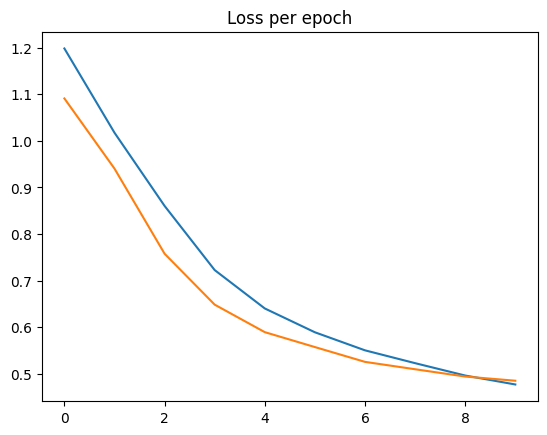

In [23]:
plt.figure()

plt.plot(epoch_train_loss)
plt.plot(epoch_val_loss)

plt.title('Loss per epoch')

In [24]:
# encoder
encoder_input = encoder_decoder.input[0]
encoder_output = encoder_decoder.get_layer('dense_encoder').output
encoder_model = Model(encoder_input, encoder_output)

# decoder# 
text_input = encoder_decoder.input[1]
enc_output = Input(shape=(256,), name='enc_Output')
text_output = encoder_decoder.get_layer('LSTM2').output
add1 = tf.keras.layers.Add()([text_output, enc_output])
fc_1 = fc1(add1)
decoder_output = output_layer(fc_1)

decoder_model = Model(inputs = [text_input, enc_output], outputs = decoder_output)

In [25]:
def beamsearch(image, beam_width = 2):
    
    start = [tokenizer.word_index['startseq']]

    sequences = [[start, 0]]
    
    img_features = chexnet_features[image]
    img_features = encoder_model.predict(img_features)
    finished_seq = []
    
    for i in range(153):
        all_candidates = []
        new_seq = []
        for s in sequences:

            text_input = pad_sequences([s[0]], 153, padding='post')
            predictions = decoder_model.predict([text_input,img_features])
            top_words = np.argsort(predictions[0])[-beam_width:] 
            seq, score = s
            
            for t in top_words:
                candidates = [seq + [t], score - np.log(predictions[0][t])]
                all_candidates.append(candidates)
                
        sequences = sorted(all_candidates, key = lambda l: l[1])[:beam_width]
        # checks for 'endseq' in each seq in the beam
        count = 0
        for seq,score in sequences:
            if seq[len(seq)-1] == tokenizer.word_index['endseq']:
                score = score/len(seq)   # normalized
                finished_seq.append([seq, score])
                count+=1
            else:
                new_seq.append([seq, score])
        beam_width -= count
        sequences = new_seq
        
        # if all the sequences reaches its end before 155 timesteps
        if not sequences:
            break
        else:
            continue
        
    sequences = finished_seq[-1] 
    rep = sequences[0]
    score = sequences[1]
    temp = []
    rep.pop(0)
    for word in rep:
        if word != tokenizer.word_index['endseq']:
            temp.append(tokenizer.index_word[word])
        else:
            break    
    rep = ' '.join(e for e in temp)        
    
    return rep, score

In [26]:
from PIL import Image

def load_image(img_name):
    img = Image.open(img_name)
    X = np.asarray(img.convert("RGB"))
    X = np.asarray(X)
    X = preprocess_input(X)
    X = img.resize((224, 224), Image.ANTIALIAS) 
    X = np.expand_dims(X, axis=0)
    X = np.asarray(X)
    return X

def get_result(beam_width,idx=0):
    plt.figure(figsize=(9,5))

    pred, score = beamsearch(val_data['person_id'][idx], beam_width) # result after 10 epochs
    print('------------------------------------------------------------------------------------------------------')
    print("Predicted Report : ", pred)
    print('Score is :', score)
    print('------------------------------------------------------------------------------------------------------')
    print("Actual Report : ", val_data['findings'][idx])

    plt.subplot(121)
    img = load_image(val_data['img_1'][idx])
    plt.imshow(img[0])

    plt.subplot(122)
    img = load_image(val_data['img_2'][idx])
    plt.imshow(img[0])

1/1 [==============================] - 0s 20ms/step
------------------------------------------------------------------------------------------------------
Predicted Report :  the heart is normal in size. the mediastinum is unremarkable. the lungs are clear without evidence of infiltrate. there is no pneumothorax or effusion.
Score is : 0.3062857065994579
------------------------------------------------------------------------------------------------------
Actual Report :  startseq heart size normal. lungs are clear. xxxx are normal. no pneumonia effusions edema pneumothorax adenopathy nodules or masses. endseq


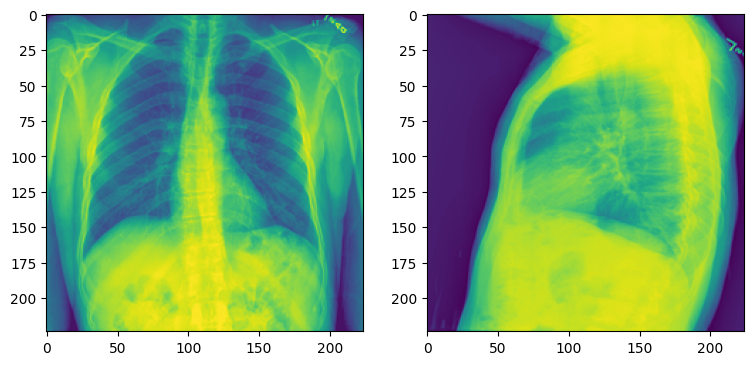

In [27]:
get_result(2)

1/1 [==============================] - 0s 22ms/step
------------------------------------------------------------------------------------------------------
Predicted Report :  the heart is normal in size. the mediastinum is unremarkable. the lungs are clear without evidence of infiltrate. there is no pneumothorax or effusion.
Score is : 0.31634733349514693
------------------------------------------------------------------------------------------------------
Actual Report :  startseq the cardiomediastinal silhouette is normal. no focal airspace consolidation. no pneumothorax or pleural effusion. endseq


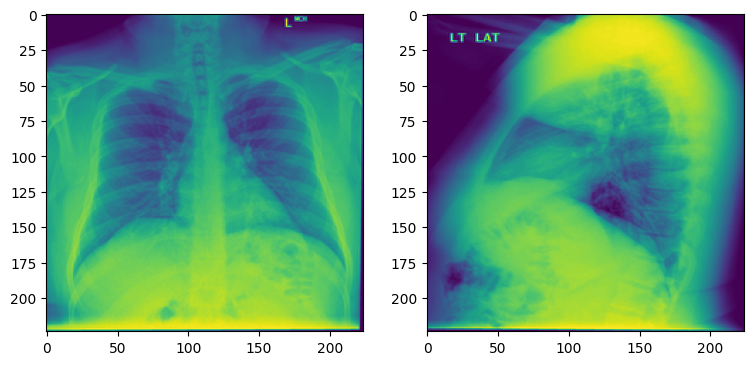

In [28]:
get_result(2, 1)

In [32]:
from nltk.translate.bleu_score import sentence_bleu
from tqdm import tqdm
import numpy as np

def rem_fullstops(text):
    '''Removes punctuations'''
    punctuations = '''.''' # full stop is not removed
    new_text = []
    for char in text:
        if char in punctuations: 
            text = text.replace(char, "")
    new_text.append(' '.join(e for e in text.split()))
    return new_text[0]

bleu1, bleu2, bleu3, bleu4 = [], [], [], []

for img, rep in tqdm(zip(X_test.values, y_test.values)):
    # Clean and prepare the reference caption
    rep = rem_fullstops(rep)
    rep = rep.split()[1:-1]  # Assuming you want to remove start and end tokens

    # Generate and clean the predicted caption
    pred_rep, score  = beamsearch(img,  1)
    pred_rep = rem_fullstops(pred_rep)
    pred_tokens = pred_rep.split()
    
    # Calculate BLEU scores with different n-gram weights
    '''
        BLEU-1 score: emphasize individual word matches
        BLEU-2 score: emphasize up to 2-word sequences
        BLEU-3 score:emphasize up to 3-word sequences
        BLEU-4 score: considers 1-gram to 4-gram matches equally
    '''
    bleu1.append(sentence_bleu([rep], pred_tokens, weights=(1, 0, 0, 0)))
    bleu2.append(sentence_bleu([rep], pred_rep.split(), weights=(0.5, 0.5, 0, 0)))
    bleu3.append(sentence_bleu([rep], pred_rep.split(), weights=(0.33, 0.33, 0.33, 0)))
    bleu4.append(sentence_bleu([rep], pred_rep.split(), weights=(0.25, 0.25, 0.25, 0.25)))

# Calculate average BLEU scores
a = np.mean(bleu1)
b = np.mean(bleu2)
c = np.mean(bleu3)
d = np.mean(bleu4)

# Print the BLEU scores
print('BLEU-1 Score:', a)
print('BLEU-2 Score:', b)
print('BLEU-3 Score:', c)
print('BLEU-4 Score:', d)

print("Average BLEU score:", (a + b + c + d) / 4)

0it [00:00, ?it/s]

1/1 [==============================] - 0s 18ms/step


1it [00:00,  1.55it/s]

1/1 [==============================] - 0s 24ms/step


2it [00:01,  1.62it/s]

1/1 [==============================] - 0s 22ms/step


3it [00:02,  1.45it/s]

1/1 [==============================] - 0s 24ms/step


4it [00:02,  1.48it/s]

1/1 [==============================] - 0s 20ms/step


5it [00:03,  1.18it/s]

1/1 [==============================] - 0s 20ms/step


6it [00:04,  1.30it/s]

1/1 [==============================] - 0s 23ms/step


7it [00:05,  1.38it/s]

1/1 [==============================] - 0s 25ms/step


8it [00:05,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


9it [00:06,  1.44it/s]

1/1 [==============================] - 0s 20ms/step


10it [00:07,  1.47it/s]

1/1 [==============================] - 0s 23ms/step


11it [00:07,  1.45it/s]

1/1 [==============================] - 0s 27ms/step


12it [00:08,  1.49it/s]

1/1 [==============================] - 0s 22ms/step


13it [00:09,  1.48it/s]

1/1 [==============================] - 0s 19ms/step


14it [00:09,  1.44it/s]

1/1 [==============================] - 0s 23ms/step


15it [00:10,  1.42it/s]

1/1 [==============================] - 0s 25ms/step


16it [00:11,  1.27it/s]

1/1 [==============================] - 0s 22ms/step


17it [00:12,  1.32it/s]

1/1 [==============================] - 0s 22ms/step


18it [00:12,  1.34it/s]

1/1 [==============================] - 0s 22ms/step


19it [00:13,  1.33it/s]

1/1 [==============================] - 0s 22ms/step


20it [00:14,  1.36it/s]

1/1 [==============================] - 0s 20ms/step


21it [00:15,  1.35it/s]

1/1 [==============================] - 0s 25ms/step


22it [00:15,  1.33it/s]

1/1 [==============================] - 0s 21ms/step


23it [00:16,  1.38it/s]

1/1 [==============================] - 0s 30ms/step


24it [00:17,  1.42it/s]

1/1 [==============================] - 0s 20ms/step


25it [00:17,  1.44it/s]

1/1 [==============================] - 0s 19ms/step


26it [00:18,  1.46it/s]

1/1 [==============================] - 0s 24ms/step


27it [00:19,  1.48it/s]

1/1 [==============================] - 0s 25ms/step


28it [00:19,  1.51it/s]

1/1 [==============================] - 0s 24ms/step


29it [00:20,  1.48it/s]

1/1 [==============================] - 0s 20ms/step


30it [00:21,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


31it [00:21,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


32it [00:22,  1.42it/s]

1/1 [==============================] - 0s 25ms/step


33it [00:23,  1.43it/s]

1/1 [==============================] - 0s 23ms/step


34it [00:24,  1.42it/s]

1/1 [==============================] - 0s 23ms/step


35it [00:24,  1.45it/s]

1/1 [==============================] - 0s 23ms/step


36it [00:25,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


37it [00:26,  1.48it/s]

1/1 [==============================] - 0s 22ms/step


38it [00:26,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


39it [00:27,  1.50it/s]

1/1 [==============================] - 0s 19ms/step


40it [00:28,  1.44it/s]

1/1 [==============================] - 0s 22ms/step


41it [00:28,  1.47it/s]

1/1 [==============================] - 0s 22ms/step


42it [00:29,  1.49it/s]

1/1 [==============================] - 0s 25ms/step


43it [00:30,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


44it [00:30,  1.49it/s]

1/1 [==============================] - 0s 22ms/step


45it [00:31,  1.50it/s]

1/1 [==============================] - 0s 20ms/step


46it [00:32,  1.51it/s]

1/1 [==============================] - 0s 24ms/step


47it [00:32,  1.51it/s]

1/1 [==============================] - 0s 23ms/step


48it [00:33,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


49it [00:34,  1.51it/s]

1/1 [==============================] - 0s 27ms/step


50it [00:34,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


51it [00:35,  1.46it/s]

1/1 [==============================] - 0s 19ms/step


52it [00:36,  1.47it/s]

1/1 [==============================] - 0s 20ms/step


53it [00:36,  1.47it/s]

1/1 [==============================] - 0s 20ms/step


54it [00:37,  1.43it/s]

1/1 [==============================] - 0s 21ms/step


55it [00:38,  1.18it/s]

1/1 [==============================] - 0s 21ms/step


56it [00:39,  1.29it/s]

1/1 [==============================] - 0s 20ms/step


57it [00:40,  1.35it/s]

1/1 [==============================] - 0s 22ms/step


58it [00:40,  1.41it/s]

1/1 [==============================] - 0s 19ms/step


59it [00:41,  1.47it/s]

1/1 [==============================] - 0s 22ms/step


60it [00:41,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


61it [00:42,  1.51it/s]

1/1 [==============================] - 0s 20ms/step


62it [00:43,  1.46it/s]

1/1 [==============================] - 0s 19ms/step


63it [00:43,  1.49it/s]

1/1 [==============================] - 0s 23ms/step


64it [00:44,  1.49it/s]

1/1 [==============================] - 0s 20ms/step


65it [00:45,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


66it [00:45,  1.47it/s]

1/1 [==============================] - 0s 18ms/step


67it [00:46,  1.52it/s]

1/1 [==============================] - 0s 20ms/step


68it [00:47,  1.54it/s]

1/1 [==============================] - 0s 20ms/step


69it [00:47,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


70it [00:48,  1.49it/s]

1/1 [==============================] - 0s 20ms/step


71it [00:49,  1.51it/s]

1/1 [==============================] - 0s 22ms/step


72it [00:49,  1.54it/s]

1/1 [==============================] - 0s 19ms/step


73it [00:50,  1.55it/s]

1/1 [==============================] - 0s 23ms/step


74it [00:51,  1.55it/s]

1/1 [==============================] - 0s 24ms/step


75it [00:52,  1.29it/s]

1/1 [==============================] - 0s 20ms/step


76it [00:52,  1.31it/s]

1/1 [==============================] - 0s 32ms/step


77it [00:53,  1.37it/s]

1/1 [==============================] - 0s 22ms/step


78it [00:54,  1.41it/s]

1/1 [==============================] - 0s 20ms/step


79it [00:54,  1.42it/s]

1/1 [==============================] - 0s 19ms/step


80it [00:55,  1.42it/s]

1/1 [==============================] - 0s 19ms/step


81it [00:56,  1.45it/s]

1/1 [==============================] - 0s 22ms/step


82it [00:57,  1.40it/s]

1/1 [==============================] - 0s 19ms/step


83it [00:57,  1.44it/s]

1/1 [==============================] - 0s 30ms/step


84it [00:58,  1.43it/s]

1/1 [==============================] - 0s 20ms/step


85it [00:59,  1.47it/s]

1/1 [==============================] - 0s 25ms/step


86it [00:59,  1.49it/s]

1/1 [==============================] - 0s 25ms/step


87it [01:00,  1.40it/s]

1/1 [==============================] - 0s 23ms/step


88it [01:01,  1.41it/s]

1/1 [==============================] - 0s 22ms/step


89it [01:01,  1.43it/s]

1/1 [==============================] - 0s 22ms/step


90it [01:02,  1.42it/s]

1/1 [==============================] - 0s 24ms/step


91it [01:03,  1.43it/s]

1/1 [==============================] - 0s 22ms/step


92it [01:04,  1.39it/s]

1/1 [==============================] - 0s 22ms/step


93it [01:04,  1.42it/s]

1/1 [==============================] - 0s 33ms/step


94it [01:05,  1.44it/s]

1/1 [==============================] - 0s 22ms/step


95it [01:06,  1.39it/s]

1/1 [==============================] - 0s 24ms/step


96it [01:06,  1.35it/s]

1/1 [==============================] - 0s 23ms/step


97it [01:08,  1.16it/s]

1/1 [==============================] - 0s 21ms/step


98it [01:08,  1.24it/s]

1/1 [==============================] - 0s 22ms/step


99it [01:09,  1.25it/s]

1/1 [==============================] - 0s 22ms/step


100it [01:10,  1.32it/s]

1/1 [==============================] - 0s 24ms/step


101it [01:10,  1.39it/s]

1/1 [==============================] - 0s 24ms/step


102it [01:11,  1.36it/s]

1/1 [==============================] - 0s 21ms/step


103it [01:12,  1.41it/s]

1/1 [==============================] - 0s 19ms/step


104it [01:13,  1.40it/s]

1/1 [==============================] - 0s 23ms/step


105it [01:14,  1.18it/s]

1/1 [==============================] - 0s 23ms/step


106it [01:14,  1.25it/s]

1/1 [==============================] - 0s 23ms/step


107it [01:15,  1.31it/s]

1/1 [==============================] - 0s 20ms/step


108it [01:16,  1.37it/s]

1/1 [==============================] - 0s 22ms/step


109it [01:16,  1.41it/s]

1/1 [==============================] - 0s 18ms/step


110it [01:17,  1.44it/s]

1/1 [==============================] - 0s 21ms/step


111it [01:18,  1.47it/s]

1/1 [==============================] - 0s 20ms/step


112it [01:18,  1.49it/s]

1/1 [==============================] - 0s 25ms/step


113it [01:19,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


114it [01:20,  1.50it/s]

1/1 [==============================] - 0s 20ms/step


115it [01:20,  1.53it/s]

1/1 [==============================] - 0s 22ms/step


116it [01:21,  1.54it/s]

1/1 [==============================] - 0s 19ms/step


117it [01:22,  1.49it/s]

1/1 [==============================] - 0s 20ms/step


118it [01:22,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


119it [01:23,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


120it [01:24,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


121it [01:24,  1.45it/s]

1/1 [==============================] - 0s 19ms/step


122it [01:25,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


123it [01:26,  1.51it/s]

1/1 [==============================] - 0s 23ms/step


124it [01:26,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


125it [01:27,  1.42it/s]

1/1 [==============================] - 0s 20ms/step


126it [01:28,  1.22it/s]

1/1 [==============================] - 0s 23ms/step


127it [01:29,  1.09it/s]

1/1 [==============================] - 0s 23ms/step


128it [01:30,  1.20it/s]

1/1 [==============================] - 0s 20ms/step


129it [01:31,  1.30it/s]

1/1 [==============================] - 0s 19ms/step


130it [01:31,  1.37it/s]

1/1 [==============================] - 0s 22ms/step


131it [01:32,  1.42it/s]

1/1 [==============================] - 0s 22ms/step


132it [01:32,  1.47it/s]

1/1 [==============================] - 0s 25ms/step


133it [01:33,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


134it [01:34,  1.52it/s]

1/1 [==============================] - 0s 23ms/step


135it [01:34,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


136it [01:35,  1.50it/s]

1/1 [==============================] - 0s 20ms/step


137it [01:36,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


138it [01:36,  1.53it/s]

1/1 [==============================] - 0s 22ms/step


139it [01:37,  1.54it/s]

1/1 [==============================] - 0s 31ms/step


140it [01:38,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


141it [01:38,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


142it [01:39,  1.52it/s]

1/1 [==============================] - 0s 22ms/step


143it [01:40,  1.55it/s]

1/1 [==============================] - 0s 20ms/step


144it [01:40,  1.55it/s]

1/1 [==============================] - 0s 22ms/step


145it [01:41,  1.47it/s]

1/1 [==============================] - 0s 23ms/step


146it [01:42,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


147it [01:42,  1.51it/s]

1/1 [==============================] - 0s 20ms/step


148it [01:43,  1.48it/s]

1/1 [==============================] - 0s 18ms/step


149it [01:44,  1.53it/s]

1/1 [==============================] - 0s 20ms/step


150it [01:44,  1.57it/s]

1/1 [==============================] - 0s 21ms/step


151it [01:45,  1.58it/s]

1/1 [==============================] - 0s 20ms/step


152it [01:46,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


153it [01:46,  1.53it/s]

1/1 [==============================] - 0s 20ms/step


154it [01:47,  1.22it/s]

1/1 [==============================] - 0s 23ms/step


155it [01:48,  1.31it/s]

1/1 [==============================] - 0s 22ms/step


156it [01:49,  1.36it/s]

1/1 [==============================] - 0s 22ms/step


157it [01:50,  1.27it/s]

1/1 [==============================] - 0s 23ms/step


158it [01:50,  1.33it/s]

1/1 [==============================] - 0s 21ms/step


159it [01:51,  1.37it/s]

1/1 [==============================] - 0s 20ms/step


160it [01:52,  1.39it/s]

1/1 [==============================] - 0s 24ms/step


161it [01:52,  1.42it/s]

1/1 [==============================] - 0s 25ms/step


162it [01:53,  1.41it/s]

1/1 [==============================] - 0s 20ms/step


163it [01:54,  1.39it/s]

1/1 [==============================] - 0s 21ms/step


164it [01:55,  1.37it/s]

1/1 [==============================] - 0s 23ms/step


165it [01:55,  1.38it/s]

1/1 [==============================] - 0s 20ms/step


166it [01:56,  1.40it/s]

1/1 [==============================] - 0s 37ms/step


167it [01:57,  1.41it/s]

1/1 [==============================] - 0s 21ms/step


168it [01:57,  1.42it/s]

1/1 [==============================] - 0s 19ms/step


169it [01:58,  1.46it/s]

1/1 [==============================] - 0s 23ms/step


170it [01:59,  1.48it/s]

1/1 [==============================] - 0s 25ms/step


171it [01:59,  1.49it/s]

1/1 [==============================] - 0s 23ms/step


172it [02:00,  1.49it/s]

1/1 [==============================] - 0s 23ms/step


173it [02:01,  1.47it/s]

1/1 [==============================] - 0s 22ms/step


174it [02:01,  1.46it/s]

1/1 [==============================] - 0s 20ms/step


175it [02:02,  1.49it/s]

1/1 [==============================] - 0s 23ms/step


176it [02:03,  1.50it/s]

1/1 [==============================] - 0s 25ms/step


177it [02:03,  1.52it/s]

1/1 [==============================] - 0s 25ms/step


178it [02:04,  1.52it/s]

1/1 [==============================] - 0s 22ms/step


179it [02:05,  1.50it/s]

1/1 [==============================] - 0s 23ms/step


180it [02:05,  1.51it/s]

1/1 [==============================] - 0s 20ms/step


181it [02:06,  1.48it/s]

1/1 [==============================] - 0s 23ms/step


182it [02:07,  1.49it/s]

1/1 [==============================] - 0s 23ms/step


183it [02:07,  1.42it/s]

1/1 [==============================] - 0s 19ms/step


184it [02:08,  1.40it/s]

1/1 [==============================] - 0s 19ms/step


185it [02:09,  1.43it/s]

1/1 [==============================] - 0s 23ms/step


186it [02:09,  1.49it/s]

1/1 [==============================] - 0s 22ms/step


187it [02:10,  1.49it/s]

1/1 [==============================] - 0s 22ms/step


188it [02:11,  1.21it/s]

1/1 [==============================] - 0s 22ms/step


189it [02:12,  1.26it/s]

1/1 [==============================] - 0s 23ms/step


190it [02:13,  1.32it/s]

1/1 [==============================] - 0s 20ms/step


191it [02:13,  1.34it/s]

1/1 [==============================] - 0s 19ms/step


192it [02:14,  1.40it/s]

1/1 [==============================] - 0s 21ms/step


193it [02:15,  1.45it/s]

1/1 [==============================] - 0s 19ms/step


194it [02:15,  1.42it/s]

1/1 [==============================] - 0s 20ms/step


195it [02:16,  1.45it/s]

1/1 [==============================] - 0s 20ms/step


196it [02:17,  1.43it/s]

1/1 [==============================] - 0s 21ms/step


197it [02:18,  1.39it/s]

1/1 [==============================] - 0s 21ms/step


198it [02:18,  1.39it/s]

1/1 [==============================] - 0s 20ms/step


199it [02:19,  1.42it/s]

1/1 [==============================] - 0s 21ms/step


200it [02:20,  1.39it/s]

1/1 [==============================] - 0s 21ms/step


201it [02:20,  1.44it/s]

1/1 [==============================] - 0s 20ms/step


202it [02:21,  1.47it/s]

1/1 [==============================] - 0s 20ms/step


203it [02:22,  1.49it/s]

1/1 [==============================] - 0s 20ms/step


204it [02:22,  1.50it/s]

1/1 [==============================] - 0s 20ms/step


205it [02:23,  1.50it/s]

1/1 [==============================] - 0s 23ms/step


206it [02:24,  1.47it/s]

1/1 [==============================] - 0s 22ms/step


207it [02:24,  1.44it/s]

1/1 [==============================] - 0s 23ms/step


208it [02:25,  1.46it/s]

1/1 [==============================] - 0s 20ms/step


209it [02:26,  1.44it/s]

1/1 [==============================] - 0s 20ms/step


210it [02:27,  1.42it/s]

1/1 [==============================] - 0s 23ms/step


211it [02:27,  1.40it/s]

1/1 [==============================] - 0s 45ms/step


212it [02:28,  1.37it/s]

1/1 [==============================] - 0s 22ms/step


213it [02:29,  1.40it/s]

1/1 [==============================] - 0s 24ms/step


214it [02:29,  1.43it/s]

1/1 [==============================] - 0s 21ms/step


215it [02:30,  1.47it/s]

1/1 [==============================] - 0s 22ms/step


216it [02:31,  1.49it/s]

1/1 [==============================] - 0s 22ms/step


217it [02:31,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


218it [02:32,  1.44it/s]

1/1 [==============================] - 0s 19ms/step


219it [02:33,  1.40it/s]

1/1 [==============================] - 0s 20ms/step


220it [02:33,  1.46it/s]

1/1 [==============================] - 0s 23ms/step


221it [02:34,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


222it [02:35,  1.50it/s]

1/1 [==============================] - 0s 23ms/step


223it [02:35,  1.52it/s]

1/1 [==============================] - 0s 22ms/step


224it [02:36,  1.55it/s]

1/1 [==============================] - 0s 23ms/step


225it [02:37,  1.57it/s]

1/1 [==============================] - 0s 20ms/step


226it [02:37,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


227it [02:38,  1.46it/s]

1/1 [==============================] - 0s 22ms/step


228it [02:39,  1.35it/s]

1/1 [==============================] - 0s 26ms/step


229it [02:40,  1.37it/s]

1/1 [==============================] - 0s 24ms/step


230it [02:40,  1.34it/s]

1/1 [==============================] - 0s 24ms/step


231it [02:41,  1.38it/s]

1/1 [==============================] - 0s 28ms/step


232it [02:42,  1.38it/s]

1/1 [==============================] - 0s 20ms/step


233it [02:43,  1.36it/s]

1/1 [==============================] - 0s 22ms/step


234it [02:43,  1.40it/s]

1/1 [==============================] - 0s 20ms/step


235it [02:44,  1.39it/s]

1/1 [==============================] - 0s 24ms/step


236it [02:45,  1.42it/s]

1/1 [==============================] - 0s 25ms/step


237it [02:45,  1.37it/s]

1/1 [==============================] - 0s 23ms/step


238it [02:46,  1.34it/s]

1/1 [==============================] - 0s 20ms/step


239it [02:47,  1.34it/s]

1/1 [==============================] - 0s 24ms/step


240it [02:48,  1.39it/s]

1/1 [==============================] - 0s 23ms/step


241it [02:48,  1.41it/s]

1/1 [==============================] - 0s 24ms/step


242it [02:49,  1.42it/s]

1/1 [==============================] - 0s 20ms/step


243it [02:50,  1.45it/s]

1/1 [==============================] - 0s 22ms/step


244it [02:50,  1.45it/s]

1/1 [==============================] - 0s 21ms/step


245it [02:51,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


246it [02:52,  1.43it/s]

1/1 [==============================] - 0s 25ms/step


247it [02:52,  1.46it/s]

1/1 [==============================] - 0s 24ms/step


248it [02:53,  1.39it/s]

1/1 [==============================] - 0s 23ms/step


249it [02:54,  1.42it/s]

1/1 [==============================] - 0s 19ms/step


250it [02:55,  1.42it/s]

1/1 [==============================] - 0s 21ms/step


251it [02:55,  1.46it/s]

1/1 [==============================] - 0s 24ms/step


252it [02:56,  1.48it/s]

1/1 [==============================] - 0s 20ms/step


253it [02:57,  1.19it/s]

1/1 [==============================] - 0s 19ms/step


254it [02:58,  1.22it/s]

1/1 [==============================] - 0s 26ms/step


255it [02:58,  1.31it/s]

1/1 [==============================] - 0s 24ms/step


256it [02:59,  1.36it/s]

1/1 [==============================] - 0s 20ms/step


257it [03:00,  1.40it/s]

1/1 [==============================] - 0s 23ms/step


258it [03:00,  1.43it/s]

1/1 [==============================] - 0s 22ms/step


259it [03:01,  1.47it/s]

1/1 [==============================] - 0s 20ms/step


260it [03:02,  1.43it/s]

1/1 [==============================] - 0s 19ms/step


261it [03:02,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


262it [03:03,  1.50it/s]

1/1 [==============================] - 0s 24ms/step


263it [03:04,  1.51it/s]

1/1 [==============================] - 0s 23ms/step


264it [03:05,  1.46it/s]

1/1 [==============================] - 0s 23ms/step


265it [03:05,  1.43it/s]

1/1 [==============================] - 0s 24ms/step


266it [03:06,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


267it [03:07,  1.49it/s]

1/1 [==============================] - 0s 19ms/step


268it [03:07,  1.50it/s]

1/1 [==============================] - 0s 20ms/step


269it [03:08,  1.52it/s]

1/1 [==============================] - 0s 23ms/step


270it [03:09,  1.51it/s]

1/1 [==============================] - 0s 23ms/step


271it [03:09,  1.52it/s]

1/1 [==============================] - 0s 20ms/step


272it [03:10,  1.50it/s]

1/1 [==============================] - 0s 24ms/step


273it [03:11,  1.47it/s]

1/1 [==============================] - 0s 28ms/step


274it [03:11,  1.46it/s]

1/1 [==============================] - 0s 20ms/step


275it [03:12,  1.44it/s]

1/1 [==============================] - 0s 22ms/step


276it [03:13,  1.43it/s]

1/1 [==============================] - 0s 21ms/step


277it [03:13,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


278it [03:14,  1.49it/s]

1/1 [==============================] - 0s 20ms/step


279it [03:15,  1.50it/s]

1/1 [==============================] - 0s 25ms/step


280it [03:15,  1.52it/s]

1/1 [==============================] - 0s 25ms/step


281it [03:16,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


282it [03:17,  1.48it/s]

1/1 [==============================] - 0s 22ms/step


283it [03:17,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


284it [03:18,  1.53it/s]

1/1 [==============================] - 0s 20ms/step


285it [03:19,  1.49it/s]

1/1 [==============================] - 0s 25ms/step


286it [03:19,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


287it [03:20,  1.49it/s]

1/1 [==============================] - 0s 20ms/step


288it [03:21,  1.49it/s]

1/1 [==============================] - 0s 23ms/step


289it [03:21,  1.43it/s]

1/1 [==============================] - 0s 22ms/step


290it [03:22,  1.42it/s]

1/1 [==============================] - 0s 20ms/step


291it [03:23,  1.47it/s]

1/1 [==============================] - 0s 20ms/step


292it [03:23,  1.41it/s]

1/1 [==============================] - 0s 22ms/step


293it [03:24,  1.40it/s]

1/1 [==============================] - 0s 22ms/step


294it [03:25,  1.44it/s]

1/1 [==============================] - 0s 19ms/step


295it [03:26,  1.46it/s]

1/1 [==============================] - 0s 20ms/step


296it [03:26,  1.50it/s]

1/1 [==============================] - 0s 20ms/step


297it [03:27,  1.51it/s]

1/1 [==============================] - 0s 22ms/step


298it [03:28,  1.45it/s]

1/1 [==============================] - 0s 21ms/step


299it [03:28,  1.36it/s]

1/1 [==============================] - 0s 22ms/step


300it [03:29,  1.39it/s]

1/1 [==============================] - 0s 20ms/step


301it [03:30,  1.37it/s]

1/1 [==============================] - 0s 21ms/step


302it [03:31,  1.40it/s]

1/1 [==============================] - 0s 26ms/step


303it [03:31,  1.41it/s]

1/1 [==============================] - 0s 23ms/step


304it [03:32,  1.43it/s]

1/1 [==============================] - 0s 23ms/step


305it [03:33,  1.15it/s]

1/1 [==============================] - 0s 22ms/step


306it [03:34,  1.24it/s]

1/1 [==============================] - 0s 23ms/step


307it [03:34,  1.30it/s]

1/1 [==============================] - 0s 24ms/step


308it [03:35,  1.33it/s]

1/1 [==============================] - 0s 22ms/step


309it [03:36,  1.34it/s]

1/1 [==============================] - 0s 21ms/step


310it [03:37,  1.37it/s]

1/1 [==============================] - 0s 20ms/step


311it [03:37,  1.42it/s]

1/1 [==============================] - 0s 22ms/step


312it [03:38,  1.41it/s]

1/1 [==============================] - 0s 23ms/step


313it [03:39,  1.42it/s]

1/1 [==============================] - 0s 23ms/step


314it [03:39,  1.44it/s]

1/1 [==============================] - 0s 22ms/step


315it [03:40,  1.46it/s]

1/1 [==============================] - 0s 22ms/step


316it [03:41,  1.48it/s]

1/1 [==============================] - 0s 26ms/step


317it [03:41,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


318it [03:42,  1.46it/s]

1/1 [==============================] - 0s 22ms/step


319it [03:43,  1.45it/s]

1/1 [==============================] - 0s 20ms/step


320it [03:43,  1.48it/s]

1/1 [==============================] - 0s 20ms/step


321it [03:44,  1.46it/s]

1/1 [==============================] - 0s 22ms/step


322it [03:45,  1.43it/s]

1/1 [==============================] - 0s 22ms/step


323it [03:45,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


324it [03:46,  1.47it/s]

1/1 [==============================] - 0s 25ms/step


325it [03:47,  1.44it/s]

1/1 [==============================] - 0s 22ms/step


326it [03:48,  1.48it/s]

1/1 [==============================] - 0s 20ms/step


327it [03:48,  1.45it/s]

1/1 [==============================] - 0s 21ms/step


328it [03:49,  1.43it/s]

1/1 [==============================] - 0s 22ms/step


329it [03:50,  1.41it/s]

1/1 [==============================] - 0s 21ms/step


330it [03:50,  1.44it/s]

1/1 [==============================] - 0s 21ms/step


331it [03:51,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


332it [03:52,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


333it [03:52,  1.52it/s]

1/1 [==============================] - 0s 20ms/step


334it [03:53,  1.46it/s]

1/1 [==============================] - 0s 20ms/step


335it [03:54,  1.44it/s]

1/1 [==============================] - 0s 27ms/step


336it [03:54,  1.41it/s]

1/1 [==============================] - 0s 22ms/step


337it [03:55,  1.43it/s]

1/1 [==============================] - 0s 19ms/step


338it [03:56,  1.43it/s]

1/1 [==============================] - 0s 21ms/step


339it [03:57,  1.42it/s]

1/1 [==============================] - 0s 23ms/step


340it [03:57,  1.46it/s]

1/1 [==============================] - 0s 20ms/step


341it [03:58,  1.50it/s]

1/1 [==============================] - 0s 19ms/step


342it [03:59,  1.50it/s]

1/1 [==============================] - 0s 20ms/step


343it [03:59,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


344it [04:00,  1.52it/s]

1/1 [==============================] - 0s 22ms/step


345it [04:00,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


346it [04:01,  1.53it/s]

1/1 [==============================] - 0s 20ms/step


347it [04:02,  1.52it/s]

1/1 [==============================] - 0s 20ms/step


348it [04:03,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


349it [04:03,  1.50it/s]

1/1 [==============================] - 0s 20ms/step


350it [04:04,  1.52it/s]

1/1 [==============================] - 0s 23ms/step


351it [04:04,  1.52it/s]

1/1 [==============================] - 0s 22ms/step


352it [04:05,  1.47it/s]

1/1 [==============================] - 0s 31ms/step


353it [04:06,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


354it [04:07,  1.48it/s]

1/1 [==============================] - 0s 22ms/step


355it [04:07,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


356it [04:08,  1.49it/s]

1/1 [==============================] - 0s 31ms/step


357it [04:08,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


358it [04:09,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


359it [04:10,  1.52it/s]

1/1 [==============================] - 0s 20ms/step


360it [04:10,  1.52it/s]

1/1 [==============================] - 0s 23ms/step


361it [04:11,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


362it [04:12,  1.44it/s]

1/1 [==============================] - 0s 20ms/step


363it [04:13,  1.47it/s]

1/1 [==============================] - 0s 20ms/step


364it [04:13,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


365it [04:14,  1.52it/s]

1/1 [==============================] - 0s 25ms/step


366it [04:14,  1.53it/s]

1/1 [==============================] - 0s 25ms/step


367it [04:15,  1.54it/s]

1/1 [==============================] - 0s 20ms/step


368it [04:16,  1.55it/s]

1/1 [==============================] - 0s 38ms/step


369it [04:16,  1.54it/s]

1/1 [==============================] - 0s 22ms/step


370it [04:17,  1.54it/s]

1/1 [==============================] - 0s 25ms/step


371it [04:18,  1.40it/s]

1/1 [==============================] - 0s 22ms/step


372it [04:19,  1.43it/s]

1/1 [==============================] - 0s 22ms/step


373it [04:19,  1.42it/s]

1/1 [==============================] - 0s 26ms/step


374it [04:20,  1.42it/s]

1/1 [==============================] - 0s 21ms/step


375it [04:21,  1.43it/s]

1/1 [==============================] - 0s 22ms/step


376it [04:21,  1.42it/s]

1/1 [==============================] - 0s 24ms/step


377it [04:22,  1.39it/s]

1/1 [==============================] - 0s 21ms/step


378it [04:23,  1.36it/s]

1/1 [==============================] - 0s 25ms/step


379it [04:24,  1.34it/s]

1/1 [==============================] - 0s 23ms/step


380it [04:24,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


381it [04:25,  1.40it/s]

1/1 [==============================] - 0s 23ms/step


382it [04:26,  1.38it/s]

1/1 [==============================] - 0s 21ms/step


383it [04:27,  1.39it/s]

1/1 [==============================] - 0s 29ms/step


384it [04:27,  1.41it/s]

1/1 [==============================] - 0s 22ms/step


385it [04:28,  1.43it/s]

1/1 [==============================] - 0s 21ms/step


386it [04:29,  1.47it/s]

1/1 [==============================] - 0s 23ms/step


387it [04:29,  1.42it/s]

1/1 [==============================] - 0s 20ms/step


388it [04:30,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


389it [04:31,  1.44it/s]

1/1 [==============================] - 0s 21ms/step


390it [04:31,  1.41it/s]

1/1 [==============================] - 0s 21ms/step


391it [04:32,  1.43it/s]

1/1 [==============================] - 0s 22ms/step


392it [04:33,  1.38it/s]

1/1 [==============================] - 0s 21ms/step


393it [04:34,  1.40it/s]

1/1 [==============================] - 0s 21ms/step


394it [04:34,  1.44it/s]

1/1 [==============================] - 0s 25ms/step


395it [04:35,  1.43it/s]

BLEU-1 Score: 0.23960145958981946
BLEU-2 Score: 0.14660284607451451
BLEU-3 Score: 0.09860910773383184
BLEU-4 Score: 0.05709883486043875
Average BLEU score: 0.13547806206465113
